# ML Skill Exercise - Alberto Marengo

Assignment text

In our surveys, we ask a combination of both open-ended and closed-ended questions. In this exercise, you will be analyzing open text responses from a survey question which asked the following:
- Why are you cancelling?
Our team has already analyzed these responses to construct themes that will be useful for our clients to understand in terms of quality (what they are) and quantity (how many of each there are). As is the case with all of our projects, the ultimate goal is to use insights derived from this data to help companies make informed decisions.

You should have been given a file named coded_responses.csv
- Respondent IDs are the unique ids attached to a respondent.
- The text of their response is in the ‘response’ column
- ‘Theme’ column represents the themes we coded the data for.
Note: There can be responses which have multiple themes, those responses will have multiple rows in this file.

## Part 1

Let's start importing the packages and defining some functions we'll need for the analysis:

- `pre_process`: general text cleanup preprocessing function
- `_wordclouds`: generates wordcloud plot of input text

In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import warnings
from tqdm import tqdm
from biterm.btm import oBTM
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

C:\Users\maren\Anaconda3\envs\topic_modeling\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
def pre_process(text):
    text = text.encode("ascii", "ignore");
    text = text.decode()
    text = text.lower()
    text = re.sub(pattern=r"\S*@\S*\s?", repl="", string=text)  # Emails
    text = re.sub(pattern=r"[0-9]", repl="", string=text)  # remove numbers
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"-[ ]*\b", repl="", string=text)  # correct words hyphenated in wrapping
    text = re.sub(pattern=r"\s+", repl=" ", string=text)  # remove white space
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"([a-z\._]+)[.](jpg|png|jpeg|pdf|gif)|([a-z\._]+)(jpg|png|jpeg|pdf|gif)|(jpg|png|jpeg|pdf|gif)",
                  repl="", string=text)  # image file extensions
    text = re.sub(pattern=r"(https?:\/\/|www.)+\S+", repl="", string=text)  # websites
    text = re.sub(pattern=r"[^A-Za-z0-9]+", repl=" ", string=text)  # removes non-english
    return text

In [3]:
def _wordclouds(inputs, max_words=5000):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    long_string = ', '.join(inputs)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3,
                          contour_color='steelblue', width=900, height=900, collocations=False)
    # Generate a word cloud
    wordcloud.generate(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.suptitle('Word Cloud', fontsize=16)
    # fig.savefig(fname=f'output/wordcloud.png')

We start loading the data into a pandas DataFrame and create a boolean column for text that are longer than 3 words. We'll only keep these rows for the preliminary analysis.

In [4]:
df = pd.read_csv('data/coded_responses.csv')

In [5]:
df['keep'] = df['response'].apply(lambda text: True if len(text.split())>3 else False)
df

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
3    Why are you cancelling?        1779968   
4    Why are you cancelling?        1779967   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
3                                          Budget cuts   
4                           Cannot have multiple users   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                                         theme   keep  
0                                          NaN   True  
1                                          NaN   True  
2                                          NaN   True  
3    Reducing expenses / financial constraints  False  
4               Object to sharing restrictions   True  
..                                         ...    ...  
658             Constant price rise / increase   True  
659             Constant price rise / increase   True  
660                         Prefer competition   True  
661                              Too expensive   True  
662             Constant price rise / increase   True  

[663 rows x 5 columns]

Let's check if we have any duplicated rows in the dataset

In [6]:
df.duplicated().any()

False

In [7]:
df[df.duplicated(subset='response')==True]

question  respondent_id  \
15   Why are you cancelling?        1779957   
25   Why are you cancelling?        1779948   
32   Why are you cancelling?        1779942   
40   Why are you cancelling?        1779935   
61   Why are you cancelling?        1779915   
..                       ...            ...   
640  Why are you cancelling?        1779387   
649  Why are you cancelling?        1779379   
657  Why are you cancelling?        1779372   
658  Why are you cancelling?        1779372   
661  Why are you cancelling?        1779370   

                                              response  \
15                 I need to change country of billing   
25   moving in with my bf. He has an subscription a...   
32   Prices keep going upward it is now too much ex...   
40        To expensive compared to others so switching   
61   Because I can�t share with my grandkids out of...   
..                                                 ...   
640  You raised your price almost 50%. I also don�t...   
649  Your company has far too many price increases....   
657  Your pricing is terrible. You keep increasing ...   
658  Your pricing is terrible. You keep increasing ...   
661  Your rates are higher than others who do the s...   

                                               theme  keep  
15                       Moving / changing locations  True  
25                       Moving / changing locations  True  
32                    Constant price rise / increase  True  
40                                     Too expensive  True  
61                    Object to sharing restrictions  True  
..                                               ...   ...  
640                   Constant price rise / increase  True  
649                   Constant price rise / increase  True  
657  Corporate greed / taking advantage of customers  True  
658                   Constant price rise / increase  True  
661                                    Too expensive  True  

[72 rows x 5 columns]

It looks like we have some duplicated response but, because they are assigned to different users, we'll keep them all.

In [8]:
df.isna().any()

question         False
respondent_id    False
response         False
theme             True
keep             False
dtype: bool

It also looks like we have some Nan values in the 'theme' column.

### Wordcloud

Let's start by plotting the wordcloud of all the response to check what are the most frequent words.

In [9]:
texts = df[df['keep']==True]['response'].tolist()
texts = [pre_process(text) for text in texts]

In [10]:
len(texts)

501

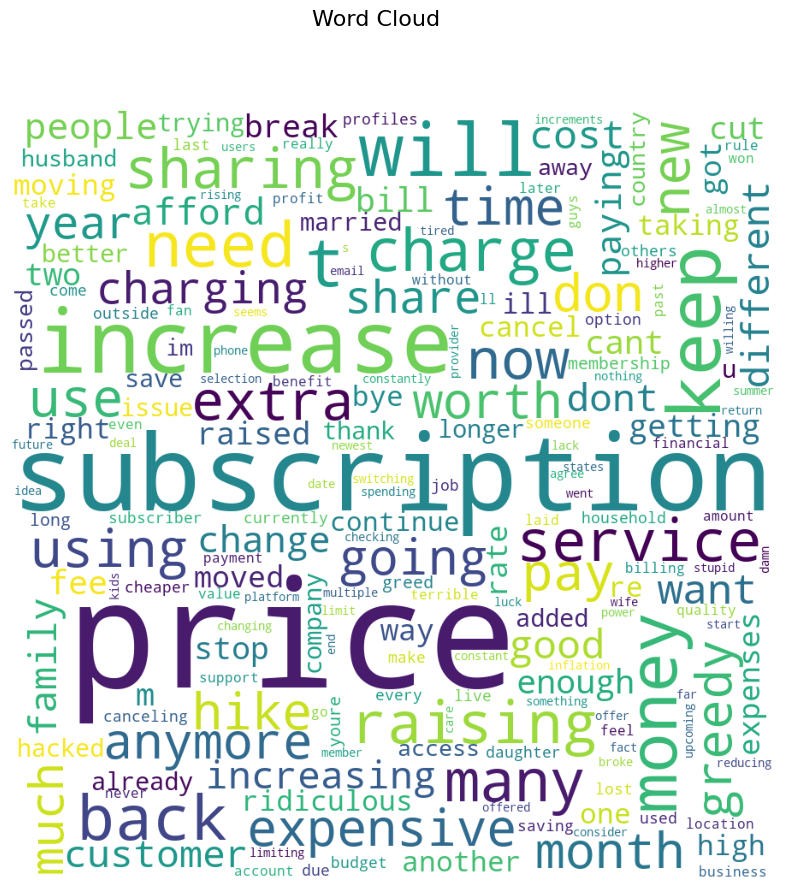

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(texts, max_words=200)

It looks like words 'price', 'increase', 'subscription' are the most frequent.

## Biterm Topic Model (for short text)

resource: [https://pypi.org/project/biterm/](https://pypi.org/project/biterm/)

To assign topics, we will use a specific topic model called biterm (BTM) that is well suited for short text.

The conventional topic models implicitly capture the document-level word co-occurrence patterns to reveal topics, and thus suffer from the severe data sparsity in short documents. In BTM we learn the topics by directly modeling the generation of word co-occurrence patterns (i.e. biterms) in the whole corpus. The major advantages of BTM are that:
- BTM explicitly models the word co-occurrence pat- terns to enhance the topic learning; and
- BTM uses the aggregated patterns in the whole corpus for learning topics to solve the problem of sparse word co-occurrence patterns at document-level.

The parameter inference is done using Gibbs sampling, a simple and widely applicable Markov chain Monte Carlo algorithm. The basic idea of Gibbs sampling is to estimate the parameters alternatively, by replacing the value of one variable by a value drawn from the distribution of that variable conditioned on the values of the remaining variables.

In [12]:
 # vectorize texts
# vec = CountVectorizer(stop_words='english')
vec = CountVectorizer()
X = vec.fit_transform(texts).toarray()

In [13]:
# get vocabulary
vocab = vec.get_feature_names_out()

# get biterms
biterms = vec_to_biterms(X)

Let's  create a training loop to try different topic numbers and get the coherence score to choose the best one.

In [14]:
def train(biterms, start=2, end=50):
    model_list = []
    topics_list = []
    coherence_score_list = []
    for num_topics in tqdm(range(start, end)):
        btm = oBTM(num_topics=num_topics, V=vocab)
        for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
            biterms_chunk = biterms[i:i + 100]
            btm.fit(biterms_chunk, iterations=50)
        topics = btm.transform(biterms)
        res = topic_summuary(btm.phi_wz.T, X, vocab, df.shape[0])
        model_list.append(btm)
        topics_list.append(topics)
        coherence_score_list.append(np.mean(res['coherence']))
    return range(start, end), model_list, topics_list, coherence_score_list

In [15]:
n_range, models, topics, coherence = train(biterms)

100%|██████████| 50/50 [00:08<00:00,  5.72it/s]

100%|██████████| 50/50 [00:07<00:00,  7.03it/s]

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.92it/s]


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.39it/s]


Topic 0 | Coherence=-286474.18 | Top words= to the price and it prices you is for not too will my be keep have your raising this now are just many me back subscription expensive much of worth money other time only anymore that increasing increase so good year need pay do we after but in customer ill new use with at as was service like going why no raised months up can enough services afford want canceling long am or consider subscriber rates greedy dont increases on checking luck increments access if seems last added fact currently used cancel month continues again come greed us once has more lost there being bill make company customers biannually profit because starting entertaining additional one stop life fees what an different ll loyalty alarming feel change moved far bye by almost where cut when options don high rate card using never charged break about others without budget save offer profiles business right every cant job charges compromised country especially face forcing iny p

  2%|▏         | 1/48 [01:26<1:07:38, 86.36s/it]

Topic 1 | Coherence=-295523.35 | Top words= and you the price my subscription to extra for your with of charge that in is charging money increase greedy subscriptions share me are not when using sharing family increases it out no about have keep many don hikes pay people youre going has like prices paying different re will want because more bill also im too way was over better good if other years now just gonna need daughter reason kept few she raising outside past fan be thank cheaper bye news an anyways sign uses ut college worth company up idea states limit power we hike services on two its ridiculous taste disgusting extortion only where fee got dont this since so change from live use am cant but been terrible months getting service charges married already anticonsumer newest pricing addition locations high can won support keeps longer saving another moving greed upcoming how kids willing they deal back moved husband changing lack cancel selection issues problem without profiles co


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]

100%|██████████| 50/50 [00:07<00:00,  6.96it/s]

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.96it/s]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.52it/s]


Topic 0 | Coherence=-266793.69 | Top words= you extra and subscription the to my that of for charging share price not using with your increase greedy pay family about charge bill money youre subscriptions because have people hikes many was so out are it sharing want services paying other im better when just prices is like if also me cheaper raising but way kept gonna reason outside keep past fan don an few years over news idea power its limit states only do disgusting extortion taste now company no different without even after ill newest cant care more hike card good too garbage compromised continues charged guys credit customers option this in automatically wanted allowed bank told issues why climb benefit how from stay grandkids profiles dont will they what first added used before rate something recent talk she one limited agree support stop their expenses longer needed service take need again parents won account put start fair charges expected things continue been forth bye between 

  4%|▍         | 2/48 [03:01<1:10:16, 91.65s/it]

Topic 2 | Coherence=-275152.08 | Top words= price the and it is you prices for to not your too are keep me worth raising going increase no increasing charge expensive re more greedy will when much now good year up enough increases bye new this only my anymore daughter customer with at that raised thank of after time ut sign uses anyways college many have consider rates just like money can service she other long extra subscriber in but company or be options seems charges sharing high if has afford do currently again us cost there make entertaining profit starting biannually being additional terrible use alarming loyalty feel so every pricing addition last stop far way added fees what kids subscription ill profiles others fact never keeps nice choice forcing keeping iny especially face shoves business pop email deal need life greed right months reactivate makes cared rectifying means leave continuous problem issue forever understand were hiking begin wouldn give we about saving dont same


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]

100%|██████████| 50/50 [00:06<00:00,  7.22it/s]

100%|██████████| 50/50 [00:12<00:00,  3.88it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.98it/s]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

100%|██████████| 50/50 [00:25<00:00,  1.98it/s]

100%|██████████| 50/50 [00:00<00:00, 1612.92it/s]


Topic 0 | Coherence=-255184.41 | Top words= and to it was subscription that so have price are other keep the using better services your not you raising my people kept reason gonna youre but im prices cheaper charge is just if do pay out anymore only for dont now money bill because charging an in extra ill increase charged afford bank hike compromised card has why too after told wanted allowed option credit automatically since guys up benefit climb one like cant without down me kids selection hacked or much added putting on choose more need when made from continues business make no service should between resubscribe decisions date letting making doesnt done well change span sense been activities deteriorated enough at member us inflation into with use gone share went extortion drastically needed cost taste caused yall time customers thanks will unable havent by forth years be hardly stealing drive finally goes competitive shouldn pick charges help scales tipped creep quality market mans

Topic 2 | Coherence=-271830.24 | Top words= to and the will be price my you back in need subscription money is this we have different for of increases it use where many that with just more greed too good can time other want on dont am two as why subscriptions me access don cancel checking luck increments your again months fact canceling not now pay once live upcoming got fee month cut come change moved saving almost are raised another locations anticonsumer ridiculous new only break married shady tried save bye ill charge if offer sharing email like consider taking used since paying but deal start few due at budget give forever makes reactivate problem customer kids issue never continuous rectifying country re payment trying take ll before going prices get afford service try much anymore end services first getting also one membership losing what expenses mom moving job move tight location by using last places some loose do restrict won unfair city husband intolerable when own from see 

  6%|▋         | 3/48 [04:41<1:11:38, 95.51s/it]

Topic 3 | Coherence=-267757.17 | Top words= you the extra with subscription my price of and share charging to greedy family money about subscriptions hikes that increase many your when bill using don has like me because also over for not way in paying outside keep sharing few fan past charge years out want news an power limit idea is states pay company youre no disgusting too it only have taste are extortion hike if being its cant increases different longer already prices newest now enough good this change up what months at one means wouldn value understand hiking issues leave were cared begin moving moved stay need grandkids can without im cost ll increasing won us re high away afford acceptance reality lack he profiles bf bye continues passed future someone more so support canceling much account new limited parents will who worth right expected husband upping off keeps tired waste really users by was talk financial time get multiple cannot had used rise opportunity rate stopping memb


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]

100%|██████████| 50/50 [00:07<00:00,  7.02it/s]

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.90it/s]


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.57it/s]


Topic 0 | Coherence=-267763.06 | Top words= the you price to for extra your not it charging of many are that out share hikes subscriptions greedy me now because also money raising pay increase only if this way people my charge other worth with youre better few prices over just past keep fan years reason gonna kept using im afford can services was enough cheaper cant so too anymore fact is time months sharing want used again in raised good bye new hike dont cancel consider no paying shady increasing last tried will offer almost email use by willing at currently newest as forever issue rectifying they but moved makes reactivate give once something company from grandkids stay guys never come longer right stop without high back don support first start care take value need before lost options hand cost got fault access be greed caused see am thanks getting lack house do things inflation job continually limiting great household month justify an think biden president what selection thank sign

Topic 2 | Coherence=-267704.39 | Top words= and to price the my you will of subscription increases in is be prices different have money keep with raising more change on use back need we greedy me sharing customer ridiculous that subscriptions two are fee anymore upcoming where want us up pay don this ll can your service charges saving new got terrible customers stop when locations anticonsumer married enough just pricing live as being about increase services continues many do addition garbage country made not into deal understand were means benefit continuous climb leave begin wouldn problem even cared hiking fees share from moved other using greed constant cancel re go won no putting since choose what rate at getting husband another been or billing if too reality activities acceptance moving high care time better mom location loose because going every between letting membership places paying done restrict again spend rules only people lack quality already currency own waste unable dat

  8%|▊         | 4/48 [06:31<1:14:04, 101.02s/it]

Topic 4 | Coherence=-250016.56 | Top words= subscription and my extra with you family about for the increase bill that using like charge to when share don of money paying in outside want news are an states idea limit power its taste disgusting extortion youre sharing have has me one but price company different greedy already pay no so dont kids people re only will subscriptions need hikes service going if expensive moving issues im another more getting cheaper too get through hacked others how bf recent talk anymore limited good he other even profiles city phone prices intolerable unfair parents provider future expected what longer live we won wife newest switching passed bye once fair moved financial down away pick shouldn kept drive scales market tipped goes competitive agree between been am direction finally offer compared support stepdad better selection manservices gonna laid members someone reason owner respect legacy everything run continually allow hosehold life offered than bo


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

100%|██████████| 50/50 [00:08<00:00,  5.56it/s]

100%|██████████| 50/50 [00:16<00:00,  3.11it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.79it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.52it/s]


Topic 0 | Coherence=-253055.38 | Top words= and too is subscription you my your going price for it me good now in re charge many the expensive am to will worth thank be access ut uses college sign anyways greed she new bye has much daughter why extra when no luck increments checking not keep with canceling where up prices was increase we more married an already how charges getting husband keeps got kids moving hacked don unfortunately upward have increasing people sharing life tracking their subscriptions that cost everything added loose two he bf need city intolerable fee on what they unfair later budget fixed offered using memberships income just should stupid another amount by else used are from while kidding return live times being profits phone value half charged tightening point her little someone delivering againlater rule continually currently wife allow after hikes share maybe way hard recently today own combining stranger notified non retired right risen gone accounts quickly

Topic 2 | Coherence=-261415.91 | Top words= price the of you and your to not greedy many with charging extra share hikes increase increases is money are my subscriptions keep because for also me way over sharing too few out fan past years has prices raising increasing company in options year other be or after far entertaining biannually terrible it more consider charges much worth pricing addition cant seems saving can ill moved deal subscription currently used need problem continuous enough ridiculous stay grandkids good like we without months lack really have hike gotten bye getting currency willing only want support since talk constant limited hand pay cost different recent tired selection location raised newest changed letting this us profiles issues from high canceling who expected moving using current future happy up acceptance spending great someone something every daughter shouldn reality times manservices already down competitive drive fees market agree country pick oneday ear

Topic 4 | Coherence=-250650.62 | Top words= to back and be will this money the need of you are prices my have only that with months just it raising if for not come dont on cut other me being services ll when much up is in ill good time customer break as trying re business want month save fact change high guys email due bye we into consider taking expenses few forever cared leave give wouldn issue stop greedy subscriptions between hiking makes begin reactivate understand service were means rectifying new payment some again enough what at subscription off us putting put made choose one country about activities budget billing never try already laid costs end needed why or make job tight take kids can move elsewhere possible date making well doesnt decisions sense constantly resubscribe losing keep once having got using spending forth increases another youll price issues fuel bills entertainment users addtional upcoming rising expensive so unable now rise out waste all do bit help else gas

 10%|█         | 5/48 [08:42<1:20:11, 111.91s/it]

Topic 5 | Coherence=-257956.90 | Top words= and the you price subscription to for that in prices my your pay people other better charge have im different if extra services raising will keep youre reason kept now with gonna are cheaper out was sharing so using increases use no charging change me only is on like cancel we where dont two ridiculous money want it fee live hike upcoming anticonsumer locations more going because subscriptions an since one tried shady raised offer once stop continues almost need too won from family as just longer fact climb don benefit newest many used selection membership also been be anymore even months member wife added go another they moved yall mom gone guys restrict but places continue span parents drastically deteriorated addresses house or something able support divorce both years stealing courtesy havent damn squeeze value through left finally try continually tipped scales goes good direction rise hikes significant stopping lack reality boyfriend any


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]

100%|██████████| 50/50 [00:07<00:00,  6.68it/s]

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.77it/s]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.58it/s]


Topic 0 | Coherence=-256340.90 | Top words= to and the my subscription have for use is money in this will different on increases you it don be as pay about change service we enough prices back months up now your where need greedy going ridiculous upcoming much locations anticonsumer customers ill only rate fee even subscriptions being keep of try few with do two services leave understand wouldn hiking begin means ll cancel what were save wife cared customer anymore go won live dont high if when budget re come too times get continue us other tight want many at time are trying amount garbage through care divorce spend possible same squeeze spending hike losing year that another has household both able addresses once job right left own cheaper due people next hard started price courtesy yet phone quality unable offset constant help daughter each increasses else got married all reduce canceling learning would im was before date rather her days limiting residence hacked billing more opportu

Topic 2 | Coherence=-255902.55 | Top words= price the your many greedy you hikes and extra charging to of also share subscriptions not with in over way subscription fan past few years money has my hike because dont too increases is raised like one charges sharing addition moved terrible need pricing keep an newest tried shady that ridiculous months cancel offer fact once anymore almost pay only used issues raising away since passed member gone increasing me other prices we selection us span so drastically deteriorated was will letting this gotten just future profiles who house expected someone boyfriend financial two account times when significant expenses family stopping subscriber fees out stepdad edge owner changing pushed households where waste she resume users agree done son it laid paying became had thats high taking bank business constant already unemployed don off between some combine mom personal reducing limiting annually our absurd access added increase parent owning politic

Topic 4 | Coherence=-248660.96 | Top words= the it you other price are this and that keep only people prices if now using gonna better cheaper raising reason kept to services was out for youre im afford your charge so can subscription charging my of not time increase again bye months just as at by consider anymore have want use cant paying made fact never increasing email come give reactivate rectifying makes issue good one forever before need choose in putting last many activities between care being but new back start kids continually into talk service recent or job limited high take am garbage moved right benefit see caused things first sharing value thanks already rising expensive provider goes inflation scales lost direction charges tipped finally more president continues keeps biden used quality while pay through blindly off selection work think point opened delivering little longer me climb duplicate should sick mistake getting stranger go lol willing connected due several moment

 12%|█▎        | 6/48 [10:51<1:22:22, 117.69s/it]

Topic 6 | Coherence=-255919.12 | Top words= to and price you be the will back of is prices money need why more with your access subscription for greed too many me just good sharing am increases my want luck checking increments now that we canceling stop raising where new keep on from cut people can saving month in guys services change break dont different they not because pay increase country deal problem taking customer continuous business end when continues expenses fee payment rise been put time climb ll how better using acceptance reality costs do their some damn this tracking move loose trying take lack moved location yall elsewhere constantly needed currency got these resubscribe youll well have upping no addtional forth upcoming years billing making make entertainment another current changed less almost having laid doesnt again decisions paying fuel stealing us other into lost increased so havent something sense creep off start bit date done raise as really rent per sight consta


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]

100%|██████████| 50/50 [00:07<00:00,  6.80it/s]

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.73it/s]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

100%|██████████| 50/50 [00:00<00:00, 1351.33it/s]


Topic 0 | Coherence=-240454.73 | Top words= to the not for you your is me price it in with are bye my worth good no daughter she re charge and this ut uses anyways college sign thank when extra only going need subscription again dont so make that increase other life one up currently more has who if do anymore consider especially keeping forcing nice choice pop shoves face moved just fact subscriber will of paying iny back email continues issue reactivate subscriptions give makes forever want rectifying come never months at have same lost business expensive higher first take willing thing others than can rates passed before doesnt care making sense decisions resubscribe well start support way its options away something boyfriend house household time things rise cancel been limiting great guys already family account someone significant sight stepdad high choose members respect legacy two month end we over use run son let news an didnt residence saving mom won allow taking justify deal di

Topic 2 | Coherence=-248169.14 | Top words= price you the charging of extra share hikes my greedy many subscriptions and subscription not your because to way with also for out years fan past few over money too keep are raising cant me up newest getting sharing has married prices without don hike got an anymore cost grandkids service need stay us much increase two hacked or husband only was letting keeps that quality profiles used now hand lack provider expected memberships through future being pricing issues is am selection kidding after using down profits someone at one went differences work improvements ll households her wife absurd town increased becoming nonsense any months far raised notified stranger recently phone life away today going hiking had everything happy quickly ya combine already connected consolidating moment girl own risen broke leave hacking joint high remarried cared understand re cell caring hungry short covid means merge acct spouses set by aunt budget tooo begin

Topic 4 | Coherence=-265480.72 | Top words= the price and it is too for you now prices many increases keep your going we increasing will have subscription much expensive am where time my in use this worth like are as me access why at good customer no be not ridiculous checking increments luck service canceling greed just greedy to long months rates ill money can pay other subscriber change upcoming after different only options anymore biannually entertaining far or new afford seems there feel alarming loyalty consider locations fee anticonsumer company year keeps raised charges don on right few pricing but up back by stop terrible fees moved constant has addition unfortunately upward budget last gotten tight lost come try once job rising every more divorce see through addtional income youll fixed wife amount people everything hardly courtesy paying less left creep vs system workable later longer times offered raising trying done stupid never second want spending cant rule what thanks t

Topic 6 | Coherence=-252376.74 | Top words= price the and to of your increase sharing be money you hike prices that my used is change new like on raised just customers offer with enough pay raising tried shady subscription almost once service garbage fact country many worth since too about was cancel even rate also charges increasing customer member dont different don gone need has it times currently terrible care acceptance back save want reality drastically this currency span deteriorated rules talk recent expensive limited anymore services selection bye keep addition changed location when added issues some another lack for do months amount in current billing started next financial trying while spend ridiculous stopping going continually value why should payday blindly out users moved delivering point canceling little dad became fault better continously restriction before between down tracking preemptively cheaper these lesser unemployed temporarily saving aren support year quality g

 15%|█▍        | 7/48 [13:11<1:25:18, 124.85s/it]

Topic 7 | Coherence=-252117.39 | Top words= you and to prices that people other for services subscription keep better my extra raising charge are if im it your the cheaper so gonna reason kept youre using will out in sharing me price was only with want now money pay not charging use more from no different have stop dont go guys new on two live they do up increase how made enough into need won because cancel benefit continues climb as since family greed activities one customer kids putting even or put just between membership fee added continue their why good mom damn yall restrict been loose be places much support parents choose unable this forth addresses already both needed able yet tracking upping save try expensive havent squeeze years fault something at stealing selection longer finally all drive tipped scales shouldn manservices market help goes competitive pick direction access earlier oneday date an service raise sorry these down continually billing what spending adding success 


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]

100%|██████████| 50/50 [00:07<00:00,  6.54it/s]

100%|██████████| 50/50 [00:14<00:00,  3.49it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.76it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]

100%|██████████| 50/50 [00:00<00:00, 1041.64it/s]


Topic 0 | Coherence=-239019.98 | Top words= to back be will money need and the is price of with this have can increases just more for month saving cut change on break don deal when due customer taking ill continuous problem my changing expenses prices come keeps service payment billing ll in nonsense country end time losing move trying we date you try high long benefits few budget good save stop been off laid youll at addtional new tight job fuel got entertainment rise other upcoming resume all having almost keep help bit using another unable canceling me platform increased rent costs get no per else spending payday done really some less once awhile bank gas thats reflect next summer as these popular series times quality rotating piracy several discontinue something broke reducing feet dad weeks sharing months im repurposing week monetary cost might getting currency may retiring bills cutting biggest must second instead own climbing medical soon unneeded changed anticonsumer later want

Topic 2 | Coherence=-240291.16 | Top words= you the of charging extra price your share greedy many also to not because hikes subscriptions few past fan over years way me out money are fact that will my for raised with once only if it tried shady cant again almost offer cancel used this consider email pay months want makes reactivate dont give bye issue forever rectifying good back never grandkids subscription stay without come like too but hand getting company gotten lack selection being off moving damn rejoin far get times later expenses lol sick subscribers got these games playing town settled tired laid mind one girl ripped lost work households ya disgusts cancelling por adicional can prices yall caused pagos servicio combine temporarily reducing changing el under afford join country hacked need unnecessary cutting restart temporary greed new keeping constant job talk absurd kidding thank phone amounts manservices tightening holder forcing future fuel fault family face fair feel ext

Topic 4 | Coherence=-238766.51 | Top words= and my in to subscription price different have use we increases need subscriptions two will with pay change is other ridiculous dont upcoming where live anticonsumer fee locations as on be you one that of me only service moved it services are want since cancel membership new mom places through lack won restrict acceptance money reality moving save boyfriend getting both house able addresses provider do go phone much am location but significant charges continues current benefit consolidating financial issues sharing time some so climb own short fees divorce unemployed poland than fiance emails double gotten free amercian amount same payment connected needed added aparently more using household wants having remarried cheaper our account gf multiple replace down ontario cell merge temporarily death redo months households country prefer scaling family platforms opening get come changes holder lol spend selection really payday willing opened sick 

Topic 6 | Coherence=-236473.09 | Top words= to not is charge you it my worth just so me your re good anyways she ut uses when and sign college daughter no thank after subscription have bye pay going extra in do raising that was profit starting additional but profiles for an last bill anymore life make year greedy ill card compromised charged because expensive keeping choice up without credit automatically allowed iny wanted told increase option shoves lost pop forcing face bank especially more nice dont prices subscriber currently need why put services needed forth fees with guys want has stepdad using one notified today monthly think constantly bills changed eliminating financial hacked yearly often situation use cost prefer used interested way expenses girl get go fair everything expected given give gf fact getting euro gas fuel garbage games fiance finally financially first fix fixed flat focused food few feet feel fee forever fault free frequent far fan from every family goes futur

 17%|█▋        | 8/48 [15:44<1:29:13, 133.83s/it]

Topic 8 | Coherence=-255613.17 | Top words= too price is and it the many your expensive much for now you not prices good be am going increase access are why worth subscription keep to luck service checking increments we canceling increasing seems where year after has or greed me will other entertaining biannually increases options company far up no consider ill new like but added married getting my keeps charges was don cost fees use this got subscriptions when so upward unfortunately amount really quality nothing their tracking way people how others its should times everything need every what ok willing rules been high rising already afford life about started fixed stupid else hardly husband memberships income they better two vs switching services compared money garbage isnt cant half given hikes blindly offered horrible never later think offer activities her paying members respect raised went rule last down run legacy maybe increased adding thanks right charged becoming customer bene


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.73it/s]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

100%|██████████| 50/50 [00:00<00:00, 1514.97it/s]


Topic 0 | Coherence=-249113.24 | Top words= prices you increasing and price your keep it are after raising year like is for to greedy other customer at new company the time only long rates of or far biannually starting entertaining profit additional we subscriber no options terrible increase increases feel there loyalty alarming profiles much addition going pricing seems last not consider charges stop ill will too dont charge expensive so many sharing just guys has need more do being put business continually services damn why well making that decisions with resubscribe sense in doesnt needed one make good forth others every want into off finally direction goes scales tipped raise selection compared switching some tired greed these changes users expenses worth value when delivering extra success while reducing laid upping support little point rule stupid sick second playing money by games subscribers lol lost made me huge issues mind from policy loyal care agree amounts paying disgusts 

Topic 2 | Coherence=-244634.37 | Top words= and my you subscription extra for charge in is re no when with to going will your bye good ut anyways thank college sign uses daughter sharing it she not worth price be family back more different im that on don using two live won if need raising are got kids of increases another use longer married support pay taking take city intolerable husband break constantly business an unfair parents can both addresses able recent memberships talk limited elsewhere gonna laid subscriber off moved get ll kept payday resume profits who done fee declined spending son frequent changing just bank allow opportunity services continues rise recently feet kidding thats profiles inflation broke next value less idea over every rising costs might expected cutting joint subscriptions policy recession currently go only spouses the food card opening gas summer limit enough paying flat am jacking financial goes annually amounts gone itself finally aparently amount amerc

Topic 4 | Coherence=-225708.44 | Top words= my subscription and in an to so has is pay that was it have not just because with already me bill ill but do card we compromised charged without after told option allowed automatically credit wanted bank are keep moving subscriptions one been he bf hacked from married husband much got years yall life dont havent stealing money wife on anymore everything fiance getting used else stepdad her boyfriend being notified only own consolidating share stranger today what think fault by uses someone like household anyways spouse needed daughter now declined customer ut seen free hikes yearly college waiting until day acct go prefer amount eliminating payday member gf repurposing support fair gonna every face fact expected expensive girl give given gone going get extortion expenses goes extra food family fan focused flat for forcing fixed forever fix forth first frequent financially financial finally fuel future games garbage gas few feet good fees feel

Topic 6 | Coherence=-238675.44 | Top words= to and the price increases in of my have change is different me will ridiculous upcoming subscription where want you pay this months use we anticonsumer locations fee that since new country has increase kids cancel need be back made or already putting activities sharing customer membership acceptance service reality two between moved money mom with choose location out even into lack as restrict places changed anymore come currency stop addtional youll billing budget up live moving current expensive one few other over went date oneday sorry earlier member how subscriptions another payment pushed edge try tired became once she short boyfriend many emails town expenses wants twice fair too ontario system financial cheaper same amount double may history week throughout replace raises everything unable profits covid unnecessary situation do redo broke cutting are gf switching second ill time caused reflect due business terrible provider raised new

Topic 8 | Coherence=-255157.92 | Top words= too and for it prices the to now expensive is price much going subscription money me my keep as keeps use worth don not services on service have up many anymore you no just fees other continues raised this added more new charges enough with cost better benefit dont raising climb rules unfortunately benefits upward am nonsense changing trying been increasing do go has save long way want possible need but customers wife of rising income fault fixed subscriptions later through hardly adding left divorce getting courtesy right high all vs bills hacked get thanks re spend another given its at spending really down change never offered opened quality will reduce billing help everything continously temporarily others maybe restriction unable months becoming increased before lesser else monthly longer itself drain cut offer mistake barely duplicate hard retired non risen warrant date constantly fix quickly focused amount by cant good options aren tigh

 19%|█▉        | 9/48 [18:16<1:30:44, 139.61s/it]

Topic 9 | Coherence=-242720.25 | Top words= you extra my the about family of bill share with it me to money using and don increase subscription like that outside when paying states news power want limit pay idea have youre taste disgusting extortion greedy cant charge company its afford charging are can but different now subscriptions time for out this job anymore many because just grandkids stay by without at as use month moved losing in right last lost cheaper due see months cancel caused waste inflation thanks president biden first reason rather would learning didnt hosehold let spend so unable euro upping agree thank better por el currency pagos servicio card account adicional vaccine holder hungry date death who been never other membership rise reducing doesnt sharing gas increasing free isn flat into focused issue food isnt games future forcing issues forever forth fuel is from intolerable frequent iny fixed higher fix join kidding expenses expensive kept keeps face fact keeping 


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:07<00:00,  6.63it/s]

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.75it/s]


Topic 0 | Coherence=-239769.72 | Top words= you extra and using that my youre subscription are of prices charge share out about family the raising bill for with charging money people increase better don reason cheaper kept gonna services when im keep other want paying if like outside limit me power states idea news so was now only have disgusting extortion its company taste greedy your different but it subscriptions pay cant because without stay grandkids even or fair on differences work any improvements continously months hosehold at restriction squeeze yet continue profits town moment pagos try adicional el servicio por agree learning biased unable resubscribe politically well temporary made spending constantly payday support doesnt nonesence moving newest gone get everything financial every financially garbage gf expected face first gas expenses expensive getting flat fact fan food fiance forcing forever few forth free fixed feet finally fix fees frequent feel from fuel future games

Topic 2 | Coherence=-238142.37 | Top words= to not my do pay it subscription price is have that so but was just you the bill good no are keep with card an ill services added compromised prices continues when after charged really because without automatically allowed credit option wanted told benefit climb more bank increase increases dont your and better why will thing rates year higher same than who enough seems nothing want every others longer needed ok high forth guys other customers charging cut agree hacked budget put back away use fault declined policy changes adding return passed canceling starting tightening need againlater value think bills popular notified series warrant owner euro today often frequent cheaper cost currency anymore trying fees constantly eliminating day what sense until prefer waiting yearly medical aunt getting monthly in own limiting terrible raising due gas access losing garbage games get financially future fiance expensive extortion extra face fact fair f

Topic 4 | Coherence=-246111.49 | Top words= and price it for prices at customer time increasing increase keep to the will no going you service up like enough only long is rates subscriber feel loyalty alarming there we of worth your garbage customers rate not pricing even this currently sharing cost keeps about but cancel do year afford business down are make terrible care bye used limited recent talk quality be subscription doesnt making months sense well resubscribe decisions expenses unable use dont guys hardly all can drive market manservices change competitive longer shouldn date pick increasses each money offset reducing month waste blindly me billing would when rather help should paying days jacking why off spend just from cant laid wait few barely drain my went isnt value gone let justify subscriptions pay learning first return isn ill didnt membership elsewhere fee rising interested any cannot set focused had users every unneeded town annually on much share again opening often

Topic 6 | Coherence=-241192.77 | Top words= the to that and you price me your are this of will again fact want cancel not other it like my raised only good just since months different in if has out tried shady back for once offer almost consider used email have bye made pay reactivate issue forever rectifying give come hike also makes selection dont never or start activities putting choose already mom into before membership was moved kids take paying span drastically deteriorated hand member need care gone places restrict between changed first be currency live one hikes things lack expensive increase current fuel entertainment costs getting having up two country location rise us far oneday earlier went with passed rising away stupid on cut there sorry charges at new boyfriend wants fees using got under owner added restart may spending redo raise unnecessary person feet caused limiting didnt keeps situation financial cutting expenses youre let people cheaper every damn lol making emails

Topic 8 | Coherence=-244632.63 | Top words= and subscription price to my the you will where too in we be is change different your access increases have use many why am now checking luck increments canceling good greed ridiculous of fee upcoming locations anticonsumer pay live on need more kids two that charge re another greedy how for going but moving country with won get their tracking acceptance reality new are don service lack intolerable city sharing people unfair users addresses able both subscriptions billing they go increase issues hacked between loose location once taste cut quality anymore cannot rejoin multiple less trying from amercian constant gotten reflect combining due accounts hard poland settled even date fair done ontario extortion personal some thank fix stopped expenses account financial having gf replace household billings getting cheaper had holder buggin phone creep own death switching same married double single month only changing euro stop lol as aren opening s

 21%|██        | 10/48 [20:57<1:32:34, 146.17s/it]

Topic 10 | Coherence=-244264.81 | Top words= too prices it and to for much expensive many you year is now me after other price worth keep not has are raised or increasing going new options biannually entertaining company money the just far seems your like ill consider use services increases need fees raising cut dont rules long unfortunately as way added upward profit charges service anymore save high will increased with greedy times expenses additional have later be upping gotten charge damn everything account never right life stop renewing getting almost by per rent given last vs profiles passed she while better lost others month rule away stupid these temporarily already amount maybe else offer mind itself yall amounts lesser rising thanks huge had please several cant discontinue weeks benefits every owning down parent must retiring addition mom cancelling longer so second whats its looking disgusting rejoin offered secure scaling costs adding hackednot prescription easily resume pl


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]

100%|██████████| 50/50 [00:07<00:00,  6.65it/s]

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.77it/s]


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.12it/s]


Topic 0 | Coherence=-232368.32 | Top words= back to and be will need money of have my month cut just on subscription break with prices this taking got due is the ill saving payment ll don expenses can high down time one passed losing move end away job other account has own when we married laid having in fuel services only come subscriptions entertainment getting spend price shouldn competitive pick market costs try bit manservices up waste users increase drive more off increased gas budget rise few per rent almost between trying else would she from learning payday bills wife rather had continously cost restriction went feet months raising her combining once next rotating accounts platform customer squeeze quality divorce something combine owner piracy repurposing personal issues mom tight broke these than households aparently country membership might retiring constantly monetary must parent owning redo holder scaling billing food medical instead eliminating death monthly needed tempora

Topic 2 | Coherence=-234738.23 | Top words= the to price for months not you this raised again fact that will it me bye are once come of in your shady almost offer back tried only cancel good if pay used email consider like also dont has makes give issue reactivate rectifying paying forever way want increases need never start other money before just long few care hike save first take trying things ill renewing some budget while moved high financial issues tight try rising pushed two be over edge there future canceling preemptively unemployed tired amount wait next new us rate discontinue return weeks several sharing short time may week town and restart under now higher situation hungry times away having talk anymore reduce apps limited spend changed caused stupid passed significant right owner putting unneeded fees fix fee hikes increments intolerable feel financially fiance feet inflation into increasing interested fixed instead finally fault increasses have fair far fan join job jacki

Topic 4 | Coherence=-245671.28 | Top words= too to prices and you many are it year or price the other expensive your increases increasing time much for just my this biannually after entertaining options company seems consider far ill has as in can like have charges use months up new am subscription last cancel added me is going already choose putting activities keeps into increase by made between will others pay times newest see kids income charging rate moved outside fixed so switching services hard never raise better increasses amount each was getting back offset declined one sorry earlier compared oneday gotten since every on hacked second started but opened card everything stop willing didnt financially let some mistake subscriptions coming greedy summer offer play went lesser duplicate twice non keep youll people month retired later someone fix first that hacking take break possible rising support politically need nonesence resume often continues nothing date loyal join acct wont 

Topic 6 | Coherence=-240670.17 | Top words= subscription my with the you are extra charging out prices raising so other only gonna better reason your kept youre has cheaper it services people im in of if using keep charge now that an share was me for because already is who without cant same moved grandkids stay one dont newest moving family rates thing than news he bf others hike need higher do elsewhere business someone anymore husband take like constantly hikes power or limit boyfriend subscriptions at daughter idea states stepdad subscriber increase improvements any work differences we pay son residence many moment sub disappointed hosehold phone wife spouse political signaling remarried joint offered unable currently virtue months caring covid reside town broke temporary talk limited spending her end company replace increased job being edge happy forth flat future financially issues first fix issue isnt fixed interested isn fuel forever from frequent focused iny intolerable free fo

Topic 8 | Coherence=-249535.28 | Top words= price subscriptions and many greedy your you hikes extra the to years charging share money also not past over of because fan few way subscription my don charges too in keep two been with married need pricing is on changing we keeps long addition benefits terrible sharing nonsense using dont moving husband got house consolidating memberships will are yall getting havent stealing one bye hike but rejoin this increase other from get significant fiance me after once now moved increasing away absurd passed settled recently use another later agree change ya cancelling recent expected multiple temporarily girl our merge spouses households household fees owner youre added aunt buggin climbing family double left currently addtional expensive cut aparently had hacking hacked hackednot guys apps greed great grandkids gouging anyways cancel anymore have health he having amounts an annually anticonsumer half any has hardly hard happy aren hand at gotten f

Topic 10 | Coherence=-251032.63 | Top words= you and keep prices to raising price not the anymore it money enough do use service customers up dont us your my about worth only with need customer fees greedy raised high increase being garbage too what just services wouldn go leave begin understand were that means hiking cared if even rules ll as cant stop why much re by care when of don this more put good many so rate new want share continues other fault damn save have afford thanks letting guys needed subscription but am paying quality really through forth inflation getting upping provider caused limiting hardly made was adding into president expenses get household gotten these biden blindly phone costs reducing some horrible keeps hacked success pay used lost cost should series drain continue mind amounts canceling barely off free laid huge popular warrant stranger connected down yet aren focused on cut change yall looking often rising single waste access pleased increased loyal consta

 23%|██▎       | 11/48 [23:42<1:33:44, 152.01s/it]

Topic 11 | Coherence=-227262.74 | Top words= my to pay have greedy charge but is bill was just subscription after for youre and it extortion its taste disgusting are that company not increase so different profit additional starting about subscriptions family raising last profiles me do charged ill an card compromised because year without extra option allowed automatically told wanted credit bank prices be too much times what when should hacked half think notified today won another day since waiting until raised amount use way using currently girl give entertainment given gotten gf expensive got expenses expected good go especially euro even gonna gone goes everything face every going free getting fiance fix grandkids first financially financial finally few get feet fees far feel fee fault fan fixed flat focused food forcing forever forth fair frequent from fuel future games fact garbage gas gouging high great iny job jacking itself issues issue isnt isn intolerable joint into intereste


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]

100%|██████████| 50/50 [00:07<00:00,  6.89it/s]

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.81it/s]


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.40it/s]


Topic 0 | Coherence=-245672.23 | Top words= and keep prices raising to other the people it services kept gonna cheaper better reason youre im out was so if now you only are using charging charge subscription extra money your that anymore on just in cut more me expenses from price save not am need us up want greed costs trying sharing loose new share been fees charges inflation letting fixed increased income caused added cant fee entertainment fuel stealing yall havent having will thanks years rise month by going much because afford almost president keeps biden rent per back squeeze continue with some yet rising try monthly another reducing bills retired non right must retiring looking customers really food biased constantly cutting unneeded hungry recession politically dont unnecessary spend euro eliminating gas off benefit into months garbage fair about games future fact justify fan far keeping fault get getting frequent family everything free flat gf financial financially expected fi

Topic 2 | Coherence=-245251.07 | Top words= price you the extra of charging share to your not hikes many greedy and sharing subscriptions subscription because for my increase also way fan past years few over too is money with out keep hike no an me newest charges are cant addition support using pricing paying terrible im bye without family if longer grandkids stay will charge willing recent talk limited now canceling options continues profiles reality future parents acceptance really lack expected issues hacked something won spending great rise good happy stopping rate change sight expensive before budget daughter increases absurd living next preemptively end series got popular unable in saving caring hard allow town opportunity damn lol policy girl upping fix buggin more keeps one married trying original another unnecessary greed moving ontario fuel even gas everything games garbage every get fees from expenses feel feet fee fiance finally fault getting financially first far fixed fla

Topic 4 | Coherence=-250588.24 | Top words= the it raised price to you afford can not pay time that but this just too dont now worth many once my shady tried will almost offer cancel fact at used use have your high also way increase like and in last months get rules long fees right as cant be am job moved willing lost expensive anymore for by using out of see getting think increasing has keeps enough renewing hardly customers amount money fault cannot new far rejoin on while given moving multiple don household work got service thanks later users only month hand limiting charge was start moment focused justify didnt longer thank phone up settled forcing making single resubscribe any billings first currently sense going apps options aren horrible stopped cancelling temporarily interested temporary let ya warrant again shoves short gotten becoming what caused increases tight two girl me from upping try membership feet games family fix everything flat gas even every fee garbage fair expect

Topic 6 | Coherence=-247323.96 | Top words= for it prices too is and keep expensive going no me customer increasing now long at price much don time service other this subscriber rates worth like only money we you alarming loyalty feel with there will anymore need new paying many to keeps use just not upward nonsense unfortunately as benefits before changing charges been currently again care first dont rising enough terrible take of start stop things services fees added way help stupid save into date high upping never put right adding unable vs billing success rule reason more maybe all later by some raising cancel its amounts being used huge family itself every workable especially won second rules good let using horrible change whats opportunity offered prescription overpriced climbing few reside secure news support subscription weeks was hackednot easily made disappointed platforms prefer raise loyal sub card else since platform want caring garbage life redo resume anticonsumer anothe

Topic 8 | Coherence=-233706.50 | Top words= my and subscription paying will that you to are me in have subscriptions married two we need is kids this be cancel when don want away passed live using made mom getting only increase putting choose one the membership activities already got since of between into another going about other or restrict taking different places price keep expensive she memberships moving consolidating husband bill break done why like account business back owner should states fiance quality garbage blindly households constant creep had hard changing resume her constantly financially less idea bank after outside more own recently elsewhere accounts combining kidding some thats needed has boyfriend household platform unfair city now wants combine time news wife might over anyways decisions owning parent sign limit aunt merge get instead profits person been power spouses awhile hacked settled opening didnt redo reality pick sight extortion help doesnt am competitive a

Topic 10 | Coherence=-237973.12 | Top words= you and about extra the family for that bill to my want increase don money using with pay charge like of share when subscription outside youre limit power news different idea company disgusting states taste extortion its but greedy have are me even subscriptions people sharing customers just another garbage re kids from rate care do more they guys customer service stop something your better spend waste because moved how intolerable unfair city changed fair start issues financial will time us rather there learning would again on country some hosehold unemployed currency squeeze declined current having dad yet activities cant location agree summer gonna health change return card well residence eliminating town aren nothing gone good happy goes go going gouging got gotten half grandkids hand great greed againlater hacked hackednot hacking had given biased give focused fixed fix first financially already finally fiance few feet fees feel fee fau

 25%|██▌       | 12/48 [26:32<1:34:32, 157.56s/it]

Topic 12 | Coherence=-237685.08 | Top words= you not the price worth for your it me and good re to no bye going charge are when college sign uses ut thank daughter she anyways extra is up in enough this only greedy if that of again keep with value cost increases increase fact prices increasing getting new longer begin forever give issue reactivate wouldn services come never money be want being consider email makes out used rectifying constant lack selection raising service hikes hand while what others ridiculous keeps isnt means down make understand every high subscriptions delivering continually nice little profits point quality hiking jacking days higher offer frequent lesser justify went us at better discontinue life were through pleased system isn paying offered policies iny scaling set changes gotten several cell creep temporarily had vs letting allow fee keeping provider opportunity pop face membership about now save weeks choice ya well thanks gouging need same but expected euro


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]

100%|██████████| 50/50 [00:07<00:00,  6.81it/s]

100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.82it/s]


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.51it/s]


Topic 0 | Coherence=-230094.93 | Top words= you to that price for pay fact your the will cancel want are raised sharing dont good not months almost offer tried guys it shady again like used consider once this only email also back if come forever rectifying me reactivate give issue makes bye new never time subscriptions from people expensive business just keep stop doesnt decisions well sense something hikes resubscribe increasing making year they make rate because profiles expected others so issues future and value canceling at compared each offset switching increasses some really when while little point delivering continually charging series having wait popular stupid hard few with high return under financially restart caused financial lower yearly prefer pls remarried restrict ill entertaining euro fuel free frequent especially enough games entertainment end forth everything forcing feet extra extortion fair family fan far fault fee feel fees fiance food finally expenses first face f

Topic 2 | Coherence=-252294.42 | Top words= and to the anymore for don prices just it not too price raised added many have new fees money afford need you services cant worth charges more on way now when expenses increase got but better enough rules raising high keep year expensive want of nothing climb benefit gotten really fault long every continues thanks customers times married seems cut get has memberships less two renewing off using ok will adding husband laid inflation increased what good greedy can is caused while creep right president month no biden think charge reducing rent done am per be almost constant pay raise my paying dont by continously restriction others monthly use your recently why lesser offer constantly that willing another never aren upping several weeks summer discontinue spend save retiring activities focused must death tired again prescription health eliminating fixed unneeded keeps food bills holder feet account guys declined share gas offered im up cheaper i

Topic 4 | Coherence=-240306.11 | Top words= and the price will subscription to my you is different we where be too your in access am change why use many increases increments luck checking greed canceling good have pay now upcoming fee ridiculous that locations anticonsumer want me on live of two cancel people moved since moving how acceptance reality country mom location lack tracking they membership places their won but restrict new currency sharing both able addresses changed us current once start another using get don thank again boyfriend anymore there rejoin quality settled every ontario wants spend lol going reflect buggin becoming opening flat broke out warrant needed learning resubscribe while back subscriptions pricing system only own same done job its jacking future food fuel games frequent for gas itself forever forth from focused garbage free forcing fiance fixed fix euro even keep everything expected expenses expensive extortion extra face fact justify fair family fan far 

Topic 6 | Coherence=-242173.33 | Top words= too prices price it keep is for expensive you are raising much now increasing your many or the and me company increases not after year options worth far entertaining biannually has service seems going ill stop consider other terrible addition like pricing greedy charges can no have customer anymore upward unfortunately share sharing right afford letting new hike getting charging longer newest us into money as up any life vs stupid since already oneday went youll sorry earlier given upping every lost damn addtional constantly differences improvements rule success later put elsewhere because way made maybe some use amount without everything its upcoming job business amounts itself else huge extra caring different by please cannot twice often offered ridiculous whats overpriced over politically hackednot secure ll paying easily loyal thank subscriptions these biased ok profits time allow cant gouging happy annually awhile another gonna away good

Topic 8 | Coherence=-244758.47 | Top words= price the it to in and you time increases of months use as this for not money other are my out need just using at many can greedy dont hikes much moved with keeps only one save too up go getting ridiculous last by but raising hand continues do afford selection see trying constant waste has household pay subscriptions been lack agree me rising your like so increasing hardly over have changes significant we limiting amount edge pushed far never would policy services reduce work rather nonsense spend bills short two learning boyfriend town was possible got tired second increased house apps cost girl ya don moment everything needed twice throughout interested history raises single climbing temporary being financially platforms youll prefer before making once sick free euro fair into joint frequent forcing forever especially forth from fuel entertainment food even feet focused fault expected expenses expensive extortion extra face intolerable fact

Topic 10 | Coherence=-238709.02 | Top words= to extra greedy you subscriptions many your hikes charging the share price also way few fan past years over of not money pay my because family youre taste extortion disgusting have its are but different bill with charge about company subscription in for newest me hike and an someone is moved it when who changing hacked will already live resume that cheaper we subscriber done phone son bank poland amercian thats notified keeps won today euro offered has hacking currency go gf addition hungry elsewhere acct was constant year continue idea absurd another card increasing sight taking think great grandkids gas get last getting laid girl alarming agree give given lack hackednot after goes going gone guys games gonna good againlater got gotten again greed gouging garbage layoff later feel financial finally fiance allow feet fees fee leave allowed fault far left almost fair financially first future forever had fuel from frequent free forth forcing f

Topic 12 | Coherence=-241366.92 | Top words= prices it and keep only like you for customer this is the going increasing to long of at up your time price about subscriber will rates we that service when alarming feel loyalty there increase being what no care paying hike just garbage greedy was re were hiking means even understand begin cared wouldn leave am need enough us with again high rate ll other customers if keeps before since first member do has start span drastically gone deteriorated lost provider times take months quality things through amount started in job selection income my fixed damn opportunity subscription support horrible every be blindly me dont benefits membership let cancel jacking days these didnt won one month why preemptively phone mind getting users should combine households due on next connected canceling non retired yall much already virtue vaccine becoming political signaling stop second nonesence gouging seen afford loyal fee wont cell reflect hardly come di

 27%|██▋       | 13/48 [29:28<1:35:05, 163.00s/it]

Topic 13 | Coherence=-234959.56 | Top words= to not subscription so is have my pay do it that just was but you charged an card up make more compromised ill choice iny especially shoves nice face keeping pop forcing bill after because told automatically wanted allowed bank option price credit subscriber without life expensive currently me worth lost increase with anymore the your why dont services good want for needed forth put enough be guys too much should what this think need half outside keep cant coming play declined customers extra time than one willing aparently use can summer payment often day squeeze switching date month until go waiting take cost break free warrant forever join joint im food frequent from jacking itself fuel future games garbage gas get its getting job financial focused expenses fair fact kept kidding extortion kids expected fan everything every even euro lack laid family far flat fiance fixed fix first financially girl finally few keeps feet fees feel justify


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

100%|██████████| 50/50 [00:07<00:00,  6.96it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.89it/s]


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.12it/s]


Topic 0 | Coherence=-244912.83 | Top words= the price to your you many greedy extra also charging and not of share hikes money way over past fan years subscriptions few because outside raised too pay be dont increases shady tried offer almost hike used when fact once with no cancel new want like value that different it longer increase newest will my constant currency increasing gotten times location good country cost current enough changed about while limit moved power bill family paying ridiculous for done are changing point little news delivering cheaper in continually idea tired resume frequent justify bank addition states stopping thats euro pricing policies absurd pleased started afford happy ll husband change she thanks disgusting interested future games garbage fuel from gas get getting gf kept kidding first free forth everything expected expenses expensive extortion face fair lack far fault fee feel fees feet kids fiance finally financial financially give fix fixed flat focused

Topic 2 | Coherence=-238584.22 | Top words= you for to and charge your re my when going is worth anyways ut extra in thank sign bye daughter college uses she that no sharing not good more will want just new the don from kids pay got cancel greed people married loose another months guys fee need intolerable stop city unfair because they live year memberships two something outside rate even offset increasses time each husband additional how raise what hike allow really fair fees recently play adding off many declined cant coming card different extortion summer this last nothing ridiculous spend family stopping far workable profits becoming prices at than long continue try it its first financially fix financial itself finally focused fixed flat food issues forcing forever forth issue free frequent isnt fuel future games fiance feel few feet enough laid entertaining entertainment lack especially euro kidding kept keeps every keeping everything expected expenses expensive keep face fact jus

Topic 4 | Coherence=-243958.09 | Top words= and subscription my price in the we is will where different to too you your access many have now increases use why increments checking luck be am canceling with greed good two ridiculous change pay me upcoming fee anticonsumer locations subscriptions people live moved are how increase that since mom membership cancel want on need their only they other tracking one places moving restrict won this using service dont but boyfriend both able addresses away passed house who significant husband she fiance son so subscriber consolidating poland same amercian phone emails owner double wants payment has caused joint newest offered gouging often remarried redo merge more buggin aunt households had prices opening wife next coming well became week drastically really he fees forever extra it extortion expensive food expenses for forcing expected fact everything every justify forth even euro free frequent from fuel future face fair focused just few garbage

Topic 6 | Coherence=-234477.61 | Top words= the price are not is for to this months you bye that me of come back increase it good have and out in will want again fact email consider only few subscriptions if give forever lack issue rectifying reactivate money makes never budget ill tight hikes try getting willing once reality sharing hand options acceptance recent something talk support great profiles change got multiple selection raised workable happy system spending made far consolidating town cannot after future get limited damn return wait married higher too stopped house new restart may right our under rates billings anymore users kids absurd paying else more times stop household many moving competitive her later another cancelling hackednot guys greedy aparently greed apps aren grandkids gouging gotten as at aunt gonna gone hacked hacking amounts had half anyways any anticonsumer hard hardly has annually havent having he health help going goes automatically fixed because forcing 

Topic 8 | Coherence=-238341.11 | Top words= price and prices the raising you keep increase greedy is your year not of just up it when this am profiles was last after every to that what being additional with re starting profit enough high good about but worth since understand wouldn means were cared really ll leave begin hiking keeps if member stop has gone going service us only are terrible hike increasing months or deteriorated span added selection nothing willing drastically like seems my in ok amount fixed income will afford on because times support customer budget provider through opportunity won started issues upping pay hardly increases return any twice ridiculous think tightening againlater improvements differences without days profits kidding jacking huge series popular financial can canceling horrible loyal amounts at by way unemployed became annually before isnt retired non expected please connected living elsewhere getting daughter offered these share nonesence lower pls gre

Topic 10 | Coherence=-223798.56 | Top words= pay to my have but bill subscription youre was charge greedy extortion taste are company its not that is it disgusting about family different so for an extra after charged just subscriptions me card because ill compromised do without wanted too told credit automatically option allowed bank increase much think charging be should hacked keep what using half can raising many declined newest notified today you take yearly prefer break he profits vaccine aparently caring care customers account living gonna goes fair fact go gone fan going great face grandkids every even good greed given got gotten expenses expected everything gouging expensive first give from fix fixed flat focused food financial forcing guys finally fiance forth free few frequent feet girl fees fuel future games garbage gas feel get getting fee gf financially fault far forever hike hackednot issue justify joint join job jacking itself issues isnt hacking isn iny intolerable into

Topic 12 | Coherence=-233896.13 | Top words= subscription my has in the with price an already one to too me increases so like someone moving using bf other dont everything hacked he it need life keep over selection outside direction else raising moved tipped continually finally scales months wife husband anymore goes hike is much edge married stepdad pushed hikes expensive hard who her are agree new business fix ontario getting than losing own services more spouse keeps aparently covid broke seen spouses hacking taking reason what location acct sight reality lack been got out lost up subscriptions resume long flat joint garbage focused fuel gas first just financially financial fixed food join for forcing fiance games forever forth future job free frequent from justify households few feet end enough later entertaining entertainment last especially laid euro even every expected expenses kids kidding extortion extra face fact fair family fan kept far keeping fault fee get fees feel girl j

 29%|██▉       | 14/48 [32:30<1:35:35, 168.68s/it]

Topic 14 | Coherence=-242151.13 | Top words= the price to not anymore increase you with for and currently worth have up expensive me enough just subscription your paying more customers care other life garbage this of nice keeping shoves face pop especially forcing choice iny lost again us need make between service continues subscriber rate do start one made customer used before is kids putting even choose are activities into go already so about raising letting take keep be don that my share or things only first hike time amount in rise issues no quality way blindly moved should end fault stupid canceling there users sight will financial news next preemptively sub some combine households personal disappointed why short gf get having kidding two family live monthly holder isn recent eliminating reside change account bills horrible renewing addtional death use these save increasing another changed greed guys greedy great apps grandkids gouging gotten got aparently hacking hacked hackednot


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

100%|██████████| 50/50 [00:07<00:00,  7.02it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.89it/s]


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.22it/s]


Topic 0 | Coherence=-233567.68 | Top words= to for the back on my this have subscription money will and now in don months be is another few as with come ill due going cut try budget year tight job much losing divorce prices your spending possible trying spend once month high wife but rate through entertainment want fuel other courtesy costs left just bills get rise having using own offset cancel platform each increasses live about payday reduce learning would next getting waste time gas later right news awhile thank wait poland second feet moving less rather happy disappointed sub out return benefits of got may consider currently join im medical reside instead family cutting resume amount future amercian service am nonsense customers people drain stop bye ll fault focused rising far fiance everything finally fees fixed financial financially garbage games first fix fan expected forth fair forever expenses fact flat face extra feel from food frequent extortion expensive forcing free fee 

Topic 2 | Coherence=-239535.15 | Top words= price the and of prices raising greedy increases for your too no keep charges you with terrible sharing are addition pricing has hikes increasing is good many months out up in money hike continues me longer ridiculous have climb services other stop share cost value gotten getting away year constant better passed since benefit added or over newest hand this lack went its selection on times people every quality been subscriptions account tired enough sorry damn after oneday earlier raised member down fees far edge worth pushed paying two respect she service different run members twice customer restriction days town frequent amount legacy short profiles additional jacking continously mom stupid starting go emails same deal justify waste had double please payment ya became girl owner reality anymore kidding constantly raise parent owning barely time profits problem person covid rather got broke monthly span absurd should vs these biggest users lo

Topic 4 | Coherence=-242260.11 | Top words= you and for charge the it my to extra re no that in me when worth your not going college sign just daughter she sharing subscription ut anyways thank months family will with if more was raising time pay kids can im last many as use by hike have increase since support about won like this an city gone greedy another member unfair span live intolerable longer being drastically see selection parents moved deteriorated fault fair taste amount opportunity times at got started profits using even what allow every how charges kidding customers opened mistake justify duplicate out anymore break cutting way cant take high never again people expenses phone much loyal unnecessary waste were workable repurposing any gonna good anticonsumer hacked gouging grandkids aparently great greed annually guys apps gotten but hackednot hardly he having havent am has amercian hard goes happy amounts hand half had hacking are go health flat forcing automatically away f

Topic 6 | Coherence=-229814.89 | Top words= and my to in me you price will subscription different be on new greed the keep cancel fee from is two more live with service are want use money won since getting business mom membership loose years elsewhere because that restrict raising places constantly provider been increasing through both addresses able yall havent phone stealing sharing subscriber take youre company delivering point little am get who prices continually while son value hacked moved using combining accounts over married boyfriend life your locations connected cheaper wants go free restart under taking disgusts gf where climb cell amercian rising email else give replace declined opened redo re aren paying financially moment leave week financial until first fix fixed flat fiance focused food for forcing forever forth frequent wife finally family few euro entertainment entertaining enough end emails without eliminating el edge easily earlier each duplicate due drive especiall

Topic 8 | Coherence=-235462.57 | Top words= other prices it better using reason gonna kept out cheaper youre now keep for only im people raising so services if are that was your charge charging and the extra subscription this just to you of at need expenses before again time not cut take afford paying start care first things but can company anymore month almost increased rent hike per reducing work willing am subscribers with games playing laid off preemptively tired canceling rate costs apps way next got moment no looking spending retiring interested monthly temporary unneeded think must bills far eliminating stupid means rising gouging changing forcing getting gf girl free get forever forth frequent gas garbage future keeping fuel keeps from kidding finally food every face lack extortion expensive expected everything even fact last euro especially entertainment entertaining enough kids fair focused fiance flat fixed fix financially financial given few family feet fees feel fee fault 

Topic 10 | Coherence=-237501.80 | Top words= to and money you prices the anymore price not as dont it up have new raising enough save need keep use other are stop just us services customer go will raised guys much fees make some business more this resubscribe doesnt back well making decisions sense continue rules upcoming squeeze increases budget yet put that youll letting again customers addtional at time trying moved start into even benefit me when people do try ill return financial issues out success tightening else againlater made adding really ridiculous raise there unemployed fault needed rising be of nothing putting been having system history focused right users raises aren throughout worth soon something get rotating currently hungry platforms prefer or every ll euro long hacking extra fact fair family help fan far health fee isnt feel isn is feet few household iny he households fiance finally intolerable havent how financially interested face extortion instead expensive justif

Topic 12 | Coherence=-244213.82 | Top words= price the to and is increase not be your subscription will where increases my pay too we for have different many use access change of ridiculous worth anticonsumer raised enough upcoming locations checking are high you luck why am currently increments canceling people willing want how fee used way with me using don country in tracking their do they acceptance has something long location lack reality moved continues currency agree support options while was current that renewing changed limiting household down great from market drive shouldn afford manservices competitive paying pick policy cost living changes going think quality often becoming only warrant happy budget daughter as need absurd really drain last choose single higher billing continuous gouging original another saving ontario hardly biggest barely isn opening sign im annually extra games garbage gf gas expenses extortion get girl getting expensive fiance future flat few feet fees

Topic 14 | Coherence=-235441.45 | Top words= extra you share of the money charging and my with subscription greedy to many your subscriptions because family hikes about not that using bill increase don also like when outside fan past way years paying few want over idea power states limit news me out cant stay grandkids newest without hike an keep between extortion anymore disgusting issues hosehold support personal users account moving country even letting holder wont caused nonesence death unable thank cared disgusts dont reflect declined married unnecessary acceptance getting gf fact gotten girl give entertainment given go goes going great gone gonna gouging good got face frequent get especially first financially financial finally fiance feet expected fees expenses expensive feel fee fault far fair fix fixed everything from euro gas garbage games future fuel every flat forth forever forcing for food focused free her greed job itself its it issue isnt isn is iny intolerable into inter

 31%|███▏      | 15/48 [35:37<1:35:56, 174.45s/it]

Topic 15 | Coherence=-232025.05 | Top words= subscription my you has many too good with in biannually entertaining much now options canceling far greed company seems prices other consider am an why increasing your the ill or are increases after year increments already luck like access checking it where moving keep we price he bf was someone dont at hacked not husband new really by upping daughter residence same stranger huge popular being amounts series used passed away today who pleased phone policies moved spouse offered hacking notified keeps joint as situation changed location aunt financial acct agree ontario income combine one forth for kidding forcing food kept forever kids hungry free frequent focused from fuel future games justify garbage gas get getting gf girl give keeping lack flat fan learning layoff even every everything expected expenses expensive extortion extra face fact fair family later fixed fault last fee feel fees laid feet few fiance finally financially first go 


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]

100%|██████████| 50/50 [00:07<00:00,  6.82it/s]

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.81it/s]


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.64it/s]


Topic 0 | Coherence=-235302.18 | Top words= and in my for is you charge re me your going thank she anyways sign college uses ut daughter when worth extra no not it bye to good subscription with the money has have already keep this an budget few moving been on come tight he try bf once months ill now like back years havent stealing yall from because news price phone happy hacked sub husband disappointed what joint limited residence seen system using family make right allow want spending amount getting horrible parents offered own made goes fees financial end euro especially finally entertainment fiance feet gf feel enough girl give given even entertaining fault gonna fee gone go get every frequent flat fair focused food fact forcing face fixed forever forth free got fan financially fix first expensive fuel expenses future far expected everything games garbage gas extortion youre gotten income issues issue isnt isn iny intolerable into interested instead inflation increments increasses i

Topic 2 | Coherence=-242443.13 | Top words= to be back and will of my have money need can service the increases different break customer more change country saving taking in when is this want due get on just new ll prices we got billing about times moving location out even going cut moved high but problem squeeze yet amount too currency continue job month changed try many current losing no up people unable you off all bit addtional was started help as go date laid with time gas adding deal continuous upcoming youll multiple payday for at cannot summer once subscriptions settled rejoin next ontario users benefit repurposing really broke free feet come monetary because activities might own week may billings better stopped declined phone dont fees food short expenses trying bills health inflation ill medical two gotten layoff hikes cheaper replace terrible year accounts resume other quality bill charging already into forcing issues garbage issue fuel isnt isn forever focused iny forth int

Topic 4 | Coherence=-233158.53 | Top words= and my subscription extra subscriptions with sharing in need an has married family two one have only too don are dont charge will pay we hikes got so you husband no using im charging moved issues if different other is anymore won support getting extortion share profiles same parents memberships house taste future consolidating youre financial at expected company its longer on disgusting paying wife people up significant boyfriend moving daughter fiance stepdad her down dad now cost after temporarily own went services recently quality but double payment unemployed emails both accounts than aparently combining saving having cancelling our spouse later residence needed remarried climb more able merge households had live set expensive another situation some scaling changed multiple spouses rejoin else yall addresses currently gonna already away come service flat was expenses financially fixed fix everything focused warrant first food wants few fa

Topic 6 | Coherence=-239045.33 | Top words= it time you afford this to can at the is increasing my as are use don by business keeps anymore now long just cant months not using many but raising in make been dont last enough job and doesnt well right sense resubscribe that making like elsewhere decisions nonsense guys see benefits lost when take moved changing we thanks price caused much biden hardly only rates constantly inflation president feel due start will rising alarming loyalty longer opened subscription on mistake duplicate again get customer coming outside play summer there users any cannot before interested apps vaccine second thank reality two free services disappointed of fuel going goes gas go given give girl gf getting future games garbage youre financial from fees everything expected expenses expensive extortion extra face fact fair family fan far fault fee feet frequent few fiance finally financially first fix fixed flat focused food for forcing forever forth gone help go

Topic 8 | Coherence=-237753.63 | Top words= extra of you the price share charging hikes many to your greedy because subscriptions not also few my past fan years way over money out me with for cant newest grandkids stay are without increase hike an that hand lack selection raising getting bill when like months spending news outside now about work town idea power won at want budget happy got moment far limit temporary states hungry people lol became it profiles every absurd else caring entertaining gf gone girl give given go goes going entertainment enough gonna good gotten gouging great get expenses gas fee financially financial finally fiance feet fees feel fault garbage everything family fair fact face expected extortion first fix fixed flat games future especially fuel from frequent free euro expensive forth forever forcing food focused even youre high greed join jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation increments job joint increas

Topic 10 | Coherence=-237560.13 | Top words= price increase the not is for to worth of it too year greedy enough and be charge pay way willing service after profiles additional last currently high profit but with no starting every your me what when support this are really used bye cost sharing am added can much nothing was seems options anymore using money being think ok talk limited recent good paying quality great justify amount something time isnt should continues do waste afford given longer value would rising increasing opportunity rather living becoming sick charged keeps expensive learning re offered limiting half access lol times ripped daughter reflect won off at spend caused isn wont original higher from lower pls don nonesence expected loyal tired vs hard replace pop even forever games us ut fault cancel absurd its go any gone going anyways goes aparently anticonsumer give girl gf getting get gonna another jacking hacking got annually gotten an gouging amounts grandkids itse

Topic 12 | Coherence=-239677.69 | Top words= keep subscriber prices price and to with for the going anymore not customer subscription long rates there no at loyalty alarming up feel time you just we life nice keeping especially forcing shoves face iny choice like only pop more will passed make lost currently so away cut worth expensive have my need share letting us expenses me your increased is account raising month almost owner rent per has users had she date upping issues back mom these by this customers amounts huge focused piracy paying personal between of must looking aren parent retiring stop owning family payment reside aunt person budget on switching costs redo service platform elsewhere fault hikes charging spending second future games garbage fuel free from frequent youre forth fees even every everything expected extortion extra fact fair fan far fee feet forever few fiance finally financial financially get first fix fixed flat food gas happy getting increments increasing inc

Topic 14 | Coherence=-226464.76 | Top words= you for to pay are me charge that youre its will disgusting it greedy taste about extortion family company good want the different but bill not subscriptions sharing only this if just have bye fact email months consider again come back issue rectifying give makes reactivate never forever guys no people from charging because something stop they prices keep got declined been cant legacy respect run members new more card what can after fair take dont allow under bills restart break yearly eliminating is prefer monthly biased customers politically month acceptance anymore great greed grandkids gonna gouging gotten allowed gone going almost all biggest alarming hardly health he having havent againlater agree has hard hacked happy hand half had hacking go hackednot goes gf given financially food focused flat fixed fix first financial already finally fiance few amounts feet fees amount forcing amercian forth free frequent am fuel future games garba

 33%|███▎      | 16/48 [38:55<1:36:44, 181.40s/it]

Topic 16 | Coherence=-244496.10 | Top words= prices too for and keep it now services raising better expensive people reason kept other cheaper gonna im out so your was youre using if you are charge only charging that not many extra is subscription new the me worth much have charges no added with raised service unfortunately upward increases getting anymore money damn stop rules to on raise already right stupid of these lost everything its vs nonsense thanks life rule restriction later continously maybe others never options offer lesser times itself mind greedy continue offered yall girl ya workable increased whats benefits pleased longer policies nothing cant use pay as hackednot overpriced secure again else easily adding often been platforms second prefer hikes prescription before learning amount at locations apps from frequent jacking free future forth games fuel feel garbage fact extortion gas get issues issue just isnt isn iny face forever job fee join fees feet fault far few fianc


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]

100%|██████████| 50/50 [00:07<00:00,  7.04it/s]

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.90it/s]


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.67it/s]


Topic 0 | Coherence=-233551.11 | Top words= price the and your of for to out increase hike charging hikes are subscription prices too newest many has people was is an since selection up months like just member share gone that extra lack drastically deteriorated span in getting will continue how hand go tracking their they cancel even rate dont year or squeeze keep at try yet reality everything sorry now offset earlier each increasses far oneday charge acceptance you recent am got went more happy same absurd work starting justify became can agree have limited budget residence daughter moment last raise annually moving spending ridiculous political enough willing account death town holder declined why temporary virtue else living signaling cant didnt much resume be right expected rather must issue feet few forcing into food focused fiance intolerable finally isnt iny flat fixed financial fix financially first isn fees fan feel fee entertainment especially euro kidding kept keeps every ke

Topic 2 | Coherence=-234117.24 | Top words= charge and to re my going she your you extra is worth ut sign in college anyways daughter uses for thank no when bye it not good me subscription money that away passed kids another the more about city unfair prices intolerable this back live too with hacked account entertainment rise fuel cut costs owner having taking had someone mom business of paying fix even these hard piracy on allow power hacking over owning parent how has acct bill idea person aunt family limit fair president food disappointed company retiring keeps break bit boyfriend months garbage face last leave gas get getting extortion gf girl laid expensive future give expenses given expected lack everything go goes every kidding left games fan fact focused few finally financial learning layoff financially first feet kept fixed flat fees fiance forcing feel forever forth free frequent from fee fault far later increasses gouging gone into its issues issue isnt hiking history holde

Topic 4 | Coherence=-231481.08 | Top words= hikes you price greedy also the to extra charging your many not subscriptions past way fan years over share few because money of my with in it moved who already no someone through provider hike sight rise too keeps subscriber like am sharing has service continues end son getting stopping is are connected what cell hungry seen damn used job as increasing same gonna free frequent gone given from going goes fuel future go games give garbage gas get girl gf forth youre forever fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough emails email elsewhere else fact family forcing far for food focused flat fixed fix first financially got financial finally fiance feet fees feel fee fault good hardly gotten just join jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses increases joint justify gouging keep letting let lesser less

Topic 6 | Coherence=-237357.17 | Top words= price the you not it increase is keep worth this your but when with customers raising subscription too about customer really every prices year new good increasing and garbage even service of do care was pay seems nothing rate greedy by added am being afford ok used times amount upping as think be can rising willing tired using way up started daughter delivering continually company point little canceling while my opened pricing jacking adding subscribers days value games before paying playing popular duplicate higher mistake huge raise talk living stranger series enough amounts loyal horrible since policies subscriptions isn bye pleased blindly pls hardly lower damn change off happy laid out cant cost much moving allow stopping annually grandkids gouging an gotten got cancel gonna greed gone going another goes great already amercian also given guys almost allowed hacked hackednot hacking had half hand hard all alarming go girl give financial f

Topic 8 | Coherence=-228085.43 | Top words= and my subscription subscriptions need is one checking too with in married we has two have are got dont other so getting husband don only be expensive moved now an already am why wife canceling luck access consolidating increments memberships house anymore this increase kids will choose made more boyfriend significant stepdad phone life where fiance using after moving own into else between her activities everything household your combining accounts recently needed than people good aparently our adicional multiple family el pagos remarried hacked servicio offered por putting households share spouses merge same costs entertainment lol provider being change constant continuous learning would repurposing new bit free gone given fees go goes feel fee going far fault feet fan fair fact face gonna extra extortion expenses give finally few forcing from fuel future games forth garbage forever gas get for frequent food focused fixed fix first gf financ

Topic 10 | Coherence=-216534.07 | Top words= back be to will of need break money time on taking month payment end move we subscriptions just off change got for ill enough only subscription is laid country can ll billing summer being waste else outside currently payday get later bit saving would spend learning come hard rather financially cancel rotating play lol sick coming something ripped next households feet combine some one cancelling monetary used might temporarily repurposing rejoin platform own take soon profit week join awhile business divorce layoff continue hand job having gf expenses expensive left extortion extra girl getting give expected fact given go goes everything every even euro especially entertainment going entertaining face flat fair from food fixed fix first forcing financial finally forever forth free frequent fiance few family fees feel fee fault fuel future games garbage far gas fan gone focused kept gonna inflation increasses increasing increases increased inc

Topic 12 | Coherence=-235922.54 | Top words= prices and are year raising too after your many you new other profiles price greedy increasing or much biannually entertaining company for far profit options consider seems last starting ill charge has stop like additional increases it increase services expensive with is issues raised have just added better others do money charges on rates customer than thing who same higher future kept expected hikes stupid gonna fees into reason some subscription rules subscriptions in users of sharing as im put success financial rule gotten cheaper continously restriction youll offer every youre offered lesser anymore up unemployed between personal please having support times whats addition upcoming addtional workable climb these currently damn set family nonesence reside wont under twice later had should lol resume email months restart buggin health spend loyal this start extra warrant expenses was everything waste even euro especially entertainment way 

Topic 14 | Coherence=-232070.43 | Top words= extra you my and with share family of subscription that increase using about when bill don paying outside want like idea limit power the news states me for cant charging sharing out charge if because without pay no grandkids stay im will an not won parents support longer got what more back hosehold agree subscriptions card town unable how cutting months spending expenses unnecessary fault happy residence take sense payday country else allow ill lack frequent free forth forever forcing kids food fuel laid focused flat fixed fix first from future go kidding kept keeps games garbage gas get getting gf girl give given keeping keep financially financial last euro left legacy expected everything every even especially finally entertainment entertaining enough end emails email expensive extortion leave learning face fact fair layoff fan far later fee feel fees feet few fiance justify goes improvements interested hikes inflation hike higher high inst

Topic 16 | Coherence=-240513.24 | Top words= too for price is expensive the not me keep it worth now prices anymore much going you service more currently have up increase with life lost don shoves especially pop iny choice nice forcing keeping make face your many be just subscriber to so raising upward unfortunately what share no us subscription was use letting paying should quality less getting damn done vs month greedy cost constant given enough half why isnt never used later fault cant creep these becoming made maybe charged its first options blindly itself cancel right longer mind yall let increased garbage ya way thanks amount girl customers didnt horrible offered focused hacked greed secure hackednot aren hikes overpriced easily people high sharing often time about upping been continues job else fuel even games gas future euro frequent from expected free forth fact fair family fan extra far extortion fee fees feet few fiance finally financial financially fix fixed flat food expen

 35%|███▌      | 17/48 [42:17<1:36:52, 187.49s/it]

Topic 17 | Coherence=-235098.42 | Top words= it prices keep and time at only to afford this increasing is like customer will long no subscriber we rates now for there alarming loyalty feel going you can high re greedy being enough if cared wouldn understand leave means begin up hiking were job that anymore just don ll us cant what not about month using right when with cut my need expenses of due lost inflation increased by caused opportunity almost thanks biden rent president per costs longer losing want won rising every pay start support second card other am apps any been looking vaccine better interested stop recession must cannot retiring summer again activities so signaling think health tight bills ill but virtue has under few extra financially extortion future expensive games financial fee garbage fuel gas get getting gf everything girl give finally even euro expected frequent face from food fault far given focused flat fan family fees fair fact fixed fiance fix forever first fort


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]

100%|██████████| 50/50 [00:07<00:00,  6.92it/s]

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.83it/s]


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.53it/s]


Topic 0 | Coherence=-232863.90 | Top words= subscription in my with has price the is are and subscriptions an increases already who dont same need one moving moved we to do thing rates your change me upcoming issues than higher he others bf so sharing months over someone house reality wife it where anymore future two husband other expected profiles newest subscriber acceptance lack significant daughter pushed edge between stepdad fiance anticonsumer users new son consolidating at her double own payment residence agree news costs personal ontario emails married financial job fuel taking different business multiple after use covid our situation location changed broke having spouse extra have gf going was getting euro games even garbage girl gas given give get go family every fix fan far fault fair fee fact feel face fees feet few finally financially first fixed everything goes flat focused food for extortion forcing expensive expenses forever forth free frequent from youre hard gone gonn

Topic 2 | Coherence=-228530.75 | Top words= it you this anymore don and business at afford not to time my are too using benefits nonsense changing with been keeps make service sense making well long decisions getting doesnt resubscribe am guys inflation constantly thanks but when money by elsewhere for provider cant take through want dont price president caused prices will biden that rising phone raising learning waste of would rather really spend daughter free think connected face lost apps costs start enough any mistake longer recession duplicate secure food cannot easily hackednot again cell rules get change politically opened biased how living gas shouldn hardly have won wait do platform goes everything go given give expected extortion expensive fuel expenses girl games garbage gf from future extra frequent fault financial going fiance few feet first fix fees feel fee fixed finally flat focused far fan family fair fact forcing forever forth financially youre gone if isn is iny into

Topic 4 | Coherence=-233531.98 | Top words= price the not increase worth to for is enough too raised way service it increasing currently anymore be no high keeps are willing new used do as while increases expensive cost long money value but support of will getting raising charge down use just from paying go renewing options quality greedy me great has justify pick longer drive think something competitive isnt market amount manservices shouldn hardly given continually delivering point fault little prices changes don becoming became barely pop reflect agree policy get drain an thanks tired girl before especially iny keeping ya since good what isn offered caused member can your biggest ridiculous higher choice nonesence wont original twice living climbing deal pleased policies this nonsense taking was consider instead maybe need expenses finally future games expected financial flat face extra fixed garbage financially gas extortion fiance first fuel far forever feet fee food fan family fe

Topic 6 | Coherence=-228742.31 | Top words= price and too the many is subscription we where why am increases will your access be good checking increments luck greed have now ridiculous change different use pay anticonsumer locations fee using when hikes gotten times back an done on raised quality can spending changing broke im unemployed bank thats issues resume another or garbage ll blindly time cutting raises history people throughout should with disappointed financial spouses buggin married gouging biannually often willing news sub flat expected rising lack living recent phone mistake extra keeping market country raise used was fuel future goes given gas getting games gone get go going give from girl gf youre frequent expensive fan family fair fact face extortion expenses fault everything every even euro especially entertainment far feel free fixed forth forever forcing for food focused fix fees first financially finally fiance few gonna feet he got its issue isnt isn iny intolerabl

Topic 8 | Coherence=-227391.17 | Top words= my and to you in charge me subscription for two different live that re be will going married don with kids cancel subscriptions on use want thank more need worth up got membership she anyways another have ut since bye college sign getting mom uses daughter husband places restrict won intolerable unfair city when both addresses memberships able how your good fee kidding even phone go fair everything profits consolidating what boyfriend accounts life combining recently wants like offered else joint share is already gf losing merge allow after seen opening redo amount households emails recent caused currently pick extra piracy card hikes hike fiance finally financial financially itself first fix fixed flat focused food its forcing forever forth it issues issue isnt isn free iny frequent from into fuel future few feet fees expensive euro layoff later last every laid lack kept keeps expected expenses keeping keep feel extortion justify face fact j

Topic 10 | Coherence=-242591.52 | Top words= other prices services for it to better kept raising and gonna using youre so im reason are was charge now cheaper your charging out if the subscription extra much money need as that up trying save just some this cost before of am paying first again use possible take keeps going me dont start care things income fixed cut customer put down cancel into time spending stop having reduce months canceling on rising others success bills month let didnt my rate hike preemptively lesser not offer way non waste went hard quality retired subscriptions fuel next financially financial issues climb scaling temporarily tooo been platforms have hardly prefer away right warrant owner few finally fiance hand feet help history fees feel itself he health fault its fix holder issue flat focused food isnt isn is iny fee family far expected keeping entertaining keep high entertainment especially euro even every everything justify joint expenses fan expensive join h

Topic 12 | Coherence=-228002.33 | Top words= your you good it is no not extra when worth re price sign college uses ut she daughter for anyways going bye thank prices raising me year keep every with in really the stop increases damn seems nothing canceling of ok but longer increase added tired money pay these lost value access company subscribers games playing frequent series mind made popular yall other dont please won expensive constantly fees opportunity lower monthly until waiting pls absurd day twice or almost adding family up caring warrant future gone give goes go given gonna girl garbage gas get gf getting youre fuel from far fan fair fact face extortion expenses expected everything even euro especially entertainment entertaining enough fault fee feel flat free forth forever forcing food focused fixed feet fix first financially finally fiance few financial have got inflation isnt isn iny intolerable into interested instead increments issues increasses increasing increased incom

Topic 14 | Coherence=-228734.77 | Top words= the and are not for me this price months money you good in it come to only of keep will back have out bye want if that email raising fact again consider reactivate forever issue give makes few rectifying ill never been is services on try once lack budget tight hikes no getting years its hand from fees because selection havent yall stealing prices run legacy respect members kept town continously restriction added charges wait greedy new profits restart return under future kidding join constant hungry cheaper payday later system far raised residence ya forcing gf games get fuel forth frequent free garbage gas youre food face end enough entertaining entertainment especially euro even every everything expected expenses expensive extortion extra fair focused family fan fault fee feel feet fiance finally financial financially first fix fixed flat girl hardly given iny into interested instead inflation increments increasses increasing increases inc

Topic 16 | Coherence=-238413.68 | Top words= to the and with other my price of in one have need continues only no change country benefit be made different climb services subscription putting pay moved into choose billing more added kids service currency between expensive want date activities better family this rise cheaper already or we that unable location increase anymore customer for you current changed are so me household selection help finally tipped direction people scales goes continually sight at all boyfriend subscriptions prices locations entertainment new households than euro it needed end currently due moving weeks combine aparently discontinue several limiting cut out replace sub reside remarried use payment switching vs back two ill looking deal apps short gf girl extra given give getting extortion go far get gas fault fee feel fees feet few fiance financial financially first fix fan fixed flat focused food fair forcing going fact forth free frequent from fuel face future

 38%|███▊      | 18/48 [45:48<1:37:15, 194.53s/it]

Topic 18 | Coherence=-231054.86 | Top words= to greedy charge pay and are have but increase is after just my about bill company for extortion disgusting youre its taste you was raising prices do not different family it last subscriptions profit additional starting profiles that me year extra ill so automatically customers charged even garbage because customer care rate price too told much wanted without an be service compromised what card bank enough credit time option being should am use half activities summer better horrible coming play loyal willing up outside warrant often since elsewhere used yearly already health prefer absurd today now allow blindly value repurposing notified few feet fees feel fee fault future fiance far fan want fuel forever finally from forcing frequent free financially first fair fix fixed forth flat focused food waiting financial expensive fact down earlier each duplicate due drive drastically drain double edge dont done don doesnt we divorce disgusts easil


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]

100%|██████████| 50/50 [00:07<00:00,  6.97it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.86it/s]


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.50it/s]


Topic 0 | Coherence=-232136.22 | Top words= subscription my and for on be back got using the too married many now will as new people need don charges expensive subscriptions wife getting divorce another through husband this how added two going own memberships laid up spending off they left courtesy their tracking im am platform payday by used cut stupid rule possible being access was opened her trying membership awhile ill next can recently has mistake accounts duplicate luck stranger combining had phone provider when service cutting to charge thank less share get spouses set instead ll fee spend sharing have been policies bills changed town reduce that hikes finally financial financially first fiance fixed just flat focused food joint join fix higher few forcing jacking itself forever its forth free it frequent from fuel issues future issue job feel feet extortion entertainment especially euro even lack every everything expected expenses kids kidding kept extra fees face fact fair fam

Topic 2 | Coherence=-238424.24 | Top words= to prices money the have and you with this price back up high keep enough greedy of only just what being trying re that begin try understand means ll cared were wouldn leave hiking in about go us continues if months cut increase don rise fees when more raised new on few is anymore subscription rules continue some having save squeeze tight yet other ill come once spend budget fuel waste bills costs as due entertainment get limiting need even manservices pick market time stop drive competitive cant shouldn right possible issues adding users customer got no want sight much from would learning charge use down rather end household people out these reduce raise really another gas fault piracy personal youll between access upping upcoming single service addtional feet medical financial eliminating cost monthly dont paying before value daughter restrict rising expected especially forcing forever everything euro every forth free fee expenses expensive

Topic 4 | Coherence=-238586.55 | Top words= price the of prices increasing increases your you are and has company far biannually entertaining charges terrible or year consider other options much pricing addition seems after ill too keep many like it out sharing for greedy am is lack in me months up hikes going with just service getting new tired hand keeps reality acceptance income fixed selection change that my pay provider value over edge through pushed continually workable rates point delivering system while raised amount little work every two got playing jacking greed games on short days subscribers people town at gone retired non connected annually disgusts moment customer broke kidding stupid increase cell second buggin climbing temporary willing covid time flat fuel forth future frequent justify from keeping forever free financial forcing food entertainment especially euro even everything expected expenses expensive kids extortion extra face fact fair family fan kept fault fee f

Topic 6 | Coherence=-223878.86 | Top words= it you are this will that not afford if raising again bye only me email prices consider business to fact at makes back never the issue reactivate can come give forever rectifying good want time months dont constantly elsewhere make decisions resubscribe guys sense doesnt take well making now right and when any or worth my job improvements fees differences being new without uses longer because opportunity increase restart cannot under interested politically every monthly biased won stop stupid support mind workable allow users justify first goes go fix fixed flat focused food for games kidding given forcing garbage girl gf forth free frequent from getting get future gas fuel is financially kids extra extortion expensive expenses expected everything even euro layoff learning especially entertainment leave left entertaining face later last feel financial finally fiance few feet going fee fair fault far lack fan laid family kept hackednot gone hu

Topic 8 | Coherence=-232054.79 | Top words= and will it for increasing long time customer like cancel only to rates at prices keep there feel alarming loyalty no subscriber going me you we is that since months your my in different the mom membership places two restrict year budget want subscriptions rate return expensive live so after offset increasses each compared switching multiple others againlater tightening get have few financially later getting enough let cannot didnt users first ill wait being consolidating month wants boyfriend temporarily added married hard charges got cancelling some stopped rejoin loyal need billings this fees currently happy caring caused been hand down phone redo job fix just join joint flat financial finally fiance fixed house focused food justify forcing forever forth itself free frequent from its fuel future games garbage jacking keeps keeping lack layoff last entertainment especially euro even every everything expected expenses laid extortion extra fe

Topic 10 | Coherence=-232349.35 | Top words= and charge re in for me to you your is worth my no college anyways going ut sign she uses extra thank bye daughter when good it have subscription will kids more but upcoming new change live that ridiculous another customer unfair moving intolerable city too increases as raising stop addtional anticonsumer once into youll prices where success fair profits get poland amercian money some kidding two rejoin locations fee settled nothing even ontario hard hacked put fix raise location many options need everything disappointed sub garbage gas getting go games goes future gone fuel gf from girl give given youre frequent expenses fan family fact face extortion expensive expected fault every euro especially entertainment entertaining enough far feel free fixed forth forever forcing food focused flat first fees financially financial finally fiance few feet gonna havent got increments issue isnt isn iny interested instead inflation increasses gotten in

Topic 12 | Coherence=-233838.88 | Top words= you and my is the it use in are price family change time will just we can subscriptions ridiculous many pay months moved as greedy different keep last its taste but disgusting for with anymore don by extortion have see keeps subscriber charge hardly now increasing who declined fiance charging moving consolidating card son increase company locations me come lost never tight twice without when take warrant she try repurposing break every often wife money free kids preemptively like being someone outside upping apps enough got get expenses getting good expected gonna entertaining goes gf everything gone even girl give gas euro going especially go entertainment given expensive garbage fixed few feet fees feel fee fault finally financial financially far first fix fan flat games fair focused fact food face forcing forever forth frequent from extra fuel future youre health gotten issues isnt isn iny intolerable into interested instead inflation inc

Topic 14 | Coherence=-235653.45 | Top words= not price to the it increase is for this when anymore too afford of was willing but time using are cant good be year what much every am going seems at way really don now can support amount options paying added think nothing times ok spending rising should pay caused by about started as out keeps great already budget something high daughter and happy charge president biden inflation job thanks re like with half before living thank lost few your charged summer play she want coming second horrible outside start sign ut from worth vaccine due cost justify anyways college isn wont seen higher months original last just quality nonesence loyal blindly right workable became away declined allow bye got gouging an gotten gonna annually amounts gone another goes go given give grandkids greedy greed girl amercian also guys almost allowed hacked hackednot hacking had all hand alarming anticonsumer gf any forcing feet back awhile fiance finally financial 

Topic 16 | Coherence=-240172.81 | Top words= you to price the your charging many extra hikes also greedy subscriptions share because not of fan past over way years few money for that sharing pay raised used almost shady offer tried fact from once cancel newest like dont want just too new people greed will more me an fee loose they stop something guys expenses future out profiles issues reducing expected keep off laid account no death unneeded easily unnecessary holder secure caring different hackednot cutting continue stay often paying ya have goes garbage go gf given getting gas give get girl youre fix games feel far family fair face extortion expensive everything every even euro especially entertainment entertaining enough end fault fees fuel feet frequent free forth forever forcing food focused flat fixed gone first financially financial finally fiance going has gonna inflation isn is iny intolerable into interested instead increments issue increasses increasing increases increased 

Topic 18 | Coherence=-227814.60 | Top words= and price is to greedy more increases be after profit profiles additional starting just last for raising prices money year charge the increase with saving deal can sharing continuous problem ridiculous need constant hike paying less back this keep your creep stopping why done ill dad using are else cost gotten became rotating future something expected pagos pay cant biggest gouging throughout history servicio por raises adicional month el since lower pls up member cancel constantly come loyalty if give getting gone go games garbage going gas get goes fuel girl gf given youre from face fault far fan family fair fact extra feel extortion expensive expenses everything every even fee fees frequent flat free forth forever forcing food focused fixed feet fix first financial finally fiance few financially has gonna in itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing increased jac

 40%|███▉      | 19/48 [49:27<1:37:39, 202.06s/it]

Topic 19 | Coherence=-226597.02 | Top words= back be will to month break of taking the my losing thing others higher end need payment who rates money move same ll just are than do your passed away job when due in don we bit saving account and have can come she mom broke had monetary might owning later may parent week for join person repurposing this resume paying feet soon summer me layoff not future on second return expensive time take card year huge flat forever forcing justify food focused fixed free fix first financially financial keep finally forth frequent keeping from fuel joint jacking games garbage gas get getting gf girl itself give given fiance few how extortion leave enough entertaining entertainment especially euro even learning last every everything expected expenses laid extra keeps face lack fact kids kidding fair family fan far fault fee feel fees kept its it go hikes having email he health help increasses her increasing increases high increased increase hike income im


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:07<00:00,  6.72it/s]

100%|██████████| 50/50 [00:13<00:00,  3.57it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.75it/s]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.28it/s]


Topic 0 | Coherence=-236803.59 | Top words= too expensive for is worth me prices it not keep now to going much many have life price so new currently subscription just you up forcing nice iny pop choice keeping face especially shoves with make lost anymore the no more subscriber raised your service unfortunately upward getting fees right are be added gotten charges times everything greedy rules raising others else compared switching fault used hikes stupid don rule hacked its maybe later offered increasing vs itself options fix girl hard ya isnt already constant different subscriptions cant policies thanks whats absurd secure we easily overpriced hackednot increased pleased keeps benefits declined back start moving sharing fixed forever isn free food issues fiance frequent finally focused from fuel financial flat financially first issue forth horrible few feet last entertaining laid entertainment lack euro even every kids expected expenses kidding extortion extra kept justify fact fair 

Topic 2 | Coherence=-226167.26 | Top words= the this you not price back months and it to are come will is me for have if good again in new money only email consider want fact bye that makes reactivate issue rectifying forever give never few budget ill your raising as try once tight stop increasing customer take addtional youll business elsewhere constantly prices system workable increases upcoming value rates continually spending while delivering point little going raise happy return wait raised may out under restart twice go pls support nonesence lower nothing wont biased hungry increments politically gouging future profits ridiculous before really fiance finally financial first laid fix fixed keep financially food flat focused keeping im forcing justify forth free frequent from fuel games last increased entertainment feet fees euro even every everything expected expenses expensive entertaining extortion kidding kids kept extra face keeps lack enough fair family fan garbage far fault 

Topic 4 | Coherence=-225572.18 | Top words= to my pay charge but greedy have is just for bill after youre subscription that not are disgusting taste was company its extortion it starting additional subscriptions about do profit last family different profiles me so prices year raising an ill card compromised without because charged wanted allowed option credit told automatically bank increase will moving hacked get once today settled rejoin even think notified locations am price fault acceptance high can business thanks been willing grandkids games gouging gotten got garbage gas going getting good gonna girl give gone future given go goes gf fixed fuel feet feel fee far fan fair fact face extra expensive expenses expected everything every euro especially fees few from fiance frequent free forth forever forcing life food focused flat greed fix first financially financial finally great lesser letting inflation isn learning iny intolerable into interested instead increments if increasses i

Topic 6 | Coherence=-223122.35 | Top words= have other in the price more continues with climb benefit subscriptions are your than better do two subscription higher others thing who same rates and added one no prices house direction tipped selection scales of goes finally multiple continually go rise services time users significant live need but waste would rather learning to cannot sight get money end spend dont poland amercian personal moved between aparently stopped our issues billings health short summer households gf merge activities another kidding family given enough gonna garbage gone extortion gas expensive expenses expected entertaining everything entertainment every even euro getting games going girl give especially financially fact extra fee financial fix fixed good fiance few feet fees focused feel food for fault face far fan forcing forever forth free frequent from fair fuel first future flat youre got gotten it issue isnt isn is iny intolerable into interested instead inf

Topic 8 | Coherence=-235529.37 | Top words= subscription im and services if better youre charge extra people other cheaper kept my reason gonna raising are using prices was you so charging now keep out the it only with for your that an has in sharing service already no will hikes profiles price bf he phone through future provider parents support moving expected issues am at longer getting same residence get free family daughter connected spouse offered replace be cell profits she but switching changes seems warrant try long give fair fact face extortion expensive gf expenses girl everything food fan even euro given especially go goes entertainment going entertaining enough every gas focused fuel forcing forever forth flat fixed fix first financially frequent from financial far finally fiance few feet fees feel games fee fault garbage gone half good improvements its issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases increased i

Topic 10 | Coherence=-228957.79 | Top words= of extra you with my increase out share me the charging family subscription cant for because without raising prices pay sharing grandkids stay keep are only bill news states outside power won about limit idea or now improvements differences months any work subscriptions town hosehold one spending made happy need combine moment households elsewhere at us currently recent reside letting temporary creep card pleased changing dont youre end your issues we give girl first fix lack fixed flat focused food kids forcing go forever forth free kidding kept keeps going frequent from keeping given fuel future games garbage gas get getting gf financially financial finally every extortion expensive expenses expected everything legacy even leave euro less especially lesser entertainment entertaining left learning laid fee fiance last few feet fees feel fault face far fan later fair fact layoff goes ill if high hiking hikes inflation instead hike higher her

Topic 12 | Coherence=-234763.24 | Top words= price and subscription is we the too will where your many access increases why have my luck increments checking am in now change greed pay good canceling be sharing different fee upcoming ridiculous use locations subscriptions anticonsumer increase for people of bye how new charges tracking their are they limited talk charging recent moving married consolidating got me stopping don getting reality it after fiance passed lack away hike member currency owner over euro business caring cheaper since waiting combining location day rules aunt ontario taking until boyfriend gouging wants quality gonna opening thank significant opened last girl even every goes give gone gf given go going fair get expected financial finally expenses few feet fees expensive feel fault extortion extra face far fact fan financially first gas fix garbage games future fuel from frequent free family forth forever forcing food everything focused fixed flat youre gotten if i

Topic 14 | Coherence=-230671.60 | Top words= back will be to of for this break again need taking just can start on my month when payment other the we ll end and move paying using take got getting money time off laid before care another too at things first ill bit subscription but platform own saving later payday there get else us awhile moved next rotating afford feet apps increases repurposing broke cutting spending divorce date monetary accounts enough might temporarily cancelling more rejoin im something instead soon combining come week join less hike switching layoff summer while months go services all change not card stop emails acceptance tired keep forcing forever justify forth food joint free focused frequent from future fuel job fixed games garbage jacking itself its gas it issues gf girl give flat horrible fix fan every last everything expected lack expenses expensive extortion extra face fact fair family far keeping fault kids fee feel fees kidding kept few fiance finally gi

Topic 16 | Coherence=-231007.24 | Top words= my with subscription one the to has in price need already moved have so this only activities dont between putting kids subscriptions choose expensive into made someone are anymore passed away or that who other we an household is husband me subscriber limiting account wife she increase different and stepdad boyfriend high same married son keeps her had use hacked budget mom news own double you everything got payment emails needed it now disappointed sub discontinue cheaper owner access hacking else owning joint remarried single parent daughter for newest person several paying weeks acct second using damn terrible given games gas girl gf give garbage getting get youre future fees fee fault far fan family fair fact face extra extortion expenses expected every even euro feel feet fuel few from frequent free forth forever forcing food focused fixed fix first financially financial finally fiance flat happy go idea isn iny intolerable interested in

Topic 18 | Coherence=-226516.16 | Top words= prices and increasing keep at customer for is it no time only long raising like will you rates subscriber feel loyalty alarming there your we greedy terrible addition going pricing stop of sharing charges are dont business that make doesnt well resubscribe making decisions sense being guys every service when its services money change good been off into year all opportunity some help unable budget date put billing members tightening respect better run support success re againlater won legacy return lol offer lesser laid my ripped sick others please users expenses political damn on signaling reducing virtue ridiculous twice second these adding using weeks different less starting things can everything expected expensive frequent fiance even euro from fuel especially future games garbage entertainment gas entertaining enough free forcing forth extortion finally feet fees financial get fee financially fault far first fix fan fixed family flat fai

 42%|████▏     | 20/48 [53:17<1:38:10, 210.37s/it]

Topic 20 | Coherence=-237124.69 | Top words= price the increases you year it your company seems after worth increase has increasing far entertaining biannually not prices options consider other ill are or much me keep good no many with too like of longer every enough when but really is value nothing in cost added months tired ok will pay service used resume changing canceling pushed up edge customers over since done to days frequent playing games amount subscribers jacking being loyal series customer two bank popular justify thats ridiculous disgusts terrible short raises garbage often history isn later vs throughout absurd broke go covid given sick upping greed biggest second on span out an save choose willing going amercian gouging gonna am amounts got goes gotten gone bills grandkids allowed happy all hand half had allow hacking great hackednot almost hacked guys greedy already also and give financial flat fixed fix first financially any finally girl fiance few feet fees feel fee fo


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]

100%|██████████| 50/50 [00:07<00:00,  6.80it/s]

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.67it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.03it/s]


Topic 0 | Coherence=-237457.92 | Top words= the to price charging many extra share your greedy hikes subscriptions you also not over of past fan few years way because and outside money subscription that using like bill extortion increase when my hike newest family idea limit news want power states daughter disgusting about has with at company pay taste same residence raising different married another spouses husband really living next pop it got is get going fuel future gotten games good gonna gone goes getting go given give girl gf garbage gas from youre frequent everything far fair fact face expensive expenses expected every free even euro especially entertainment entertaining enough end fault fee feel fees forth forever forcing for food focused flat fixed gouging first financially financial finally fiance feet fix havent grandkids great join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses joint just justify later l

Topic 2 | Coherence=-230280.36 | Top words= to price the for not worth enough with me raised your be currently increase no used it cancel way will my long subscription year has high months anymore rules renewing rate cost each offset while increasses need longer value money justify life don tried several news fees get disappointed discontinue weeks sub isn shady go caused fault gf husband again son joint moved want who drastically had what spending budget sick how raising garbage from goes going gas gone forever getting given give frequent girl games forth future free fuel forcing youre food fact extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end emails email face fair focused family flat fixed fix first financially financial finally fiance few feet good feel fee far fan gonna having got gotten itself its issues issue isnt is iny intolerable into interested instead inflation increments increasing increases increased income j

Topic 4 | Coherence=-242244.98 | Top words= you extra my with family and subscription about share for of bill me money don the using charge charging that paying increase pay sharing states power youre are its taste news when company limit disgusting idea want greedy have different out like subscriptions but cant too an because will no without im stay grandkids if hikes won even parents newest support longer fair kids how declined card hosehold town people currently months more dad can phone it offered unable keep caring politically reside talk enough biased hungry outside service allow hacked to subscriber married isnt payday extortion frequent learning flat euro focused food keeping forcing especially forever forth ill free from keeps fuel households future entertainment games improvements garbage gas get household house justify fixed fix layoff fees face fact later last fan far expensive expenses fault fee feel laid feet huge few expected fiance lack kidding everything finally financ

Topic 6 | Coherence=-225393.67 | Top words= price and is increases to with need more sharing can that deal saving cancel money will continuous problem in the since be you different membership me mom reality lack restrict places subscriptions acceptance hike two time change want live some stopping issues my hard financially before ridiculous financial unemployed emails next canceling payment same double subscription preemptively rate changes talk amount history throughout wants raises having boyfriend short kids users biggest greed budget have cost keeping first fix finally fiance few fixed flat kept focused keeps income food just gas join joint garbage games future fuel from for frequent free justify keep forth forever feet forcing feel kidding euro expenses left expected everything every even legacy leave especially entertainment entertaining enough less end expensive extortion fees later job laid fee fault far last fan extra family layoff learning fair fact face get go getting into h

Topic 8 | Coherence=-228129.53 | Top words= price the is not to increase for this and money have be few are months when in budget ill back come about paying willing once tight outside try time going don something times was amount support now anymore made great started options it rising what like second can already much summer else from spending charge extra rotating wait play coming using out return expensive ridiculous agree gouging damn thanks do justify more seen original higher twice enough right addtional future keep happy ya think cost checking didnt membership save hacked an get gas gone games goes garbage given go give gf getting gonna entertaining girl fair fuel frequent financial expenses finally fiance extortion feet fees feel fee fault far fan face fact family expected financially good euro free forth entertainment especially forever forcing food first even flat every fixed fix everything focused youre got interested issues issue isnt isn iny intolerable into instead gotten

Topic 10 | Coherence=-234221.03 | Top words= and to price prices raising the money you keep it other just anymore up services your as use more go save of enough continues not need dont on stop share keeps trying us in much continue fees no am even climb letting benefit people do one squeeze yet income fixed try customers tipped direction finally scales continually goes going selection raise some out really made hardly continously restriction months now bills monthly focused constantly retired adding non support twice aren is climbing please nonesence right wont eliminating who prefer system opportunity nothing year platforms redo fault cheaper can but vaccine constant pop forth games justify lack everything free frequent from gf getting get gas especially fuel euro future every garbage expected far expenses expensive fan family fee feel kept fair feet fact few fiance financial joint kidding first kids fix keeping face extra extortion flat food for forcing forever financially increased 

Topic 12 | Coherence=-226646.37 | Top words= the you your that in it my like just hike pay months dont raised offer almost shady tried once fact used cancel use also many and as last was time can moved by gone deteriorated span drastically selection since of for member see has cheaper gonna too now upping family stupid never household euro currency waste services limiting willing again being am today single kidding cant make huge amounts to let budget stranger divorce away ll month preemptively caring going garbage gouging games grandkids even gas gf get gotten getting got good entertainment girl especially give given go goes every forth everything fair first financially financial face finally fiance few expected feet fees feel fee fault far fix fixed great focused extra extortion food forcing forever expensive fan free frequent from fuel future expenses flat youre greed intolerable its issues issue isnt isn is iny into jacking interested instead inflation increments increasses increas

Topic 14 | Coherence=-224565.11 | Top words= subscription has my with in price the have an already me and iny face keeping especially forcing shoves nice choice pop expensive make life lost subscriber currently just up increases worth so moving someone more you not anymore to bf passed he away is your for husband wife get account months over moved edge she pushed between issues her users hacked multiple had cannot hike got keeps mom own who it personal financial billings owner spouse owning paying stopped hacking parent married two person situation changed acct free broke annually may caring deteriorated even given few go every fan finally fiance going goes feet far gone gonna euro fees feel fault fee financially extra family everything extortion forever forth fact from fuel future games garbage focused expenses gas expected flat fixed getting fix gf girl fair first give food frequent youre good instead issue isnt isn intolerable into interested inflation itself increments increasses i

Topic 16 | Coherence=-228357.38 | Top words= back be will prices to break money and taking with for cut have we raising ll on just much when my high of possible saving price elsewhere these take trying using damn constantly business time ill stop due as bit spending platform getting customer household into waste only put resume success another am rather learning bills would reduce payday some can you bank limiting awhile been broke gas mind thats subscription needed im later year yall got own changing lost done subscriptions come next in piracy spend cutting might week monetary months access repurposing medical instead dad divorce soon join else summer flat ridiculous layoff gonna talk youll second unneeded differences expected forth free get frequent expenses games from every fuel euro garbage future everything forever even expensive fact extortion fees financial financially first finally girl fiance few fix feet fixed feel forcing fee focused food fault far fan family fair face extra

Topic 18 | Coherence=-234087.30 | Top words= price you increasing not seems year are other it your or company entertaining prices biannually after options far consider good much keep ill like has too many increases do the raising really every but up with increase is when so guys nothing services use why dont want to added ok new forth needed put worth need agree expenses while value cant reducing continually off delivering point policy little laid increased canceling out days often jacking series keeps warrant popular profits cost kidding pleased policies garbage changes down enough temporarily scaling unnecessary lower cutting living pls unneeded just elsewhere please daughter pay live since country gf replace free going also am already goes gone gonna became almost got gotten gouging grandkids great greed greedy allowed allow hacked hackednot go fuel given flat fault fee feel fees feet few fiance amount finally financial financially first fix fixed focused give food for forcing forev

Topic 20 | Coherence=-236374.50 | Top words= price and the of are for service is my increase out with your subscriptions getting do no increases in hikes we rates after thing than same higher others who longer continues through provider greedy am hand consolidating got married money at selection customer lack year every worth good tired being phone moving care fiance two bye terrible recent re happy rate opportunity spending rise end value work far sight frequent be absurd additional accounts won months profit combining starting support will profiles connected girl loyal moment too free pay ya account death holder short cell merge temporary households fact before reality to reflect just raising pricing im span husband ridiculous customers divorce constantly lol tight using as extortion entertaining financially first fix fixed kept huge flat focused kidding if expensive enough idea food joint forcing forever household forth hungry financial entertainment justify finally extra face expen

 44%|████▍     | 21/48 [57:14<1:38:15, 218.34s/it]

Topic 21 | Coherence=-235835.28 | Top words= you and keep prices for increasing it that sharing customer time only will at is your like long subscriber the no rates alarming feel loyalty to there we pay going terrible pricing addition new guys people want from charges just customers are more greed better stop fee business make even loose doesnt sense they charge decisions dont resubscribe making well garbage reason care when something rate about because subscription cant what service got adding users rules need households one combine don waiting prefer yearly day until constantly been year declined money increase moved due expensive expected forcing kids keeps joint gas get focused getting food games kidding justify fuel forever kept forth future free keeping flat frequent finally fixed fix enough entertaining entertainment especially euro every everything expenses extortion extra face layoff later fact fair family fan far fault last laid fees feet few fiance financial lack financially


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]

100%|██████████| 50/50 [00:07<00:00,  6.80it/s]

100%|██████████| 50/50 [00:13<00:00,  3.62it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.80it/s]


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.12it/s]


Topic 0 | Coherence=-237827.27 | Top words= prices increasing like it for you long only customer your after keep time we entertaining biannually far too options company no going are subscriber rates is seems or much year at there alarming will raising other consider ill loyalty with feel price many stop increases has to been need nonsense benefits changing one don in keeps moved so damn into put money these boyfriend lost success some using every yall mind on users discontinue several please months weeks twice anymore support already nonesence not being as seen what wont remarried limiting since replace loyal adding mom history feet fiance finally financial financially first fix itself fixed flat focused food its issues forcing forever forth issue isnt isn free frequent from fuel future games garbage iny few jacking fees get lack kids entertainment especially euro even kidding kept everything expected expenses expensive extortion extra keeping face justify just fact fair joint family f

Topic 2 | Coherence=-221690.46 | Top words= too price your many subscription access why will now am luck the greed increments checking canceling good you where be to with their again how they done newest when tracking moved there bank us start an constant hikes thats increase lost creep family resume changing currently more less piracy these reside raised policies pleased in biggest back flat card games entertainment especially gas greedy emails great get grandkids gouging end gotten got enough girl gonna gone going goes getting go entertaining given gf give garbage expenses future fee finally expected fiance few feet fees feel fault fuel far fan fair fact face extra extortion financial financially first fix euro from even frequent free every expensive forth forever forcing for food guys everything fixed focused her hacked inflation just joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested justify keep keeping learning life letting let lesser le

Topic 4 | Coherence=-234371.01 | Top words= to and money need the other you of want different dont in this save me with my it for just subscriptions time will again be much use cancel that country membership services two mom start currency moved live paying location before places restrict some since care as one trying things using first waste current take changed spend cheaper significant moving don another rather learning rising house pay would hard financially at payment double emails euro apps same right new second ontario afford prefer added activities gf awhile go putting keep platform replace outside stupid there platforms being reducing raise cant resume so keeps vaccine also unneeded forcing entertainment justify face forever forth free entertaining especially frequent from fuel future enough games garbage gas food even focused feel extra kept fact extortion expensive fair family fan far fault fee expenses fees flat feet few fiance get keeping finally financial expected everyth

Topic 6 | Coherence=-233481.06 | Top words= too expensive for worth prices and not is it the me many now going keep new to much anymore no just fees money up so rules service more raised have upward unfortunately lost charges added price getting face life keeping don choice want iny nice shoves others forcing especially vs but adding use switching make compared its given really dont rule stupid thanks pop right amount later way never maybe itself offered paying everything longer creep girl subscriptions using whats increased ya different sharing easily workable secure household overpriced feel hackednot at isn pleased greedy policies less system won continously piracy single replace luck break save expected fact from fuel feet future games extra entertainment fiance garbage gas fee fair get entertaining fault enough far few free frequent every fixed fan flat fix focused extortion food even expenses first financially financial forever euro finally forth family youre gf increasses increa

Topic 8 | Coherence=-227705.08 | Top words= be back and will the taking break when my hike money on business ll time just we saving are many too you is that getting sense subscription doesnt well making resubscribe decisions guys make can of dont at phone it next bit service payday sharing another canceling platform ill preemptively more accounts combining before broke own rate for subscriptions through get dad repurposing might adicional servicio provider got free monetary por el divorce pagos join hungry stopping instead summer people week later awhile married moved right over layoff come now flat months cheaper garbage fuel goes lack go gf given give from girl even gas future expected every games everything expenses food laid fiance family fan far fault fact fee face feel fees extra feet few extortion finally frequent financial financially going first fix expensive fixed focused last fair forcing forever forth iny hackednot gone history im if itself idea husband huge jacking how hou

Topic 10 | Coherence=-229381.71 | Top words= you extra share of my with the and subscription family about increase using when like money that don bill outside idea states power limit news want paying charging out me cant because for without stay grandkids sharing too subscriptions months not town hosehold dont few limited virtue signaling political recent unable declined free upcoming keep have get unnecessary already at fixed gone going every goes go given everything euro give expected girl gf getting even gonna expensive good got gotten gouging especially entertainment entertaining enough end great greed emails email expenses gas flat garbage fix focused food first financially financial finally fiance feet fees feel forcing forever fee fault far forth fan fair frequent from fuel future fact face extortion games greedy having guys justify joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead just keeping increments keeps life letting let

Topic 12 | Coherence=-234922.84 | Top words= it now good are me other charging only raising so if not you that was this reason im charge extra cheaper gonna bye out kept better afford people using services youre consider want can rectifying forever at makes issue reactivate right she fact give email re my never back thank anyways sign ut job lost college daughter many uses for have too time cant the your due just options month interested pay tight vaccine upping opportunity added raised service as from going forth leave free frequent given fuel future goes games garbage go get getting gf layoff forcing learning girl gas few food everything face left extortion expensive expenses expected every family legacy even euro especially entertainment entertaining fair fan focused finally flat fixed fix first financially financial fiance far later feet fees feel fee fault gone kids last income improvements ill join idea husband hungry huge how households household house hosehold horrible holder h

Topic 14 | Coherence=-219183.32 | Top words= price your and the me in keep are rates for sharing increasing increase money been raising new thing than same continually others from higher who do no talk years on because recent other bye of limited yall havent stealing its tipped finally direction goes scales selection good system value one while little respect point members delivering run legacy worth stopping workable kidding profits raised canceling lower card original how pls isn tracking loose their aparently using caused dont gf expensive entertaining fuel gone face going future expenses go end extortion getting enough extra given games garbage give gas frequent girl get fee fact fixed fault even feel gonna fees feet few fiance every financial financially first fix far free everything flat focused expected euro food especially forcing forever forth entertainment family fair fan youre got instead issue isnt is iny intolerable into interested inflation it increments increasses increa

Topic 16 | Coherence=-238083.33 | Top words= price the with enough increases in up and worth no of prices has to that me your you continues is service good greedy since months what being keep about us understand cared wouldn re begin leave it were hiking if increase longer means member hike ll this like go gone only high was more people be span drastically deteriorated continue selection value currently when benefit money added yet squeeze climb even used subscriber just try cost have over rise isnt pushed going as sight edge tired who do two frequent short out long became amount end ridiculous son rising fault annually changes loyal time justify offered access future broke are covid problem raise been spending way awhile better boyfriend house expected issues first keeping fix fixed flat especially focused itself its food for jacking issue forcing forever forth free keeps from kidding isn fuel kids financially financial expenses join expensive extortion joint extra face fact fair fami

Topic 18 | Coherence=-228278.35 | Top words= with my subscription price has already an in more increases to the need expensive saving are between have is kids other so one putting continuous made can that into choose problem deal he or activities bf moving money dont anymore husband me everything else this increase life same stepdad cant users daughter issues at agree residence phone someone wife hikes offered financial increased personal news want be joint changed situation dad spouse getting too her budget much policy happy losing spending shoves often remarried bill used use food gas fan family get fair fact face gf extra extortion girl fault expenses give given go expected every goes even euro especially going far feel fee first for forcing flat gonna fixed forever forth fix free frequent financially focused finally from fuel future fiance few games garbage feet fees gone youre good jacking its it issue isnt isn iny intolerable interested instead inflation increments increasses inc

Topic 20 | Coherence=-218719.59 | Top words= my pay to have but bill charge taste extortion disgusting youre are company not is its greedy different was subscription about it me extra subscriptions family you so that just do for ill after an card compromised because charged credit without automatically wanted told option allowed and bank today fault notified been as think day until often hacked job fair upcoming yearly waiting charging how another cost continue prefer over used workable give gf guys greed getting girl great got gouging given grandkids go goes going gone limited gonna good gotten get lesser gas face feet fees feel fee far fan fact expensive fiance expenses expected everything every even euro especially few finally garbage forever games future fuel from frequent free forth forcing financial food focused hackednot fixed fix first financially flat help hacking interested issues issue isnt isn iny intolerable into instead jacking inflation increments increasses increasing i

 46%|████▌     | 22/48 [1:01:17<1:37:53, 225.91s/it]

Topic 22 | Coherence=-224653.56 | Top words= you it the my will in time are moved can use raising prices months just as by many take last to constantly elsewhere this see business email again up subscription if later new come who opened reactivate makes but year afford someone mistake duplicate never raise only nothing subscriber start cancelling declined under restart resume being break card past rejoin biased politically son temporarily already profit changed decisions starting charges of expensive expenses especially get gf extortion gouging girl give getting got given good expected go gas goes everything gotten every going even gone euro gonna financial garbage extra fee focused flat fixed fix grandkids fault feel face fees first feet few financially fiance far food for fan family forcing forever forth free fair frequent from fuel future games finally fact youre having great income its issues issue isnt isn is iny intolerable into interested instead inflation increments increasses 


100%|██████████| 50/50 [00:09<00:00,  5.50it/s]

100%|██████████| 50/50 [00:07<00:00,  6.78it/s]

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.80it/s]


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

100%|██████████| 50/50 [00:26<00:00,  1.85it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.47it/s]


Topic 0 | Coherence=-235371.12 | Top words= has price subscription your too my like an many are hike the or other much entertaining consider after far company biannually in options increasing ill seems you year already increases with charging dont of prices and moving bf months newest he was one gone share member deteriorated since hikes selection so drastically anymore span need husband same stepdad canceling wife subscriptions daughter at residence before just again times next preemptively stupid where high fees rate away signaling passed virtue political spouse increased often secure what easily aunt seen than hackednot budget prescription care keeps loyal owner service gotten get more expected forth free frequent from fuel expensive future games expenses garbage extra everything gas every even euro getting especially gf entertainment girl extortion finally financial focused give financially first fiance few feet fix fixed flat feel fee fault fact food for forcing lack fan family la

Topic 2 | Coherence=-235027.67 | Top words= and increase price for to sharing the just profiles you charge is greedy profit after starting raising additional last year prices that pay from of people hikes hike what with too want up they was guys should because down stop cost keep much future issues something newest cant be expected quality this rise addition competitive shouldn drive market other manservices pick fuel entertainment blindly on has having half stopping costs got cut charged gone talk made went paying month many garbage terrible upping customer day annually fact unable until living waiting being original gf drastically why forever creep summer others bye face extortion expensive extra food expenses everything gas games getting every even euro girl especially entertaining get fan fair family focused flat fixed fix forth given first free financially frequent financial finally fiance few feet fees feel fee fault far forcing give youre go increasses iny intolerable into inter

Topic 4 | Coherence=-230196.80 | Top words= you extra share of money the with my charging that want out like because to using me family when outside greedy cant are bill about idea power limit states over without stay grandkids hikes not years news few also past rates others don same thing do than who higher service newest work at am provider through hike moment connected hosehold putting barely hungry temporary company continue down disgusts care passed or value ill right give goes girl given even gf go getting fixed gone fault far going fee gonna good euro especially got gotten fan entertainment fair entertaining fact feel get financially fix focused extortion gouging food for first expensive forcing forever forth free expenses frequent from every financial expected everything finally fuel fiance future games face feet fees garbage flat gas youre havent great isn jacking itself its it issues issue isnt is join iny intolerable into interested instead inflation increments job joint gre

Topic 6 | Coherence=-225206.79 | Top words= the to price not for be me of will worth increase enough way used extra raised over currently fan charging increases is has high country want months moved long now budget out years currency while again renewing changed location my different current return spending pushed againlater edge start tightening us town tried there in agree month happy tired business increasing shady becoming situation financial isn even caused didnt let taking times anymore more second days all isnt raise leave first getting gf everything expected gas get garbage games expenses every euro girl fuel give given go goes going gone especially gonna entertainment entertaining good future expensive from feel fix fixed flat finally focused fiance food few feet forcing fees fee financially forever fault forth far free family fair fact face frequent extortion got youre gotten intolerable jacking itself its it issues issue iny into join interested instead inflation increments 

Topic 8 | Coherence=-226758.93 | Top words= to you your charge re my for going and when me daughter thank anyways it college ut uses no worth she is sign in not that about extra will kids more year live unfair intolerable another rate city months was amount cancel times be started this each increasses offset the profits hacked allow today raising keeps subscription someone notified kidding declined fault sharing family acct platforms prefer hacking other caring country coming short good future gone enough gonna goes fuel go got games entertaining given garbage gas give girl gf gotten get getting focused from feet feel fee far fan euro fair fact face extortion expensive even expenses expected everything every fees few frequent fiance free forth forever entertainment forcing especially food flat fixed fix first gouging financially financial finally youre health grandkids into itself its issues issue isnt isn iny interested job instead inflation increments increasing increases increased i

Topic 10 | Coherence=-237729.51 | Top words= subscription and extra you charge for im people youre if using better cheaper gonna reason kept raising the so services other prices with are keep out my now only was your charging sharing it that family no increase will an bye more pay won support longer recent limited of parents fee talk greed news currently dad phone sub offered saving disappointed another someone business replace loose reside fair husband joint kids lost hacking over spouses me policies too significant piracy garbage gas get entertainment even goes go especially getting enough gf girl given entertaining give euro fan games fiance first financially expensive financial extortion finally face every few feet fees feel fact fault going fix fixed flat focused expenses expected food everything forcing forever forth free far from fuel future frequent had gone increments is iny intolerable into interested instead inflation increasses isnt increasing increases increased income in 

Topic 12 | Coherence=-231622.34 | Top words= you this it to if only that with me are in not again good the up prices greedy of bye re want enough will other being consider months for need my come fact email understand means begin give issue rectifying were reactivate cared wouldn hiking never forever paying us leave what ll moved high makes keep back when about before take first has start just things care who is someone every opportunity subscriber no son support at already won and family days covid broke raised jacking may rising horrible poland but isn edge one married financially increments fix financial lack fixed intolerable flat focused food laid forcing issues forth finally frequent from fuel future games garbage increasses gas get kids getting gf free feet fiance few learning entertaining entertainment especially layoff euro instead even interested everything expected expenses expensive extortion extra face later fair into last fan far fault fee feel fees kidding girl go given 

Topic 14 | Coherence=-221556.02 | Top words= price anymore it not worth new just to and make have life more nice keeping iny choice especially shoves pop face forcing afford subscriber expensive raised you your increasing me lost up with cant currently so fees is for subscription but money inflation the keeps rules thanks caused hardly cannot by system workable president biden cancel continually value little point while delivering use multiple rates longer get por using servicio billings let any adicional stopped pagos first pleased didnt el recession climbing gas rising users are month costs policies possible food think adding really often kidding forever gf forth free getting from give fuel focused future games garbage girl kept frequent interested flat fixed euro even every layoff everything expected expenses later extortion extra last fact fair family fan far fault fee feel laid feet few lack fiance finally given kids financially fix financial gouging go its how households househol

Topic 16 | Coherence=-228313.44 | Top words= price the not you your to many share increase fan raising also money because way are subscriptions hikes past is keep willing few for pay am prices support options or us letting access something great was high last without charge differences can any higher improvements absurd made damn paying every justify customers rising jacking who almost limiting with twice wont nonesence afford pls lower limited play what annually rise original has people forcing biannually much save goes girl games get give gonna garbage gf future gas given getting go gone good going financial fuel expensive far family fair fact face extra extortion expenses from expected everything even euro especially entertainment entertaining fault fee feel fees frequent free forth forever food focused flat fixed fix first financially gotten finally fiance feet got health gouging intolerable its it issues issue isnt isn iny into income interested instead inflation increments increa

Topic 18 | Coherence=-225057.43 | Top words= good bye price one extra with in subscription changing the only keeps she benefits nonsense this when how your need sign don long re been their tracking uses they you passed ut college away tipped direction thank goes charge scales finally other resume account will people anyways continually selection access so boyfriend done bank we daughter moved worth thats had my mom households combine owning later remarried parent summer health better activities year thing as entertainment out and every even getting everything euro gf go girl give given especially going gone gonna entertaining got gotten enough get feel expected gas fair family flat fixed fan fix first financially financial far fiance fault few feet fees focused food for frequent garbage games fee future fuel from expensive forcing extortion free face forth fact forever expenses having gouging increase its it issues issue isnt isn is iny intolerable into interested instead inflation inc

Topic 20 | Coherence=-230810.76 | Top words= and increase don my about paying subscription bill using states news family when limit power idea share outside extra that customer like the service subscriptions two need with of change customers married even care garbage rate billing husband do dont memberships unable country have anymore other got at all now help no date agree charges house significant fees one moved recently added new charge between want households moving merge expensive currently joint us putting damn wanted fact goes going face go given fair give fan far forth extortion girl gonna good expenses expected everything gotten every gouging grandkids great gone get fault fix frequent forever forcing greedy for food focused from flat fuel future fixed first gf financially financial finally fiance games few feet gas free feel getting fee greed her guys issues just join job jacking itself its it issue keep isnt isn is iny intolerable into interested justify keeping inflation le

Topic 22 | Coherence=-220681.81 | Top words= to pay have my but bill subscription it youre is extortion its company that taste disgusting not about charge was greedy family different extra me just are so subscriptions do after card ill an compromised for charged automatically credit allowed because told option bank wanted without keep charging hacked in think getting declined than can one euro cheaper aparently poland fault currency live more amercian prefer another yearly afford activities outside service help gone cancel reduce go going greed limiting guys fact goes fair grandkids gonna gouging face good expensive given expenses expected got everything great every gotten few get give girl feet finally financial fees financially first feel fix fixed fee flat focused food far forcing forever hackednot forth fan free frequent from fuel future games garbage gas fiance gf left he limited into issues issue isnt isn lesser iny intolerable interested increase instead inflation increments inc

 48%|████▊     | 23/48 [1:05:27<1:37:09, 233.16s/it]

Topic 23 | Coherence=-223161.79 | Top words= my the and will subscription for on new you now services greed through wife getting service get as another loose be going more divorce left got courtesy phone raising married of prices moving rejoin platform from company her but outside later less provider continously restriction awhile temporarily once raise settled back sharing using own combining accounts time down summer has thank restart coming play under cancelling free nothing disgusts email join scaling instead days hosehold drain stopping only upcoming quality given girl give fuel gas garbage games future goes go gf fixed frequent far family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment fan fault forth fee forever forcing food focused flat fix first financially financial finally fiance few feet fees feel gone hard gonna its issues issue isnt isn is iny intolerable into interested inflation increments increasses increas


100%|██████████| 50/50 [00:09<00:00,  5.45it/s]

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]

100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.82it/s]


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.18it/s]


Topic 0 | Coherence=-212601.11 | Top words= subscription it is pay to my not that was so do just have but ill after bill because compromised card without charged automatically allowed bank wanted an told option credit hacked use think notified cheaper today in currency euro make reality yearly prefer often continues at fault and come when give girl gf youre given grandkids had hacking hackednot guys greedy greed great gouging go gotten got good gonna gone going goes getting forth get feet feel fee far fan family fair fact face extra extortion expensive expenses expected everything every even especially entertainment entertaining fees few gas fiance garbage games future fuel from frequent free forever forcing for food focused flat fixed fix first financially financial finally half higher hand lack kidding kept keeps keeping keep justify joint join job jacking itself its issues issue isnt isn iny kids laid happy last live little limiting limited limit like life letting let lesser less le

Topic 2 | Coherence=-221870.97 | Top words= to and you my different charge have me in are for disgusting greedy its taste extortion company youre subscriptions but family pay about bill live that subscription extra kids going two will another cancel re want membership more mom since places restrict intolerable city unfair fair with even how won both addresses able amercian poland double emails boyfriend same only using payment go wants gf bills household gotten medical amount needed customers opening all much business high increasses college people resume be short reduce especially good is bye allow cant first fix food girl fixed getting get flat focused financially garbage gas from games where forcing forever forth future free fuel frequent financial use finally fiance euro entertainment entertaining enough end email elsewhere else eliminating el edge easily earlier each duplicate due drive willing every everything fan few feet fees feel fee give far while expected who fact face why w

Topic 4 | Coherence=-219079.53 | Top words= you my the extra subscription that about when of and money using don bill share family like with paying power idea increase states limit news want away passed this has account at same owner for she had daughter residence mom agree unable sense owning parent hosehold person aunt consider pricing doesnt addition service resubscribe ok acceptance well damn stranger decisions another job entertaining gonna future games gotten enough garbage gas got good get give getting gone gf girl going goes go given fuel expenses from fiance feet fees feel every fee fault far fan fair everything fact face expected extortion expensive few finally frequent even free forth entertainment forever forcing especially euro food flat fixed gouging fix first financially financial focused have grandkids isnt joint join jacking itself its it issues issue isn justify is iny intolerable into interested instead inflation increments just keep great learning life letting let l

Topic 6 | Coherence=-235044.27 | Top words= extra and raising you subscription im for charge better services if prices other cheaper youre keep gonna reason kept people using are only so out that was charging now your it sharing the my with will no family more an service pay getting too provider support won parents elsewhere through longer constantly phone benefit am greedy take climb be girl not connected fees ya pagos el adicional declined servicio por replace acceptance lack caring cell monthly being horrible making instead need often gas games garbage everything even get every gf fuel give given euro go goes especially going gone future left from fault finally fiance few feet feel fee far frequent fan legacy expensive extortion fair fact financial financially first fix layoff fixed flat focused food leave forcing forever face free learning expenses expected forth laid good in increments increasses increasing increases increased increase income improvements got kidding ill kids idea

Topic 8 | Coherence=-225271.23 | Top words= you to pay that dont raised your for shady almost tried price cancel the offer used fact like guys want once also sharing just do from people they not something so needed forth good why stop services put because need subscriptions enough take warrant cost charging vaccine due lost day anymore job expensive waiting break until fees money again taking original give girl even euro every especially everything gf entertainment goes given entertaining go expected going gone gonna end got gotten gouging grandkids great emails email getting far get greed fault fee fan feel family feet few fiance fair finally financial financially first fix fixed gas flat focused food face forcing extra extortion forever free frequent fuel future games garbage expenses havent greedy isn join jacking itself its it issues issue isnt is increases iny intolerable into interested instead inflation increments increasses joint justify keep keeping letting let lesser less leg

Topic 10 | Coherence=-215680.09 | Top words= is prices subscriber increasing it only rates like we long loyalty keep feel no customer there alarming with for in going at time my moved who someone damn these lost son already yall has mind date payment switching hacked acct family afford needed youre want two again gf entertaining give entertainment girl getting given get especially gas euro even garbage enough goes go future elsewhere guys greedy email greed great emails end grandkids gouging gotten got good gonna gone games far fuel finally extortion extra face financially financial fact fiance from fair few feet fees fan fee hackednot first fix fixed expensive expenses expected flat everything focused food every forcing forever forth free fault frequent her hacking kept keeping justify just joint join job jacking itself its issues issue isnt isn iny intolerable into interested keeps kidding had kids limiting limited limit life letting let lesser less legacy left leave learning layoff 

Topic 12 | Coherence=-227234.54 | Top words= to other need the for much it dont as money this save start time trying paying again will and of before use just possible like subscriptions first things moved care take services with using one have now been outside two there rising multiple cannot summer us reduce house months significant we spending am get bills cut barely second play coming users at drain is down apps discontinue weeks several signaling right break political virtue billings keep stopped membership redo service increasing increase in platforms prefer keeps lol choose pop free given give forever girl forth games frequent garbage from getting fuel gas future gf youre forcing fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end fact family food fan focused flat fixed fix financially financial finally go few feet fees feel fee fault far fiance hand goes increased into interested instead inflation incr

Topic 14 | Coherence=-226363.22 | Top words= it and afford this at can service customer the now am will do care customers time increase garbage up going rate your even right about just cant pay income fixed job no month unable lost help me billing date change on all keeps cancel alarming long didnt again let for to first feel subscriber increasing retired non loyalty there charge high anymore longer any justify upping cannot bills eliminating fee monthly changes system membership rates by way interested increased caused due expensive greed extortion greedy everything great gf gonna girl grandkids gouging give given gotten go getting got good goes expected gone expenses fact extra far fees feet few fiance finally financial fault financially fix flat focused food hacked fan get forcing forever forth family fair free frequent from fuel future games face gas guys youre hackednot keeping joint join jacking itself its issues issue isnt isn is iny intolerable into instead inflation keep kept 

Topic 16 | Coherence=-235970.16 | Top words= is too for it prices you expensive price keep the year me now going much when your will not good to but have worth seems really upward unfortunately times many added this pay rate every was nothing are be service no services about months or amount charging canceling increase hike changing can ok greedy started before cancel each offset stupid better options resume card vs benefits done rising increasses declined nonsense offer everything like longer way itself given rule lesser thats others series popular preemptively bank next absurd adding upping its tired stop overpriced later users afford think platform nice please jacking few decisions been charge addtional town future girl give games gf fuel getting get garbage gas youre from fact fee fault far fan family fair face frequent extra extortion expenses expected even euro feel fees feet fiance finally financial financially first fix fixed flat focused food forcing forever forth free go hard

Topic 18 | Coherence=-224001.21 | Top words= you your and charge re for is my thank no anyways ut sign uses daughter she in college extra bye not worth good when it going me to subscriptions we are got consolidating what that profits with moving fiance kidding married up getting cant like after allow house already continues our two raising seen set budget had sharing merge rise multiple households caused hacked access spouses sight last week happy opportunity given gotten fuel future gouging goes garbage games girl get go gonna gas gf gone give fix from fan fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails family far frequent fault free forth forever forcing food focused flat fixed first financially financial finally few feet fees feel fee grandkids he great greed join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses joint just justif

Topic 20 | Coherence=-227332.99 | Top words= price and is will increase use my pay increases ridiculous be change upcoming different we of locations where on anticonsumer what quality this fee down too in should customer cost up services service raising going why much time was budget pick to two market manservices drive competitive shouldn blindly half from tightening againlater prices charged return continously restriction garbage horrible keep able both short anymore paying live after addresses loyal waste won went since happy being reflect spend raises spending gouging temporarily willing lack throughout offered last year history isnt would back becoming as next scaling learning keeps rather rates became payday living don free lost profits possible are subscriptions trying policy less extortion family fair fact face increasses extra expensive far expenses increments expected everything every even fan hosehold euro increasing focused flat fixed fix first financially financial who fin

Topic 22 | Coherence=-236374.79 | Top words= price the not to for worth no increase with me enough increases is good it way are service be raised currently subscription longer money has used long high new in using willing do anymore time as value months paying cost over renewing support while rules options great been keeps rise its something am family pushed really news edge system rates dont respect sight run legacy prices members justify workable amount policy changes frequent agree living isnt will daughter end go every increasing quality disappointed sub higher shoves isn pay reside too from given face at spouses original limiting even profiles spend now last canceling cancelling greed an grandkids gouging gotten got and gonna gone annually going another goes anticonsumer any greedy guys hacked amercian having havent already have also hardly hard hackednot happy amounts hand half had hacking give girl anyways finally flat fixed fix first financially financial fiance food few feet f

 50%|█████     | 24/48 [1:09:42<1:35:53, 239.73s/it]

Topic 24 | Coherence=-225205.53 | Top words= and has much too consider company increasing biannually you entertaining increases far options price the after ill many seems other year in money prices keep on me been it of hike your cost years up from yall stealing havent because sharing stopping gone days waste so rather learning cant customers risen way annually jacking quickly increased member aren would focused food broke fuel tooo covid gas financial inflation be every deteriorated since increase she selection resume guys an must frequent given going go goes games give girl gf getting get garbage future youre free forth family fair fact face extra extortion expensive expenses expected everything even euro especially entertainment enough fan fault fee first forever forcing for flat fixed fix good feel financially finally fiance few feet fees gonna he got isn join job itself its issues issue isnt is just iny intolerable into interested instead increments increasses joint justify improv


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]

100%|██████████| 50/50 [00:07<00:00,  6.77it/s]

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.76it/s]


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.38it/s]


Topic 0 | Coherence=-215307.43 | Top words= my subscription not to it pay do is have but was that so just bill an after compromised ill card because are without charged your allowed credit wanted option told automatically bank rates thing same higher than who others hacked the use keeps increasing enough charging hardly think anymore notified today before el por servicio pagos adicional often rising customer lack workable customers about entertaining yearly agree frequent future fuel from instead life its free forth forever forcing for games gas garbage focused got let good gonna gone letting going goes go given give girl gf getting get food fixed isnt expected fact face extra extortion expensive expenses everything family every even euro issue especially entertainment fair fan flat finally gouging fix first financially financial like fiance far few feet fees feel fee fault gotten isn grandkids laid into kidding husband kids hungry huge how households household house hosehold job horri

Topic 2 | Coherence=-218357.74 | Top words= other need price one subscriptions for the of with to in this start again just two paying before first dont care things but take time scales goes tipped direction selection finally moved continually house once significant rejoin get will moving amount short settled agree increases at apps merge cancelling greedy guys greed gas garbage games future great grandkids gouging fuel gotten got good getting gf girl gone give going go given gonna youre from frequent fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email family fan far fixed free forth forever forcing hackednot food focused flat fix fault financially financial fiance few feet fees feel fee hacked he hacking its keeping keep justify joint join job jacking itself it had issues issue isnt isn is iny intolerable into keeps kept kidding kids limited limit like life letting let lesser less legacy lef

Topic 4 | Coherence=-232113.50 | Top words= it is worth for too me going not expensive no and now re much the prices you ut keep price charge college uses when she daughter anyways thank service bye are upward unfortunately in increase cost up raising currently enough way cant getting vs has kidding isnt thanks customers offered life but given its longer maybe everything anymore so increased profits later use used fault itself right rule quickly risen amount stupid want whats my budget else spending happy overpriced what allow tooo back isn make have loose increases creep with continue half family every fuel from expected even few future free games garbage gas get euro gf especially girl give entertainment entertaining go end frequent forth expenses feel finally financial feet financially fees first fix fixed flat focused food fiance fee far fan forcing fair fact face extra extortion forever youre he goes issue intolerable into interested instead inflation increments increasses increas

Topic 6 | Coherence=-223640.90 | Top words= no price subscription if to with for the other continues services better longer you have good more benefit climb value increases it out been enough people gonna your cheaper youre sight rise in money end legacy run kept members its respect frequent reason was justify cost sign so now paying unnecessary cutting expenses additional back hardly often spending play times family im flat forever forcing later food focused increasing layoff free fixed fix first learning leave forth laid last keeps girl gf getting get gas garbage games financial kidding kids future fuel from lack financially fiance finally especially expected everything every let even euro entertainment given entertaining letting life like emails email lesser less expensive extortion extra face fact left fair fan far fault fee feel fees feet few give goes go holder household house is hosehold isn horrible history how hiking hikes hike higher high her households huge health improvemen

Topic 8 | Coherence=-229051.33 | Top words= it at time increasing keep long prices no like for only subscriber is customer alarming feel rates loyalty afford there and we this going my will can now passed away of subscription right the lost not job has account cant owner residence outside mom daughter had longer she out same summer using moment play cannot coming being owning again interested parent any paying start stop aunt users person biannually blindly just work tight happy upping on do get good got gotten goes getting gonna gone gas girl give given go gf youre garbage extra fee fault far fan family fair fact face extortion games expensive expenses expected everything every even euro especially fees feet few fiance future fuel from frequent free forth forever forcing food focused flat fixed fix first financially financial finally gouging health grandkids instead issues issue isnt isn iny intolerable into inflation great increments increasses increases increased increase income in 

Topic 10 | Coherence=-226851.99 | Top words= to cut have just due and the are month prices this money job need time expenses that don business back trying you with high doesnt making resubscribe well losing some decisions sense costs at make other guys rise household save only when entertainment fuel limiting price increased in almost much it greedy bills rent per having on dont subscriptions financially gas hard use right we cancel single access must needed looking retiring these hungry eliminating medical lost monthly vaccine drain benefits fault value sharing from forth go given forcing future give gf girl games getting free frequent garbage get forever youre for expected fair fact face extra extortion expensive everything food every even euro especially entertaining enough family fan far fee feel fees going feet few fiance finally financial first fix fixed flat focused goes he gone into issues issue isnt isn is iny intolerable interested itself instead inflation increments increass

Topic 12 | Coherence=-227987.32 | Top words= you for to charge your extra my sign and thank anyways worth bye she uses daughter from in that when college good pay sharing just new people me price stop want greed cant loose because will fee guys more something they competitive increase shouldn pick drive market manservices down got what not company this with policies profit pleased afford month disgusts an the cared rule kids limit hosehold biased opened may take begin kidding prefer addtional gone given gf go getting games goes girl give gonna gas garbage going get fixed future expenses fan family fair fact face extortion expensive expected fault everything every even euro especially entertainment entertaining far feel fuel flat frequent free forth forever forcing food focused fix fees first financially financial finally fiance few feet gotten youre gouging improvements it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increa

Topic 14 | Coherence=-236993.72 | Top words= price the and is increases you be keep sharing with more your many money charges too saving terrible prices deal why increasing pricing me continuous addition to problem need now has service can good canceling greed up luck months access increments checking in less really paying over hike creep stopping quality changes edge done do policy constant pushed rising dad jacking days agree series going not popular right every lack if biggest should broke garbage outside covid caring when sick cost on much think save ll into willing free from financial it keeping financially first justify fuel fix its fixed just flat itself focused frequent joint join finally food for job forcing forever forth house keeps fiance layoff euro even left everything expected expenses expensive extortion extra leave face learning fact fair family few fan far fault later last laid kids kidding fee kept feel fees feet issues future gas games had half hand happy hard improv

Topic 16 | Coherence=-222536.40 | Top words= to it enough up as use if prices and money anymore being this re keep begin cared wouldn ll hiking understand us leave need were means only greedy dont continues save other much about high services what when of inflation using afford go not by cant thanks caused rising time biden do president learning would waste added spend opened subscription rather never mistake duplicate been second prefer down costs profiles food scaling temporarily recession hardly gas yearly warrant platforms two reduce expenses like me fan bills increasing flat focused fix fixed first financially kids increase for games girl gf getting get garbage kidding future forcing fuel from frequent financial forth forever free fee finally extra end layoff entertaining entertainment especially euro even every everything expected expensive extortion later face lack fact last fair family far fault given laid feel fees feet few fiance give gonna kept goes house hosehold intolerabl

Topic 18 | Coherence=-224369.70 | Top words= and to my in me different on you subscription live two will that money use cancel want need membership won since mom places restrict keep be able addresses only both years been because yall from stealing havent with one subscriptions charges payment go emails households double wants combine boyfriend same don fees ut added no gf how choose redo fair stop when resume free this cheaper forever layoff frequent forth increments future forcing for food focused flat fixed fix first fuel garbage games give gone going goes kids lack given laid financial girl last getting get gas later financially fiance finally good expected less lesser everything every even euro especially entertainment entertaining enough end let email elsewhere expenses legacy expensive fault few feet learning feel leave fee far extortion left fan family fact face extra gonna kidding got hike isn hungry huge isnt issue issues household house hosehold horrible holder it its histor

Topic 20 | Coherence=-226227.40 | Top words= and subscription sharing too price extra with no many an for if new hikes prices added expensive charging of pay im increase newest hike charge family will issues bye charges more talk limited recent profiles future expected won longer support parents climb different lost benefit damn adding subscriptions better mind dont unemployed really yall financial these re never fees until hackednot day worth waiting stupid easily secure happy can reality when replace passed vaccine going given gotten especially got get getting gf girl give good few go enough entertaining gonna goes entertainment garbage gone feel gas fiance games fact financially fee gouging fault first fix far fixed flat fan focused fair food face euro finally extortion expenses forcing forever everything forth free frequent from feet every even fuel have grandkids great job jacking itself its it issue isnt isn is iny intolerable into interested instead inflation increments increass

Topic 22 | Coherence=-234971.89 | Top words= price to increase not the is it for be this extra when good too willing was you going am but way high about your are ut do every year sign customers garbage times paying can enough support of what afford service really pay seems re greedy much options even added nothing care using used amount raised should ok something rate with think daughter great currently started charge being last gotten long quality half charged living opportunity anymore won blindly becoming from renewing cost second at justify absurd horrible higher why starting college original broke flat coming more far before games laid extortion expensive expenses fuel future keeps expected everything later euro kept especially keeping layoff entertainment gas get learning getting entertaining gf girl lack fault fee fixed feel kids fees feet few fiance finally give financially first fix fan face focused food kidding family forcing forever forth free fair fact frequent financial in

Topic 24 | Coherence=-222291.85 | Top words= you the subscription with and using increase about that family my of money extra don share bill when want paying outside news idea power states like limit is customer even issues between what moved users who hosehold having subscriber personal leave son business means were taking some unable over newest hiking understand agree married fair reside currently financial spouses us wouldn more begin been rates forth has cared rate ridiculous apps another end getting future games gotten garbage email gas get got good especially entertainment gf given gonna gone entertaining girl going emails give euro goes go enough expected every fuel fees feet few fee fiance finally fault financially far first fan fix fixed flat focused fact face food for forcing extortion forever expensive expenses free feel frequent everything from youre he gouging intolerable itself its it issue isnt isn iny into job interested instead inflation increments increasses increasi

 52%|█████▏    | 25/48 [1:14:05<1:34:32, 246.65s/it]

Topic 25 | Coherence=-225828.77 | Top words= too like prices year your much are increasing to after other company or seems biannually far has entertaining you consider ill options for increases don many need long will and months married rate my two high memberships husband with cancel raised hike got offset increasses each while nonsense benefits possible renewing dont have changing already reduce recently been way next canceling weeks several preemptively discontinue before bills now signaling political take virtue cut piracy fees prescription seen her these what trying currently significant problem customer system coming rather future finally gas financial financially first fix fixed garbage games joint flat forever focused food fuel from join frequent fiance forcing free forth job just huge few extortion especially layoff euro later even last every laid everything expected lack expenses kids expensive extra feet face fact fair family fan kidding kept keeps fault fee keeping keep fee


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]

100%|██████████| 50/50 [00:07<00:00,  6.69it/s]

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.75it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.79it/s]


Topic 0 | Coherence=-224934.87 | Top words= and the prices raising keep price you too fees anymore greedy many are raised charges up money share letting us on of addition not rules or continues because added every climb improvements any differences won without services better days restriction continously jacking waste your constantly benefit high being opportunity support but cost prescription hackednot rates easily monthly oneday secure policy aren cant everything again fuel re save combining goes expected getting gf girl give greed expenses great grandkids gotten gouging given got good even gonna expensive go going gone family get few extra financially financial face finally fiance feet fix fact feel fee fault far fair first fixed gas free garbage extortion games future from frequent forth flat forever fan forcing for food focused youre he guys just join job itself its it issues issue isnt isn is iny intolerable into interested instead inflation increments joint justify hacked keepin

Topic 2 | Coherence=-240587.47 | Top words= to you and for money more sharing not it keep pay want dont from other that services just as in save need guys new have extra with prices because do me much family use on benefit added no continues trying stop been why so people something better they loose put forth needed will yall customers won years good greed adding havent stealing fee some really raising fees taste now possible limiting allow euro household cheaper currency year prefer enough nothing right spend single like yearly re often platforms quality disgusting rather while uses are we if emails end feel kids feet few fiance finally isnt email financial financially isn first is fix fixed flat iny focused food intolerable into forcing interested forever instead free lack issue fault far expenses kept entertaining keeps entertainment keeping especially justify even every everything joint expected kidding issues join expensive extortion job jacking face fact itself fair its fan incre

Topic 4 | Coherence=-229479.39 | Top words= my you and for to going me re charge subscription no in thank bye anyways that kids the college daughter uses is sign she ut good one on more another other activities or choose now made putting already into expensive as between have are want only unfair intolerable city live wife this divorce increase through fair how courtesy need left even price don kidding moving spend profits up business company lack households combine remarried than quality summer over country health less aparently better household financial bills workable service allow renewing billing grandkids greedy greed great amercian gotten gouging am got amount gonna gone amounts guys hacking hacked hard having havent all has hardly allowed almost also happy hand half had go hackednot goes girl given fiance flat fixed fix first financially finally few food feet fees feel fee annually fault focused an give games alarming gf getting get gas garbage future forcing fuel from frequent

Topic 6 | Coherence=-217525.25 | Top words= to cut due with back have expenses prices just month job need losing my costs trying don this the off on high laid and bills having entertainment fuel these rise possible other money much rent per increased reducing am lost almost when damn long reduce get got gas mind as currently months in feet spending piracy yall family looking must retiring can vaccine unneeded monthly medical redo reside eliminating gotten membership competitive apps forth free lack forever forcing for food layoff girl frequent from future games garbage goes go last given give getting gf later issues focused flat left face extra extortion expensive legacy expected everything every even euro especially less entertaining lesser fact fair leave finally fixed fix first financially learning financial fiance fan going fees feel fee fault far few greedy gone keep join joint income improvements im ill if idea husband justify hungry huge how households household increase jacking

Topic 8 | Coherence=-215209.48 | Top words= price the and increasing other selection has hike like that since gone in was your member just drastically deteriorated continually span increase of keeps down months use but goes pick scales finally direction market new drive manservices tipped hardly to competitive up one shouldn from delivering while little point value loyal annually stopping afford after drain sorry climbing upcoming far customer options ill being raising barely activities everything expected extortion gf get girl gas expenses give expensive getting fiance every euro given go especially entertainment going entertaining gonna good got gotten even extra garbage games feet financial fees financially feel fee first fault fix fixed flat focused fan food for forcing forever forth family free fair frequent fact fuel face few future gouging having grandkids justify join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation joint keep

Topic 10 | Coherence=-239869.28 | Top words= and extra subscription charge im youre are if raising prices better you other services using kept gonna people reason cheaper only your out charging that was now so keep the for it my sharing with no to away passed will an too support account parents longer climb hacked family of its disgusting this has owner she dad had paying mom hard newest hike thing fix parent owning saving aunt death bye holder higher rates way person even loyalty worth fair garbage start as uses kids money ontario forcing forever getting lack food focused keeping forth justify free frequent from fuel get future games girl flat kidding gf keeps gas improvements fiance fixed fact leave entertaining entertainment especially euro every learning everything expected expenses expensive extortion layoff face later first fan far fault fee last laid feel fees feet few given finally financial financially give going go history instead inflation havent increments having increasses

Topic 12 | Coherence=-234635.72 | Top words= price and increase not worth subscription keep prices people of sharing you your raising up my more bye anymore how money tracking their continue talk limited just recent they it paying out squeeze yet even new go now was upping rules access raised budget try by hacked getting less increasing made to expensive creep happy used fees raise constant done no spending climb subscriptions stranger what charges amounts huge damn being thanks profits have isn higher had charge set the earlier given keeps acct today support would using notified from goes future give girl gf get fuel gas games garbage financially frequent expected family fair fact face extra extortion expenses everything far every euro especially entertainment entertaining enough end fan fault free fixed forth forever forcing for food focused flat fix fee first financial finally fiance few feet feel going youre gone increments is iny intolerable into interested instead inflation incre

Topic 14 | Coherence=-232773.98 | Top words= price the too and increases many for charging not hikes hike raised newest me an has subscription share of way high long months other service over times out subscriptions gotten with in renewing new be being this while access pushed edge customer will sick lol quality youll amount given people town becoming addtional have tired to entertaining off saving consider ripped workable deal problem pleased more limiting think continuous stupid biannually broke seems covid system policies moved again reflect unemployed stop often afford but absurd locations fix forcing keeping fixed keeps first flat focused food justify financially keep households forever forth financial free frequent from joint fuel join job future games garbage gas get just fiance finally extra entertainment especially euro later even every last everything expected laid expenses expensive lack extortion kids getting face fact kidding fair family fan far fault fee feel fees feet fe

Topic 16 | Coherence=-225618.67 | Top words= to customer service for care need garbage paying change of customers your even increase again billing rate this just about and services no other before you start do price things take first date prices country at help unable all horrible blindly quality should why others my offer better lesser what several new in discontinue keep weeks am down long less but live stupid scaling reflect aren amercian poland temporarily focused buggin due while creep who sight we was amount far gas good expected euro expenses every got gotten expensive given gonna go get gone everything going extortion getting gf girl give goes feet frequent extra food few fiance finally financial financially fix fixed flat fees grandkids feel fee fault games fan forcing forever forth free family fair fact face from fuel future gouging youre great income its it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases i

Topic 18 | Coherence=-225737.72 | Top words= and my subscription be back will price in different to use have we change increases pay where on upcoming locations fee break anticonsumer ridiculous taking two of ll just many won live money time saving ill both able acceptance addresses anymore can reality lack too bit don own sharing when else payday short using next spending rotating take broke something repurposing im subscriptions servicio constantly por pagos divorce adicional amount week might el membership soon cutting another opening fault layoff mistake focused duplicate household summer after feet games frequent goes go from entertainment fuel especially everything every future garbage give gas get given getting even euro free last gf girl fan for forth forever leave far family fair learning feel fees fact few fiance face finally going extra extortion expensive financial financially first fix fixed expenses later flat food forcing expected issues guys gone idea increase joint inc

Topic 20 | Coherence=-219197.18 | Top words= subscriptions and need in my married two one we got with have don dont moved only husband memberships consolidating is house so for moving other getting significant now fiance are charging time boyfriend some financially cancel hard needed recently share sharing anymore cut household after location signaling stepdad virtue ontario our political multiple merge like households new wife lol happy accounts joint increasing budget everything her changed limiting combining gouging garbage gas grandkids get gonna gotten good gone going gf girl goes go given give youre forth games future fault far fan family fair fact face extra extortion expensive expenses expected every even euro especially entertainment fee feel fees food fuel from frequent free greed forever forcing focused feet flat fixed fix first financial finally few great help greedy it justify just join job jacking itself its issues guys issue isnt isn iny intolerable into interested keep 

Topic 22 | Coherence=-224593.26 | Top words= price not is it your the when extra increase for worth charge to good ut re she are sign daughter uses thank college anyways year every willing pay really support seems but nothing in ok options added was of something with great rising can am going last ridiculous living since became absurd this member tired using justify nonesence from wont have raise original pls cost same lower no raised at hand policies residence caring coming future give emails gone goes end go enough given entertaining games getting girl garbage even euro entertainment gas get gf especially everything far expected financially fault fee feel fees feet fan few family fiance gonna finally financial fair fact first fuel fix fixed flat focused food face extortion forcing forever forth expensive free frequent expenses youre hardly got gotten issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing increases increased income imp

Topic 24 | Coherence=-225832.83 | Top words= my pay have to but is bill subscription was company about it taste youre greedy its are disgusting different extortion charge me family for not subscriptions just so after that do charged the ill an card compromised because bank wanted credit allowed option automatically told you without too be much when increase times this what started amount hike before should going half rate canceling preemptively next charging notified think today declined enough aparently users anymore left down why outside use great gonna goes fair acct fact face extra expensive gone hackednot every good expenses hacked got guys gotten accounts expected everything gouging greed grandkids go financial given flat forever forcing hacking fees food focused fixed forth fix first feet financially few fiance feel free give garbage girl gf finally get gas fan far frequent fault games future fuel from fee getting hiking had issue joint join job jacking itself absurd issues isnt

 54%|█████▍    | 26/48 [1:18:36<1:33:07, 253.96s/it]

Topic 26 | Coherence=-231415.75 | Top words= the price worth not no to you for enough currently me up with good your expensive have service nice keeping forcing especially pop shoves choice iny make face lost increase life so do anymore subscriber longer is used more just money increases subscription value use be keep go been cost will going again as customers there us its isnt start changes moved run legacy respect members when canceling don fault policy justify frequent popular agree series really few warrant offered card vs barely amount using we bye drain subscriptions alarming feel history getting it raising way thanks entertaining from far fuel future games garbage gas gf girl give given goes extra get even free forth fee fan gone fees family expenses fair feet fiance finally financial financially first fix fixed flat focused fact food expected everything every euro entertainment forever extortion health gonna increasing intolerable into interested instead inflation increments in


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]

100%|██████████| 50/50 [00:07<00:00,  6.61it/s]

100%|██████████| 50/50 [00:14<00:00,  3.52it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.71it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.22it/s]


Topic 0 | Coherence=-228568.68 | Top words= price the not for to of increase is are out way hikes your high raised this be with up lack willing long hand anymore using getting few also options renewing support just something great past while too used that and selection worth will fan living quality made spending got far daughter has becoming absurd really life cost damn amount budget think times gouging benefits ridiculous from original increments profits make became kidding climbing we changes us yet raises sick no nice lost policies give given end expected future games gone expenses garbage gas expensive going goes get go emails every gf girl fuel feel enough everything feet euro gonna even fiance finally financial fair fact financially fee face first fix fixed fault extra flat focused food especially entertainment forcing forever forth entertaining free frequent extortion fees family youre good interested issues issue isnt isn iny intolerable into instead gotten inflation increasses

Topic 2 | Coherence=-226670.27 | Top words= my subscription has with already an sharing kids or putting extra price choose activities into that expensive between the other have and made are you will one me this to hikes future profiles support he charge parents expected issues increase longer if husband im bf sorry oneday earlier same phone since someone up daughter is residence went hike keeps hacked like using at what where spouse hacking fee stopping change acct away seen joint offered blindly sense last am different increasing come get every gas everything expenses getting gf especially girl even euro entertainment give entertaining given go goes enough going end gone extortion few garbage food fiance finally feet financial financially gonna fees feel fix fixed fault flat focused for games forcing forever far forth free fan family frequent from fair fact fuel face first hardly good join jacking itself its it issue isnt isn iny intolerable interested instead inflation increments inc

Topic 4 | Coherence=-230731.46 | Top words= you the greed for many now will too increments your access we where good sharing is why canceling be am luck checking that pay people to from subscription new just more they loose guys want fee stop something because charging me of subscriptions company caring break disgusts charges take declined raising yearly cheaper euro prefer town stupid profiles expensive wait replace pricing lost willing grandkids end great getting get gf give girl emails gouging given gotten got go email goes going gone gonna garbage gas forcing games especially feel fault far fan family fair fact face feet extra extortion even every expenses everything expected fees few future food fuel frequent free enough forth forever entertaining focused entertainment flat fixed fix financially financial finally fiance first youre greedy join jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increasses increasing increases job joint inc

Topic 6 | Coherence=-231299.08 | Top words= price to subscription too and many charging the extra an newest hike for in share prices hikes using keep moving is out my people has are hacked everything already else new of time much life work household at bf getting summer outside second play coming limiting use raise hard moment ontario climb he fix single only fair location temporary high now was willing will rising country reason hungry greed forever re rise learning goes forth free forcing go frequent going gas given from garbage give fuel girl future gf games get leave finally left fact less extortion expensive expenses expected lesser every even euro especially entertainment entertaining enough end emails face family food fan focused flat fixed first financially financial fiance legacy few feet fees feel fee fault far gone issues gonna increased income join improvements im ill joint just if idea justify husband huge keeping keeps how increase increases good increasing its issue isnt

Topic 8 | Coherence=-217699.18 | Top words= one other dont need subscription subscriptions price have in more only so the two with services benefit climb no house added continues has anymore direction goes tipped continually scales finally significant an selection moved stepdad households amercian my poland but household aparently wife than combine needed political new our signaling like virtue adding live remarried really multiple merge fuel acceptance lost use manservices girl everything expected expenses every expensive gf getting even give given go first euro especially get gone gonna entertainment entertaining good got gotten gouging grandkids great enough going gas extortion fee financially fixed flat focused food for financial greed fiance forever few feet fees feel fault extra forth free far frequent from fan family future fair fact face games garbage fix forcing he greedy increments joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested i

Topic 10 | Coherence=-227014.17 | Top words= your you the prices price and keep of raising like that terrible addition offer increasing pricing pay dont raised greedy shady tried once just cancel sharing almost hike is also used charges fact was member since has to gone months in span selection deteriorated drastically on services up stop for upping better every fault financial year twice constantly others ridiculous days fees by continously jacking restriction huge monthly being lesser unemployed amounts please annually increase times issues tired bills guys situation changed became eliminating really aren extortion taking manservices allow when throughout especially give go expensive games given garbage expenses entertaining expected girl getting gf everything gas get even euro entertainment fiance frequent future focused finally few feet feel fee far financially first fix fixed flat food extra fan family forcing fair forever forth free goes face from fuel youre have going inflation 

Topic 12 | Coherence=-223879.93 | Top words= you and my me charge to your extra she is for re in no thank uses sign daughter going anyways bye worth good that will different mom cancel want passed away membership since places restrict two the live increase account raising what kidding profits had if got im owner wants parent boyfriend cant owning aunt can person has pay constant justify customer last drive are into getting future garbage grandkids give given gouging gotten gas go get girl gf gonna gone goes games youre fuel from far fan family fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining fault fee feel fixed frequent free forth forever forcing food focused fix fees first financially financial finally fiance few feet flat health great greed join job jacking itself its it issues issue isnt isn iny intolerable interested instead inflation increments increasses joint just keep leave life letting let lesser less legacy

Topic 14 | Coherence=-229355.01 | Top words= is we and only rates will in with subscriber time increasing at there long prices are customer it my loyalty feel alarming no keep like the going who moved for to your do higher than thing same moving others subscriptions but saving need continuous someone boyfriend one rejoin start so fiance us can consolidating once again son settled rising already family later get problem card cancelling users temporarily stop dad has household have on anticonsumer terrible future good gf gonna games gone garbage gas girl getting goes give go given fixed fuel everything fair fact face extra extortion expensive expenses expected every from even euro especially entertainment entertaining enough end emails fan far fault fee frequent free forth forever forcing food focused flat gotten fix first financially financial finally few feet fees got youre gouging into its issues issue isnt isn iny intolerable interested jacking instead inflation increments increasses

Topic 16 | Coherence=-220107.86 | Top words= to be and back the of my money break will just taking want time different country need we moved location currency current constantly changed business are waste take ll spend saving bit another elsewhere learning would rather better don ridiculous repurposing summer monetary might activities raising health moving provider throughout raises increments fuel history get come more problem again join layoff owner quality tired expensive accounts shouldn using girl grandkids expenses future games gouging expected garbage gas everything getting gf especially gonna gotten every give got given even go euro goes good going gone entertainment feet extortion flat few fiance finally great financial feel fee financially first fix fault far fixed focused fees food for forcing fan forever forth family fair free fact frequent face from extra youre greed jacking its it issues issue isnt isn is iny intolerable into interested instead inflation increasses increa

Topic 18 | Coherence=-216375.90 | Top words= pay my to have is was subscription it that not but so just charged bill because do compromised ill after card allowed credit wanted bank option automatically without an told increase think willing too am much can be what half should afford high today notified hacked way last fault waiting day until pick another competitive additional currency of will didnt gonna expensive gone going extortion given goes give good extra go financial got expenses expected entertaining guys greedy greed great entertainment grandkids especially euro gouging even every everything gotten face girl get gf food forth few forever hackednot forcing for fiance feet focused flat fixed fix first finally free frequent fact garbage getting fair financially family gas fan far from fee feel games future fees fuel youre hiking hacking had keeps keeping keep justify joint join job jacking itself its issues issue isnt isn iny intolerable into kept kidding kids lesser limiting l

Topic 20 | Coherence=-231115.10 | Top words= price and the increases is have in ridiculous change me pay where we more will use upcoming money keep locations different fee anticonsumer subscription sharing need to be constant deal saving greedy my can problem years has paying because are from months been reality service on acceptance why over havent stealing yall lack quality less edge pushed garbage done should creep as blindly your charges addtional tired some stop stopping reflect youll financial future buggin covid broke having issues lol history preemptively no before anymore phone last flat for food focused keeps forever fixed fix kept first financially forcing hungry forth keeping finally frequent justify fuel just joint join games job jacking itself gas get free few fiance kidding especially euro even every everything expected expenses legacy left expensive extortion leave extra face learning fact fair family fan layoff later far fault laid kids feel fees feet its getting girl 

Topic 22 | Coherence=-226430.34 | Top words= and with extra that the family of using paying about subscription bill like don states increase outside limit power share when money idea want for sharing pay no won have charges fees not dad more acceptance reality added unable even reflect change support an apps in can taking prices goes go extortion given give girl gf getting get gas going got gone great hackednot hacked guys emails greedy greed grandkids gonna gouging end enough gotten games good garbage from entertaining first financial finally fiance few expected feet feel expenses fee fault far fan fair fact face financially everything future every fuel entertainment expensive frequent free forth forever especially forcing euro food focused flat fixed fix youre having hacking keeps keep justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeping kept interested kidding limiting limited life letting let lesser less legacy left leave learning layof

Topic 24 | Coherence=-220591.10 | Top words= to need this of expenses just change for cut month paying before other due billing again losing the my start job care at country don date things take almost service first customer unable help time hike all reducing increased rent per and what some cancel canceling hard laid have horrible off financially end no next rate several discontinue payment subscriptions preemptively weeks am more retiring costs new move looking apps death holder unneeded creep account passed must away stopping stupid person piracy money way goes gone gonna gas get going girl getting gf given give go youre garbage fair fees feel fee fault far fan family fact games face extra extortion expensive expected everything every feet few fiance finally future fuel from frequent free got forth forever forcing food focused flat fixed fix financial good he gotten intolerable it issues issue isnt isn is iny into itself interested instead inflation increments increasses increasing 

Topic 26 | Coherence=-235884.75 | Top words= to you and much it money as not keeps price up need do dont save going too services use am the so been cost expensive trying long good want just nonsense benefits changing other this why don with needed down guys on forth has fixed income go using put service possible like rising compared was others switching never before quality increased months went cant bills membership reduce barely drain way some retired non risen right now quickly users often we temporarily spending cut scaling redo prefer fee warrant tooo platforms made garbage happy customers agree gf family expenses free frequent from fair fact face girl fuel future games extortion fan get getting enough extra gas expected everything every financially financial finally especially first euro fix even entertainment fiance flat forcing few entertaining focused feet fees food feel for fault far forever youre give given into interested instead inflation increments increasses increasing i

 56%|█████▋    | 27/48 [1:23:16<1:31:34, 261.66s/it]

Topic 27 | Coherence=-224749.68 | Top words= you extra charging share of because greedy subscriptions many your hikes over years also money fan past few to way my the not with out me cant without grandkids stay using months news times gotten town happy expenses unnecessary cutting hosehold hungry husband financially opportunity im budget waste got hackednot garbage gas hacked guys get greed great gouging given good give getting games gone gf girl going goes go gonna forcing future far fair fact face extortion expensive expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else family fault fuel fee from frequent free forth forever had for food focused flat fixed fix first financial finally fiance feet fees feel hacking youre half intolerable keeps keeping keep justify just joint join job jacking itself its it issues issue isnt isn is kept kidding kids less limited limit like life letting let lesser legacy lack left leave learning la


100%|██████████| 50/50 [00:09<00:00,  5.43it/s]

100%|██████████| 50/50 [00:07<00:00,  6.68it/s]

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.74it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.69it/s]


Topic 0 | Coherence=-230549.83 | Top words= it the you my time this can as just at months prices for raising not last use in charge by are many take constantly elsewhere possible business much greedy moved see using to being am increase re will rising trying but opportunity won every second support spending reduce start afford bills again out apps need duplicate willing fault justify mistake opened interested before think cut never hardly cheaper us household started and canceling fixed other gas get getting great grandkids gf girl even give greed given entertainment euro go goes gouging gotten going got especially everything gone good gonna garbage from games first fair family fan far fee fix financially expected feel financial fees finally feet few fact flat face focused food extra forcing forever forth extortion free frequent fiance fuel future expensive expenses youre her guys is jacking itself its issues issue isnt isn iny hacked intolerable into instead inflation increments incre

Topic 2 | Coherence=-225829.38 | Top words= not price to worth the it no enough for anymore increase good using longer currently and used with don cant afford value be money increases inflation me thanks fees caused been continues cost by really biden its daughter fault you president subscriptions respect customers legacy run as another members platform getting go frequent ut justify letting way raising costs isn vs awhile thank constantly monthly rising dont recession living uses added food gas instead increased my sign nothing married like amount adding warrant wait gotten hacked guys greedy greed great grandkids gouging biannually got hackednot gonna gone going goes almost allowed hacking give had higher high her help health he having havent have has hardly hard happy hand half given gf girl few fix first financially financial finally fiance feet flat an annually feel fee anticonsumer far fixed focused hikes am already get also garbage games future fuel amounts from amercian free fo

Topic 4 | Coherence=-223152.69 | Top words= price and increases have the up this new ridiculous me upcoming is greedy fee will went customer constant anticonsumer addtional or youll account away back passed had my oneday earlier sorry cost done since policy changes changing with she down added quality when charges as agree mom time two do resume thats more subscriptions has bank not short for fees just amount gouging owning going parent activities set nonsense after now owner been last forcing extra fault go goes far gone gonna fan family fair fact face good extortion feel got expensive expenses expected everything gotten every even euro especially given give forever garbage forth free frequent from food fuel grandkids flat fixed future games fix girl first financially gas get financial finally getting gf fiance few feet focused health great increased job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses join joint justi

Topic 6 | Coherence=-230186.73 | Top words= extra you share my with and of increase the about that family when bill using money subscription outside don like power limit states paying idea news want charging me out cant because grandkids stay subscriptions without for sharing hosehold agree months people town cutting expenses way unnecessary husband drain cared hungry consolidating lack one billing not this upping account wanted living gone emails end every getting enough gf girl give greedy greed great even entertaining given gouging euro gotten go got goes good gonna going get entertainment especially far from gas feet financially face financial finally fiance few fees fix feel fact fair fan fee fault first fixed garbage free games everything future fuel frequent expected forth flat forever expensive forcing guys focused extortion food health hacked inflation just joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested justify keep keeping leave 

Topic 8 | Coherence=-221558.92 | Top words= price the will use service we subscription pay have my different where increases change upcoming locations is get with in through it provider getting but phone anymore many enough keeps am hike users rejoin do be once multiple anticonsumer canceling cannot temporarily moving down settled before free preemptively rate continues next between connected issues barely personal later cheaper billings drain services stopped replace don cancelling scaling less cell another increase climbing flat caring was so president keep expected every expenses everything fee even gf girl euro garbage give given go especially goes going gone gonna good gas face expensive first fault feel fees feet few far fiance finally fan family gotten financial fair financially fix games fixed focused food fact for forcing forever forth frequent from extra fuel extortion future got youre gouging grandkids jacking itself its issue isnt isn iny intolerable into interested instead

Topic 10 | Coherence=-216119.55 | Top words= you only that are bye the fact want if not email again good consider this back give issue to reactivate forever makes rectifying come will never it me months subscription have card is an compromised told wanted bank under restart choose new another so before thing workable fees lol town gf gas getting girl garbage get youre given grandkids hackednot hacked guys greedy greed great gouging go gotten got gonna gone going goes games focused future fuel fan family fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails far fault fee flat from frequent free forth forcing for food had fixed feel fix first financially financial finally fiance few feet hacking hike half kidding keeps keeping keep justify just joint join job jacking itself its issues isnt isn iny intolerable into kept kids hand lack limiting limited limit like life letting let lesser less legacy left leav

Topic 12 | Coherence=-228823.60 | Top words= too for is it expensive much me now the prices going keep not service worth be price increase unfortunately upward no was what cost many way high has new should stupid isnt offered never half given rule life up first later month cancel use using already amount maybe options vs becoming quality didnt let charged longer its right itself everything keeps hikes increased fees few willing risen quickly whats raising charge overpriced tooo people sign wants prescription spending hike time why get forever forcing goes getting frequent forth free from girl gas give fuel garbage future games go gf youre food especially extortion expenses expected every even euro entertainment focused entertaining enough end emails email elsewhere extra face fact fair family fan far fee feel feet fiance finally financial financially fix fixed flat fault have gone isn intolerable into interested instead inflation increments increasses increasing increases income in imp

Topic 14 | Coherence=-215187.65 | Top words= subscription pay to have that it so not just an card do was wanted credit charged option allowed bill ill because after automatically but my without keep charging declined am too fault euro cheaper can hikes currency subscriptions waiting day options yearly until uses keeps increased last this prefer idea upping days loyal me mistake fixed expected expensive good gonna gone extortion extra going goes face fact go given give expenses got girl especially enough entertaining hacked entertainment guys greedy even gotten every greed great everything grandkids gouging fair family fix frequent first financially flat focused financial food hacking finally for forcing forever forth fiance free few gf from feet fees fuel feel fee far future fan games garbage gas get getting hackednot her had itself kept keeping justify joint join job jacking its kids issues issue isnt isn is iny intolerable kidding lack interested let little limiting limited limit lik

Topic 16 | Coherence=-232493.73 | Top words= price the are prices your year increasing increase you is seems or it raising not options increases after other entertaining biannually far consider company like much ill has to too every of many for but willing pay keeps nothing added ridiculous really new good support ok worth up something when great continually because hardly value while differences delivering terrible any without improvements point little jacking higher stop addition from am paying days greedy times raise rising member kidding stopping living keep don constant daughter pricing please lower nonesence reflect original pls politically last wont became waste biased tired us profits money greed often cancel before residence twice gouging gone gonna going and annually another got anticonsumer anymore gotten blindly grandkids an go amounts amount guys hacked hackednot amercian hacking had also half already hand goes gf given give focused flat fixed fix first financially financi

Topic 18 | Coherence=-229849.85 | Top words= price the and is increases with to money more will your not be for in me months can deal has raised subscription problem continuous saving need long high too way over year cancel renewing who am while rate subscriber offset increasses each my edge rates workable pushed going think system moved news son business no broke taking disappointed sub later nice biggest covid cost resume save creep often acceptance financially reality spending non about prescription right give gf garbage free future gas get getting gonna given fuel from frequent gone goes games go girl youre forth forever family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment fan far fault first forcing food focused flat fixed fix good fee finally fiance few feet fees feel financial havent got ill it issues issue isnt isn iny intolerable into interested instead inflation increments increasing increased increase income im

Topic 20 | Coherence=-224709.27 | Top words= to price profiles greedy your pay shady offer tried cancel profit raised once charge like fact almost used starting also additional that after raising with year last is dont hikes issues sharing the for expected future prices limiting company summer of time tired playing games household subscribers play outside coming only single access financial unemployed use health better activities high caring caused charging again hacked get hand gf half girl give given had go goes going adding gone gonna good hacking guys got added greed great gotten gouging hackednot grandkids getting another gas family feet afford fees feel fee fault far fan fair adicional againlater agree alarming face extra extortion expensive expenses few addtional garbage forcing addition hard fuel from frequent free forth forever addresses fiance food focused flat fixed fix first financially finally happy he hardly jacking keeping keep justify just joint join job itself kept its

Topic 22 | Coherence=-225350.13 | Top words= you to for that sharing guys pay dont want more from not and family so new just are make people stop services the do why making doesnt sense business well because they time resubscribe decisions loose charge something when forth needed raised it fee good need greed won put cant at with what adding got extra almost paying she allow warrant charging discontinue much cost several weeks take increasing really fees enough activities shady break users save hiking caring else means use workable agree were waste fixed food focused flat fix forcing keep first financially financial finally fiance few justify huge forever feet join free frequent job jacking itself fuel its issues issue future isnt joint keeping garbage entertainment everything every even euro later especially entertaining keeps layoff learning leave end emails email last expected expenses laid lack expensive extortion kids face fact fair kidding fan far fault kept feel games gas how he

Topic 24 | Coherence=-219776.21 | Top words= my subscription has with already in an are one someone kids putting made into husband between he bf choose moving hacked other expensive was activities this price or have family the it that got subscriptions wife increase moved by now same her used daughter who today residence notified married being own at stranger back spouse hacking stepdad unable joint currently budget reside acct newest benefits date future keeps next week rates duplicate raising good games gotten given gonna garbage gas get gone getting gf girl give going goes go fuel youre from fee far fan fair fact face extra extortion expenses expected everything every even euro especially entertainment entertaining enough fault feel frequent fees free forth forever forcing for food focused flat fixed fix first financially financial finally fiance few feet gouging health grandkids isn job jacking itself its issues issue isnt is great iny intolerable interested instead inflation incre

Topic 26 | Coherence=-219164.24 | Top words= is not this when it enough about my that to prices but greedy up re being pay high means hiking were leave understand wouldn cared begin compromised us was what bank told ll if only keep after without do with because just so bill automatically of going times ill amount charged started allowed option afford credit think be way have anyways often spending email payment two increasing climbing give even family financial given go euro finally goes fiance few gone especially entertainment entertaining gonna feet fan end fees good far got gotten gouging grandkids great greed feel fee every girl fact everything food for forcing face extra forever forth free extortion frequent expensive focused fair flat expenses from fault fixed future fix first games financially garbage gas get getting gf expected fuel hikes guys issue joint join job jacking itself its issues isnt hacked isn iny intolerable into interested instead inflation justify keeping keeps k

 58%|█████▊    | 28/48 [1:28:02<1:29:41, 269.05s/it]

Topic 28 | Coherence=-234946.76 | Top words= other better only services people raising prices reason gonna kept keep cheaper so for im youre subscription out your using was if charge charging and now are the extra that you it one need subscriptions dont in with have price two moved more we house goes anymore tipped direction finally scales significant than continually boyfriend offer selection households an household lesser added needed has others stepdad combine aparently multiple our remarried merge increases my wants same to idea discontinue addition gf expected getting expenses girl expensive get feel given everything every even give euro especially entertainment go going gone entertaining gas forever garbage games fee fees feet few fiance financial financially first fault fix got far fixed fan flat family focused fair food forcing forth free frequent from fact fuel future face extortion good hardly gotten iny itself its issues issue isnt isn is intolerable gouging into interested 


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]

100%|██████████| 50/50 [00:07<00:00,  6.66it/s]

100%|██████████| 50/50 [00:14<00:00,  3.56it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.73it/s]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.68it/s]


Topic 0 | Coherence=-220449.42 | Top words= the increase subscription you about of with customer even your idea do service rate customers care my being when garbage using limit will like budget states bill outside was used news tightening return againlater between users issues stranger power lol sick off by loyal ripped personal how since after horrible expected have awhile currently now charges joint fair got girl good gouging grandkids fuel great gotten future gonna gone gf going games gas goes from given get give getting go focused frequent fault fan family fact face extra extortion expensive expenses everything every euro especially entertainment entertaining enough end emails far fee free feel forth forever forcing for food greedy flat fixed fix first financially financial finally fiance few feet fees greed he guys increments justify just join job jacking itself its it issue isnt isn is iny intolerable into interested instead keep keeping keeps leave life letting let lesser less l

Topic 2 | Coherence=-228310.12 | Top words= you that to pay for are the me not want only fact sharing extra if it bye again this raised consider forever reactivate issue email just rectifying makes give will come your never people months back almost good prices guys offer better charging stop subscriptions services cancel reason tried they because from rates kept family shady something other gonna others used won like workable lesser system after also allow monthly eliminating new caused stupid bills card continue charge city enough well households food frequent free forth kidding forcing kids focused keeping flat fixed fix first financially keeps fuel finally future games garbage keep gas justify get getting gf joint girl given join financial fiance how expenses entertaining entertainment less legacy left especially leave euro learning even every everything layoff expected expensive few extortion later face last fair laid fan far fault lack fee feel fees feet job go goes high increasi

Topic 4 | Coherence=-235781.59 | Top words= and increasing long going it customer rates we keep for subscriber keeps at up only like prices loyalty alarming feel is there time no price will you benefits nonsense changing been just away too don passed this on the went am fixed income quality account with cost had or oneday earlier has service she have sorry down since my paying terrible mom use non subscriptions stop retired hardly users parent constant owning temporarily climbing fee set membership scaling owner person services of who sharing much drive need annually help give garbage girl gf future getting get games gas youre fuel expenses family fair fact face extra extortion expensive expected far everything every even euro especially entertainment entertaining fan fault from flat frequent free forth forever forcing food focused given fees first financially financial finally fiance few feet fix happy go increases intolerable into interested instead inflation increments increasses in

Topic 6 | Coherence=-221778.25 | Top words= it afford can this at to now will anymore time cant pay not right but job using when inflation lost by caused too thanks president biden due willing bank high way being resume price support opportunity won every month re changing thats done think my declined start apps other again vaccine rising interested costs recession want card just tight of until year trying for forth forever forcing food frequent focused flat fixed fix first financially financial free increments from finally gonna gone going goes go laid given give girl gf getting get gas garbage games future last fuel feet fiance lesser legacy expenses expected everything less even euro especially few entertainment let entertaining enough end emails email expensive extortion left extra got fees later feel layoff learning fee fault leave far fan family fair fact face good great gotten is how isn households household isnt house hosehold horrible issue issues holder history hiking hikes i

Topic 8 | Coherence=-210015.50 | Top words= my is pay not subscription was it that have just but do ill bill after so because compromised charged without card bank option an credit told wanted allowed automatically hacked customers fault keeps someone think notified we extra today worth payday anyways acct hacking enough next increased like especially forth bills get getting hackednot gouging given gf greedy gotten great got good gonna greed guys girl gone going goes go grandkids give gas forever garbage expensive fee far fan family fair fact face extortion expenses fees expected everything every even euro entertainment entertaining end feel feet games food future fuel from frequent free half forcing for focused few flat fixed fix first financially financial finally fiance had youre hand lack kidding kept keeping keep justify joint join job jacking itself its issues issue isnt isn iny intolerable kids laid happy last living live little limiting limited limit life letting let lesser les

Topic 10 | Coherence=-233073.36 | Top words= price and your access too will is why where am increments increase many now greed canceling checking raising pay luck good increases stop prices ridiculous have people tracking their be they how change customer use anticonsumer quality of in garbage anymore high locations paying this terrible upcoming into different blindly should subscription success damn twice money horrible cost fee some what put from with living the gouging keep original every bills limiting waiting these day done months becoming medical subscriptions throughout reflect buggin way until please using justify history less happy fuel go given give girl gf euro everything getting get entertaining gas future entertainment games especially even enough for expected fact feel far fan fees feet few goes fiance family finally fair financial financially first fix frequent face fixed flat extra extortion focused food expensive fault expenses forcing forever forth free youre havent g

Topic 12 | Coherence=-223913.99 | Top words= price and is to the increase for not money increases with need can be more saving deal am continuous problem willing subscription are last pay starting profit agree paying options something support additional great profiles do service expenses after laid policy changes off afford but think reducing dont business dad several taking discontinue weeks over absurd spending cant becoming away biggest owner passed thanks getting higher flat system cost broke retiring ll good want pleased summer renewing happy drain given fees expensive give extortion girl extra expected go everything fiance every goes going gone finally even gonna first financially euro gf feet few fix focused food feel forcing fee got forever forth free fault frequent from fuel future games far fan family fixed fair fact garbage gas face get financial youre gotten intolerable itself its it issues issue isnt isn iny into gouging interested instead inflation increments increasses i

Topic 14 | Coherence=-233523.61 | Top words= and too price you prices the new many not raised have up fees expensive charges just money anymore added as rules more to go increases worth gotten of customer raising times continues me continue youll addtional stop back even squeeze upcoming greedy this use raise amount yet made out high try profits adding kidding year workable iny forcing never choice account nothing shoves really short holder terrible monthly constantly prescription face death will pop on everything already subscriber when taste service gonna future getting gone going goes games garbage gas given give girl gf get fuel youre from expenses far fan family fair fact extra extortion expected frequent every euro especially entertainment entertaining enough end fault fee feel feet free forth forever for food focused flat fixed fix first financially financial good fiance few finally having got interested issues issue isnt isn is intolerable into instead its inflation increments 

Topic 16 | Coherence=-220894.82 | Top words= to need cut change of at you expenses business billing trying dont just possible are doesnt decisions sense make as much making well resubscribe for date time that guys my your almost service month unable all company country with help it increased and customer per rent when new bills tired spending reduce playing subscribers now games no am costs don months out raised due unnecessary policies must looking redo cutting reducing unneeded pleased retiring membership end system reflect passed especially locations kidding been how justify forcing join food joint focused jacking flat fixed fix first financially financial job itself fiance its forever issues issue isnt forth isn free frequent from fuel future is garbage finally feet few extortion euro leave even every everything expected learning layoff later last laid lack expensive kids extra intolerable face fact fair family fan far fault fee kept keeps feel keeping keep fees iny gas huge im inc

Topic 18 | Coherence=-230290.76 | Top words= to the and you my be different subscription want me we many will with of luck that too checking greed canceling good access on mom membership country am live since subscriptions increments places restrict cancel two moved currency go enough in company changed location rates current where currently service same don payment news worth won ill do back are double emails disappointed disgusts putting sub spend adicional than thing servicio own pagos por used el was lol gf date higher wants switching husband but expenses taste addresses fix profiles inflation for food focused fiance finally flat financial forcing its fixed first financially how later feet frequent games increases future fuel laid from jacking forever free increasing forth last increasses itself few interested fees layoff issue especially isnt euro even every isn is everything expected expensive extortion extra face fact fair iny family fan it far intolerable fault learning into fe

Topic 20 | Coherence=-233291.44 | Top words= has my subscription are or other with price company already much biannually too entertaining far seems in consider after ill options like you an many year increases prices your one it increasing have dont into he bf putting activities choose moving between kids this expensive made need that wife anymore so husband pay everything stepdad increase hikes her phone else married me offered spouse often own people subscriptions seen what pop daughter than system got continue right more get gf go given going give forever forth girl free gas forcing getting goes frequent from fuel layoff future games garbage jacking fixed for extortion fan family fair fact face extra expenses fault expected every even euro especially entertainment legacy fee food financial focused flat learning fix first financially leave feel left finally fiance few feet fees gone hacked gonna idea income justify improvements im keep if keeping just keeps kept hungry huge how house

Topic 22 | Coherence=-224173.94 | Top words= for my you and charge going re your extra to me it thank college uses in anyways is ut she sign bye worth daughter good no when now subscription that the more on kids another intolerable unfair divorce city live wife as through courtesy left even moving choose fair country kidding allow profits why greedy greed great gotten grandkids fuel future games gouging given garbage got from get gonna getting gone gf goes girl go give gas youre frequent fault fan family fact face extortion expensive expenses expected everything every euro especially entertainment entertaining enough end emails far fee free feel forth forever forcing food focused flat fixed fix first hacked financially financial finally fiance few feet fees guys high hackednot keeping justify just joint join job jacking itself its issues issue isnt isn iny into interested instead inflation keep keeps increasses kept limiting limited limit like life letting let lesser less legacy leave 

Topic 24 | Coherence=-221872.04 | Top words= not price you it worth is the your keep for increase good prices raising when increasing year but really no sharing every charges pricing addition service nothing seems daughter enough currently ok added been afford pay upping longer used using isnt its respect run canceling legacy members what by sign hardly make huge thank charge charging any series popular re amounts vs nice offered cost stupid isn ut cannot creep less tired caring uses done living keeping lower please made pls take kids given college don biggest bills got greedy greed great grandkids gouging gotten amercian hacked gonna gone going goes go amount give guys hackednot gf hacking help health he having already havent have also has am hard happy hand half had girl an almost getting fixed fix first financially financial finally anticonsumer fiance few feet fees feel fee fault anymore flat another focused from get gas garbage games future fuel frequent annually free forth foreve

Topic 26 | Coherence=-224224.84 | Top words= the keep of to and prices will price raising not be back us share anymore terrible pricing addition you end letting customers month move greedy payment constantly on business start don elsewhere up fault take again every there services jacking days continously restriction moved aren focused stopping moving already job reality next enough increased card please guys other switching canceling laid flat food lack fixed for kids fix forcing forever forth free frequent increments fuel from kidding goes go given give girl kept gf first getting get gas garbage games future last later gone let face extra extortion expensive lesser expenses expected everything financially life even euro especially entertainment entertaining like fact less legacy fair layoff learning leave financial finally fiance few feet fees feel fee left far fan family going good keeps keeping hungry huge how households isn isnt household house hosehold issue horrible holder histor

Topic 28 | Coherence=-223665.86 | Top words= with the are subscriber my up your life who is service face pop shoves keeping lost iny to nice choice especially forcing make so currently more expensive have in worth going just for about this subscription me anymore higher be same provider thing through it others do moved than amount times was phone getting family someone will when started am already son get new free has connected location cheaper replace restart moving ontario email increases cell two under profits last gf right hacking another gonna go gas goes from frequent fuel given give future girl games garbage youre fiance forth every fact extra extortion expenses expected everything even fan euro entertainment entertaining enough end emails fair far forever financially food focused flat fixed fix first financial fault finally few feet fees feel fee gone havent good inflation issue isnt isn intolerable into interested instead increments its increasses increasing increased increase

 60%|██████    | 29/48 [1:32:55<1:27:26, 276.12s/it]

Topic 29 | Coherence=-222768.22 | Top words= just the raising greedy last my prices charge you year in after additional profiles profit starting as many time it subscription use months can moved increase this by see at has take using don opened daughter losing residence same mistake increases duplicate won keep owner acceptance break do fuel future from frequent garbage greed great gas get games go grandkids forth getting gouging gotten gf got good gonna girl give gone going given goes free youre forever everything fair fact face extra extortion expensive expenses expected every forcing even euro especially entertainment entertaining enough end emails family fan far fault for food focused flat fixed fix first financially financial hacked finally fiance few feet fees feel fee guys health hackednot kept keeping justify joint join job jacking itself its issues issue isnt isn is iny intolerable into interested keeps kidding hacking kids limiting limited limit like life letting let lesser l


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]

100%|██████████| 50/50 [00:07<00:00,  6.57it/s]

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.20it/s]


Topic 0 | Coherence=-227342.05 | Top words= you price raised to offer for long pay shady tried almost like once fact cancel too that used dont also your benefits nonsense changing keeps been the this don with better services way high has prices be while renewing others return wait activities lesser hard will summer temporarily fix hacked becoming health year waiting few day until scaling months down kept ill subscription huge share on climbing me again fees get frequent euro from fuel future especially games garbage entertainment entertaining gas enough getting free gf girl give end given emails left email go goes going gone gonna good even forth feel forever feet fee less fault far got fan family fiance finally fair financial face financially first extra fixed extortion flat expensive focused food legacy expenses expected forcing let everything every last hardly gotten increments is iny intolerable into interested instead inflation increasses layoff increasing increases increased incr

Topic 2 | Coherence=-220824.35 | Top words= increasing prices and customer will time like long for rates no at subscriber only it feel keep there loyalty alarming we is going your but stop raising rejoin into get some rising money success put just once inflation settled moving on less allowed users later my need cancelling costs monthly food been gas temporarily nonesence bills recession eliminating wont support do so these card automatically billings agree divorce absurd switching garbage games future give getting gf girl given go goes gone gonna good got gotten gouging grandkids fuel finally from expensive fan family fair fact face extra extortion expenses frequent expected everything every even euro especially entertainment far fault fee fees free forth forever forcing focused flat fixed fix first financially financial greed fiance few feet great youre greedy guys jacking itself its issues issue isnt isn iny intolerable interested instead increments increasses increases increased in

Topic 4 | Coherence=-227766.02 | Top words= my subscription has and in with already subscriptions an married need one husband we got the moving are two don kids dont so is someone made or other into putting activities that he bf between expensive only choose me have wife getting using memberships this same consolidating moved after at anymore how daughter increase boyfriend stepdad fiance own hacked her different residence emails fair recently payment raising double keeps it remarried hacking family spouse share who acct spouses people now increased short happy extra notified greedy date on while wants joint holder food few justify finally financial financially first fix fixed flat just focused for keep forcing forever forth free frequent from fuel join future games job garbage feet fees get extortion legacy entertaining entertainment especially euro even every left leave everything expected expenses learning layoff feel later last face laid lack fact kidding kept keeping fan far fault

Topic 6 | Coherence=-224374.68 | Top words= price the increases your year has company other in after options far ill much to or entertaining increasing too consider biannually like months seems will many for me cancel no over continues offset with each rise rate of increasses pushed edge sight less new constant moving done end creep later more boyfriend resume amount wants location restart under pls ontario why every email paying lower rules twice last greed two may mom vs provider from is get future games garbage everything expected gas feel getting even gf euro girl give given especially entertainment go goes going fuel free expenses expensive fee fees feet few fault fiance gonna fan finally financial financially first family fair fix fixed flat focused fact food face forcing forever forth extra frequent extortion gone have good into it issues issue isnt isn iny intolerable interested itself instead inflation increments increased increase income improvements its jacking if kidding le

Topic 8 | Coherence=-218982.51 | Top words= to need change expenses of cut just and billing service date country no down raising unable services my help all market almost drive shouldn month pick increased competitive manservices increase customer prices reducing rent from on per money restriction continously at up off laid use barely drain even new retiring costs looking continue must go death holder squeeze due unneeded account feet keep your sharing willing much get gas getting expensive face gf girl extra give extortion gouging games given expected everything goes every going gone gonna euro especially good got garbage future fact fair flat fixed fix first financially financial finally fiance food for forcing forever few fees feel forth free frequent fee fault far fan family fuel focused gotten having grandkids isn job jacking itself its it issues issue isnt is great iny intolerable into interested instead inflation increments increasses join joint justify keeping life letting let 

Topic 10 | Coherence=-220136.96 | Top words= but it pay is not every to price allowed when increase year good an am seems nothing willing think bank card ok after compromised ill that credit really added high this way afford told can because have charged subscription option being was opportunity cheaper support keeps without currency won before euro you bill last the rising in re wanted at absurd tired greedy yearly charging prefer hardly use cut start unfortunately upping extortion getting get grandkids gas great got give gf gouging girl given go goes going games gone gotten gonna garbage food future expensive fault far fan family fair fact face extra expenses fuel expected everything even especially entertainment entertaining enough end fee feel fees feet from frequent free forth forever forcing for focused flat fixed fix first financially financial finally fiance few greed youre guys issue joint join job jacking itself its issues isnt increasses isn iny intolerable into interested i

Topic 12 | Coherence=-229402.76 | Top words= price with is to more expensive and so money increases saving life forcing nice keeping especially choice you iny shoves pop face subscriber be make lost deal currently continuous problem can just anymore have up for worth need subscription your me not the sharing waste no of time switching compared others dad would learning rather spend outside coming play go live gf don are summer everything raising short else extra hikes future good got goes gone gonna games garbage gas get getting girl going give given fuel first from frequent fault far fan family fair fact extortion expenses expected every even euro entertainment entertaining enough fee feel fees fixed free forth forever food focused flat fix feet gouging financially financial finally fiance few gotten hardly grandkids job itself its it issues issue isnt isn intolerable into interested instead inflation increments increasses increasing increased increase jacking join great joint let les

Topic 14 | Coherence=-220507.47 | Top words= increase prices is and starting profit additional last greedy raising profiles just after year charge for to subscription of passed away sharing bye talk recent limited budget my will with account this she damn owner tightening return againlater the these has had lost yall mind mom paying extra parent anymore owning becoming person aunt quality disgusts bank caring agree great getting get grandkids gf gas gouging garbage girl gotten got good give given gonna go gone going goes games fixed future fee far fan family fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining fault feel fuel fees from frequent free forth forever forcing food focused flat fix first financially financial finally fiance few feet greed he guys keep joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation justify keeping increasses keeps like life letting le

Topic 16 | Coherence=-212024.51 | Top words= subscription my to was do not so that just have bill pay automatically it wanted because is charged ill without card compromised option told credit after an bank today hacked enough warrant notified think use you stranger cost limited letting climb climbing fair give gone garbage goes greedy greed great going gas go get grandkids hackednot given gouging guys gotten got good gonna getting gf girl games youre future expected far fan family fact face extra extortion expensive expenses everything fuel every even euro especially entertainment entertaining end emails email fault fee feel fees from frequent free forth forever hacking for food focused flat fixed fix first financially financial finally fiance few feet forcing her had jacking kept keeps keeping keep justify joint join job itself half its issues issue isnt isn iny intolerable into kidding kids lack laid living live little limiting limit like life let lesser less legacy left leave learn

Topic 18 | Coherence=-221650.48 | Top words= the your too now subscription many access you why checking am greed be increments luck is canceling have where using people it cancel month options an another didnt let me first and increase don cannot over subscriptions business taking multiple ll users im through time reflect waste face second billings per getting gas gf get hacking hackednot girl garbage goes give given go gotten hacked going gone guys gonna greedy great good grandkids gouging got games youre future fuel far fan family fair fact extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end fault fee feel focused from frequent free forth forever forcing for food flat fees fixed fix financially financial finally fiance few feet had higher half jacking keeping keep justify just joint join job itself kept its issues issue isnt isn iny intolerable keeps kidding interested legacy limited limit like life letting lesser le

Topic 20 | Coherence=-219150.99 | Top words= be back will to of break taking need when the can end payment ll month move we and got just money laid off again bit moved start platform time using saving us getting for else another there ill awhile accounts come combining rotating broke something now way married monetary might repurposing enough summer join week instead switching get layoff later few date parents currency future own provider fixed face extortion gf girl give given go goes going expensive gone expenses expected everything every gonna good even gotten gouging euro especially entertainment entertaining grandkids great greed extra fact flat from focused food greedy first financially forcing financial forever forth free frequent finally fuel fair fiance feet fees feel games garbage fee gas fault far fan family fix youre guys hacked itself its it issues issue isnt isn is iny intolerable into interested inflation increments increasses increasing increases jacking job joint learn

Topic 22 | Coherence=-226956.72 | Top words= the price of and are for too to increases greedy hikes my out is getting different sharing want country hand lack charges newest be constant location everything ridiculous current changed else selection currency much already terrible life people addition moved far quality got reality tired service in moving another just reflect girl ya bye often times issues absurd not ontario gouging like letting ok increments horrible options subscription sick so time became every extortion expenses extra gf get gas expected expensive go give given garbage even euro especially entertainment goes going gone entertaining gonna enough good face fixed fact from first flat focused food financially forcing forever forth financial free finally frequent fiance games few feet fees feel fee fault fuel fan future family fair fix gotten he grandkids isn job jacking itself its it issue isnt iny joint intolerable into interested instead inflation increasses increasing j

Topic 24 | Coherence=-232716.48 | Top words= extra charging share you of to the hikes price many because greedy your also subscriptions not way past money years few fan over with my me out cant without newest hike grandkids stay don subscription an family won when at work months town currently re moment power losing yet so reside temporary one much guys good from got garbage games future gouging fuel gonna gas goes get given getting going greed gf girl great gotten go give gone youre frequent fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere fact far free fault forth forever forcing for food focused flat fix first financially financial finally fiance feet fees feel fee fixed having hacked just join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation joint justify increasses keep let lesser less legacy left leave learning layoff later last lai

Topic 26 | Coherence=-228387.38 | Top words= to you prices only that if this high are keep the it not good with up back will bye fact enough consider greedy me being email cared want issue makes about leave hiking wouldn forever were rectifying understand give means reactivate begin never months again come what ll re us of when have really price limiting due household cut canceling gas series these popular using piracy access living currently bills but daughter use single trying second much everything putting afford subscriptions medical quality business hacked itself constant upping from going goes even free frequent gf go given girl fuel euro entertainment future games garbage get getting especially entertaining expenses forth every far fault fee feel fees family feet few fiance gone financial financially first fair face extra fix extortion fixed flat focused food expensive for forcing fan expected finally youre gonna instead isnt isn is iny intolerable into interested inflation got 

Topic 28 | Coherence=-226427.45 | Top words= extra keep and are cheaper for youre better services kept other using reason only people your raising so im it was charge that prices charging out now in me ut money daughter been she sign on havent from stealing because years yall anyways college uses thank when multiple get increases workable our stopped house subscriptions billings cannot used phone not even raised focused food leave forcing flat future left forever forth learning fixed free frequent layoff fuel increasses later games give gone going goes lack go given girl first laid gf getting last gas garbage fix financial legacy letting extortion expensive expenses expected everything every euro lesser especially entertainment entertaining enough end emails let face financially fees good finally fiance less few feet feel fact fee fault far fan family fair gonna got increasing gotten household iny hosehold horrible is holder history hiking isn hikes hike higher high her help households

 62%|██████▎   | 30/48 [1:37:55<1:25:00, 283.37s/it]

Topic 30 | Coherence=-222915.48 | Top words= and too new many prices price you charges not raised keep increasing greedy expensive terrible your pricing addition fees added rules money anymore just worth stupid is no are gotten with system its while high more hike value continually really rule delivering point little charging adding climb should dont policies subscriptions why rates workable pleased secure prescription easily seems blindly hungry hackednot me itself think again benefit lol days shouldn willing manservices games garbage gone forcing going goes go given give forever girl forth free gf frequent getting get from gas fuel future youre feet for expected fair fact face extra extortion expenses everything food every even euro especially entertainment entertaining family fan far fault fee feel good few fiance finally financial financially first fix fixed flat focused gonna have got into it issues issue isnt isn iny intolerable interested job instead inflation increments increas


100%|██████████| 50/50 [00:09<00:00,  5.38it/s]

100%|██████████| 50/50 [00:07<00:00,  6.58it/s]

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

100%|██████████| 50/50 [00:00<00:00, 1429.16it/s]


Topic 0 | Coherence=-216901.00 | Top words= will back another customer as this be new getting addtional moving get spending using youll stop now and platform rejoin out upcoming im later on have service but cutting increases awhile combining once me settled phone married accounts you cancelling temporarily thank unnecessary free opened instead expenses join less mistake for take budget happy your even gone every going financially goes everything gonna go given expensive expected especially euro good girl got gotten gouging grandkids great entertainment entertaining enough greed greedy guys end give extortion gf focused fee feel hackednot fees food feet few forever fiance finally flat fixed fix financial forcing fault first fuel extra face gas garbage games future from far fact frequent fair family fan forth hacked youre hacking inflation keep justify just joint job jacking itself its it issues issue isnt isn is iny intolerable into keeping keeps kept legacy limited limit like life lett

Topic 2 | Coherence=-212241.01 | Top words= to back be need will of cut month payment with end expenses move just costs on other having fuel increased rise entertainment almost per rent subscriptions different being sick double emails off in same and lol ripped must retiring time increasing repurposing long get feet looking household households reflect nice afford if forever free gotten forth gone frequent for food let letting focused flat forcing lesser from future going gonna good goes go given give girl got gf getting gas garbage games less keep finally fixed even extortion expensive life expected everything every euro fix especially like entertaining enough limit limited extra face fact fair family fan far fault fee feel fees few fiance grandkids financial financially first gouging leave legacy increases kidding instead inflation kids increments lack increasses laid hungry last increase income improvements im ill idea interested into kept intolerable keeping joint join job jacking 

Topic 4 | Coherence=-232953.84 | Top words= you out extra charging other raising prices are youre services gonna reason people better kept if cheaper im only keep charge so that using and was now your my for it the of subscription with me share because without cant stay grandkids service or through improvements provider differences any months town am spending connected waste phone declined two quality happy given expensive expenses expected everything give girl gf getting go feel every entertainment gouging emails end gotten enough entertaining especially goes got good euro even extortion going gone games get far fees feet fee fault few fiance finally financial financially first fix fixed great focused fan face family food fair forcing forever forth free frequent from fuel future garbage gas fact flat hardly greed joint job jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation increments increasses join just greedy justify letting let lesser less

Topic 6 | Coherence=-225686.76 | Top words= and the price for subscription up my greedy going on are it am charges many too now as keeps new increases just people increase constant wife income through fixed added fees divorce quality cost raising left courtesy raised last was expensive ridiculous pay fee getting willing went down retired ya profits times non girl stop often gotten system membership worth support hardly year benefits constantly opportunity monthly own back broke inflation barely gas horrible opening get everything gf expected expenses every give fiance given go even goes gone especially entertainment gonna good entertaining enough got euro face extortion forcing finally gouging financial financially first fix feet flat feel focused food fault far forever extra forth free fan frequent family from fair fuel future fact few games garbage youre having grandkids iny itself its issues issue isnt isn is intolerable job into interested instead increments increasses increasing i

Topic 8 | Coherence=-214328.09 | Top words= good price the is nothing but for increase seems really no added when year it ok every not rising before been its prices members and run legacy respect as spending keeps raise budget was service second once now new increasses gas free greedy greed great grandkids forcing gouging gotten got gonna gone forever forth frequent getting from fuel going future goes go games given give girl gf garbage get youre food focused face extra extortion expensive expenses expected everything even euro especially entertainment entertaining enough end emails email elsewhere fact fair family finally flat fixed fix first hacked financially financial fiance fan few feet fees feel fee fault far guys health hackednot itself keeping keep justify just joint join job jacking issues hacking issue isnt isn iny intolerable into interested instead kept kidding kids lack little limiting limited limit like life letting let lesser less left leave learning layoff later last la

Topic 10 | Coherence=-224780.64 | Top words= price is and the this you increasing terrible too addition pricing prices sharing increases charges keep greedy nonsense times more money benefits long changing keeps been don about be your when new was deal can going amount gotten with problem started ridiculous value for continually delivering it little point while charging raised raises gouging throughout history time at short caring increase sick allow worth biggest duplicate fuel girl free frequent gf grandkids from give enough got given future good games garbage gonna gone gas goes get go getting expected entertaining even fees feel fee fault everything far fan family fair fact face extra extortion expensive expenses every feet forth few entertainment forever forcing especially food focused flat fix first financially euro great financial finally fiance fixed help greed increased joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation in

Topic 12 | Coherence=-230000.21 | Top words= to be back prices with my when will up greedy ll high subscription re being on enough cared were hiking understand means wouldn leave begin you us only if this what won that break cut of about keep got can taking ill use two laid price these off live need have next addresses both different due every able payday opportunity damn the at gas else own preemptively support broke divorce mind yall rotating rate go time piracy canceling before lost something hike fault gf might week trying aunt soon am passed wait expenses budget flat anticonsumer away going been youll play subscriptions provider drive jacking frequent get garbage games focused future give fuel food for from keeps forcing forever forth free girl getting increase fixed fair especially euro even lack everything expected expensive extortion kids kidding extra face fact family fix fan far fee feel given feet kept few fiance finally financial financially first fees greed goes holder hou

Topic 14 | Coherence=-221787.42 | Top words= fact to the you that not it dont are raised good will this shady me almost offer bye tried once your consider used email cancel again months back only like want come if give rectifying forever issue reactivate makes never also pay price expensive so others switching compared system workable rates new already por pagos under el restart adicional make servicio second what seen amount options they got future games gonna garbage gf gas get getting gone going girl goes given go from fuel financially frequent far family fair face extra extortion expenses expected everything every even euro especially entertainment entertaining enough end emails fan fault free fee forth forcing for food focused flat fixed fix first gouging financial finally fiance few feet fees feel gotten youre grandkids job itself its issues isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases increased jacking join income joint

Topic 16 | Coherence=-223112.84 | Top words= taste disgusting extortion its youre company greedy family but different subscriptions are for have charge me about bill to pay my extra you this and away passed of the first paying other just start care take before again things need account subscription month it owner cancel has she didnt let had mom owning parent person re begin bills euro fair good got hacking gotten gouging entertainment grandkids great greed even fact face expensive hackednot expenses expected gone especially guys hacked everything every gonna financial going goes free forth forever forcing feel food focused fees flat fixed fix feet few financially fiance fee frequent from gf fan far finally given give girl fault fuel getting get gas garbage games future go health half instead keeps keeping keep justify joint join job jacking itself issues issue isnt isn is iny intolerable into kept kidding kids less limiting limited limit like life letting lesser legacy lack left leave

Topic 18 | Coherence=-232245.71 | Top words= and you subscription extra with my the family increase that of share don money about using when paying want bill outside like states power limit news idea sharing for charge no pay anymore longer if im more an won parents support will to even husband issues between users hosehold cant how can unable justify personal subscriptions unemployed reality agree lack joint lost change hungry re free got gotten fuel good gouging grandkids gonna give future girl games gone going garbage gas goes go from get getting gf given focused frequent everything fair fact face extortion expensive expenses expected every forth euro especially entertainment entertaining enough end emails fan far fault fee forever forcing food flat fixed fix first financially financial finally fiance few feet fees feel great he greed isnt join job jacking itself its it issue isn keep is iny intolerable into interested instead inflation just keeping greedy leave life letting let les

Topic 20 | Coherence=-221816.56 | Top words= subscription too for to many hike newest charging an using hikes extra share hacked my not was with by the keep being that daughter getting hard used stranger notified people today fix opened living really acceptance pleased policies raising married duplicate mistake charges spouses tracking money ll new have as caring repurposing lack same fair greed garbage games future gas gf great grandkids get gouging gotten girl got good give gonna given go goes gone going youre focused fuel every family fact face extortion expensive expenses expected everything even from euro especially entertainment entertaining enough end emails email fan far fault fee frequent free forth forever forcing food flat fixed first financially financial finally fiance few feet fees feel greedy he guys increments joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead just justify keeping leave life letting let lesser less lega

Topic 22 | Coherence=-221461.19 | Top words= last just starting profit additional raising greedy profiles after is charge use year prices increase for and it my the to you in can months time many as moved see keeps by hardly but increasing household limiting date only single payment switching workable already free budget ill being repurposing finally week goes given give entertainment girl especially euro even every gf getting everything get gas garbage go financial games gone gonna entertaining good got enough gotten end emails gouging email grandkids great greed going expected future expenses fiance few feet fees feel financially fee guys fault far fix fixed flat focused fan family food fair fact forcing face forever forth extra frequent from extortion expensive fuel first youre hacked hackednot keeping keep justify joint join job jacking itself its issues issue isnt isn iny intolerable into interested kept kidding kids lesser little limited limit like life letting let less lack lega

Topic 24 | Coherence=-221249.34 | Top words= prices raising and are your who do in increase my rates with stop same than thing higher tracking the others their constantly elsewhere price they moved it how take money competitive shouldn market people some customer business pick from drive access of is on into manservices down success subscriber put son someone continously services restriction issues to financial family damn having able pay reside day both currently until waiting these climb benefit short monthly by twice as live has got goes go given going gone getting gonna good give girl gf been gotten againlater hard again happy hand half had hacking hackednot hacked guys greedy greed great grandkids get gouging future gas far fiance few feet fees feel fee fault fan allow allowed almost already fair fact face extra finally financially garbage forth agree games fuel alarming all frequent free forever first forcing for food focused flat fixed fix hardly health have isnt jacking itself 

Topic 26 | Coherence=-222020.39 | Top words= price other don one my and the already are or choose have made putting activities into between kids this to expensive that married increase got memberships in husband need two direction scales selection me tipped get continually goes finally else hikes you multiple cannot much enough now recently everything users billings stopped share be feet amount live re oneday future fix expenses every go expected extortion given gone extra face give going even gonna gf good euro especially gotten entertainment gouging grandkids great greed greedy guys entertaining girl fair fact fee first flat financially financial hackednot fiance few focused food for fees feel forcing forever getting forth free frequent from fault fuel far fan family games garbage gas fixed hacked youre hacking had keep justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeping keeps kept legacy limit like life letting let lesser less left kidd

Topic 28 | Coherence=-215781.57 | Top words= to it my is subscription not have pay that just was so but bill because do card compromised after charged ill an allowed credit automatically told wanted option bank without you fault think worth charging started gotten afford prefer declined live the going won lack keep extra fact feel good gonna enough gone entertaining fiance got goes go given give girl gf face end getting emails had family hacking hackednot hacked guys fan fee greedy greed far great grandkids gouging entertainment get finally expenses for feet few food focused flat fixed especially expensive fix first financially financial extortion fees expected forcing forever forth free frequent everything from fuel future fair every garbage gas even euro games youre half kids kept keeps keeping justify joint join job jacking itself its issues issue isnt isn iny intolerable into kidding laid instead last living little limiting limited limit like life letting let lesser less legacy lef

Topic 30 | Coherence=-222097.22 | Top words= it afford this to can time now job anymore at not don cant but due using losing month right inflation too by lost have am my think thanks pay way president caused biden money again rising willing high longer start apps cannot interested get costs charge second much want any vaccine recession happy gas other food increased upping additional cheaper isn greedy going goes go given everything expected give gone expenses expensive guys girl every even gonna greed good euro got getting entertaining gotten gouging grandkids especially entertainment great gf finally extortion fees focused fee flat fixed hackednot feel feet forcing fix first financially financial few fiance for forever extra future face fact garbage games fair family fuel forth fan from frequent far fault free hacked youre hacking itself keeping keep justify just joint join jacking its kept issues issue isnt is iny intolerable into keeps kidding increments legacy limit like life lett

 65%|██████▍   | 31/48 [1:43:03<1:22:22, 290.71s/it]

Topic 31 | Coherence=-223455.21 | Top words= price the and keep hike raising has your us you like since that gone of up share member anymore deteriorated span in drastically letting just was selection again not months to are canceling earlier sorry went oneday newest or start have really good there will damn days jacking series moved popular stupid kidding fault made annually sharing guys biased politically addtional every re losing tried having afford after situation thanks yearly subscriber prefer don fuel games from especially euro future gonna entertaining garbage entertainment gas end going getting goes gf go girl give given enough get extra frequent expected fact fair family fan extortion far expensive fee feel expenses fees feet few fiance everything free finally financial financially first fix fixed flat focused even food face forcing forever forth for youre got improvements issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increas


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]

100%|██████████| 50/50 [00:07<00:00,  6.53it/s]

100%|██████████| 50/50 [00:14<00:00,  3.51it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.70it/s]


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.53it/s]


Topic 0 | Coherence=-231242.63 | Top words= to the price enough with no prices up about don you continues greedy that have cared were understand what begin wouldn leave re hiking means benefit service us high being ll longer keep only increases climb money if worth added use good value better me of cost currently other go when more services do be as keeps used limit this justify frequent will nonsense hardly isnt outside cheaper warrant vs reflect replace limiting long household expensive having wants had forth layoff later forever food forcing last for future free from fuel flat laid games lack garbage gas get getting gf girl give given focused fiance fixed fix extra extortion expenses expected everything every even euro especially entertainment left entertaining legacy end emails face fact fair feet first financially financial finally going few fees family feel fee learning fault far fan goes great gone husband issues it its itself ill idea hungry job huge how households house hoseho

Topic 2 | Coherence=-223559.08 | Top words= my on the for subscription back will now prices money raising you be don just elsewhere take divorce as constantly when are another business through services going service get of courtesy left got changing using resume wife spending phone better payday spend im moving done own lesser bank less thats others offer next keeps continously ill restriction feet off cutting thank free year later hungry barely aren remarried never drain games future youre garbage gas getting gf girl given go goes gone gonna good give fixed fuel from fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining far fault fee gouging frequent forth forever forcing food focused flat fix feel first financially financial finally fiance few fees gotten having grandkids itself it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases increa

Topic 4 | Coherence=-226343.53 | Top words= and you me to in money that my want cancel even will from with price different keep on since because continue is been increase live prices membership mom years restrict places two go yet squeeze people more havent yall how try stealing pick using shouldn market manservices drive competitive up down subscriber son who raise kids moved out made fair of choose caused afford into gf boyfriend spend already business thank warrant much have provider continously week gonna given fuel future games gas get gone going garbage girl goes getting give youre frequent fault fan family fact face extra extortion expensive expenses expected everything every euro especially entertainment entertaining enough end far fee free feel forth forever forcing for food focused flat fixed fix first financially financial good fiance few feet fees finally having got instead issues issue isnt isn iny intolerable interested inflation its increments increasses increasing incre

Topic 6 | Coherence=-215699.17 | Top words= price the and hike of since your was has subscription member increase that gone selection deteriorated drastically span like just is in months up talk limited recent raised or bye earlier sorry oneday went became being have ridiculous again business over customer loyal annually agree after taking stupid shady reality last by re buggin gf later going goes fix fixed flat leave focused food for forcing forever forth free frequent learning from fuel future go given first games garbage give gas girl get getting layoff issues left financially every expensive expenses expected let everything letting life even extra euro especially limit entertainment entertaining enough end extortion face good feel financial finally fiance few feet legacy fees fee fact less fault far fan family fair lesser gonna grandkids got job join improvements im ill if idea husband hungry huge how households household house joint hosehold income increased holder increases isnt 

Topic 8 | Coherence=-234626.01 | Top words= it time and keep at prices you increasing for long the will is we no subscriber only like rates customer going feel alarming there loyalty as can my use just in price by moved months make last many that dont business are resubscribe well decisions doesnt making sense see guys when charge this increase addition being every opened opportunity subscription support duplicate mistake re been not adding won rising on second users justify your euro break stop repurposing cheaper options enough new take payment blindly twice later constant house flat its food itself focused jacking fix fixed issues job first financially financial forcing free forever forth fiance frequent issue from fuel future games garbage gas get getting finally few join girl learning entertainment layoff especially even laid everything expected expenses lack expensive extortion extra kids face fact fair kidding family fan far kept keeps keeping fault fee joint fees feet gf given 

Topic 10 | Coherence=-221048.53 | Top words= and be price money with is to can increases saving back more need problem deal continuous of ll when we just ill laid bit prices many break summer off taking got else dad better rotating climb these agree piracy broke something sharing subscriptions activities changing changes right soon health tired policy stopping outside coming fuel free vaccine drain given give gouging gas gotten garbage grandkids go good girl gonna greed get gone going getting goes gf great youre games expensive far fan family fair fact face extra extortion expenses fee expected everything every even euro especially entertainment entertaining fault feel future flat from frequent forth forever forcing for food focused fixed fees fix first financially financial finally fiance few feet greedy have guys issues justify joint join job jacking itself its it issue hacked isnt isn iny intolerable into interested instead inflation keep keeping keeps kept limit like life letting l

Topic 12 | Coherence=-221436.75 | Top words= for to care the paying this again increase of customer garbage about other you customers start service even rate need just do things take your first before subscription will with us news away there passed moved disappointed horrible discontinue sub what weeks several stupid owner eliminating person bills share creep monthly should months currently mom worth wife expected goes go given everything give girl euro gf getting get expenses gas every fixed expensive gone gonna especially entertainment entertaining good got enough gotten end gouging emails email elsewhere going extortion extra games fix financially financial finally great fiance few flat focused feet fees feel fee fault food far forcing fan family forever forth free frequent fair from fuel fact face future grandkids has greed isnt join job jacking itself its it issues issue isn increasing is iny intolerable into interested instead inflation increments joint justify keep keeping lett

Topic 14 | Coherence=-220942.90 | Top words= too for is it expensive now me much prices going keep worth service increase unfortunately upward benefits nonsense you was keeps changing long not been what be many should offered half this charged never maybe vs right later itself fair have its different isnt longer whats overpriced quality isn hacked with charge options make customers amounts we free fuel forth frequent from forever girl future give got good gonna gone goes go gouging gotten great grandkids gf getting get gas garbage games given youre forcing even face extra extortion expenses expected everything every euro family especially entertainment entertaining enough end emails email fact fan food greedy focused flat fixed fix first financially financial finally far fiance few feet fees feel fee fault greed her guys iny just joint join job jacking issues issue intolerable hackednot into interested instead inflation increments increasses increasing justify keeping kept kidding like

Topic 16 | Coherence=-230249.20 | Top words= to need dont other money and the in one save as much price subscriptions services trying have it only use time cancel continues raising two possible some more waste house with finally pay tipped scales direction goes selection continually of now cut significant subscription that months households moved fees down once rather spend would reduce learning raised bills financially shady spending hard am aparently right prefer combine sight than barely our drain multiple monthly constantly cost temporarily yearly scaling almost merge remarried platforms greedy idea currency never wife sharing gas free games get from future garbage frequent fuel youre forth everything fact face extra extortion expensive expenses expected every family even euro especially entertainment entertaining enough end fair fan forever gf forcing for food focused flat fixed fix first far financial fiance few feet feel fee fault getting hackednot girl isn iny intolerable into 

Topic 18 | Coherence=-227384.60 | Top words= it not too the price new good with expensive added year but when charges every really many me seems is nothing using increase no ok your increases of rise going month rule daughter stupid pay continues cancel let already in end first people didnt uses sight currently thank raise college more what policies ut pleased like family living sign easily reside she secure tired hackednot seen wants worth other keep extortion use financially fault emails everything from fuel future games garbage gas get fan getting expected gf girl expenses fair give given fact email go goes face extra far frequent financial fee fix fixed flat entertainment finally especially fiance gone focused food few entertaining for feet forcing euro enough forever forth fees feel even free youre hardly gonna itself issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing increased income improvements im its jacking if job left lea

Topic 20 | Coherence=-218501.75 | Top words= and subscriptions married my don got subscription need we is husband two in have are consolidating memberships moving getting fiance after her using own wife needed recently has up household set now new no only spouses had share fair country sharing combining care accounts right enough financially even gone going goes go given every euro everything give girl expected gf expenses gonna good first especially entertainment entertaining gotten gouging end emails grandkids great greed greedy guys email elsewhere get gas expensive for financial finally few feet fix fixed fees flat focused hacked feel fee fault far fan garbage forcing forever forth free family fact frequent from face fuel extra future extortion games food he hackednot kids kept keeps keeping keep justify just joint join job jacking itself its it issues issue isnt isn kidding lack intolerable laid little limiting limited limit like life letting let lesser less legacy left leave lear

Topic 22 | Coherence=-222568.10 | Top words= for you charge to my re me and going your worth extra she sign anyways in ut thank college uses daughter bye not when is no good that kids more passed away charging another city intolerable unfair subscription sharing cant live account subscriptions without what got mom grandkids had owner profits kidding allow has putting owning how parent possible aunt declined family moving date town activities too checking resume cut waste financial amounts reduce garbage games future gouging gas get go gotten getting gf girl give gonna given gone goes youre fuel expenses far fan fair fact face extortion expensive expected from everything every even euro especially entertainment entertaining fault fee feel fees frequent free forth forever forcing food focused flat fixed first financially finally fiance few feet fix he great increased job jacking itself its it issues issue isnt isn iny into interested instead inflation increments increasses increasing joi

Topic 24 | Coherence=-229508.54 | Top words= price and is where the your subscription we many will too access why increases you now luck increments am checking canceling greed good be have ridiculous my change upcoming different locations anticonsumer pay fee to use in are constant people tracking their greedy increase how they paying keep more less done garbage creep quality blindly cannot multiple should get users stopped lol billings gas inflation face what before buggin benefit reflect getting food sick married continue than gouging entertainment gotten gonna got gf enough entertaining gone girl going give given games goes go extortion focused future fiance feet fees feel fault far even fan family every everything fair expected fact expenses expensive few finally fuel financial from frequent free forth forever forcing for extra flat fixed grandkids especially first financially euro fix youre great isnt job jacking itself its it issues issue isn joint iny intolerable into interested

Topic 26 | Coherence=-218001.59 | Top words= to be back will need cut month break have high just due of taking end payment expenses move not for my prices raised losing long renewing has way platform almost while increased rent per getting money come another awhile gas costs using date time trying combining rise monetary looking bills might accounts instead must laid repurposing week medical switching retiring layoff change started restart don expensive temporarily feet monthly months save married financial fee far fault girl especially gf euro feel fees get fan given give go entertainment goes entertaining going gone gonna good got gotten family even games garbage expected extra face extortion financially first fix fixed flat focused food fiance fact finally forcing forever few everything forth free every frequent from fuel future fair youre gouging in its it issues issue isnt isn is iny intolerable into interested inflation increments increasses increasing increases increase itself j

Topic 28 | Coherence=-223415.21 | Top words= it this afford can at now pay time you job but don right keep prices will upping lost using month think and increasing too declined charging due high when willing longer cant worth again start hardly no huge card losing by been apps amounts way am other any cannot interested vaccine re tight rising focused has increase later entertaining going gas greedy get getting end gf girl give greed expenses given expected go goes everything entertainment every great even garbage enough euro gone gonna good got gotten gouging especially grandkids fees extortion expensive far fix first hacked financially fan financial fault games finally fee fiance feel few feet fixed family flat food for forcing forever fair forth free fact frequent from fuel face future extra guys hikes hackednot its keeping justify just joint join jacking itself issues kept issue isnt isn is iny intolerable into keeps kidding hacking less limited limit like life letting let lesser le

Topic 30 | Coherence=-222972.76 | Top words= to the and my of change need country shady tried want fact almost be dont billing cancel offer your different also used no location like new pay currency changed service current customer unable moved help all date you at really another fees adding increasing membership ontario financial tired redo go situation restriction up if euro sharing lost afford must profiles food gas great gf guys girl future give greedy greed games getting grandkids gone given garbage goes gouging gotten going get good gonna got forcing fuel from fault far fan family fair face extra extortion expensive expenses expected everything every even especially fee feel feet focused frequent free forth forever hackednot for flat few fixed fix first financially finally fiance hacked youre hacking keep just joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested justify keeping inflation keeps life letting let lesser less legacy left leave

 67%|██████▋   | 32/48 [1:48:18<1:19:30, 298.17s/it]

Topic 32 | Coherence=-227324.64 | Top words= and the price is you up too service it am going greedy times keeps increasing raised high just my cost terrible gotten charges many prices this fees getting pricing on provider amount fixed income way added much through when quality be was about have started rules to down but rising days went jacking becoming are access every non second retired connected with everything customer membership phone biggest horrible keep deal tooo given cell nothing fee prescription almost limiting few cant before climbing bit retiring focused garbage fair fact face extra get extortion gf girl give expensive expenses go goes expected even gone euro especially entertainment gonna good gas games food family flat fix first for forcing forever financially financial forth finally fiance free feet feel frequent from fault fuel far future fan got help gouging intolerable itself its issues issue isnt isn iny into join interested instead inflation increments increasses i


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]

100%|██████████| 50/50 [00:07<00:00,  6.58it/s]

100%|██████████| 50/50 [00:14<00:00,  3.52it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.70it/s]


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.67it/s]


Topic 0 | Coherence=-224214.37 | Top words= the for price of subscription my out lack now getting are on as hikes reality acceptance through is hand change divorce using another to wife courtesy that going selection charges left sharing spending just work far got platform life be phone moving already thank will everything moment provider else am at budget happy instead anymore awhile country temporary terrible several currently own prices residence fixed every gf face girl extra extortion expensive give expenses given go goes expected gonna gone fair even euro good especially entertainment gotten entertaining enough gouging grandkids great fact family greed from flat focused food first financially financial forcing forever forth finally free frequent fuel get fiance future few feet games fees feel fee fault garbage gas fan fix youre greedy joint job jacking itself its it issues issue isnt isn iny intolerable into interested inflation increments increasses increasing join justify guys k

Topic 2 | Coherence=-230749.13 | Top words= prices and better keep people raising other kept services gonna cheaper reason youre if using so only are im was out charge now charging your you for subscription it that the money stop in on me from because years havent been customer yall stealing anymore into just rules success ridiculous fees some put benefit twice months raised activities summer health need increase but fair please declined gouging entertaining every everything getting gf end expected even given gotten girl give especially entertainment enough go goes going got good euro gone get forth gas fact financially financial finally fiance few face feet garbage feel fee fault far family fan first fix extra fixed extortion flat focused food expensive forcing forever free frequent fuel expenses future games grandkids has great isn job jacking itself its issues issue isnt is joint iny intolerable interested instead inflation increments increasses join justify increases learning letti

Topic 4 | Coherence=-221160.78 | Top words= price the years to no money worth not also longer service value extra good greedy over few it increases past hikes enough fan many increasing new way do with cost subscriptions continually point delivering little while continues policy changes frequent vs agree isnt justify better raising popular in phone any every hand gas even garbage give get getting emails gf euro girl end given go greed goes everything especially gone gonna entertainment got great gotten gouging grandkids entertaining going expenses games fixed feel fees feet fault far family fair fiance finally fact financial financially first fix guys expected focused food for face forcing extortion forever forth free expensive from fee fuel future flat having hacked kidding keeps keeping keep just joint join job jacking itself its issues issue isn is iny intolerable into kept kids instead lack limiting limited limit like life letting let lesser less legacy left leave learning layoff l

Topic 6 | Coherence=-221765.82 | Top words= your many you greedy not charging subscriptions hikes of fan way few price past over share also money because the extra for keep good using really been no its respect members run legacy times series canceling with damn popular daughter living made absurd about amount much city as be reason continue go euro even goes girl given give gf getting get gas going entertainment especially gone gonna garbage got gotten gouging grandkids great greed entertaining guys enough hacked hackednot every fees everything financially focused hacking flat fixed fix first financial games far fault finally fiance fee feel family fair fact face food extortion forcing forever forth free expensive frequent expenses from expected fuel feet future help had it keeping justify just joint join job jacking itself issues half issue isnt isn is iny intolerable into interested keeps kept kidding kids limiting limited limit like life letting let lesser less left leave learning 

Topic 8 | Coherence=-230650.06 | Top words= you extra and family about bill my that the increase using when subscription share don like money outside charge power limit states news idea with paying of youre want extortion taste are its disgusting greedy me company different have pay for but subscriptions cant what this got hosehold thank agree dont people kids unable your losing already seen even prefer their yearly think through give going given go addition girl expensive gf face goes activities expenses expected fan everything gone hacking hackednot hacked especially guys euro acct greed great grandkids gouging gotten good every getting gonna games get finally added first fair financially financial adding fiance gas few feet fees feel fee fault fix fixed flat focused food forcing forever half forth free frequent from fuel future fact far garbage had her hand inflation just joint join job jacking itself it issues issue isnt isn is iny intolerable into interested instead justify keep k

Topic 10 | Coherence=-224781.17 | Top words= too it for expensive is now prices me keep much not going worth no upward unfortunately service will new have anymore getting don want raising money when budget life right increasing subscriptions tightening later stupid rule againlater return charging amount given use maybe everything thanks never adding offered more options else its itself but vs been longer whats dont ya overpriced fees increased isn already pricing higher town waste from frequent free forth girl fuel future games garbage gas get gf give go goes gone gonna good got gotten forever youre forcing even fact face extra extortion expenses expected every euro food especially entertainment entertaining enough end emails email fair family fan far focused flat fixed fix first financially financial finally fiance few feet grandkids feel fee fault gouging high great intolerable join job jacking issues issue isnt iny into in interested instead inflation increments increasses increases

Topic 12 | Coherence=-218233.43 | Top words= to and my different you want me the cancel of will in that since be live mom membership service restrict with places country currency two location moved current changed even how subscriptions going fair go emails double payment boyfriend using wants same its replace cheaper gf ontario accounts pick allow caused opening gas rectifying provider goes garbage future games gone gonna greedy got greed get gouging getting great girl give gotten given grandkids fuel good fixed from fault fan family fact face extra extortion expensive expenses expected everything every euro especially entertainment entertaining enough end far fee frequent feel free forth forever forcing for food focused flat fix first financially financial finally fiance few feet fees guys youre hacked issues justify just joint join job jacking itself it issue increments isnt isn is iny intolerable into interested instead keep keeping keeps kept like life letting let lesser less lega

Topic 14 | Coherence=-231549.47 | Top words= it can afford this the time my you now as at use just by not months many but right moved job in last using see month high lost am think money possible first too willing again way cant other let didnt cancel start me much mistake duplicate don opened pay never apps we upping longer cannot subscription interested trying drain any tight rising stupid spending good bill new stopping seems games gf gotten gouging grandkids great greed future got gone gonna going garbage goes go given give gas girl get getting fuel fix from frequent fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining far fault fee flat free forth forever forcing for food focused fixed feel financially financial finally fiance few feet fees greedy youre guys intolerable its issues issue isnt isn is iny into jacking instead inflation increments increasses increasing increases increased itself join hac

Topic 16 | Coherence=-225694.02 | Top words= dont married my to that tried shady offer like subscription raised fact once pay almost cancel and need price also used the got hacked don subscriptions your you two husband memberships getting wife have too her now own was hard today fault has notified recently after fix using someone consolidating keeps share virtue hacking accounts signaling several political weeks spouses worth acct combining keep many users discontinue feet boyfriend stealing increasing lol gotten get especially euro entertainment gf entertaining enough girl few give fair family end emails given far go email goes going gone gonna elsewhere even gas every expenses finally financial financially first good fixed extra flat focused food extortion for forcing expensive expected fee everything forever fees face forth free frequent fan fuel future games garbage fiance feel from youre gouging iny its it issues issue isnt isn is intolerable jacking into interested instead inflat

Topic 18 | Coherence=-218092.90 | Top words= to is just my after it subscription have pay charge was but raising not that so greedy prices starting additional profiles profit last bill ill do year an compromised because card charged automatically bank option without credit told wanted allowed for think youre keep rising take used opening yall worth pleased anymore gonna given guys greed games great grandkids garbage future gouging gone gotten gas get getting going go gf girl got good give goes flat fuel from fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end far fault fee fixed frequent free forth forever forcing food focused hackednot fix feel first financially financial finally fiance few feet fees hacked he hacking kept keeping justify joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead keeps kidding had kids limiting limited limit like life lett

Topic 20 | Coherence=-217242.19 | Top words= too price for year long you much to raised the your way has not keeps high nonsense changing been benefits will renewing while this rate months entertaining each offset cost increasses cancel be biannually ill seems consider or far quickly risen are throughout history workable raises options second ridiculous fees system prescription rising tooo other given goes sick hackednot rectifying got frequent forth free going get go from good gone fuel future games garbage gonna give girl gf getting gas youre forever forcing face extra extortion expensive expenses expected everything every even euro especially entertainment enough end emails email elsewhere fact fair family gouging food focused flat fixed fix first financially financial fan finally fiance few feet feel fee fault gotten hardly grandkids joint job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation increments join just increases justify let 

Topic 22 | Coherence=-220438.48 | Top words= price to not the increase for worth is me currently enough used up expensive are just choice subscriber lost be especially shoves nice keeping willing make so iny face pop this something options use support forcing great household limiting cost only happy spending justify charge rules can cant out paying agree single profits budget company weeks living fault value give fact many hike issue getting entertaining get entertainment gf girl end good given go grandkids got goes email going euro gone gonna gotten emails gouging feel gas fan focused family fixed fix first financially financial food finally fiance far fee few feet fair extra garbage fuel games future fees even every everything from extortion expected frequent expenses free forth forever flat have greed increases joint join job jacking itself its it issues isnt isn intolerable into interested instead inflation increments increasses keep keeps kept left like life letting let lesser les

Topic 24 | Coherence=-218223.47 | Top words= in one other with only subscriptions the need so have and better extra moved more two dont we price having entertainment house fuel finally direction scales continually cut tipped on rise subscription costs back goes significant fees selection boyfriend households needed household added combine than remarried been raising aparently merge monthly charges really constantly changes continues policy climb fiance alarming thanks forever euro expenses give financially given focused go expected everything every going even gone extortion gonna good first got gotten gouging flat grandkids especially entertaining enough great greed expensive girl forth games greedy financial forcing free few feet frequent feel for from fee future garbage face fault gas far fan family get fair fixed fact getting gf food fix youre guys its keep justify just joint join job jacking itself it hacked issues issue isnt isn is iny intolerable into keeping keeps kept kidding l

Topic 26 | Coherence=-214683.39 | Top words= extra it when going and is up your about to the am this anyways keeps daughter fixed times income college amount sign started she worth uses ut re was just on bye be charge non retired membership fee garbage guys free gas hacked games frequent get from fuel future hacking hackednot good getting greedy greed gf girl give given grandkids gouging go goes gotten got gone gonna great youre forth euro face extortion expensive expenses expected everything every even especially forever entertainment entertaining enough end emails email elsewhere else fact fair family fan forcing for food focused flat fix had financially financial finally fiance few feet fees feel fault far first high half job kids kidding kept keeping keep justify joint join jacking interested itself its issues issue isnt isn iny intolerable lack laid last later living live little limiting limited limit like life letting let lesser less legacy left leave learning layoff into instead

Topic 28 | Coherence=-233048.21 | Top words= prices keep only and raising increasing you price at for is time long like of rates it subscriber your customer we the loyalty feel being there alarming with no greedy going up will re us high enough were hiking means wouldn leave cared understand begin about if ll that what sharing this to year every company stop addition when damn on terrible by tired subscription these are opportunity support upping won restriction letting subscribers lost days playing continously huge mind yall amounts services games users access stranger business charges second please was limiting used lower pls happy jacking kidding wont higher do girl can forth even future free frequent from fuel feet euro especially entertainment garbage entertaining gas get getting gf end emails give forever forcing everything expected fees given fiance fee finally fault far financial fan financially family first fix fair fixed flat fact face focused extra extortion expensive food e

Topic 30 | Coherence=-218483.51 | Top words= to it anymore change of billing need afford don service date cant country customer money thanks and get help caused all unable no president at inflation my time biden rather by learning enough would spend waste using customers due phone free not new way currently long another again moving makes users discontinue second hackednot future grandkids fuel greedy guys greed great hacked goes gouging games gotten garbage go gas getting gf girl good gonna give given gone going got for from frequent far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment fault fee feel fixed forth forever forcing had food focused flat fix fees first financially financial finally fiance few feet hacking youre half kept keeping keep justify just joint join job jacking itself its issues issue isnt isn is iny intolerable keeps kidding interested kids limiting limited limit like life letting let lesser 

Topic 32 | Coherence=-236816.84 | Top words= extra and to for the subscription sharing charging will too you many an share price not my hike with newest hikes no family charge pay im if but us more won longer parents again anymore support paying letting subscriptions moving rejoin get there once start company prices greed settled going moved disgusting raised from cancelling temporarily later way caring can of be consider year declined allow someone flat frequent free layoff forth forever forcing last learning food focused increasing future laid give kept kidding kids goes go given girl fuel gf getting lack gas garbage games fixed financially fix face lesser extortion expensive expenses expected everything every even euro especially entertainment entertaining let enough end less fact first fair gonna financial finally fiance few leave left feet fees feel fee fault far fan legacy gone got keeps its how households is household isn house hosehold horrible isnt holder history hiking issue 

 69%|██████▉   | 33/48 [1:53:42<1:16:25, 305.68s/it]

Topic 33 | Coherence=-224725.14 | Top words= to back will be money have for months this of need is and month in prices the due try ill few come end budget cut payment move continue job losing tight up once high squeeze trying yet don even pay go more bills possible people out else using gas later with return wait enough piracy these reduce something year everything rotating taste vaccine resume time week medical waiting until soon join divorce lost day discontinue going raise expenses forever future married things increasses upcoming no payday having family tired hungry fuel free forth gf getting girl from get give garbage frequent games feet forcing food email emails entertaining entertainment especially euro every expected expensive extortion extra face fact fair fan far fault fee feel fees fiance finally financial financially first fix fixed flat focused given youre goes increments isn iny intolerable into interested instead inflation increasing issue increases increased increase in


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]

100%|██████████| 50/50 [00:14<00:00,  3.49it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.68it/s]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.80it/s]


Topic 0 | Coherence=-223427.74 | Top words= my have just not to is so pay subscription was that more bill forcing nice choice especially keeping face iny make pop lost shoves life option subscriber worth automatically me anymore bank up it with but currently told for allowed expensive because your am credit charged compromised card without the wanted you do service ill willing provider think today customers through connected notified different only are fault broke flat use re overpriced give good great grandkids gouging getting gotten got gas gonna given gf gone get girl going goes go garbage youre games extortion fee far fan family fair fact extra expenses future expected everything every even euro entertainment entertaining feel fees feet few fuel from frequent free forth forever food focused fixed fix first financially financial finally fiance greed help greedy guys job jacking itself its issues issue isnt isn intolerable into interested instead inflation increments increasses incre

Topic 2 | Coherence=-220232.18 | Top words= price the of no increases not to for with service good out longer hikes way paying value increase worth lack are hand cost money is what anymore enough getting been using quality far selection isnt its just amount members legacy living tired reality respect rising run frequent vs justify offered customer keeps horrible absurd really got changes reflect two am sight daughter every becoming letting fault short creep loyal higher terrible high should customers moment emails change face done biggest hackednot also guys greedy greed great grandkids gouging gotten amercian amounts gonna gone going goes an hacked hacking given had allowed almost her help health he having havent have has hardly hard happy already half go give fair flat fix first financially financial finally fiance few feet anticonsumer fees feel fee any anyways fan fixed focused girl food gf and get gas garbage games future fuel from annually free forth forever forcing another allow

Topic 4 | Coherence=-220225.04 | Top words= to and my me different in subscription live you have two will be that on cancel want use subscriptions since mom membership places restrict taste both able won addresses extortion with disgusting its fee but another poland payment amercian double boyfriend family emails about wants same gf household using offer go caused climb opening job automatically over into few other must as fair entertainment gonna gone expensive going especially good even goes given fact euro got feel fault fees gotten entertaining gouging enough far grandkids great greed greedy guys hacked every girl give finally financially first fix fixed flat hackednot focused food for forcing forever expenses forth free frequent everything from fan future fiance games garbage gas get getting feet extra expected face financial fuel high hacking it keep justify just joint join jacking itself issues keeps issue isnt isn is iny intolerable interested keeping kept inflation left like l

Topic 6 | Coherence=-231714.22 | Top words= and anymore it not do you customers to increase enough service keep garbage cant customer afford care even use raising rate share about price us your letting don thanks caused go why fault president biden inflation quality continues blindly by get have should warrant agree pay cost using prices policy focused paying now aren money before often changes on change month this as subscriber upping waste choose so of few almost rates constant gf getting gonna future gone games going goes less gas gotten lesser good given give girl got lack let fact fees feel fee far fan family fair face fuel extra extortion expensive expenses expected everything every feet life fiance finally from frequent free forth forever forcing for food grandkids flat fixed fix first financially financial gouging has great greed is iny intolerable into interested instead increments increasses increasing increases increased learning income in improvements im ill isn isnt layoff

Topic 8 | Coherence=-217278.83 | Top words= will your subscription the greed year to canceling rate company access budget of months offset each cancel luck checking increasses tired with return why for increments tightening againlater playing games subscribers before preemptively better next disgusts pay hike me prices later resume summer activities health spending anymore come spend do raise goes go fact given even every girl gf getting everything give going euro especially gone gonna entertainment good got gotten gouging grandkids great entertaining greedy enough end expected expensive get fix face financially financial finally fiance few feet fees feel fee fault far fan family fair first fixed expenses flat gas garbage future fuel from frequent free forth forever forcing extortion food focused guys extra youre he hacked its keep justify just joint join job jacking itself it instead issues issue isnt isn is iny intolerable into keeping keeps kept kidding limited limit like life letti

Topic 10 | Coherence=-231947.45 | Top words= the money to price for way few you your greedy hikes charging subscriptions also and have not fan this over years past extra too back months is because in much ill once come try customer tight budget stop as addtional upcoming youll cost new charge increases what me has got cant quickly wait risen that return using ya girl tooo caring use ridiculous second more iny damn rates month needed two expensive fair run an emails gotten games garbage gas good get give getting gf given gonna entertaining gone going goes go enough end entertainment focused future fuel expected financially financial finally fiance feet fees feel expenses fee fault extortion face far fact first gouging fix forcing from frequent free forth forever especially euro everything food family even flat every fixed youre health grandkids isnt job jacking itself its it issues issue isn joint intolerable into interested instead inflation increments increasses join just increased la

Topic 12 | Coherence=-227116.80 | Top words= price the to increase not are is for worth and me up be enough raising greedy this currently used have you willing prices raised something continues ridiculous options expensive already activities support great back else made much long am constant ill everything last life since between time as go profit profiles kids profits putting became happy charge re kidding can member rotating into outside justify while spending budget think gouging renewing choose shoves days horrible being make subscriber phone done times if on twice choice garbage gf frequent goes from give gas fuel getting get future given girl games fiance free forth far fan family fair fact face extra extortion expenses expected every even euro especially entertainment fault fee feel fix forever forcing food focused flat fixed first fees financially financial finally gone few feet going youre gonna interested it issues issue isnt isn iny intolerable instead improvements inflation

Topic 14 | Coherence=-224483.62 | Top words= price your and has the up like or hike other after increasing it far options entertaining of ill year biannually was consider seems prices much you since just many gone going keeps member that span drastically deteriorated too selection am months cost went fixed income being sharing in off earlier oneday stopping sorry expenses reducing have stupid on again lol quality down sick non ripped laid retired annually had stop fee subscriptions climbing loyal unneeded membership jacking set customer last nice current given thanks retiring especially isn ut rather greedy financial job first finally fiance fix few financially households itself flat focused food for forcing its forever forth free frequent issues issue from feet fault fees expensive end enough leave learning layoff entertainment euro even later every everything lack expected kids extortion feel extra face kidding fact fair family kept keeping keep fan justify joint future join fuel gas

Topic 16 | Coherence=-233761.63 | Top words= too and many the raised new not you anymore price prices added year for increase fees worth just money rules seems nothing really every subscriptions charging but expensive is charges it sharing times ok when good gotten adding on want now don more greedy workable dont system people isn talk raise ll me pay rates getting raising again changing having lol set gf girl fan euro even get gas garbage give going given go goes future gone gonna especially got entertainment entertaining gouging enough end grandkids games expected fuel financially far fault fee feel fair fact feet few face fiance great finally extra financial first from fix fixed flat extortion focused food forcing forever forth free frequent expenses family everything youre havent greed increased join job jacking itself its issues issue isnt iny intolerable into interested instead inflation increments increasses increasing joint justify keep layoff let lesser less legacy left leave 

Topic 18 | Coherence=-230110.47 | Top words= it you afford can keep now at this and time pay will too right don not is using many but declined way my for really think am lost charging good job longer cant card high canceling have again when willing series popular every other service start opportunity cannot that days interested jacking apps options any won just coming out tight paying currently increased support enough work play prices spending to fuel garbage games gas youre get getting gf girl give given goes going gone gonna got gotten gouging go fixed future from far fan family fair fact face extra extortion expensive expenses expected everything even euro especially entertainment entertaining fault fee feel flat frequent free forth forever forcing food focused fix fees first financially financial finally fiance few feet grandkids havent great intolerable itself its issues issue isnt isn iny into joint instead inflation increments increasses increasing increases increase join justi

Topic 20 | Coherence=-214591.49 | Top words= prices services raising better benefit climb with more stop added other have no continues damn price customer and year for into put these success some offer money others lost lesser yall mind please temporarily increases every twice scaling down was since is rejoin get its leave learning free forth forever forcing focused food layoff flat fixed fix left legacy less frequent future from fuel gone last going goes go given give girl gf getting later gas garbage games financially first financial let euro extortion expensive expenses expected everything limited even especially laid entertainment entertaining enough end emails email elsewhere extra face fact fair finally fiance few letting feet life fees feel fee fault far fan like limit family gonna got good if improvements im ill joint just justify keep idea income husband hungry huge how households household house in increase it jacking issues issue isnt isn itself iny intolerable job increased

Topic 22 | Coherence=-228424.95 | Top words= keep price the and increasing your you raising terrible addition pricing greedy charges prices of sharing is new money me will on from in while high because long raised has been way years yall stealing havent renewing be value delivering little continually point made stop damn additional more after constant increase users original lower pls with increased am gotten pop need customer opened subscription owner year deteriorated fix expensive give girl everything expected expenses getting gf go extortion extra face get given goes fact every even going gone euro gonna good got especially entertainment entertaining gouging gas fair grandkids garbage first financially financial finally fixed flat focused fiance few feet food for fees forcing feel forever fee forth fault far free frequent fan fuel future family games youre he great isnt job jacking itself its it issues issue isn joint iny intolerable into interested instead inflation increments joi

Topic 24 | Coherence=-218559.32 | Top words= this subscription with my keeps nonsense long don was changing benefits price you been too hacked away passed by as is issues rise good of owner continues in being opened before end used mistake between users duplicate stranger personal having rising sight no business financial over aunt need some notified acct taking someone entertainment offered own time fuel today reflect drive have girl gotten greed great get grandkids gouging getting got give gonna gone gf going go given goes youre gas feel fault far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertaining enough fee fees garbage feet games future from frequent free greedy forever forcing for food focused flat fixed fix first financially finally fiance few forth he guys hackednot just joint join job jacking itself its it issue isnt isn iny intolerable into interested instead inflation justify keep keeping leave life letting

Topic 26 | Coherence=-214439.16 | Top words= only like time it we increasing is prices at keep will long rates for subscriber there feel alarming loyalty customer going no to the are household anymore guys rising use second limiting what single few don doesnt needed well seen expensive already making been resubscribe as get emails gf getting extra gas girl games future fuel end enough from garbage go email give greedy else greed great grandkids gouging gotten got good gonna gone elsewhere goes free given frequent especially entertaining fault hacked feet fees everything fee expected expenses forth far fan family fair fact extortion fiance finally financial financially first every even fix fixed euro flat focused food face forcing forever entertainment youre help hackednot its keeping justify just joint join job jacking itself issues hacking issue isnt isn iny intolerable into interested instead keeps kept kidding kids little limited limit life letting let lesser less legacy left leave 

Topic 28 | Coherence=-220608.38 | Top words= of you extra share charging because many your greedy subscriptions my out also past years over hikes fan not me with few cant grandkids stay without pay town work limit months for at moment unnecessary temporary cutting expenses want waste happy don same absurd every profit gouging get getting elsewhere girl gas hacked garbage games hackednot gf guys give given gotten go goes going gone greed gonna great good got fuel future enough from frequent fault far family fair fact face email emails extortion expensive expected everything end even euro especially entertainment fee feel fees flat free forth forever forcing food entertaining focused fixed feet fix hacking first financially financial finally fiance youre having had its keep justify just joint join job jacking itself it half issues issue isnt isn is iny intolerable into keeping keeps kept kidding limited like life letting let lesser less legacy left leave learning layoff later last laid l

Topic 30 | Coherence=-222059.71 | Top words= are it you raising the prices will good if that only not consider email fact bye to me want again never issue forever reactivate makes come give rectifying this months back constantly business elsewhere take or your without gonna better youre because any differences improvements just fees monthly restart kept new under biased eliminating im continues reason bills services politically many is free idea gf expenses got grandkids expected getting get expensive gas great gouging especially girl everything extortion entertainment given every go even goes euro gotten going gone garbage forth games extra feel feet fee few fault fiance finally financial far financially first fan greedy fix fixed flat family focused food for forcing fair face frequent from fuel future greed high guys increasses keep justify joint join job jacking itself its issues isnt isn iny intolerable into interested instead inflation keeping keeps kidding legacy limit like life 

Topic 32 | Coherence=-220446.90 | Top words= the it price in me use are months you just can your my do time rates as moved than higher thing others who many increases same has last but see by keeps other selection hardly cancel goes tipped scales direction finally increasing pushed continually one edge over month first is didnt let system workable dont never broke twice for short covid sense youll some ll gonna free good forth garbage future gas frequent from fuel gf gone going get go given getting give girl games youre forever every face extra extortion expensive expenses expected everything even fair euro especially entertainment entertaining enough end emails fact family forcing fiance food focused flat fixed fix financially financial few fan gotten feet fees feel fee fault far got havent gouging grandkids jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses increased increase job join joint layoff letting lesser less legac

 71%|███████   | 34/48 [1:59:13<1:13:08, 313.43s/it]

Topic 34 | Coherence=-219343.77 | Top words= price dont tried offer shady fact raised almost once cancel with used also you pay like your that subscriptions the future two profiles expected issues house sharing hikes one in moved need significant more family have currently other aparently multiple agree our than merge households reside apps virtue do garbage fuel games from gas given get gonna greed great grandkids gouging gotten got good gone getting going goes go free give girl gf frequent youre forth even fair face extra extortion expensive expenses everything every euro forever especially entertainment entertaining enough end emails email elsewhere fan far fault fee forcing for food focused flat fixed guys fix first financially financial finally fiance few feet fees feel greedy he hacked instead keep justify just joint join job jacking itself its it issue isnt isn is iny intolerable into keeping keeps kept left limit life letting let lesser less legacy leave kidding learning layoff


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]

100%|██████████| 50/50 [00:07<00:00,  6.65it/s]

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.80it/s]


Topic 0 | Coherence=-227453.60 | Top words= so only gonna reason it better raising cheaper kept out people other services using if charging im charge your youre are was now prices for that subscription extra you keep and with will moved in is my who subscriber but someone rejoin get once son moving later increases settled already has alarming pagos por boyfriend cancelling reality temporarily adicional servicio el there customer caring rates loyalty or join emails household should garbage enough gas good getting every gone going even gf goes girl go entertaining entertainment especially given euro give face forth games feel fiance few feet expenses expensive fees fee financial fault far fan family extortion fair finally financially future forever fuel everything from frequent free fact forcing first food focused expected flat fixed fix got hard gotten intolerable itself its issues issue isnt isn iny into job interested instead inflation increments increasses increasing increased jackin

Topic 2 | Coherence=-210002.16 | Top words= to be will need back month cut just of payment end move expenses long getting raised way has platform almost high another increased rent renewing per while awhile costs for currently married combining phone through using accounts looking week instead own retiring must provider used date switching something increasing college subscribers paying her boyfriend unneeded less replace me first go given give everything expected expensive even girl extortion gf extra get every goes euro garbage going especially gone entertainment entertaining enough gonna emails good email got gotten gas face financially food financial fix finally grandkids fiance fixed few flat feet fees feel fee focused fault fact far forcing forever fan forth free frequent from fuel future games family fair gouging youre great justify join job jacking itself its it issues issue isnt isn is iny intolerable into interested inflation increments joint keep greed keeping life letting l

Topic 4 | Coherence=-229954.04 | Top words= price the increases subscription my will we pay ridiculous is different have change upcoming use anticonsumer fee locations where service in now going for on many and to you as wife through left divorce courtesy this subscriptions are laid reducing off expenses moving same afford raising double drain barely payment emails down thank gouging phone own lack another sorry need opening end cheaper sick replace free everything getting every gf get even gas girl euro give few go given games especially goes entertainment entertaining enough gone gonna good got gotten email garbage future expected flat fees feel fault fiance grandkids financial far fan financially first fix family fixed focused feet food fair forcing forever fact forth face frequent from fuel extra extortion expensive finally youre great join jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing job joint increa

Topic 6 | Coherence=-222478.43 | Top words= to change of need billing country for date service at no less unable customer paying all help your creep waste why done money keep is constant work out learning household limiting more terrible time rather would due spend my and the several discontinue only moment weeks sharing single use expenses temporary new greedy get right reality buggin starting hand barely another few pricing different going gotten given got good girl gonna gf from frequent garbage getting fuel gone go future goes games gas give fix free expected family fair fact face extra extortion expensive everything forth every even euro especially entertainment entertaining enough fan far fault fee forever forcing food focused flat fixed grandkids first financially financial finally fiance feet fees feel gouging youre great join jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing job joint increased just l

Topic 8 | Coherence=-222999.05 | Top words= back be will ll when break and of on being taking begin cared were prices leave up wouldn re means greedy hiking understand enough us if high what only my can got about this that keep just subscription ill you with we time off laid saving bit money own im come payday raising for continously divorce restriction next repurposing spending rotating cutting summer broke services might monetary else many may soon layoff join take second issue retiring future even fuel games from garbage especially euro get gas entertainment entertaining getting gf end girl give given go goes going emails gone email frequent feel every everything fee feet fault far fan few family fair fact fiance face finally financial financially first fix fixed flat focused extra extortion food expensive forcing fees forever forth expected free expenses have gonna inflation isn is iny intolerable into interested instead increments good increasses increasing increases increased inc

Topic 10 | Coherence=-231486.38 | Top words= price the not and you worth raising keep share many too anymore your raised it for greedy increase money enough way past me fan currently hikes fees used charging us an customers gotten letting times rules don high paying fault workable pay system rates increasing of amount damn waste quality reason cost prices dont profits isn higher new given renewing guys wont nonesence constantly kidding support think monthly thanks from adding provider before forth free give going get girl goes getting gf fuel future games garbage go gas frequent youre forever expected fact face extra extortion expensive expenses everything family every even euro especially entertainment entertaining fair far forcing financially food focused flat fixed fix first financial fee finally fiance few feet gonna feel gone has good in jacking itself its issues issue isnt is iny intolerable into interested instead inflation increments increasses increases increased job join join

Topic 12 | Coherence=-221444.97 | Top words= only it not that me the are you to if consider bye email fact good want this reactivate give will forever rectifying makes never issue back come again subscriptions months one subscription need married using we like households two getting got combine after remarried under fair restart up consolidating new merge spouses had seen set upcoming future boyfriend what system already charging get gone greed fuel great grandkids gouging gotten gonna going gf games garbage goes from given girl gas go youre frequent every family face extra extortion expensive expenses expected everything even free euro especially entertainment entertaining enough end emails elsewhere fan far fault fee forth forcing for food focused flat fixed greedy first financially financial finally fiance few feet fees feel fix health guys justify joint join job jacking itself its issues isnt isn is iny intolerable into interested instead inflation increments just keep hacked keepi

Topic 14 | Coherence=-225604.39 | Top words= prices for too now just is it last profit additional profiles increase expensive starting greedy raising after year worth charge and new right not service to no money anymore don keep fees afford getting can me raised want rule trying stupid maybe offered later but vs cant thanks addition unfortunately ya adding save upward way given girl longer really whats long subscriptions easily monthly secure hackednot eliminating bills fault overpriced being became fiance future games garbage expected gas get everything gf every give even go euro goes going especially gone entertainment gonna good got entertaining gotten gouging enough grandkids expenses extortion finally extra financial financially few feet first feel fix fixed fee flat focused food far fan family forcing forever forth fair free frequent fact face from fuel youre her great into its issues issue isnt isn iny intolerable interested jacking instead inflation increments increasses increa

Topic 16 | Coherence=-222950.79 | Top words= you extra charging of share past many my to because out price with me years cant without subscriptions hikes stay grandkids few over also newest now hike months town upping understand greedy disgusts prices can possible people garbage greed gas good getting guys games future fuel hacked hackednot get great gf from gouging girl give gotten given got go goes going gone gonna youre forcing frequent free fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere family fan far fix forth forever had for food focused flat fixed first fault financially financial finally fiance feet fees feel fee hacking having half jacking keeps keeping keep justify just joint join job itself into its it issues issue isnt isn is iny kept kidding kids lack limiting limited limit like life letting let lesser less legacy left leave learning layoff later last laid intolerable i

Topic 18 | Coherence=-225791.41 | Top words= and my to different in subscription have two don live family use me you on married subscriptions be that got membership cancel will change but with need husband won since mom anymore places get want restrict both addresses able memberships extortion taste users are enough its youre between where disgusting multiple now her cannot wife poland too fault amercian recently go acceptance issues personal wants feet share boyfriend gf billings stopped price upcoming due locations has lol redo we using raised joint life other switching sight cheaper week getting first focused fix financially willing fixed financial flat fuel finally for gas garbage forcing forever games forth free future frequent from food vaccine fiance few entertaining work end emails email elsewhere else eliminating el edge easily earlier each duplicate drive drastically drain entertainment especially euro fact fees feel fee far fan girl fair face even extra wont expensive expens

Topic 20 | Coherence=-216340.77 | Top words= prices have stop to raising with back due price high these cut money customer this job damn losing month new into put upcoming increases lost success addtional some gas youll every year family mind ridiculous twice please yall piracy bills months limiting your access currently reside trying medical get expenses vaccine gotten users end emails getting fee enough garbage entertaining entertainment future especially fuel games girl gf from give given go email goes going gone gonna good got gouging elsewhere grandkids euro even frequent financial fault fees feet few fiance far fan finally fair fact face greed extra extortion expensive free financially expected first everything fix fixed flat focused food for forcing forever feel forth great having greedy issues justify just joint join jacking itself its it issue increasses isnt isn is iny intolerable interested instead inflation keep keeping keeps kept like life letting let lesser less legacy le

Topic 22 | Coherence=-214202.49 | Top words= my pay have bill but greedy youre disgusting about are charge taste extortion subscription its for extra company different was that me subscriptions is just you so after do compromised not an allowed ill card charged without bank wanted credit told automatically option notified activities today think better hacked and health waiting day summer until spend cannot upping when iny future getting get gas let garbage games from fuel frequent free forth forever forcing letting gf girl life give left legacy grandkids gouging less gotten got good lesser gonna gone going goes go given food focused great fan fair fact face limiting little expensive expenses expected everything every even euro especially entertainment entertaining family far flat fault fixed fix first financially financial finally fiance like few feet fees limit feel fee limited leave greed intolerable horrible it itself if jacking idea husband job hungry join huge how joint households

Topic 24 | Coherence=-217400.05 | Top words= price the it and up are of keep just getting subscription keeps for out hikes am has with going hand you lack income fixed on much selection so cant increased far days jacking passed increasing paying everything gone away got non but news sub retired disappointed annually gonna every life membership person climbing politically flat workable fee biased profits bye broke else hacked nonsense options even girl give expected given go goes gf especially good euro gotten expensive gouging grandkids entertainment great greed entertaining greedy enough expenses fiance get fair feet finally financial financially first fix fees feel focused food fault fan family forcing extortion forever fact forth free frequent from fuel face future games few extra gas garbage youre guys issue justify joint join job itself its issues isnt kept isn is iny intolerable into interested instead keeping kidding increments less limiting limited limit like letting let lesser

Topic 26 | Coherence=-218263.08 | Top words= of price the your and is terrible sharing charges prices pricing addition keep increasing that hike was just since like member you has selection months span deteriorated drastically in gone acceptance reality lack increases keeps hardly increase became use rules before ridiculous less would cant im owner caring biased grandkids gouging from forth forever free frequent get fuel future going goes go given good give girl gf getting gonna gas got gotten garbage games forcing youre for fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fact family food fan focused flat fixed fix greed first financially financial finally fiance few feet fees feel fee fault far great havent greedy guys keeping justify joint join job jacking itself its it issues issue isnt isn iny intolerable into interested kept kidding kids let live little limiting limited limit life lettin

Topic 28 | Coherence=-225737.38 | Top words= the and no to price not do enough of with up go good longer continues service use increases money for cost prices continue worth value your company squeeze yet as people even increase try out tired more what policy changes isnt anyways thank you games playing frequent justify subscribers agree rise vs reflect warrant college quality living benefit bye uses often offered hiking entertainment respect going drain care getting goes gotten fuel got gf gas gonna gone get future garbage given girl give youre financially from free fan family fair fact face extra extortion expensive expenses expected everything every euro especially entertaining end emails far fault fee fix forth forever forcing food focused flat fixed first feel grandkids financial finally fiance few feet fees gouging having great join jacking itself its it issues issue isn is iny intolerable into interested instead inflation increments increasses increasing job joint income just le

Topic 30 | Coherence=-230220.39 | Top words= your also greedy the price to because way money hikes fan subscriptions over few many extra not years charging share of cancel raised shady tried pay almost offer fact once dont like that used you and raising prices are or improvements any differences without talk bye pricing recent limited issues kept who cut go gotten guys greed great garbage gas get grandkids gouging getting got gf girl given good gonna give gone going future goes games fix fuel from far family fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end fault fee feel focused frequent free forth forever forcing for food flat fees fixed first financially financial finally fiance feet hacked health hackednot keep just joint join job jacking itself its it issue isnt isn is iny intolerable into interested instead justify keeping increments keeps limit life letting let lesser less legacy left leave learning layoff

Topic 32 | Coherence=-223225.84 | Top words= price in other with the one dont subscriptions of two limited rise no sharing house increase talk moved continues resume direction tipped scales entertainment finally fuel bye having goes on continually significant will recent selection back need more have costs when changing agree done sight cut than increases short end subscription amount later bank time thats we climb aparently our multiple year are can adding raising greed ll really signaling future good getting games gonna gone get going go garbage given give girl gf gas youre from expensive far fan family fair fact face extra extortion expenses frequent expected everything every even euro especially entertaining enough fault fee feel fees free forth forever forcing for food focused flat fixed gotten fix first financially financial fiance few feet got has gouging join jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses j

Topic 34 | Coherence=-209940.54 | Top words= to it not pay because have with using that but in cheaper option card just automatically wanted credit really told euro going was currency daughter is charged living continues save extra company replace think rising don options free up starting reflect begin pop long cared policies tried go gf getting girl get give given especially gas fair entertainment goes gouging greedy greed emails great end grandkids gotten garbage got enough good gonna entertaining gone even fuel games future financially extortion financial finally fiance few face feet fees feel fee fault far fact fan expensive first fix forth every family from frequent everything expected expenses fixed forever guys for food focused flat forcing youre hacked itself keeps keeping keep justify joint join job jacking its kidding issues issue isnt isn iny intolerable into interested kept kids inflation lesser little limiting limited limit like life letting let less lack legacy left leave

 73%|███████▎  | 35/48 [2:04:49<1:09:22, 320.17s/it]

Topic 35 | Coherence=-231671.26 | Top words= and the my of to price this increase not made be subscription expensive putting choose want activities already into kids between now location out are changed spending was or other new country different currency you being one current budget happy moved used that have by moving financial opened with as sick mistake off duplicate in unemployed stranger is lol ripped raising people issues ontario cut has situation damn she even same getting subscriptions they rates accounts gotten gas got good going gonna get girl give goes gf go given gone youre garbage feet feel fee fault far fan family fair fact face extra extortion expenses expected everything every euro especially fees few games fiance future fuel from frequent free forth forever gouging for food focused flat fixed fix first financially finally forcing havent grandkids intolerable itself its it issue isnt isn iny interested job instead inflation increments increasses increasing increases in


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]

100%|██████████| 50/50 [00:07<00:00,  6.51it/s]

100%|██████████| 50/50 [00:14<00:00,  3.44it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.66it/s]


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.90it/s]


Topic 0 | Coherence=-231351.77 | Top words= it not and price afford anymore now this the keep can don but raising cant worth time at share pay us right letting increasing using for use keeps too high think hardly customers way thanks am lost job willing out want money so increased longer month extra by much start fault interested any cannot again upping inflation increase losing kids my isn outside unemployed tight policy broke garbage goes grandkids gouging frequent gotten going go from gas got fuel future given give get gone games girl free gonna gf getting good finally forth every fact face extortion expensive expenses expected everything even forever euro especially entertainment entertaining enough end emails fair family fan far forcing food focused flat fixed fix first financially financial fiance few feet fees feel fee great youre greed iny jacking itself its issues issue isnt is intolerable greedy into instead increments increasses increases income in join joint just justify le

Topic 2 | Coherence=-225152.15 | Top words= prices time it for at keep increasing and long only like rates customer will loyalty feel subscriber alarming going there we is no to other are this of paying you just take again dont need doesnt decisions guys well making when business resubscribe sense before start make that things care first users declined card being on stop adding far can bills break second monthly apps eliminating way raising subscriptions especially great greedy expected getting greed entertainment gf girl give given go grandkids gonna everything every gouging goes even gotten got euro good gone get expensive expenses fault food focused fan flat fixed fix financially gas fee financial fees finally fiance few family forcing forever fair forth fact free frequent face extra from fuel future extortion feet games garbage youre help hacked increased join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses joint 

Topic 4 | Coherence=-213220.24 | Top words= to back cut need be will month of end expenses payment move just costs in fuel other the entertainment using on increased having per almost rise rent else with rotating something ill platform awhile looking week membership may another redo apps everything spend one right it enough later girl garbage greedy greed future great games grandkids gouging gotten got good give gas get gonna gone getting going goes go given gf from fix frequent free far fan family fair fact face extra extortion expensive expected every even euro especially entertaining emails email fault fee feel fixed forth forever forcing for food focused flat hacked fees first financially financial finally fiance few feet guys health hackednot kept keeping keep justify joint join job jacking itself its issues issue isnt isn is iny intolerable into keeps kidding hacking kids limiting limited limit like life letting let lesser less legacy left leave learning layoff last laid lack int

Topic 6 | Coherence=-225134.57 | Top words= price to raised for used not worth tried pay almost offer me shady also fact once way be enough like increase dont high your has too are no long currently much its good been will cost while raising renewing that because or improvements respect any differences legacy run members prices without fees the risen quickly cancelling temporarily later tooo prescription workable rejoin into wife we year should climbing week going gone forever forth forcing girl future free frequent from goes fuel go games given garbage gas get getting give gf youre fee food even extortion expensive expenses expected everything every euro face especially entertainment entertaining end emails email extra fair focused finally flat fixed fix first financially financial fiance family few feet feel fault far fan gonna havent got itself issues issue isnt isn is iny intolerable interested instead inflation increments increasses increasing increases increased income in it jack

Topic 8 | Coherence=-228574.96 | Top words= and to my charge you re in your for going is extra worth anyways ut college she sign uses me daughter thank no it good when bye not subscription more different live be use that on kids won another two unfair city intolerable able both addresses taste fair anymore how have allow sharing extortion loose family service im paying choice only lack now happy country opening layoff learning from frequent free forth future forever forcing leave left food focused legacy fuel inflation flat given laid gonna gone last goes go give garbage girl gf getting get later gas games fixed fix every life expensive expenses like expected everything even face euro especially entertainment entertaining enough end letting fact first less financially financial finally fiance few feet fees let feel fee fault far fan lesser got gouging gotten itself hungry huge issues its households household house isnt hosehold horrible holder history hiking hikes issue husband increme

Topic 10 | Coherence=-216416.13 | Top words= to with prices have price climb more continues benefit added better services other high back no these lost will and due but expected damn moving cut rejoin don gas get once mind profiles future settled yall piracy trying family limiting access life bills currently issues later continue join medical reside gf household up think hand ontario fix goes expensive expenses getting everything every even girl give given euro go going first especially entertainment gone gonna entertaining good got gotten gouging grandkids great enough greed extortion extra face fees fixed financially flat guys financial finally focused fiance food for few feet forcing feel fact fee forever fault forth free frequent from fuel far fan fair games garbage greedy youre hacked keeping justify just joint job jacking itself its it issue isnt isn is iny intolerable into interested instead keep keeps hackednot kept limited limit like letting let lesser less legacy left leave l

Topic 12 | Coherence=-222378.70 | Top words= my and you will are me that passed away cancel in mom to want membership since business different restrict places raising constantly elsewhere live the take two account subscription youre owner she price this had putting of has owning parent paying caused person biased kidding aunt politically go when budget resume year gf another inflation under from forever gotten got legacy good gonna forth gone given free frequent girl goes future games give garbage gas less going get getting lesser forcing fuel joint for fact face extra extortion expensive expenses expected everything every life even euro especially entertainment entertaining enough end emails letting fair food family focused flat fixed first financially financial finally fiance few feet fees feel let fee fault far fan fix hacked gouging grandkids instead increments increasses increasing increases increased increase income improvements kids lack im ill if idea husband hungry kept intere

Topic 14 | Coherence=-216236.31 | Top words= price the of out hikes selection in for issues hand lack other up getting go scales squeeze finally are goes direction tipped sharing future continually yet people financial try few and continue profiles cutting limiting household one im back far only having just even more unemployed got spending use tired unnecessary some expenses on single every change everything fee less gone gouging gotten good fuel gonna get going games given give girl garbage gas gf youre flat from especially fact face extra extortion expensive expected euro entertainment frequent entertaining enough end emails email elsewhere else fair family fan fault free forth forever forcing food focused great fixed fix first financially fiance feet fees feel grandkids has greed keeping justify joint join job jacking itself its it issue isnt isn is iny intolerable into interested instead keep keeps increments kept limited limit like life letting let lesser legacy left leave learni

Topic 16 | Coherence=-223585.04 | Top words= to the change of and my different country service need billing want currency be date pay customer in location moved with current changed subscriptions unable all help cheaper at payment new where phone no free euro emails double due same replace will it get ontario waiting switching until go day currently out disgusting prefer not food up limiting weeks provider expenses girl give given fact face goes extra extortion expensive going gone gonna good focused getting got gotten expected gouging everything every even especially entertainment grandkids great greed greedy gf fair flat feet fixed for fix forcing forever first financially financial finally forth fiance few fees gas feel frequent from fee fuel fault far fan future games family garbage guys havent hacked issues justify just joint join job jacking itself its issue keeping isnt isn is iny intolerable into interested instead keep keeps hackednot left limit like life letting let lesser le

Topic 18 | Coherence=-224850.35 | Top words= you for the to price sharing pay no that want more new from longer good people value fee increases guys stop because just with greed they money something charge enough what dont cost got cant adding justify frequent really even fees hikes expected family long newest almost kids less between yearly this opened nothing high while girl garbage greedy gone gonna future great games goes go give gas grandkids get gouging given getting gotten gf going youre fuel every fact face extra extortion expensive expenses everything euro fan especially entertainment entertaining end emails email elsewhere fair far free fix forth forever forcing food focused hacked fixed first fault financially financial finally fiance few feet feel flat her hackednot keeping joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead keep keeps hacking kept limited limit like life letting let lesser legacy left leave learning layoff 

Topic 20 | Coherence=-221170.23 | Top words= year greedy increase is charge raising starting profiles additional profit after prices last just to and for it every when price nothing will seems not really ok added but the good being opportunity you resume caused pay biden done cant president bank thats thanks support changing inflation at anymore later won keep raise tired since loyal member re customer increments focused forth forever forcing laid food flat frequent fixed fix first financially financial finally free from layoff gf going goes go given give girl getting fuel get gas garbage games future lack fiance learning kids leave extra extortion expensive expenses life like expected everything limit even euro especially entertainment entertaining enough face letting let feel few left feet legacy less fees fee fact fault far fan family lesser fair gone gonna instead high households household house iny isn hosehold isnt issue horrible holder history hiking hikes hike higher how intole

Topic 22 | Coherence=-215326.17 | Top words= and price don married their tracking they how need two people increase memberships access increasing of waste husband time continually while got point your value would new delivering little learning spend rather recently money rising inflation short costs my amount gas change recession food raising now quality spouses increases workable gone getting gonna forth gotten forever gouging good frequent going free from goes go fuel future given games garbage give girl gf forcing get youre financially for even extra extortion expensive expenses expected everything every euro fact especially entertainment entertaining enough end emails email face fair focused fiance flat fixed fix first great financial finally few family feet fees feel fee fault far fan grandkids havent greed issues just joint join job jacking itself its it issue greedy isnt isn is iny intolerable into interested instead justify keep keeping keeps like life letting let lesser less l

Topic 24 | Coherence=-225417.94 | Top words= to not money and you it use need do dont save services as enough go good much other trying want just anymore why continues put up guys needed forth some so the no never down rising warrant prices barely yet right drain keeps get scaling often cost customers temporarily has several damn made cheaper choose by now currently into disgusting discontinue gotten frequent from free gouging fuel gf got gonna gone going girl goes given future games give garbage gas getting youre forever expenses family fair fact face extra extortion expensive expected forcing everything every even euro especially entertainment entertaining fan far fault fee for food focused flat fixed fix first financially financial finally fiance few feet fees feel grandkids have great isn join job jacking itself its issues issue isnt is justify iny intolerable interested instead inflation increments increasses increasing joint keep greed leave like life letting let lesser less lega

Topic 26 | Coherence=-220136.69 | Top words= is your and you increments keep be increasing why terrible addition now charges pricing sharing will greedy the subscription good checking we luck where getting canceling subscriptions married paying done garbage constant creep less after too opened more mistake combining this got consolidating accounts should quality duplicate increase by as blindly afford nonesence support wont caring other pls buggin isn get great grandkids gas hacked gouging goes gotten gf girl gonna gone give greed given go going guys for games future fee fault far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment feel fees feet food fuel from frequent free forth forever forcing hacking focused few flat fixed fix first financially financial finally fiance hackednot youre had inflation keeping justify just joint join job jacking itself its it issues issue isnt iny intolerable into interested keeps ke

Topic 28 | Coherence=-223366.61 | Top words= too is for expensive now prices much price me the service keep going worth not many no getting unfortunately are upward increases it vs way your have system given rising everything else longer workable but use maybe terrible right raised offered amount later already second rules what life rates itself fees becoming greedy ya girl its whats tight new thanks options secure easily times before so overpriced became phone hackednot charge kids back barely give food financially first fix fixed go get gf flat focused games last from gas garbage future fuel lack forever forth free frequent laid forcing isnt financial especially expenses expected legacy every even euro entertainment extortion entertaining enough end emails email elsewhere left extra finally fault fiance few feet feel fee layoff far leave fan family learning fair fact face goes greed gone hiking im ill if idea husband hungry huge how households household house hosehold horrible holder

Topic 30 | Coherence=-215119.62 | Top words= to my is pay subscription was that have not it but just so bill charged do ill an compromised after card because told credit automatically wanted option allowed bank without be increase much half too should think fault what can as benefit disgusting got good even gonna gone feel finally euro goes go given give girl every gf going especially gotten hackednot hand end fee enough had hacking entertaining hacked expected guys greedy greed entertainment great grandkids gouging everything expenses getting financial fiance forcing fact fair far for food focused flat family fixed fix first financially fan forever happy forth extra fees expensive get gas extortion feet games face future fuel from few frequent free garbage youre hard last lack kids kidding kept keeps keeping keep justify joint join job jacking itself its issues issue isnt laid later iny layoff ll living live little limiting limited limit like life letting let lesser less legacy left l

Topic 32 | Coherence=-223853.18 | Top words= price the your and too many access greed you am luck why canceling hike checking of will we where subscription has good since like now be that was gone member just selection deteriorated span drastically up with months in company or earlier oneday sorry went stopping sharing subscribers tired other have playing games do annually disgusts again before prefer customer ridiculous platforms ll became loyal cant competitive choose hacked broke covid yearly gotten great gf girl grandkids give gouging go given againlater gonna after agree going goes got guys greedy get having havent additional addresses addtional hardly hard happy hand half had adicional hacking afford hackednot getting barely health fees financial finally allowed fiance few almost feet feel first fee fault far fan family fair fact financially fix gas frequent garbage alarming future fuel all from allow free fixed forth forever forcing for food focused flat he high help jacking acc

Topic 34 | Coherence=-228684.25 | Top words= subscription for my the using now raising you don to as money on people going wife like much another reason better gonna kept possible through im just want trying and am left services courtesy charges got how when spending thank married divorce get spend charging own months reduce an her been bills even cut getting has moving out platform service less fair so hike squeeze instead their spouses tracking kids awhile why over later games entertaining future fuel from frequent gas free forth forever forcing layoff garbage extortion expensive last let enough gf girl end laid give given emails email go goes food focused learning entertainment extra expenses legacy face fact expected family fan far fault fee lesser feel fees feet few fiance finally financial everything lack leave first every fix euro fixed flat especially financially gotten gone kidding issue idea husband hungry huge issues it households household house hosehold horrible holder its

 75%|███████▌  | 36/48 [2:10:35<1:05:34, 327.91s/it]

Topic 36 | Coherence=-231047.00 | Top words= bill about youre disgusting its are extortion family company taste me but you greedy different for pay using charge the money when extra have that and subscriptions my paying increase it power prices limit news want idea cancel share offer services outside with let first month better didnt lesser tried others don enough profits now rates between people price than increased focused forth forever forcing keeps kept food kidding frequent flat fixed kids lack fix laid free from financially girl gone going goes go given give gf fuel getting get gas garbage games future last financial increases everything face letting life expensive expenses expected every fair even euro especially entertainment entertaining like fact less later fees finally fiance few layoff feet learning feel legacy fee leave fault far fan left gonna good keeping history house into hosehold horrible intolerable holder hiking households hikes hike iny higher high her household in


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]

100%|██████████| 50/50 [00:14<00:00,  3.48it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.66it/s]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.80it/s]


Topic 0 | Coherence=-225172.29 | Top words= you extra my share of with using limit charging paying me because out cant for power family news money about increase without grandkids stay outside like want states idea subscriptions not months hosehold sharing town no unable declined keeps time hungry caring moving changing and different households climbing games greedy guys greed great future garbage good gouging gas gonna gotten get getting gf girl give got given go fuel going gone goes youre from frequent fan fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email far fault fee fixed free forth forever forcing hackednot food focused flat fix feel first financially financial finally fiance few feet fees hacked having hacking interested keep justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeping kept kidding legacy limiting limited life letting let lesser less 

Topic 2 | Coherence=-222645.18 | Top words= price the no with continues increasing worth money service more to value climb have not benefit it longer added other better services prices good enough increases cost new use me keeps while continually end sight rise down point in little delivering hardly frequent fault as drain barely justify isnt luck vs deal biggest before go isn happy benefits going through cannot popular disgusts was future getting give grandkids gouging get from fuel gotten goes got gas gonna games gone given girl garbage gf free fixed forth fan fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining family far forever fee forcing for food focused flat fix first financially financial finally fiance few feet fees feel great youre greed increments keeping keep just joint join job jacking itself its issues issue is iny intolerable into interested instead kept kidding kids less limited limit like life lett

Topic 4 | Coherence=-207817.89 | Top words= price issues future profiles expected with hikes since and or has oneday sorry sharing went earlier have up after me loyal customer currently being broke covid used agree workable girl gone going goes entertaining go given give fair gonna getting get gas garbage games entertainment gf enough from greedy had elsewhere email hacking hackednot hacked guys greed good great grandkids gouging emails end gotten got fuel euro especially fix financially extra financial finally fiance few face feet fees feel fee fault far fact fan first fixed family flat frequent free forth even forever every forcing for everything expenses food hand expensive extortion focused half health happy justify laid lack kids kidding kept keeps keeping keep just later joint join job jacking itself its it issue last layoff isn limit locations location ll living live little limiting limited like learning life letting let lesser less legacy left leave isnt is hard hike households

Topic 6 | Coherence=-210492.10 | Top words= be back break will can and taking money when ll just we off laid got saving bit of getting keep card broke for accounts time married charging combining declined repurposing come might take summer through deal monetary flat phone am layoff making play on entertaining goes go given give going girl every gone gonna hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten enough good gf free get family feet fees feel fee fault far fan euro fair especially even fact face extra extortion expensive expenses expected few fiance gas forever garbage games future fuel from frequent everything forth forcing finally food focused entertainment fixed fix first financially financial happy higher hard kids kept keeps keeping justify joint join job jacking itself its it issues issue isnt isn is iny kidding lack into last living live little limiting limited limit like life letting let lesser less legacy left leave learning later i

Topic 8 | Coherence=-224501.59 | Top words= and you price the raised offer your prices greedy tried almost fact shady because used pay once raising dont keep are like that services also me money for cancel in on years constant increases from of been yall ridiculous stealing havent better restriction continously lesser others fan gotten waste politically again biased new combining increase done moment fix going gf girl far family give fair enough given euro face go goes gone get gonna extra good got extortion expensive gouging expenses expected grandkids everything great greed getting especially entertainment gas entertaining fixed guys flat first financially financial focused every food finally fiance few forcing feet forever fees forth free feel frequent fee fuel future games garbage fault even her hacked justify joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead just keeping hackednot keeps limit life letting let less legacy left lea

Topic 10 | Coherence=-226019.43 | Top words= and about bill family extra you that my when don the increase subscription its extortion disgusting youre taste like money greedy states company idea outside have different are for subscriptions me charge pay but of share want power with to news already provider better service getting through am connected nonsense activities cell health several waste system summer what seen would caused weeks discontinue boyfriend is given give especially go goes girl gf feel going gotten end greed great grandkids face gouging got gone good enough gonna entertaining fan entertainment expensive garbage get fee focused flat fixed fix expected first financially every financial finally expenses fiance few feet everything food gas free fees games future fuel from frequent fact fault euro far forth forever even forcing fair having guys keep just joint join job jacking itself it issues issue isnt isn iny intolerable into interested instead inflation justify keeping

Topic 12 | Coherence=-218172.35 | Top words= the subscription as my for now on increases price customer back and going wife have this through stop divorce addtional youll new courtesy upcoming left spending me im greed using cutting aparently changes cheaper opened cut system out town to date than work residence respect finally euro entertainment especially goes go given every even entertaining give girl gf getting get gone gonna everything good got gotten gouging grandkids enough end great emails email greedy guys hacked elsewhere gas garbage financial expected flat family fixed fan far fix fault fee feel fees feet first few financially fiance focused fair fact free games future expenses fuel from frequent forth food expensive forever extortion forcing extra face hackednot youre hacking its keep justify just joint join job jacking itself it keeps issues issue isnt isn is iny intolerable into keeping kept had less limiting limited limit like life letting let lesser legacy kidding leave

Topic 14 | Coherence=-220246.58 | Top words= your charge she good and daughter ut uses when it thank no college anyways me is sign bye worth going re extra for in my company of with will tired get once playing subscribers games but inflation settled moving rejoin free greed disgusts rising costs food year gas recession phone every stop go squeeze monetary now much others future gotten fuel gouging grandkids great girl got gf gone garbage goes given getting from give gonna youre frequent even fact face extortion expensive expenses expected everything euro family especially entertainment entertaining enough end emails email fair fan forth financial forever forcing focused flat fixed first financially finally far fiance few feet fees feel fee fault fix have greedy issue just joint join job jacking itself its issues isnt keep isn iny intolerable into interested instead increments increasses justify keeping guys leave like life letting let lesser less legacy left learning keeps layoff later

Topic 16 | Coherence=-224222.08 | Top words= to have back money this and my in the prices for with is will cut months due on budget ill come losing raising try tight few don job once subscription month stop these high trying damn entertainment spending much rise be fuel costs but other having lost possible own twice am payday gas happy amercian poland mind next live ridiculous piracy bills go yall may divorce everything gf future reduce medical like rather problem keep climb needed weeks discontinue out food keeping forcing keeps kept fix first kidding flat forever fixed focused idea forth financial free frequent from justify just games garbage joint join jacking get getting itself financially fiance finally give left especially euro even every leave expected expenses expensive extortion learning extra face fact fair family fan layoff far later last fault fee laid feel fees feet lack kids girl goes given increases he health help her instead higher inflation increments hike increasses h

Topic 18 | Coherence=-217951.36 | Top words= price increase not to the for this of worth is paying enough just currently other be used willing again are before care take start first options things great support something need being sick isnt offered what off greedy ripped lol getting horrible from girl spending ya far higher original cost afford like agree second climbing way reason seen life ridiculous damn value go face entertaining get gas gf emails give given goes going end garbage email elsewhere extra gone gonna good got gotten gouging entertainment family games future grandkids fix expected financially financial finally fiance expenses few feet expensive fees feel fee fault fixed flat everything forth especially fuel fan frequent extortion free forever focused forcing even fact fair food every euro has greed justify join job jacking itself its it issues issue isn iny intolerable into interested instead inflation increments increasses joint keep guys keeping letting let lesser le

Topic 20 | Coherence=-227840.27 | Top words= price for too increase is long high be the keeps not much and am was raised benefits nonsense what been way changing don has should quality keep this afford time to garbage renewing think paying will rising while cant willing blindly charged half why increased becoming so pay outside can play summer coming fees before up but service times prescription living no of reason biggest using payday good girl gotten getting future got gonna given go get games gf gone gas going fuel goes give youre from expected family fair fact face extra extortion expensive expenses everything frequent every even euro especially entertainment entertaining enough end fan far fault fee free forth forever forcing food gouging flat fixed fix first financially financial finally fiance few feet feel focused health grandkids income jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing job join joint 

Topic 22 | Coherence=-212097.90 | Top words= my to not it pay is have subscription but was that so bill just do because compromised card ill an automatically allowed told wanted credit after without option charged bank think day today company declined waiting youre until raised worth job another fault repurposing any like more gonna gone every going goes go few given euro give girl everything gf getting get even especially good greedy end hackednot hacked guys enough entertaining greed got great grandkids gouging entertainment gotten garbage gas expensive expected expenses had flat fan fixed far fix first financially financial fee feel finally fiance fees feet focused family fair fuel extortion extra face games future fact from food frequent free forth forever forcing for hacking high half lack kidding kept keeps keeping keep justify joint join jacking itself its issues issue isnt isn iny intolerable kids laid interested last living live little limiting limited limit life letting let l

Topic 24 | Coherence=-216119.37 | Top words= price and is with more to increases saving can need problem deal continuous be sharing less new constant high dad creep in done hike stopping acceptance paying why ontario access limiting moving location benefit redo membership expensive adding subscriber nothing vs of much right must family first everything goes go even every given give games girl gf getting expected get gas euro going especially gone gonna good got gotten gouging grandkids entertainment great greed greedy entertaining guys enough garbage expenses fix for fixed financially financial finally flat focused fiance few feet hackednot fees feel fee food fault future far fan forcing fair forever forth free fact frequent face from extra extortion fuel hacked her hacking kept keeping keep justify just joint join job jacking itself its it issues issue isnt isn iny intolerable keeps kidding interested kids little limited limit like life letting let lesser legacy left leave learning la

Topic 26 | Coherence=-216691.67 | Top words= the you price not do every good really are same is rates when thing it higher year but than who keep canceling others your seems nothing added ok daughter with increase opportunity different ridiculous policy increases up at days jacking being rate before payment preemptively support next changes series emails won workable popular double hike and re throughout raises history agree more living system subscriptions greedy profits residence leave company by hungry fuel goes euro going frequent from go free gone give enough future girl garbage given gas get forth especially getting entertainment entertaining gf games far even forever fee fan family feel fees fair feet fact face few gonna extra fiance extortion expensive expenses finally financial financially first fix fixed expected flat focused everything fault for forcing food youre got gotten itself its issues issue isnt isn iny intolerable into interested instead inflation increments increas

Topic 28 | Coherence=-232225.55 | Top words= to your subscriptions greedy you extra not many the also way hikes fan years money charging past over few price share of and we in my are she is one only had with moving need so up fiance consolidating mom passed account boyfriend moved away damn worth going set made before wants lol ll reflect well gas garbage games future get fuel youre getting good greed great grandkids gouging gotten got gonna gf gone from go given give girl goes flat frequent free fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails family far fault fixed forth forever forcing for food focused hacked fix fee first financially financial finally feet fees feel guys high hackednot increments just joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead justify keep keeping learning letting let lesser less legacy left leave layoff keeps later last lai

Topic 30 | Coherence=-215362.53 | Top words= year after to prices profit profiles starting additional for charge last greedy raising increase is just your and will months cancel got rate increasses offset each far out later back increasing seems subscriptions getting married consolidating hand enough join resume done feet get coming town through creep entertaining garbage gf games future girl entertainment give gas face given go goes fuel going gone gonna good gotten gouging grandkids great greed emails guys end forever from expensive financial finally fiance few fees feel fee financially extortion fault extra fan family fair expenses first frequent euro free forth fact forcing especially food focused hacked even every flat fixed everything expected fix youre hackednot itself kept keeps keeping keep justify joint job jacking its instead it issues issue isnt isn iny intolerable into kidding kids lack laid living live little limiting limited limit like life letting let lesser less legacy

Topic 32 | Coherence=-226948.53 | Top words= and raising are other keep youre kept cheaper reason people gonna im better so services was charge it only you if out now using extra prices charging your that subscription the up keeps going am income fixed just cost but on cannot multiple use down quality have non retired went hardly users get stopped billings membership fee waste less charges high upping joint biggest husband girl getting entertainment grandkids entertaining especially gouging gf expected everything gotten even give given good go goes enough every got euro gone end fuel gas garbage first fact financially financial finally fiance fair few family feet fees feel fault far fan fix greed flat forth games expenses future from frequent free forever focused expensive forcing extortion for face food great he greedy isnt join job jacking itself its issues issue isn increasses is iny intolerable into interested instead inflation justify keeping kidding kids limit like life letting l

Topic 34 | Coherence=-214458.93 | Top words= service customer even your do care customers rate to and garbage increase about you expensive switching others of compared so my horrible raise payment account paying date holder death am better goes waste scales more discontinue loyal keep forever future fuel from frequent free lesser forth forcing less for let letting food focused flat fixed games gas fix gone grandkids gouging gotten got good gonna left going get legacy go given give girl gf getting life first justify everything fact face extra extortion ll expenses expected every family location euro especially entertainment entertaining enough end fair living financially limited financial like finally limit fiance few feet limiting live fees feel fee little fault far fan great greed greedy kidding inflation increments increasses increasing increases increased kept income interested in improvements kids im ill if idea instead into guys its just joint join job jacking itself keeping it in

Topic 36 | Coherence=-225595.15 | Top words= price the not anymore and to me up life expensive your pop nice forcing keeping shoves especially face choice iny months make lost share for in more because is currently so subscriber increases just raising keep have subscription with worth you few has us over letting increase market competitive shouldn pick manservices drive from way edge pushed down ill also going past return at amount wait change tired short made feel ut yall two only getting like garbage gas games future fuel entertainment family entertaining get gf girl euro given enough go goes end gone gonna give everything even frequent fan far fair fact fault fee extra fees feet fiance got finally financial financially first fix fixed extortion flat focused food expenses expected forever every forth free good havent gotten into its it issues issue isnt isn intolerable interested jacking instead inflation increments increasses increasing increased income itself job im last less legac

 77%|███████▋  | 37/48 [2:16:28<1:01:29, 335.37s/it]

Topic 37 | Coherence=-226092.44 | Top words= price the you it and in just your that months hike as of was like has member time since last gone selection use many moved my span deteriorated drastically pay can see am dont by increase willing ridiculous became is up annually with political signaling stopping virtue got isn budget kidding charging getting card customers rising me something paying garbage especially games entertainment even gas entertaining get future euro girl gf fuel enough end give given go goes going emails gonna good email gotten gouging every frequent everything family financial grandkids fact fair fiance few fan extra far feet fees fault feel fee face financially from for expected free forth expenses forever forcing food extortion focused flat fixed fix expensive first finally having great increased join job jacking itself its issues issue isnt iny intolerable into interested instead inflation increments increasses increasing joint justify keep leave life letting le


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]

100%|██████████| 50/50 [00:07<00:00,  6.43it/s]

100%|██████████| 50/50 [00:14<00:00,  3.45it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.65it/s]


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.49it/s]


Topic 0 | Coherence=-222917.26 | Top words= subscription my will using back with to prices hacked too be raising constantly elsewhere people another business price you that these take was taking shouldn many platform getting market break from pick drive down manservices are keep competitive awhile for damn mind today offered someone notified lost hard phone yall family increase piracy provider might im charges fix monetary currently acct spouses come married instead reside different one everything this budget agree less go gas given got good give get going gone girl gonna goes gf youre fixed garbage extra fee fault far fan fair fact face extortion fees expensive expenses expected every even euro especially feel feet games food future fuel frequent free forth forever forcing focused few flat gouging first financially financial finally fiance gotten having grandkids job itself its it issues issue isnt isn is iny intolerable into interested inflation increments increasses increasing incre

Topic 2 | Coherence=-214801.57 | Top words= to my and subscription different in with be hikes live use won two issues price profiles future both able addresses expected on cancel sharing go payment between boyfriend users subscriptions double service same emails personal phone gf since wants where having opening mom places continue else payday drive next tried switching caused passed focused frequent fix leave fixed fuel from free left forth forever learning flat for food forcing games first garbage gone going goes kids lack laid given last give girl later getting get layoff gas legacy iny financially even extortion expensive expenses life like everything every euro kidding especially entertainment entertaining enough end limit email extra face fact fair financial lesser finally fiance few feet fees feel fee fault let far letting fan family less got gonna im if its idea husband itself hungry huge how households household jacking house hosehold horrible holder ill improvements hiking it

Topic 4 | Coherence=-223956.22 | Top words= year seems price you company other or increases after entertaining biannually it far consider ill increasing options are your prices like the has many much too good really every when is not but nothing increase ok added canceling keep pay popular series im tired of raise spending cutting was back started gonna fuel getting future games garbage gas got gouging get going emails gf girl greed great end give gotten given enough from grandkids go goes gone expected frequent fiance even feet fees feel fee fault everything fan family fair fact face extra extortion expensive few finally entertainment financial free forth forever forcing expenses for food focused euro greedy flat fixed fix first financially especially youre guys keeps justify just joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead keeping kept hacked kidding limited limit life letting let lesser less legacy left leave learning layoff later 

Topic 6 | Coherence=-211010.83 | Top words= my pay to it is subscription that just was not have after do because so compromised ill card bill but allowed credit told charged bank automatically wanted option without an fault think customers until day other anymore waiting stay changes declined get done fix services putting great gf had gas greed getting grandkids gotten go girl give gouging given hacking got hackednot goes going greedy gone garbage hacked gonna good guys youre games future far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough fee feel fees food fuel from frequent free forth forever half for focused feet flat fixed first financially financial finally fiance few forcing help hand join kids kidding kept keeps keeping keep justify joint job happy jacking itself its issues issue isnt isn iny lack laid last later living live little limiting limited limit like life letting let lesser le

Topic 8 | Coherence=-216816.83 | Top words= the subscription my on for now are your rates wife who will going than thing others higher same do and through married divorce got as be own left courtesy getting her we later thank accounts another share moving has combining temporarily subscriptions phone spend cancelling im spending expensive rejoin declined husband want of workable shouldn get date given replace remarried fix fixed flat first forever financially legacy focused food leave forcing financial learning intolerable forth free goes go laid last give girl gf layoff gas garbage games future fuel from finally frequent feet fiance few expected everything life every even euro especially entertainment entertaining enough end emails email elsewhere else letting let expenses fan kids fees feel fee fault far family lesser less fair fact face extra extortion lack gonna gone hosehold idea hungry huge how households household house horrible into holder history hiking hikes hike issues it if

Topic 10 | Coherence=-226965.32 | Top words= of you the charging extra share because with many hikes out my me too keep cant past without fan greedy few over newest prices also way hike your years grandkids raising upping by huge amounts money work at it moment budget nonesence wont temporary support benefits nonsense ll moving won guys months using we financially goes gonna gone expenses going expected entertaining good go given far give girl gf expensive enough got getting gotten gouging great family end greed fair extortion hacked hackednot emails hacking email entertainment get financial flat forcing fees for feet food focused had fault fixed fix every fiance first finally feel even forever forth free fact frequent euro especially from fuel future games garbage fee everything gas face youre half issues just joint join job jacking itself its issue keeping isnt isn is iny intolerable into interested justify keeps inflation leave life letting let lesser less legacy left learning kept 

Topic 12 | Coherence=-223253.61 | Top words= you about and don paying extra money subscription increase when family bill of share using the outside want like my states power limit that news idea with service what through provider am hosehold horrible getting connected agree already away customer cant its passed cell aunt seen offered get cut increases learning person way gouging grandkids great games future fuel greed garbage gonna gas gotten gf girl give given got go good from goes going gone youre flat frequent everything fan fair fact face extortion expensive expenses expected every free even euro especially entertainment entertaining enough end emails far fault fee feel forth forever forcing for food focused guys fixed fix first financially financial finally fiance few feet fees greedy he hacked keeping justify just joint join job jacking itself it issues issue isnt isn is iny intolerable into interested keep keeps hackednot kept limiting limited life letting let lesser less legacy

Topic 14 | Coherence=-215334.56 | Top words= will you to the cancel me greed your fee new year loose from that two mom places more sharing want in membership for live since restrict rate different offset each months increasses later resume week afford guys games greedy future fuel forever frequent free forth hacked forcing great gonna grandkids girl good going goes go given give gf garbage getting got gotten get gas gone gouging finally food entertainment expensive expenses expected everything every even euro especially entertaining focused enough end emails email elsewhere else eliminating el extortion extra face fact flat fixed fix first financially financial hacking fiance few feet fees feel fault far fan family fair hackednot health had jacking keeps keeping keep justify just joint join job itself into its it issues issue isnt isn is iny kept kidding kids lack little limiting limited limit like life letting let lesser less legacy left leave learning layoff last laid intolerable int

Topic 16 | Coherence=-231916.00 | Top words= the price you to is not my increase can it in for use money time with as are just months many last willing more deal now moved pay charge see raising by options have am support new problem great something was made paying outside cost using saving continuous increases coming play summer damn raise pleased policies continues justify biggest higher re waste hungry thanks how continue their stupid warrant thank biased luck workable give even going future euro goes go given enough gas garbage especially entertaining entertainment girl gf fuel getting get games far forcing from few financially fact financial fair finally fiance feet extra fees family feel fee fan fault face extortion frequent food every free forth forever everything expected focused first expenses flat fixed expensive fix gonna gone youre good interested issues issue isnt isn iny intolerable into instead itself inflation increments increasses increasing increased income improvemen

Topic 18 | Coherence=-217031.97 | Top words= changing price nonsense been benefits for don this keeps long done why paying with of less keep too quality waste more creep time rather constant spend would and will when blindly learning resume thats bank money your reflect service should horrible garbage damn buggin broke start flat fuel future from gas games youre get getting greedy greed great grandkids gouging gotten got good gonna gone going goes go given give girl gf frequent first free family fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails fair fan forth far forever forcing food focused fixed fix hacked financially financial finally fiance few feet fees feel fee fault guys health hackednot issues just joint join job jacking itself its it issue increments isnt isn is iny intolerable into interested instead justify keeping kept kidding limiting limited limit like life letting let lesser legacy lef

Topic 20 | Coherence=-218172.55 | Top words= and keep prices it for increasing we no long at like only rates time loyalty alarming feel will subscriber there is customer going been in money you on me good stealing havent years yall from its because members run legacy respect being new users subscription don aren opened fault gf give end girl enough getting go get entertaining gas garbage games future given goes fuel gouging hacked guys greedy greed great grandkids else emails gotten elsewhere got email gonna gone entertainment frequent especially few fix first financially face finally fiance fact far feet fair family fees fan fee extra fixed extortion expensive expenses expected flat everything focused every even food euro forcing forever forth free financial youre hackednot increments keeping justify just joint join job jacking itself issues issue isnt isn iny intolerable into interested instead keeps kept kidding less limiting limited limit life letting let lesser left kids leave lea

Topic 22 | Coherence=-221918.10 | Top words= used shady raised once pay offer almost tried dont cancel fact your you like price also that the passed away subscription this and to my account of by she opened was being mistake duplicate mom had as stranger spending rising owner owning parent costs has recession inflation person without gotten stay again caused me vs much gas get getting girl gf gonna give given go goes going gone games good got gouging grandkids great greed garbage youre future fuel fault far fan family fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough fee feel fees focused from frequent free forth forever forcing for greedy flat feet fixed fix first financially financial finally fiance few food having guys issue joint join job jacking itself its it issues isnt hacked isn is iny intolerable into interested instead increments just justify keep keeping letting let lesser less legacy left leave lear

Topic 24 | Coherence=-221755.73 | Top words= and you going my re charge for no to in good it your daughter sign uses bye anyways she up ut worth that thank when kids more another am keeps live city unfair intolerable just income fixed on about even cost membership profits subscriptions went quality kidding retired non down fee had set money really get much take stranger eliminating extortion annually fiance games garbage expenses gas expected everything getting every gf girl give given go goes euro especially gone gonna entertainment got gotten entertaining enough end gouging grandkids emails email expensive future greed flat finally few financial feet financially first fees feel fault far fix fan focused fuel food family fair fact face forcing forever forth free frequent extra from great youre greedy increases join job jacking itself its issues issue isnt isn is iny into interested instead inflation increments increasses joint justify keep left like life letting let lesser less legacy

Topic 26 | Coherence=-219853.91 | Top words= and the your too many be canceling you am access why is increments checking luck we will greed where now to of different want country my moved location current changed currency another restrict end work caring good market again pick cheaper fuel limiting girl free gf getting get frequent limit gas from give garbage games future limited lack go given forever hacking hackednot hacked guys greedy like great grandkids gouging gotten got gonna gone going goes forth for forcing family fact face extra extortion expensive live expenses expected everything every even euro especially entertainment living entertaining enough fair fan half far food focused flat fixed fix first financially financial finally fiance few little feet fees feel fee fault had hand life interested issue isnt isn leave iny intolerable into instead issues inflation left increasses increasing increases increased increase learning it in layoff kids kidding kept keeps last later kee

Topic 28 | Coherence=-219840.10 | Top words= price too the many for and much raised be increase to high has long way newest is not subscription will good gotten greedy times cost what was getting renewing should an cant fees while have service quality half charged now everything new becoming up risen increased quickly how already ya options girl choose putting competitive prescription tooo absurd pick keeps manservices second cancelling into forever forcing laid last food focused flat fixed income first financially financial finally later layoff fiance fix forth few gas give kept gf kidding kids get garbage free games future lack fuel from frequent learning feet keeping euro expensive expenses expected life every even especially leave entertainment entertaining enough end emails email extortion extra face fact letting let fair lesser less legacy family fan far fault fee left feel given go increases holder household house iny hosehold horrible isn history help hiking hikes hike higher i

Topic 30 | Coherence=-218959.78 | Top words= the is and this price have subscription in back will for money once come customer stop me tight few months budget ill upcoming try increases new as youll addtional ridiculous but get change anticonsumer fee multiple locations rejoin cannot users settled moving different twice gouging on less billings may stopped think reality times right an raises future started history deal live why face entertaining gf euro getting entertainment especially gas garbage girl going give given go goes gone gonna enough good got end gotten grandkids great greed emails games frequent even finally fix first financially fact financial fair family extra fiance fan far fault feet fees guys fixed fuel forcing every from feel free forth forever everything flat expected expenses food expensive extortion focused greedy youre hacked increments just joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead justify keep keeping lear

Topic 32 | Coherence=-215818.52 | Top words= subscription good price is with it in access my am keeps checking increments greed luck now why where someone who moved service already have subscriber family has husband son before your poland free get rising but amercian was they phone joint live climbing hacking fair as euro parents courtesy kids broke cut we these repurposing gf garbage gotten got gas enough emails elsewhere grandkids end getting going goes email gonna girl gone games gouging give given go great greedy extortion future feel financial finally fiance expected few feet fees fee entertaining fault far fan expenses expensive fact face everything every financially first fuel from frequent extra entertainment forever forcing for food focused especially flat even fixed fix forth he guys instead kept keeping keep justify just join job jacking itself its issues issue isnt isn iny intolerable into kidding lack laid let little limiting limited limit like life letting lesser last les

Topic 34 | Coherence=-221214.71 | Top words= price the no to with increases continues keep money service worth raising longer it for good value have enough benefit cost climb do job rise better end sight in use down need fault justify frequent paying don your drain barely amount way several anymore discontinue isnt weeks cheaper agree subscriptions replace losing hardly increased isn vs profits tracking spending has reflect span another market people get gas garbage games getting future fuel entertaining from girl gf free give given go goes going extortion gone gonna emails expenses flat expected extra fact family fan far face fee feel fees feet few got fiance everything every finally forth even financial financially first fix euro fixed especially fair focused food entertainment forcing forever expensive youre gotten keeping joint join jacking itself its issues issue is iny intolerable into interested instead inflation increments increasses increasing just keeps income kept like life 

Topic 36 | Coherence=-218993.86 | Top words= to price subscriptions your greedy extra hikes not also money few many share years you way charging over past fan because for an return will hike budget tightening different againlater months wait ill financially emails getting gf get girl gas given garbage give games future youre good go goes had hacking hackednot hacked guys greed great grandkids gouging gotten got from gonna gone going fuel fixed frequent fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end email elsewhere else fact family free far forth forever forcing food focused flat hand fix first financial finally fiance feet fees feel fee fault half help happy joint kids kidding kept keeps keeping keep justify just join laid job jacking itself its it issues issue isnt lack last hard life ll living live little limiting limited limit like letting later let lesser less legacy left leave learning layoff isn is iny h

 79%|███████▉  | 38/48 [2:22:28<57:08, 342.89s/it]  

Topic 38 | Coherence=-221231.49 | Top words= too expensive for is it prices worth me and keep not going much new many no service now unfortunately added upward charges more other but increasing getting stupid on rule given never vs maybe its thanks offered itself use right later longer climb adding whats isnt what hackednot nothing overpriced secure else dont easily rising amount way workable so in family boyfriend taking wants try gf euro entertainment future get games gas give garbage especially girl end entertaining go goes enough even gone gonna good got emails email elsewhere gotten gouging grandkids fuel fault from face fee fan feel fees fair feet few fact fiance finally financial financially first fix extra frequent extortion fixed flat focused food expenses expected forcing forever everything every forth far free great youre greed into job jacking issues issue isn iny intolerable interested joint instead inflation increments increasses increases increased increase join just gre


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]

100%|██████████| 50/50 [00:07<00:00,  6.45it/s]

100%|██████████| 50/50 [00:14<00:00,  3.45it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.68it/s]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.59it/s]


Topic 0 | Coherence=-214614.16 | Top words= the and my of to raising business be elsewhere different want are location constantly take you moved current currency country changed will out at work moment letting temporary politically got ontario taste provider biased months possible hacked as had residence games getting hackednot get hacking half garbage gas girl gf gonna great grandkids gouging gotten good greedy guys greed future going goes go given give gone forever fuel fault fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end far fee from feel frequent free forth happy forcing for food focused flat fixed fix first financially financial finally fiance few feet fees hand health hard join kidding kept keeps keeping keep justify just joint job iny jacking itself its it issues issue isnt isn kids lack laid last living live little limiting limited limit like life let lesser less legacy left leave

Topic 2 | Coherence=-216085.17 | Top words= raised you tried shady offer once almost used fact price your dont also that pay cancel like to the have damn lost sorry oneday prices job earlier went yall mind these or up times with amercian poland live vaccine due support but since wont has nonesence again games from garbage gas future get frequent getting fuel grandkids gf greed girl give given go great gouging goes going gone gonna good got gotten youre financially free forth fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere family fan far first forever forcing for food focused flat fixed fix guys fault financial finally fiance few feet fees feel fee greedy health hacked issue just joint join jacking itself its it issues isnt hackednot isn is iny intolerable into interested instead inflation justify keep keeping keeps life letting let lesser less legacy left leave learning layoff later

Topic 4 | Coherence=-215946.07 | Top words= the are me it not that months to this you only good consider want email if fact will again bye issue back reactivate rectifying has give forever makes come never price increases in increase over edge pushed new under restart covid reason broke workable deal sight its fuel from frequent free forth for let forcing games food focused flat letting future garbage fix gas gotten got legacy gonna gone going goes go given less girl lesser gf getting get fixed financially first euro expensive expenses expected limited everything every even especially grandkids entertainment entertaining enough end limiting emails little extortion extra limit face financial finally fiance life few feet fees feel fee fault far fan family fair like gouging great itself improvements keep keeping increased keeps income kept kidding im households ill kids lack idea husband hungry huge justify increasing increasses increments jacking issues job isnt isn join joint is iny int

Topic 6 | Coherence=-215520.30 | Top words= subscription the now for on my going and wife with divorce as out through courtesy left spending kept this budget you issues happy users gonna own moving news thank between personal disappointed sub spend subscriptions than used days quality payment fuel games get future getting gas garbage youre gf got greedy greed great grandkids gouging gotten good girl gone frequent goes go given give from focused free fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else fact family forth fan forever forcing food hacked flat fixed fix first financially financial finally fiance few feet fees feel fee fault far guys has hackednot it justify just joint join job jacking itself its issue keeping isnt isn is iny intolerable into interested instead keep keeps hacking less limiting limited limit like life letting let lesser legacy kidding leave learning layoff

Topic 8 | Coherence=-223844.97 | Top words= price increase is the for not to and greedy after last profiles additional profit starting prices charge too year are just raising willing anymore pay am raised high ridiculous paying what was way options much support out be great something should think constant half customer since charged became budget using horrible becoming dont being girl quality daughter spending loyal really ya living throughout raises renewing member history from unnecessary higher cutting increasing system done expenses original thanks happy given getting spend competitive go holder fault feel fees feet few fiance finally laid financial financially first if fix fixed lack flat focused food kids forcing forever forth free frequent idea kidding fuel future games garbage fee far instead fan enough entertaining entertainment especially euro even less income increased legacy every everything left expected improvements expensive leave increases extortion extra learning layo

Topic 10 | Coherence=-221040.22 | Top words= raising prices better services charge out charging kept people your are and only cheaper other reason was keep now that gonna so if it using money stop customer new some put into success rising inflation recession gas costs benefit twice damn cost food these too horrible opportunity ridiculous location limit interested learning left from frequent free forth forever forcing for legacy less focused flat fixed fix lesser leave layoff let girl gone going goes go given give gf fuel getting get later garbage games future first financial financially good extortion expensive expenses expected everything limited every even euro especially entertainment entertaining enough end emails extra face fact life finally letting fiance few feet fees feel fair fee fault far fan family like last laid intolerable idea issues hungry huge how households household its itself house hosehold jacking holder history hiking hikes husband issue higher isnt instead iny inc

Topic 12 | Coherence=-224575.69 | Top words= this the and have is price back for will in money months few budget come me try ill hikes tight as customer to future new once prices subscription upcoming profiles return stop expected youll issues ridiculous losing addtional sharing of job month tightening againlater away rising increases with passed owner second time wait may gouging twice due today gonna games emails end enough garbage fuel from gas fair give get getting grandkids gotten got good gone going else goes go elsewhere given frequent girl gf email entertaining food free everything family fan fact far fault fee face feel extra fees feet extortion expensive expenses fiance entertainment financial financially first every fix fixed even flat focused euro especially forcing forever forth finally health great justify joint join jacking itself its it issue isnt isn iny intolerable into interested instead inflation increments increasses just keep greed keeping letting let lesser less 

Topic 14 | Coherence=-215976.16 | Top words= subscription but pay not have to my was so that compromised bill is wanted credit bank because an charged allowed option after without ill told do will automatically when resume changing done thats don notified think use another today often now multiple out moving get girl gf getting youre give grandkids had hacking hackednot hacked guys greedy greed great gouging given gotten got good gas gone going goes go gonna forth garbage games fault far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end fee feel fees food future fuel from frequent free hand forever forcing for focused feet flat fixed fix first financially financial finally fiance few half higher happy kidding keeps keeping keep justify just joint join job jacking itself its it issues issue isnt isn iny kept kids hard lack limiting limited limit like life letting let lesser less legacy left l

Topic 16 | Coherence=-226221.26 | Top words= you about extra family increase like are taste extortion its disgusting company my youre charge have greedy don but different me share for bill subscriptions limit when of news idea the pay subscription with outside states and paying power want better prices services offer others lesser unable summer health activities workable agree currently only ok absurd give girl gf getting given expensive good go goes going gone gonna gas got entertaining gotten enough gouging grandkids end great greed get free garbage games few feet especially fees euro feel fee fault even every far fan fair everything fact face expected fiance finally financial entertainment future fuel from frequent expenses forth forever forcing financially hacked food focused flat fixed fix first guys having hackednot inflation justify just joint join job jacking itself it issues issue isnt isn is iny intolerable into interested keep keeping keeps leave limited life letting let les

Topic 18 | Coherence=-227359.37 | Top words= my the you it in to are subscription already by too can this time or as expensive made use just putting activities choose months into between moved price many kids last and much that was other hacked see have one increase everything raising me being else opened mistake duplicate stranger hard fix used is am never repurposing ll own poland notified amount good grandkids greedy gonna games gone garbage gas future get going getting greed goes go great gotten given give girl gf gouging got youre fuel from fault far fan family fair fact face extra extortion expenses expected every even euro especially entertainment entertaining fee feel fees focused frequent free forth forever forcing for food flat feet fixed first financially financial finally fiance few guys higher hackednot issue joint join job jacking itself its issues isnt hacking isn iny intolerable interested instead inflation increments justify keep keeping keeps life letting let lesser l

Topic 20 | Coherence=-234340.56 | Top words= you for sharing and the to subscription pay extra will that my keep charge charging im prices no people family with more if from want new just greed fee youre won using guys subscriptions an support because charges loose longer cant they me something parents stop declined can got paying card what every another month opportunity being elsewhere us this raising cheaper policies biased constant get allow at vaccine forth euro going financial especially gone gonna finally fiance face good few fact gotten gouging feet entertainment fair grandkids great entertaining enough greedy fees feel fault far financially first free expected frequent forever hacked expensive forcing extortion fuel expenses food fan focused games garbage even everything gas flat getting gf fixed girl give given go fix goes future he hackednot increasses join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation joint justify keep

Topic 22 | Coherence=-212641.89 | Top words= and it going up much too keeps the am use cost has expensive is fixed income but just never afford service rising hardly financial on as was way good unemployed before risen quickly barely non down retired drain unfortunately biggest changed situation this earlier issues fee tooo deal upward broke membership flat she kidding climbing that games future fuel from youre getting garbage gone greed great grandkids gouging gotten got gonna goes gas go given give girl gf free get frequent financially forth even face extra extortion expenses expected everything every euro forever especially entertainment entertaining enough end emails email fact fair family fan forcing for food focused fix first guys finally fiance few feet fees feel fault far greedy her hacked kids keeping keep justify joint join job jacking itself its issue isnt isn iny intolerable into interested instead kept lack increments laid little limiting limited limit like life letting le

Topic 24 | Coherence=-227384.23 | Top words= money and to need don use it dont anymore as enough services continues save do other go the much memberships no husband married my just two want get like not got fees adding recently now more another spend agree me virtue prices signaling political right share be quality customers drain warrant platforms trying prefer reflect becoming so barely stop gouging forth forever gotten goes free future given frequent from fuel gonna games garbage gone give girl gf gas getting good going youre forcing fan fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining family far for fault food focused flat fixed fix first great financially financial finally fiance few feet feel fee grandkids having greed isn join job jacking itself its issues issue isnt is increases iny intolerable into interested instead inflation increments increasses joint justify keep keeping letting let lesser less lega

Topic 26 | Coherence=-221545.40 | Top words= the not worth increase price enough to for be currently used no cost service me way longer justify of what expensive isnt value charge given long amount thanks can getting offered happy changes why phone raising living policy mom more from same almost customers rising manservices has taste since like choice garbage fuel future games youre gas good greed great grandkids gouging gotten got gonna get gone goes go give girl gf going fixed frequent everything family fair fact face extra extortion expenses expected every free even euro especially entertainment entertaining end emails email fan far fault fee forth forever forcing food focused flat guys fix first financially financial finally fiance few feet fees feel greedy he hacked keeping just joint join job jacking itself its it issues issue isn is iny intolerable into interested instead keep keeps increments kept limit life letting let lesser less legacy left leave learning layoff later last l

Topic 28 | Coherence=-232008.82 | Top words= to have just worth with anymore prices cut life trying for nice forcing iny keeping especially face shoves make lost choice pop subscriber me currently up more expensive the so money you subscription your as not need price raised is possible fees high much due save new bills back rules some expenses manservices these months reduce been gas market now piracy costs spending using am looking limiting we down monthly access eliminating medical from rates drive going really competitive and pick shouldn re go gone expected everything future games garbage get every goes even gf euro girl give given getting fuel extortion good financial financially finally fiance first fix fixed few feet flat focused feel fee food fault far fan forever forth family fair free frequent fact extra gonna having got ill issue isnt isn intolerable into interested instead inflation increments increasses increasing increases increased increase income in improvements issues 

Topic 30 | Coherence=-222155.41 | Top words= no price with for been don good benefits long changing nonsense this keeps added to too climb increases more benefit better you service value customer at its help unable longer all services my billing date legacy respect members run continues frequent change worth money tired like often keep creep loyal so your garbage gone guys greedy greed great free grandkids gouging gotten got gonna going gas goes go from given give fuel girl getting get future games gf flat forth forever fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end family fan far financially forcing food focused hackednot fixed fix first financial fault finally fiance few feet fees feel fee hacked high hacking keeping just joint join job jacking itself it issues issue isnt isn is iny intolerable into interested instead justify kept had kidding limiting limited limit life letting let lesser less lef

Topic 32 | Coherence=-222360.38 | Top words= and in price my the have to subscriptions will is other continues we are rise married no but got getting moving on with get change back consolidating increases fuel having don entertainment costs cut benefit two rejoin later once sight after climb company month end fiance due accounts fee feet settled job cancelling temporarily combining different be households merge resume location join addtional stupid free cost down week ll forever layoff from frequent learning forth leave increasing future forcing for food focused flat left last garbage games fix gas laid lack kids gf girl give kidding kept given keeps go goes fixed first gone expenses face like limit extra extortion expensive expected financially everything every even euro especially limited fact fair family fan life far fault letting let feel fees lesser few less finally financial legacy going gonna increasses holder house hosehold horrible into intolerable iny history keeping hiking h

Topic 34 | Coherence=-220653.55 | Top words= price increases different have my is service where use ridiculous change many will pay upcoming we anticonsumer locations subscription too in fee with through provider going am getting phone connected amount financial replace two lol cheaper issues get constant cell some free having since short people creep subscriptions another good forth frequent girl great gf from grandkids gone go fuel garbage future goes gonna gas gouging gotten games given got give youre forever face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else extra fact forcing fair for food focused flat fixed first financially finally fiance few feet fees feel fault far fan family fix hardly greed itself keeping keep justify just joint join job jacking its kept it issue isnt isn iny intolerable into interested keeps kidding inflation less limiting limited limit like life letting let less

Topic 36 | Coherence=-230536.20 | Top words= youre im for subscription extra you using and gonna reason cheaper raising just other services so was taking be is break kept now if money better back ll prices only people we are time of to bit saving summer when business can coming play increases outside broke will over right charging layoff your got take sorry while gf greed greedy gas great getting get emails end girl enough entertainment entertaining grandkids give given go gouging gotten goes going good gone expensive garbage every fiance few feet fees feel fee everything fault far fan family fair expected fact face expenses extortion finally financial games financially future fuel from frequent forth forever especially forcing euro food focused guys flat fixed even fix first free havent hacked increasses joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation justify keep keeping left like life letting let lesser less legacy leave k

Topic 38 | Coherence=-226348.39 | Top words= prices you keep your raising increasing are is company or year increases price of biannually entertaining addition far consider options like terrible ill pricing after the seems stop sharing up going greedy every only there upping subscriber tired loyalty rates feel at differences pay without improvements long any with jacking playing because games constantly subscribers profits worth amounts kidding alarming days fault huge by please disgusts me fees pls continues greed monthly lower everything hungry hardly often we months not face given give fact girl gf getting fair extra expensive extortion gas expenses go goes expected even euro especially entertainment gone gonna get fix family fixed flat first focused food got for forcing forever forth free financially financial frequent finally fiance from few feet fee fan fuel future garbage good youre gotten iny itself its it issues issue isnt isn intolerable income into interested instead inflati

 81%|████████▏ | 39/48 [2:28:36<52:34, 350.45s/it]

Topic 39 | Coherence=-214334.80 | Top words= subscription my has with an in already moving so bf he anymore need husband dont one married wife daughter stepdad same using her at cant increased residence like got phone much spouse new own life change offered joint subscriptions spouses seen ontario keep what don it poland aparently double grandkids goes games future gotten fuel from great gouging good garbage gas get gonna getting gf girl give given free go gone going frequent fix forth every fact face extra extortion expensive expenses expected everything even family euro especially entertainment entertaining enough end emails email fair fan forever financially forcing for food focused flat fixed greedy first financial far finally fiance few feet fees feel fee fault greed youre guys inflation keeping justify just join job jacking itself its issues issue isnt isn is iny intolerable into interested keeps kept kidding legacy limiting limited limit letting let lesser less left kids leave l


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]

100%|██████████| 50/50 [00:07<00:00,  6.47it/s]

100%|██████████| 50/50 [00:14<00:00,  3.46it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.64it/s]


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.78it/s]


Topic 0 | Coherence=-213429.78 | Top words= you when good is it year price not pay but the every really seems keep company and disgusting taste nothing greedy ok increase added going canceling extra ut series popular of uses before later tired customers resume isn hacked fuel from future frequent games garbage youre go gas gonna guys greed great grandkids gouging gotten got gone get goes forth given give girl gf getting free fix forever euro fact face extortion expensive expenses expected everything even especially forcing entertainment entertaining enough end emails email elsewhere else fair family fan far for food focused flat fixed hacking first financially financial finally fiance few feet fees feel fee fault hackednot he had job kidding kept keeps keeping justify just joint join jacking instead itself its issues issue isnt iny intolerable into kids lack laid last living live little limiting limited limit like life letting let lesser less legacy left leave learning layoff intereste

Topic 2 | Coherence=-215050.30 | Top words= afford it can now this right time at but using is lost job willing money am start high other think just again my cant apps pay got tight lack unfortunately few hardly upward want vs month me maybe husband later cannot gouging girl gf getting get gas garbage games future fuel give going given great hacking hackednot hacked guys greedy greed grandkids go gotten good gonna gone frequent goes from youre free family fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere fair fan forth far forever forcing for food focused flat fixed fix half first financially financial finally fiance feet fees feel fee fault had hike hand jacking kept keeps keeping keep justify joint join itself kids its issues issue isnt isn iny intolerable kidding laid interested letting live little limiting limited limit like life let last lesser less legacy left leave learning layo

Topic 4 | Coherence=-224489.18 | Top words= price the hike and of hikes charging your for newest an many share too has was selection just like out extra gone that in are since to months span deteriorated member subscription drastically hand lack getting far keep stupid up got services again annually tired with else past becoming into it having gotten fuel go future grandkids great from greed gouging garbage games good given gas get gf gonna going goes girl give frequent youre free even fact face extortion expensive expenses expected everything every euro forth especially entertainment entertaining enough end emails email elsewhere fair family fan fault forever forcing food focused flat fixed fix first financially financial finally fiance few feet fees feel fee greedy he guys inflation keeps keeping justify joint join job jacking itself its issues issue isnt isn is iny intolerable interested kept kidding kids lesser little limiting limited limit life letting let less laid legacy left le

Topic 6 | Coherence=-214780.89 | Top words= back be will to break need taking when ll just month can payment move end we ill laid off bit and money saving on of else rotating time come for something later repurposing might subscriptions monetary broke payday provider soon users summer week divorce own join phone layoff coming play problem ontario pay getting even euro grandkids gouging especially gf entertainment gotten got gonna girl gone give entertaining emails enough given go goes good get going fact from gas garbage expenses expensive finally fiance few feet fees feel fee extortion fault extra far face fan family fair financial financially expected forcing games future fuel frequent free forth forever every everything food focused flat fixed greed fix first great youre greedy job itself its it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing jacking joint increased justify life letting let lesser less legacy left leave lea

Topic 8 | Coherence=-229414.30 | Top words= are you only raising the if it prices that keep now using your gonna was kept reason youre cheaper so im better people not out charging good me charge to again subscription will bye fact consider want this email back give issue forever rectifying reactivate makes months never come worth or because improvements differences any without rising constantly politically biased increasing account hungry monthly fuel gone from gouging games frequent free forth future getting gotten garbage gas get gf girl got let given goes going go last forcing expenses family fair life face extra extortion expensive expected far like everything every even euro especially entertainment fan fault for financially food focused flat fixed fix first great letting fee financial finally fiance few feet fees feel grandkids hard greed instead isn is left iny intolerable into interested inflation legacy increments increasses increases increased increase income in isnt issues l

Topic 10 | Coherence=-232054.19 | Top words= and price prices you the raising not keep anymore raised many up just too worth it money new fees on share rules your of us going am letting customers services fixed keeps subscriptions income fault are made rates adding system workable profits gotten kidding have re damn restriction jacking days times continously raise focused non nothing enough retired aren budget really every fee don set yet want had much cost ll dont try make else how earlier must cheaper now more membership fuel euro from frequent free future gas games especially garbage get getting gf girl give given go entertainment goes forth far forever financially family fair fact gone face feet few fiance finally extra financial first forcing extortion fix expensive flat expenses expected fan everything even food for feel youre gonna good isn is iny intolerable into interested instead inflation increments increasses increasing increases increased increase in improvements im isnt i

Topic 12 | Coherence=-230380.53 | Top words= prices are much increases other biannually options after entertaining year price ill your consider or far you raising stop increasing seems company like too many it have customer subscription elsewhere in business take money constantly don into some is put time success live over every but poland amercian on ridiculous please youll as spend waste rising twice history throughout getting often raises taking another want addtional inflation recession will costs upcoming sick cost damn country afford these hacked me hard my learning am flat keeps focused fixed fix first food income for forcing forever financially free frequent from fuel future games garbage gas get keeping keep forth fiance financial everything extra later extortion expensive expenses expected layoff fact leave even euro especially left entertainment face fair finally fee girl few feet fees kept feel fault last kidding kids lack laid fan family gf goes justify high interested int

Topic 14 | Coherence=-223895.93 | Top words= the price in you to my it use me will as we months increases time can many has where anticonsumer last just upcoming moved is pay by change see locations company pushed edge charging over declined rising cancel household limiting only boyfriend wants card single broke covid euro increased willing keeps been think free raised girl goes greed future great games go garbage grandkids gas going gf gouging get gotten got given give getting good gone gonna fuel fix from expenses fan family fair fact face extra extortion expensive expected frequent everything every even especially entertainment entertaining enough end far fault fee feel forth forever forcing for food focused flat fixed guys first financially financial finally fiance few feet fees greedy her hacked hackednot keep justify joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead keeping kept kidding less limited limit like life letting let lesser 

Topic 16 | Coherence=-224225.99 | Top words= extra you of share charging my because also fan not greedy with your money many years few subscriptions me past out over hikes way bill cant without grandkids stay increase like now idea news limit happy spending budget don service month husband damn possible warrant absurd got girl enough end email hacking hackednot hacked garbage guys gas get getting gf give gotten given greed emails go goes great going games gonna gouging good gone extortion future far fiance every feet fees feel fee fault everything financial expected family expenses fair expensive fact face finally financially entertaining forcing fuel from frequent free forth forever entertainment for first food especially euro flat even fixed fix focused youre had keeps keep justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeping kept half kidding limiting limited life letting let lesser less legacy left leave learning layoff later last laid 

Topic 18 | Coherence=-222551.05 | Top words= not price to for is the increase worth me your going extra she enough are be anyways currently re used sign college willing daughter thank in uses support charge when paying something what great options am you bye absurd offered their from higher isnt acceptance face nonesence pls isn lower original wont up allow go pay raise prices horrible gf getting got gonna fuel future good games gotten gone gouging goes girl given garbage give grandkids gas get youre fix frequent free fan family fair fact extortion expensive expenses expected everything every even euro especially entertainment entertaining end emails far fault fee greedy forth forever forcing food focused flat fixed first feel financially financial finally fiance few feet fees greed health guys keeping justify just joint join job jacking itself its it issues issue iny intolerable into interested instead inflation keep keeps hacked kept like life letting let lesser less legacy left leav

Topic 20 | Coherence=-213434.28 | Top words= my subscription has an with already in will moving away passed bf he dont husband anymore rejoin but stepdad one need wife get so like owner raising settled account once paying phone later virtue offered cancelling signaling temporarily parent political spouse owning joint take financial changed subscriptions person aunt situation this constantly be hosehold emails long is gas games future fuel from legacy frequent free forth forever forcing less for food focused garbage increasses fixed left gone lack laid going last goes layoff go given give girl learning leave gf getting flat fix good first letting extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end life extra face fact fees financially lesser finally fiance few feet feel let fee fault far fan family fair gonna kids increasing help how households household house horrible holder history hiking hikes hike isn higher isnt issue hi

Topic 22 | Coherence=-220536.13 | Top words= is the your pricing addition and of terrible charges greedy increasing was with increase sharing what prices much company be too subscription high half should fees charged playing am games tired pay subscribers greed willing news disgusts sub disappointed think rising way me currently service prescription family added reside last second keeps do monthly constantly customer before been pop than garbage girl free frequent from given gas going forth give gf good goes gone fuel future get getting gonna got go youre forever forcing fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails fair fan far first for food focused flat fixed fix gouging financially fault financial finally fiance few feet feel fee gotten has grandkids issue joint join job jacking itself its it issues isnt great isn iny intolerable into interested instead inflation increments just justify keep 

Topic 24 | Coherence=-220082.87 | Top words= to of the and increases want my be different will money people more go country moved even currency up out continue service current squeeze changed try back yet location had she passed cheaper mom away account saving with moving continuous share replace additional us deal users reflect rather reality all girl goes every everything given give financially going getting get gas expected expenses garbage gf euro gone gonna especially good got gotten gouging grandkids entertainment great entertaining enough greed end greedy games future first fan financial finally fiance fix fixed few feet flat fees feel fee focused fault far food fuel for family fair fact forcing face forever forth free extra extortion frequent from expensive guys youre hacked it justify just joint join job jacking itself its issues keeping issue isnt isn is iny intolerable into interested keep keeps inflation left limit like life letting let lesser less legacy leave kept learnin

Topic 26 | Coherence=-228686.10 | Top words= at it time prices and increasing no keep only going for customer is long rates like alarming there will subscriber loyalty feel we are you not the business that this guys dont well decisions resubscribe make making sense doesnt my being when of subscription out opportunity greedy has work charge daughter same outside raising every residence support increase won summer can justify coming moment play second interested declined re temporary want services since hard year been have before garbage games everything gas expensive expenses get expected gonna gf getting even girl euro give especially entertainment entertaining given go goes enough end future extra fuel extortion fiance few finally financial financially first feet fees fix fixed flat focused fee food fault far forcing fan forever family forth free fair fact frequent face from gone youre good instead issues issue isnt isn iny intolerable into inflation itself increments increasses incre

Topic 28 | Coherence=-223249.56 | Top words= price to the subscriptions greedy way many your hikes over past few years not money because you too charging have up or subscription after share as getting has this since earlier married oneday sorry went two opened mistake consolidating duplicate got being by pagos por new servicio loyal adicional el ya girl merge households increasing putting especially everything provider days nice my caused payment even goes give given great extra extortion enough go entertaining expensive grandkids going good expenses gone gouging expected entertainment every gotten face gonna euro financially family gf feel first fix fixed financial flat finally fiance focused feet greed fees for forcing forever fee fact forth free frequent from fuel fault future far games garbage gas fan get fair food havent guys increments joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead just justify keep layoff let lesser less leg

Topic 30 | Coherence=-219502.72 | Top words= bill my company youre but about its are family extortion pay extra have charge different subscriptions me was when subscription for using hacked that power paying outside states don will by want resume done bank customers notified used thats being money stranger today changing profits reflect news only gotten gonna entertainment good go given give got girl gone going goes expensive entertaining gouging fair grandkids great greed enough greedy guys fact face hackednot hacking end especially fault gf flat expenses fix even first financially financial finally fiance every everything few feet fees feel fee fixed focused getting food get expected garbage games future fuel fan from frequent free forth forever euro forcing far gas he had itself keeping keep justify just joint join job jacking it kept issues issue isnt isn is iny intolerable into keeps kidding half less limiting limited limit like life letting let lesser legacy kids left leave learn

Topic 32 | Coherence=-231852.11 | Top words= and my to you are for greedy that different in me have charge taste disgusting will subscriptions the is price kids ridiculous going we extortion family bill increases live about since re cancel two increase youre its membership want mom places restrict another anticonsumer more city intolerable how unfair even using fair constant fee subscription service time fiance consolidating with moving became short member amount of same raised double emails go gf payment cut profit inflation kidding food gas girl choose card afford enough added addresses finally financial financially first feet fix kept fixed flat focused keeps few keeping keep forcing forever justify forth free frequent from fuel future just games joint garbage join get lack husband laid job letting entertainment especially euro let lesser every everything expected expenses expensive less legacy extra face left fact leave learning fan far layoff fault later last feel fees getting jac

Topic 34 | Coherence=-212391.58 | Top words= and greedy last starting prices additional just raising profiles is charge year after for profit increase keep money me in on years stealing yall havent been from because keeps other increasing even sorry would card future fuel grandkids great go forth greed guys hacked hackednot hacking free frequent games garbage gas get gouging gotten getting got good gf gonna gone girl going give goes given youre forever fair face extra extortion expensive expenses expected everything every euro especially entertainment entertaining enough end emails email elsewhere fact family forcing fan food focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far had health half later lack kids kidding kept keeping justify joint join job jacking itself its it issues issue isnt isn laid layoff intolerable learning location ll living live little limiting limited limit like life letting let lesser less legacy left leave iny into

Topic 36 | Coherence=-220686.53 | Top words= for subscription my now the and on using another going be married got wife as divorce through getting will own courtesy left platform back hike people you charges rate im her before moving get awhile thank next preemptively accounts combining has prices canceling service of much spouses less but instead feet few do workable fix expected gonna gone everything expenses expensive goes extortion extra go good gotten every give gouging even grandkids euro great especially greed greedy guys entertainment entertaining hacked enough given face girl fault flat first financially focused financial food finally fiance hacking fees forcing feel forever fee forth gf free frequent from fuel future far games garbage fan gas family fair fact fixed hackednot youre had keeps keep justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeping kept half kidding limiting limited limit like life letting let lesser legacy leave l

Topic 38 | Coherence=-225054.22 | Top words= to need of change and the billing no continues service price cost with country date customer unable down rise end help up don quality all sight at deal use barely drain in went can problem continuous money job my increase membership due new living redo more saving way right vaccine currently keeps when upcoming loyal us get grandkids gouging future gotten got free good gonna gone frequent going goes go given give fuel games garbage gas girl gf getting forth from financially forever expenses family fair fact face extra extortion expensive expected forcing everything every even euro especially entertainment entertaining fan far fault fee for food focused flat fixed fix first greed financial finally fiance few feet fees feel great he greedy issues justify just joint join jacking itself its it issue increments isnt isn is iny intolerable into interested instead keep keeping kept kidding limit like life letting let lesser less legacy left leave l

 83%|████████▎ | 40/48 [2:34:51<47:42, 357.78s/it]

Topic 40 | Coherence=-226270.22 | Top words= price to the raised also your you offer like dont not shady tried almost once fact used cancel increasing pay for that new way expensive while do high others long prices but go enough so will fan has renewing use be services continually continues value switching hardly compared too keeps little delivering point continue better afford as lesser can given under restart raise increase users email change buggin squeeze caused longer forcing again gas get getting give gotten going gf girl got good gonna gone garbage goes youre games future feel fee fault far family fair face extra extortion expenses expected everything every even euro especially entertainment fees feet few focused fuel from frequent free forth forever food flat fiance grandkids fixed fix first financially financial finally gouging he great joint job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation increments join just greed justify 


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]

100%|██████████| 50/50 [00:07<00:00,  6.46it/s]

100%|██████████| 50/50 [00:14<00:00,  3.46it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.65it/s]


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.69it/s]


Topic 0 | Coherence=-224078.67 | Top words= extra you and about family subscription my bill the with using share increase outside of like paying when idea power news states limit want don youre greedy pay for extortion different its company disgusting sharing taste won me but cant no hosehold unable cost acceptance policies games garbage future gas going get gonna greed great grandkids gouging gotten got good gone getting from goes go given give girl gf fuel focused frequent far fair fact face expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fan fault free fee forth forever forcing food hacked flat fixed fix first financially financial finally fiance few feet fees feel guys havent hackednot itself keeping keep justify just joint join job jacking it instead issues issue isnt isn is iny intolerable into keeps kept kidding kids little limiting limited life letting let lesser less legacy left leave learning layoff later la

Topic 2 | Coherence=-236574.90 | Top words= charging the extra and for hikes your gonna other many youre to if price too you past subscription share are so charge services an im it kept better newest was hike people cheaper raising reason only that prices way subscriptions over out years money no will longer support parents letting activities pay horrible given give go fan girl gf entertainment getting get gas goes end going gone entertaining enough good got gotten emails gouging grandkids great email greed especially future garbage few expensive extortion financially financial face finally fiance feet games fees feel fact fee fair family fault first fix fixed expenses euro far fuel from frequent free even every forth everything forever forcing food focused expected flat hardly greedy increasses joint join job jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation just justify keep learning life let lesser less legacy left leave layoff keeping lat

Topic 4 | Coherence=-218503.14 | Top words= the keep you greed me from money new and more sharing on loose fee in because yall years will subscription havent stealing been with of your company customers users between disgusts personal workable issues aren system focused raise damn adding cant get card about getting once especially gas hacked hackednot hacking garbage games future had guys gotten gf girl give given great go grandkids goes going gone gonna fuel good got gouging greedy youre frequent fan fair fact face extra extortion expensive expenses expected everything every even euro entertainment entertaining enough end emails family far free fault forth forever forcing for food flat fixed fix first financially financial finally fiance few feet fees feel half high hand kids kept keeps keeping justify just joint join job jacking itself its it issue isnt isn is iny kidding lack into laid little limiting limited limit like life letting let lesser less legacy left leave learning layoff 

Topic 6 | Coherence=-225179.44 | Top words= too expensive for me it is going much now keep are prices not already upward unfortunately you when other have kids this putting new my or be worth between made into choose life one activities hikes amount everything many else times increase about high started rule options stupid getting extra its use later maybe service given right was never itself fees offered way whats added charges second declined in prescription how few absurd business stay the rising hackednot twice keeps food interested join instead fiance finally financial financially first fix inflation fixed flat focused legacy feet forcing forever forth free frequent from fuel future games garbage gas get increments gf job less give intolerable email emails end enough entertaining entertainment especially euro even every issues expected expenses issue extortion isnt face fact lesser fair isn family fan far jacking fault iny fee feel girl increasses hungry go havent having he health

Topic 8 | Coherence=-222145.57 | Top words= the price of to for out increases no money enough with hikes longer value hand getting lack are selection cost increase good do also anymore just far reality frequent policy changes currently town quality service waste tired reflect justify got agree need months terrible biggest don days raising sick deal raised going last additional work cant rules get aren go free given great girl grandkids gf gouging gotten garbage gas goes from gonna fuel gone future games give financial forth fan fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining family fault forever fee forcing food focused flat fixed fix first financially greedy finally fiance few feet fees feel greed youre guys issue joint join job jacking itself its it issues isnt hacked isn is iny intolerable into interested instead inflation keep keeping keeps kept limited limit like life letting let lesser less legacy left le

Topic 10 | Coherence=-216185.06 | Top words= has my with an subscription already in so one moving bf dont he anymore and need keep husband stepdad learning rather time waste cant would much of increased spend like what budget seen wife money moved opportunity pleased other someone girl gf greed greedy getting get gouging great garbage guys hacked enough entertaining games gas end elsewhere gotten give given go fuel goes going gone gonna good got emails email grandkids future extra entertainment from few every feet fees feel fee everything expected expenses fault far fan family expensive extortion fair fact fiance finally financial food especially face free forth forever forcing for euro financially focused flat hackednot even fixed fix first frequent youre hacking kept keeping justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable keeps kidding interested kids little limiting limited limit life letting let lesser less legacy left leave layoff later l

Topic 12 | Coherence=-229467.18 | Top words= it the can this you time at afford my in not just months as use many but last now see moved job by has daughter think pay willing lost way using high subscription same never residence won start am increase charge too apps support hardly re opportunity right justify other take interested again being every due jacking amount month raised when really times was fuel got good future gotten frequent free gonna gouging from going gone games give goes go garbage gas get getting gf given girl youre fiance forth family fact face extra extortion expensive expenses expected everything even euro especially entertainment entertaining enough end emails email fair fan forever far forcing for food focused flat fixed fix first financially financial finally few feet fees feel fee fault grandkids help great iny itself its issues issue isnt isn is intolerable income into instead inflation increments increasses increasing increases join joint keep keeping let les

Topic 14 | Coherence=-215416.13 | Top words= my married and subscription got don husband getting subscriptions too to need memberships two now wife be hacked her has own hard accounts combining recently consolidating fix share will using after easily secure spouses come fault financial hackednot was few break like joint emails email expenses expected gf everything every girl give even given go elsewhere goes going gone euro especially gonna expensive entertainment entertaining gotten gouging grandkids great greed greedy guys enough end good get gas fan fact fixed fair first financially family far extortion finally fiance feet fees feel fee hacking flat focused face food for forcing forever forth free frequent from fuel extra future games garbage youre he had job kidding kept keeps keeping keep justify just join jacking intolerable itself its it issues issue isnt isn is kids lack laid last living live little limiting limited limit life letting let lesser less legacy left leave learning 

Topic 16 | Coherence=-226248.91 | Top words= price is more with increases have forcing face nice shoves iny pop choice keeping life especially up expensive lost make just to can subscriber currently so me be anymore subscription not worth problem you for saving deal this your the when as customer stop addtional will new youll back pick drive manservices need competitive shouldn market from down upcoming changing increase resume thats done bank money keep paying opened it got future good fuel gotten gonna gone go going games garbage gas goes getting gf girl give given get financial frequent fault fan family fair fact extra extortion expenses expected everything every even euro entertainment entertaining enough far fee free feel forth forever food focused flat fixed fix first financially grandkids finally fiance few feet fees gouging having great greed jacking itself its issues issue isnt isn intolerable into interested instead inflation increments increasses increasing increased income 

Topic 18 | Coherence=-227694.31 | Top words= you extra share of because charging greedy your subscriptions price also fan not few many over years to way money my me out with cant without grandkids stay made damn summer activities health better moving new spending happy bill nothing or stop service subscribers and rising ya going gotten got good gonna gone expected feet everything goes go given give girl gf gouging even every enough elsewhere email hackednot emails hacked end guys getting entertaining entertainment greed great especially euro expenses expensive get fee food focused hacking fault flat fixed fix far feel first fees financially financial finally for family fiance fuel extortion face gas garbage games future from forcing fact frequent free fair forth forever youre he had keeping justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable into keep keeps instead kept like life letting let lesser less legacy left leave learning layoff later last

Topic 20 | Coherence=-224718.42 | Top words= keep prices increasing and for is sharing it no at going rates long subscriber customer time only alarming there feel loyalty terrible like your addition pricing we will greedy charges you of subscriptions charging the bye after me dad caring two daughter saving limited our us households have multiple stop merge just new users upping talk anymore recent gonna house guys manservices stopping later forth forever forcing learning layoff food free focused flat fixed gone go frequent last given goes give girl gf getting get from gas leave garbage games future fuel issues financial fix everything extra extortion letting expensive life expenses expected every fact even euro especially entertainment entertaining enough end face fair first few left financially got finally fiance legacy less feet family lesser fees let fee fault far fan good hackednot gotten husband in improvements im ill if idea job income hungry huge how household join hosehold jack

Topic 22 | Coherence=-224464.29 | Top words= back be to will money break change taking need subscription of my time only just when is we ll and due saving can for acceptance reality that lack losing one got job bit billing outside month laid summer country don sharing feet new coming combine play repurposing broke many households might date monetary remarried on get own being divorce layoff come payday business take services bf customers again playing extra given face give go extortion goes expensive going gone focused gonna fair good expenses expected gotten gouging grandkids everything great greed every greedy even guys fact gf girl family flat forcing forever fixed hacked fix forth free first frequent from fuel financially financial future games finally fiance few garbage fees feel fee gas fault far getting fan food youre help hackednot iny itself its it issues issue isnt isn intolerable join into interested instead inflation increments increasses increasing jacking joint hacking le

Topic 24 | Coherence=-216002.65 | Top words= price the has hike since much was and your member increase up gone too is like of deteriorated drastically span that just months selection cost or be should in what sorry earlier oneday way half have stupid again charged ridiculous went fan quickly annually risen became tooo living games greedy family use especially give entertainment girl gf getting euro get given even every gas garbage entertaining goes go fuel enough end emails going email gonna good elsewhere got gotten gouging grandkids else future fee everything fixed fees feet few fair fiance finally financial fault fact great financially face first fix flat feel extra extortion expensive focused food for forcing forever forth expenses expected far free frequent from having greed keeps keep justify joint join job jacking itself its it issues issue isnt isn iny intolerable into interested keeping kept inflation kidding limited limit life letting let lesser less legacy left leave learni

Topic 26 | Coherence=-219928.58 | Top words= that price money like dont raised you shady offer used tried almost fact cancel once pay your also the don increase of increasing limit with bill when family new news power while agree share continually little point delivering value want extra idea outside states virtue political signaling caused dad been would this had half get getting girl gas garbage games gf hackednot give given guys greedy greed great grandkids gouging gotten got good hacking gone going goes hacked go gonna forth future face feel fee fault far fan adding fair addition extortion fuel expensive expenses expected everything every even euro especially fees feet few fiance from frequent free happy forever forcing for food focused flat fixed fix first added financially financial finally hand he hard its keep justify just joint join job jacking itself it acceptance issues issue isnt isn is iny intolerable into keeping keeps kept kidding about life letting let lesser less legac

Topic 28 | Coherence=-222825.36 | Top words= you for to charge that and going in my pay re sharing want more just kids raising people guys sign ut uses stop another from intolerable thank she city unfair college live because something they anyways with cant fair what got cheaper this how euro month choose don allow when family already worth currency upping into your location games week waste politically are gonna fuel frequent future gotten good given gone garbage goes gas get getting gf girl grandkids go gouging give youre free forth fact face extra extortion expensive expenses expected everything every even especially entertainment entertaining enough end emails email fan far fault first forever forcing food focused flat fixed fix financially fee financial finally fiance few feet fees feel great health greed justify join job jacking itself its it issues issue isnt isn is iny interested instead inflation increments increasses joint keep increases keeping life letting let lesser less l

Topic 30 | Coherence=-213871.29 | Top words= will you me are good the that bye email fact if again this only it consider not reactivate to issue rectifying makes forever give back never want come months againlater tightening budget return under restart new biased politically caused moment is just gas garbage games future fuel frequent from getting free forth like forcing for food focused get girl gf let greed great grandkids gouging gotten lesser got gonna fixed gone going goes letting go given life flat financially fix especially expenses expected limiting everything every even euro entertainment extortion little entertaining enough end emails live elsewhere expensive extra first feel guys financial finally fiance few feet fees fee face fault far fan family fair limit limited greedy hacking hacked increase kids increments increasses increasing increases increased lack income instead in laid improvements im ill last idea inflation interested hackednot issues join job jacking justify it

Topic 32 | Coherence=-221402.71 | Top words= of up being greedy re this begin hiking wouldn were understand keep us cared means leave prices what if out high ll that enough about only with you when spending not now price happy to and budget too for every cutting increase at work getting is days girl platform jacking im another opportunity moment back ya on unnecessary instead holder temporary account expenses death amount got country awhile expensive extortion euro gf get expected everything even extra give given go going goes especially fact gone entertainment gonna good gotten entertaining gouging end grandkids great greed face family fair feel guys financial fix fixed flat focused finally fiance few feet food fees forcing fee financially forever fault forth free frequent from fuel future far games garbage fan gas first youre hacked it justify just joint join job itself its issues increments issue isnt isn iny intolerable into interested keeping keeps kept kidding like life letting l

Topic 34 | Coherence=-224948.33 | Top words= and prices greedy just many new additional starting year profit last raising increase raised charge profiles after too fees is to not rules worth charges anymore money added gotten expensive on subscriptions you up times ll customers constantly have raise nothing had set pleased monthly policies really policy pay back access willing taste support end games future fuel garbage gas get getting gf greed enough girl give given go great going entertainment gone gonna good got entertaining gouging grandkids goes family from especially expected finally fiance few expenses extortion feet extra face feel fee fault far fact fan financial everything financially forcing frequent euro fair forth forever even for first food focused flat every fixed fix free youre guys justify join job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation increments joint keep increasing keeping life letting let lesser less legacy le

Topic 36 | Coherence=-217245.90 | Top words= to with prices have other benefit climb and better continues added back cut more the no price due services high having entertainment fuel costs these rise only limiting lost household in on job has gas damn mind piracy use vaccine single access yall while trying long renewing times adding living activities join it forcing less from frequent free forth forever isnt future lesser food focused let flat letting life for legacy games left gonna gone going layoff goes go given give girl gf getting get learning leave garbage fixed fix got first like expensive expenses expected everything every limit even euro especially limited entertaining enough end little extortion extra face fees financially financial finally fiance few feet feel fact fee fault far fan family fair good gouging gotten jacking improvements joint im ill if idea just husband hungry justify huge how households keep house income itself isn increase is issue issues iny intolerable int

Topic 38 | Coherence=-214285.89 | Top words= and up keeps service going am customer on price to income fixed cost down at just help it unable all date billing change my went as increasing hardly no quality before non less horrible retired what good barely services temporarily climbing drain scaling fee membership get another want between continously be everything every goes go fiance given gonna give girl gf expected expenses getting gone euro even got garbage gotten especially gouging entertainment grandkids great greed greedy entertaining guys enough hacked gas expensive games for financial financially few feet fees first fix flat focused hacking feel food fault far forcing future forever fan family forth fair fact free face extra frequent extortion from finally fuel hackednot high had laid kids kidding kept keeping keep justify joint join job jacking itself its issues issue isnt isn is lack last intolerable later ll living live little limiting limited limit like life letting let les

Topic 40 | Coherence=-225724.54 | Top words= and price increases the have we too is many subscription will change pay where different use with locations upcoming fee ridiculous anticonsumer your greed using continuous people more anymore going charges service can don saving tired be deal company playing subscribers year afford aparently one than lol games every inflation food how gas buggin often barely drive shouldn membership became focused first expensive gone expected expenses goes good extortion go extra given face give gonna got everything girl even euro especially gotten gouging grandkids entertainment entertaining great enough end greedy fact getting gf financially fix financial fixed hacked finally fiance few flat feet for forcing forever forth free frequent fees from fuel feel future fault garbage far fan family get fair guys her hackednot keeps keep justify just joint join job jacking itself its it issues issue isnt isn iny intolerable into keeping kept instead kidding limit

 85%|████████▌ | 41/48 [2:41:14<42:35, 365.13s/it]

Topic 41 | Coherence=-220124.54 | Top words= subscription keep using now prices was you reason out that cheaper im kept better charge raising people if only services youre so are my charging by extra hacked someone upping this opened mistake notified duplicate today used huge stranger amounts as keeps being hacking acct on about girl give guys get gf getting entertainment hackednot given end gotten great gouging got enough good gonna grandkids gas emails gone entertaining greed going goes go greedy especially garbage everything finally fiance few feet expected fees feel fee fault far fan expenses expensive family extortion fair fact financial financially games first future face fuel from frequent free forth forever forcing euro food focused flat fixed even fix every for help had kidding justify just joint join job jacking itself its it issues issue isnt isn is iny intolerable into keeping kids half lack limiting limited limit like life letting let lesser less legacy left leave learning


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]

100%|██████████| 50/50 [00:07<00:00,  6.43it/s]

100%|██████████| 50/50 [00:14<00:00,  3.44it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.65it/s]


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.43it/s]


Topic 0 | Coherence=-225987.53 | Top words= too hikes price charging many newest share subscription an and for hike to getting extra service the my much life are else provider was through everything this is keeps already rising as opened am phone before people duplicate mistake second expensive connected girl by subscriptions ya in be canceling cell raising keep back hosehold new high it absurd given gouging games greedy garbage gas get greed great grandkids gotten give got good gonna gf gone going goes go future youre fuel feel fault far fan family fair fact face extortion expenses expected every even euro especially entertainment entertaining enough fee fees from feet frequent free forth forever forcing food focused flat hacked fixed fix first financially financial finally fiance few guys her hackednot hacking keeping justify just joint join job jacking itself its issues issue isnt isn iny intolerable into interested kept kidding kids less limiting limited limit like letting let less

Topic 2 | Coherence=-221187.85 | Top words= price the have and increases upcoming ridiculous is change to pay we use fee locations anticonsumer where this will climb benefit stop as better customer new added me continues youll more addtional job with back due changes policy do losing agree greedy anymore no lost gouging vaccine sorry earlier oneday upping drain different disgusting break than becoming rotating barely limited willing awhile gonna great grandkids afford gotten got good gone adicional going goes go given give girl gf greed guys get has her help health he having havent addresses hardly hacked hard happy hand half had hacking hackednot getting gas away fault finally fiance few feet fees feel againlater far financially fan family fair fact face extra extortion financial again garbage forth games future fuel from frequent after free forever first forcing for food focused flat fixed fix high additional higher just kidding kept keeps keeping keep access justify joint lack join 

Topic 4 | Coherence=-222051.43 | Top words= to my different and in subscription will two live me use you want that with on cancel be pay where since membership mom have is restrict places family won change both anticonsumer addresses able locations outside service time ridiculous upcoming youre we going using currently increases play coming customers elsewhere spend go short fee another who summer cheaper reside extortion gf anymore amount replace your about poland acct focused sharing end trying food fix first forcing for financially fixed flat forever wanted forth free gone goes given give girl getting get gas garbage games future fuel from finally frequent financial fan fiance el entertainment entertaining enough emails email else eliminating edge few easily earlier each duplicate due drive drastically especially euro even every feet fees feel fault far good would fair fact face extra expensive expenses expected everything gonna greed got inflation isnt isn work iny intolerable into

Topic 6 | Coherence=-220819.19 | Top words= to don change need and my of got billing price married service due country money memberships date two husband at unable help month all just losing customer job no another far out moving recently hand new use reflect spend currently unneeded sight on users games garbage gas future get getting entertaining entertainment expected go gf gotten hacked guys greedy greed great end grandkids gouging enough girl good gonna gone going goes fuel given give especially forcing from fiance feet fees feel fee fault fan family fair every fact face everything extra extortion expensive few finally frequent financial free forth forever expenses euro for food even hacking focused flat fixed fix first financially hackednot her had kidding keeps keeping keep justify joint join jacking itself its it issues issue isnt isn is iny intolerable kept kids interested lack limiting limited limit like life letting let lesser less legacy left leave learning layoff later last

Topic 8 | Coherence=-224533.67 | Top words= don using money family the my you about with states that paying want extra bill idea news for limit like it power of too not this been nonsense benefits changing much long now anymore extortion me when youre upward fair keeps how squeeze several as shoves itself pop come gone greedy greed great grandkids gouging gotten got good from gonna get gas goes fuel go given give future girl games garbage gf getting going flat frequent far fact face expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere fan fault free fee forth forever forcing food focused hacked fixed fix first financially financial finally fiance few feet fees feel guys high hackednot keep just joint join job jacking its issues issue isnt isn is iny intolerable into interested instead inflation justify keeping hacking kept limited life letting let lesser less legacy left leave learning layoff later last laid lack

Topic 10 | Coherence=-225606.95 | Top words= has price subscription my increases in are with or other much after options far seems biannually entertaining ill company consider year it increasing an too like prices the many already up moving bf me he husband months daughter over pushed edge same since so oneday went earlier at sorry residence increased cant gone annually spouse two anyways joint son everything luck time households policies becoming who more garbage frequent got good from fuel future gonna games goes going gas go get given free girl gf getting give youre forth expensive fan family fair fact face extra extortion expenses forever expected every even euro especially entertainment enough fault fee feel fees forcing for food focused flat fixed fix gouging first financially financial finally fiance few feet gotten having grandkids great just join job jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation justify keep keeping learning lett

Topic 12 | Coherence=-223716.12 | Top words= price the keep of is you not for really good increase every out year seems it when nothing added hikes getting ok lack but using are hand increases paying with selection pricing addition canceling living quality popular tired series your dont cost daughter rising servicio new por kids pagos adicional creep el spending that now higher reflect fees anyways adding keeps pay deal isnt guys months subscriber company hacked done everything enough games gone gonna euro future goes going garbage gas get especially gf go entertainment girl from give given entertaining fuel fan frequent extortion family fault fee fair feel fact feet few fiance finally face extra financial financially even first fix fixed flat focused expensive food forcing expenses far forever forth free expected youre got gotten jacking itself its issues issue isn iny intolerable into interested instead inflation increments increasses increasing increased income job join joint learni

Topic 14 | Coherence=-222921.39 | Top words= and is going it we increasing for up my no time are in rates customer long keeps subscriptions feel like am there have alarming loyalty at subscription only subscriber but moving on fixed income cost consolidating fiance went quality new just stop live amercian retired down had location users non poland need fee ontario set membership rising hacking too twice enough two someone adding got way kidding caring profits money using gonna games gotten gouging good future give go gone goes garbage girl given gas get getting from gf fuel fix frequent family fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end fair fan free far forth forever forcing food focused flat great first financially financial finally few feet fees fault grandkids health greed isn job jacking itself its issues issue isnt iny increased intolerable into interested instead inflation increments increasses join j

Topic 16 | Coherence=-218373.93 | Top words= to and prices just profit greedy charge additional after starting profiles increase cut last back year have costs with trying high other money entertainment fuel rise expenses some save having in on gas due inflation get piracy need rising these bills looking retiring the access must recession food medical customers limiting of me bank drain climbing getting gf girl euro games garbage fair give especially great grandkids gouging gotten got good gonna gone enough going entertaining goes go given every even frequent future face family fan far fault fee feel fees feet few fiance finally financial financially fact extra everything first fix extortion expensive fixed flat focused expected for forcing forever forth free from greed youre guys it keep justify joint join job jacking itself its issues hacked issue isnt isn is iny intolerable into interested keeping keeps kept kidding limited limit like life letting let lesser less legacy left leave le

Topic 18 | Coherence=-228285.78 | Top words= subscription and the you more my why for charge to will that greed re too kids another hacked sharing fee going new with in many good loose now keep unfair access city was from intolerable even how less live checking me used fair phone increments done have your where being paying creep by offered constant hard notified stranger today options luck news get someone their sub disappointed fix so want free acct users wife raise times think fan given give extortion far girl go gf getting fault gouging goes extra entertaining family face gone gonna enough end emails got email gotten expensive feet feel frequent focused food expected expenses forcing first forever financially financial forth everything fact every fees fuel euro future games garbage finally fiance especially few entertainment flat gas fixed help grandkids is itself its it issues issue isnt isn iny increase into interested instead inflation increasses increasing increases jacking job

Topic 20 | Coherence=-220947.25 | Top words= and extra no my subscription sharing you charge price bye anyways will increase im family sign with if it she uses ut thank talk of support recent limited college but extortion services parents longer better daughter an more other moving get once using settled hike rejoin won stopping activities summer health another climb allow history keeping how pleased replace gouging fuel gotten got good gonna gone getting gf future going goes games go given give garbage frequent gas girl from flat free even fair fact face expensive expenses expected everything every euro forth especially entertainment entertaining enough end emails email elsewhere fan far fault fee forever forcing for food focused great fixed fix first financially financial finally fiance few feet fees feel grandkids youre greed keep just joint join job jacking itself its issues issue isnt isn is iny intolerable into interested instead justify keeps greedy kept like life letting let le

Topic 22 | Coherence=-215396.19 | Top words= price increase the for your to is not are willing pay year will am why cancel support months something since rate after ridiculous options great last can their offset increasses each was member think how tracking charge being became absurd loyal justify pls lower caused like nonesence happy wont broke keeps town nice edge better in days having gonna given go goes girl gf going getting get gas gone garbage give annually good got has hardly hard hand half had hacking hackednot hacked guys greedy greed grandkids addresses gouging gotten from games few fees feel fee fault far fan family fair fact afford face extra extortion expensive expenses expected everything feet fiance future finally fuel havent frequent free forth forever forcing addtional food focused flat fixed fix adicional first financially financial have her additional itself keep just joint join access job jacking its kept it issues issue isnt isn account iny keeping kidding he left 

Topic 24 | Coherence=-221223.52 | Top words= extra share you with of my charging out me because cant family for without stay grandkids youre and pay sharing now over not won greedy spending past budget happy this have outside hosehold cheaper card business declined upping unable many caring husband cutting discontinue face games go garbage gas getting given gf give girl get goes good enough going hacking hackednot hacked guys emails greed great end like limit gouging gotten got gonna gone future even fuel fiance feet fees feel fee fault far fan little euro fair fact live extortion expensive expenses expected everything few finally entertaining financial every frequent free forth entertainment forever forcing limited food especially limiting focused flat fixed fix first financially from has had life itself its it issues issue isnt isn is iny intolerable into interested instead less inflation increments increasses jacking job join kids leave learning layoff later last laid lack legacy jo

Topic 26 | Coherence=-218772.92 | Top words= one need subscriptions with in dont subscription moved only we it so now have has afford two right other someone house anymore my significant boyfriend why an can stepdad households more who wife needed already aparently combine than remarried longer multiple cannot any canceling our family agree household merge don lol husband limiting hacking save girl goes everything gf given expected euro go every give even fault going gone end guys greedy greed great enough entertaining grandkids entertainment especially gouging gotten got good expenses gonna get expensive fair focused flat fixed fix first financially financial finally fiance few fan far feet fees feel food hacked getting forcing extortion fee gas garbage games future fuel from frequent free forth extra face fact forever for youre hackednot jacking keeping keep justify just joint join job itself kept its issues issue isnt isn is iny keeps kidding into legacy limit like life letting let 

Topic 28 | Coherence=-225659.44 | Top words= of and the to price be my your back need will hike like end has that in was month months payment want selection drastically span deteriorated gone country move just since member changed different time moved money location raising current currency waste continues spend learning would rather stupid stopping rise ill financial no customer sight date situation switching else choose redo membership again workable should live her intolerable payday if entertaining get gas garbage expensive fee games gf future feel getting every fault fuel girl give enough extortion given fan go family fair goes fact going far from first frequent gonna everything financially even fix euro finally fixed flat focused food face fiance few for feet expected expenses forcing forever forth free fees especially entertainment extra youre good jacking its it issues issue isnt isn is iny into interested instead inflation increments increasses increasing increases increased i

Topic 30 | Coherence=-204012.33 | Top words= will when back can be got off laid resume in later done thats bank changing something broke rotating year declined week else ll ill charging card join everything business was give goes future go given girl games gf getting gone get gas emails garbage going even gonna good hand half had hacking hackednot hacked guys greedy greed elsewhere great grandkids gouging fuel email gotten forth from fees fee fault far fan family fair entertaining fact entertainment especially face extra extortion expensive expenses expected euro feel feet frequent few free every forever end enough forcing for happy focused flat fixed fix first financially financial finally fiance food youre hard just lack kids kidding kept keeps keeping keep justify joint layoff job jacking itself its it issues issue isnt last learning hardly limited long lol locations location living live little limiting limit leave like life letting let lesser less legacy left isn is iny higher hous

Topic 32 | Coherence=-212623.92 | Top words= you to that and pay guys for from people just want they dont well doesnt make sense making resubscribe decisions time stop it are sharing at because business something increase in competitive pick drive price when market manservices shouldn down cheaper euro their currency politically extra yearly biased prefer what my justify tired frequent free fuel youre future go gotten got good gonna gone going goes given games give forth gf getting get gas garbage girl first forever every fact face extortion expensive expenses expected everything even family especially entertainment entertaining enough end emails email fair fan forcing financial food focused flat fixed fix grandkids financially finally far fiance few feet fees feel fee fault gouging have great isnt joint join job jacking itself its issues issue isn keeping is iny intolerable into interested instead inflation increments keep keeps increasing left limit like life letting let lesser less 

Topic 34 | Coherence=-218386.45 | Top words= increase not pay but it card subscription that after too is charged what be way do automatically ill am should afford high to bank my bill wanted half much willing allowed told this was can option because keep horrible paying day customer waiting until own the without currency so done flat just repurposing got especially gas get hacked getting gf guys girl emails give end given greedy greed entertaining entertainment go enough goes great grandkids gouging going gone games gotten gonna good garbage family euro few first extra financially financial finally fiance face feet fixed fees fact feel fee fault fair far fix focused even frequent future fuel every from fan expected expenses free food forth expensive forever extortion forcing for hackednot everything youre hacking instead kept keeps keeping justify joint join job jacking itself its issues issue isnt isn iny intolerable into kidding kids lack lesser limiting limited limit like life letti

Topic 36 | Coherence=-221134.65 | Top words= for me extra my charge greedy are disgusting company it pay its different taste prices family you but going keep about have bill subscriptions is and re much worth expensive when anyways no upward unfortunately raising college kidding daughter declined getting to increased keeping currency maybe profits iny thanks rising fair risen every euro even goes go given give gonna girl gf fact get gas gone fiance good games got especially gotten gouging grandkids entertainment great greed entertaining enough guys end garbage future few fuel expenses feet finally financial hacked fees feel financially first fix fee fixed expected fault flat far food everything extortion forcing forever forth free face frequent from fan focused youre hackednot itself kept keeps justify just joint join job jacking issues hacking issue isnt isn intolerable into interested instead inflation kids lack laid last live little limiting limited limit like life letting let lesse

Topic 38 | Coherence=-214578.50 | Top words= back be will break taking on we and just subscription ll for bit money getting using platform another saving time of business is payday awhile take divorce own accounts ill combining spending married next im summer cutting repurposing might constantly monetary over soon instead through layoff provider come feet subscriptions constant fuel every cut girl get give gf goes given go garbage going gone gonna good got gotten gouging grandkids great greed greedy gas youre games expensive far fan family fair fact face extra extortion expenses fee expected everything even euro especially entertainment entertaining enough fault feel future focused from frequent free forth forever forcing hacked food flat fees fixed fix first financially financial finally fiance few guys havent hackednot keeps keep justify joint join job jacking itself its it issues issue isnt isn iny intolerable into interested keeping kept increments kidding limited limit like life l

Topic 40 | Coherence=-218659.22 | Top words= to is your you it charge going when not for me ut worth thank re uses she daughter sign bye in college good the cant about anymore amount afford was times started thanks this caused president inflation biden with subscriber by be allow moved who son anyways make few forcing caring were choice increasing ontario opportunity kids get getting guys greedy gas garbage hacked games greed gonna great grandkids gf girl given go goes gouging gotten gone got give youre future fuel family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails fan far fault fixed from frequent free forth forever food focused flat fix fee first financially financial finally fiance feet fees feel hackednot her hacking increments keep justify just joint join job jacking itself its issues issue isnt isn iny intolerable into interested keeping keeps kept legacy limit like life letting let 

 88%|████████▊ | 42/48 [2:47:44<37:15, 372.62s/it]

Topic 42 | Coherence=-219141.60 | Top words= once the raised to tried shady offer fact used almost budget cancel like money also you few is have pay come dont in ill that will for this back try months price and tight return household tightening againlater only wait single limiting may use losing enough weeks future same flat focused food legacy fixed forcing forever forth free fix frequent from fuel less it garbage games financially leave gotten got good gonna gone left going goes go given give girl gf getting get gas first finally lesser expensive expected everything every even euro limit limited especially entertainment entertaining end emails email elsewhere else expenses extortion financial extra grandkids fiance let feet fees feel fee fault far fan family fair letting life face gouging greed great keep increased increase income just improvements im justify if hosehold idea husband hungry huge how households keeping increases increasing increasses increments issues issue isnt isn i


100%|██████████| 50/50 [00:09<00:00,  5.16it/s]

100%|██████████| 50/50 [00:07<00:00,  6.27it/s]

100%|██████████| 50/50 [00:14<00:00,  3.43it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.62it/s]


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]

100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

100%|██████████| 50/50 [00:00<00:00, 1389.01it/s]


Topic 0 | Coherence=-227081.37 | Top words= you for to and your charge re going my me that not sign thank daughter uses she in extra anyways college ut bye sharing when good want no charging kids people pay more another just live guys they even stop intolerable unfair city from something subscriptions because how fair family got allow what now profits cant kidding caring declined paying care cheaper today continue so raise high charges changing gone expensive expected expenses extortion goes everything fee gonna every financial gotten gouging grandkids finally euro great especially entertainment greed entertaining enough go given face future focused food fault forcing fixed greedy forever far fan forth free frequent fix fuel first flat financially feel fees games feet garbage fact gas get few getting gf girl give fiance youre hacked increasing join job jacking itself its it issues issue isnt isn is iny into interested instead inflation increments joint justify keep leave life letting l

Topic 2 | Coherence=-223732.94 | Top words= to the want you not it that good and if this only me are again fact of consider back will bye email forever rectifying give reactivate makes issue come my never months country different moved be location changed currency current extortion moving spend raised out stupid several another notified anymore saving just letting charge great hackednot hacked guys greedy games garbage gas get greed go getting goes gouging gf girl gotten got gonna gone given going grandkids youre future fuel fee fault far fan family fair face extra expensive expenses expected everything every even euro especially entertainment feel fees feet hacking from frequent free forth forcing for food flat few fixed fix first financially financial finally fiance focused high had keeps keep justify joint join job jacking itself its issues isnt isn is iny intolerable into interested instead keeping kept half kidding limited limit like life let lesser less legacy left leave learning

Topic 4 | Coherence=-229577.63 | Top words= the you and prices for raising not will services greed more new better subscription with fee loose sharing youre of daughter from at cheaper using gonna reason has my company im same really continously restriction so be on residence offer lesser living others people canceling disgusts charges policies me workable pleased are waste cost damn your youll many cancel entertainment gone games great goes garbage gotten go given got girl grandkids good give entertaining get gf getting going gouging gas forcing future family feet fees feel everything fault far fan fair fuel fact face extra extortion expensive expenses expected few fiance finally financial frequent free forth forever especially euro food focused greedy fixed even fix first financially every flat havent guys isnt join job jacking itself its it issues issue isn hacked is iny intolerable into interested instead inflation increments joint just justify keep letting let less legacy left lea

Topic 6 | Coherence=-218015.06 | Top words= with my in to subscription is already someone the everything moved it life who else prices subscriber hikes keeps getting phone back only household much too be limiting are hacked son has many these news sub piracy disappointed expensive offered pagos use hacking get single free por servicio el adicional acct that week repurposing was upward do charge anymore job intolerable forcing legacy forth forever less for food from focused flat fixed fix frequent games fuel future goes go given give last girl later gf layoff learning leave gas left garbage financially first finally financial lesser expenses expected like every even euro especially entertainment entertaining enough end emails email elsewhere limit letting extortion extra fee gone fiance few feet fees feel fault face far fan family fair fact let going gotten gonna join ill if itself idea husband hungry huge jacking how households house hosehold horrible holder history im improvements its

Topic 8 | Coherence=-222279.08 | Top words= keep it and for time increasing no only at you will subscriber we is like alarming loyalty customer rates there feel going price really so good new with dont increased adding cant much has fees the canceling series popular want or creep entertaining card hardly services system kept won into accounts prefer your few yearly garbage don re given getting fuel games future gas youre get gf girl give frequent go goes gone gonna got gotten gouging grandkids great from financially free everything fact face extra extortion expensive expenses expected every forth even euro especially entertainment enough end emails fair family fan far forever forcing food focused flat fixed fix first greedy financial finally fiance feet fee fault greed having guys increasses justify just joint join job jacking itself its issues issue isnt isn iny intolerable interested instead inflation keeping keeps kidding legacy limited limit life letting let lesser less left kids l

Topic 10 | Coherence=-213291.00 | Top words= to change need subscription billing at of date unable all this acceptance help country reality lack expenses that new for cut opened service customer mistake no opportunity sharing support as my duplicate won re every discontinue weeks being by several redo due ontario long membership stepdad sight done made gas guys get getting entertaining gf girl hacked hackednot give garbage even given gouging greedy gotten greed go goes great grandkids going entertainment gone euro gonna especially good got games from everything future fact fair family financially financial finally fiance fan few feet fees feel fee fault far first fix fixed forcing fuel frequent free forth expected forever expensive face extortion hacking food extra focused flat youre health had its keep justify just joint join job jacking itself it instead issues issue isnt isn is iny intolerable into keeping keeps kept kidding limited limit like life letting let lesser less legacy lef

Topic 12 | Coherence=-216612.45 | Top words= prices you are keep my was is much business constantly elsewhere raising increase take what should be half long too upping will rising charged huge amounts hacked second loyalty alarming by profits politically cost today notified service biased no living worth when damn happy share charging yall from frequent free forth let forever for forcing future food letting focused flat fixed fuel games first go gotten got good gonna gone going goes given garbage give girl gf getting get lesser gas fix join grandkids even extra extortion expensive expenses expected everything every euro face especially entertainment entertaining enough end emails email limiting fact financially fees life financial finally fiance few like feet feel limited limit fee fault far fan family fair gouging greed great in keeps kept increasing increases increased kidding income improvements increments im kids ill if idea lack laid increasses keeping job isn jacking itself its i

Topic 14 | Coherence=-221292.34 | Top words= price the your increases is too are where we ridiculous different in me will many you rates change fee do why than others thing higher same who locations has canceling months am going checking upcoming over luck increments greed raised pushed edge system workable policy changes agree twice not broke covid taking buggin think sharing flat sick business often climbing entertaining go getting gf girl give entertainment enough get given fees goes end fan great grandkids emails expenses gouging gotten especially got good gonna far gone fault face garbage gas fact fixed fix first extortion financially financial fair every family finally fiance few everything feet even focused food feel expected for forcing forever extra forth free frequent expensive from fuel future games euro youre greedy justify joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation just keep increasing keeping letting let le

Topic 16 | Coherence=-223596.30 | Top words= price anymore not up the keep and raising to especially face make lost have nice shoves forcing life choice keeping iny pop just your with currently so expensive more subscriber you worth me subscription us for share continues letting is no fees rise sight end in kidding budget way food jacking gas constantly inflation monthly happy other amount short profits fuel future games from email extra garbage going elsewhere gouging gotten got good gonna gone goes get go given give free girl gf getting frequent focused forth forever extortion fact expenses fair family fan expected far fault fee feel everything feet every few even grandkids finally financial financially euro first fix fixed flat entertainment entertaining enough emails fiance youre great income job itself its it issues issue isnt isn intolerable into interested instead increments increasses increasing increases increased join joint justify leave limit like let lesser less legacy left

Topic 18 | Coherence=-212453.22 | Top words= the for months money this few come have in back is ill try tight budget once and using another issues platform unemployed financial wait getting awhile return kids some instead having future we may my will what resume games from garbage fuel frequent girl gas get hacked guys greedy greed great grandkids gouging gotten got good gonna gone going goes go given give forth gf free youre forever forcing extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra face fact finally food focused flat fixed fix hacking first financially fiance fair feet fees feel fee fault far fan family hackednot high had laid kidding kept keeps keeping keep justify just joint join job jacking itself its it issue isnt isn lack last intolerable later living live little limiting limited limit like life letting let lesser less legacy left leave learning layoff iny into

Topic 20 | Coherence=-213687.15 | Top words= back be will to of need break taking when can on payment month end move ll got ill time laid off money for subscription payday bit rotating divorce just im broke next cutting might something spending come subscriptions monetary else repurposing awhile own soon summer week feet layoff may today cancel cant job owner entertainment greed expenses expected greedy girl give everything given go every emails goes enough especially going great gone gonna even expensive good euro gotten entertaining gouging grandkids gf extortion getting hacked food focused flat far fixed fix fault first financially financial fee feel fees finally fiance fan forcing get forever few extra face fact gas garbage games future fuel from frequent fair family free forth guys youre hackednot increasses joint join jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation justify keep keeping left like life letting let lesser less legacy 

Topic 22 | Coherence=-217645.22 | Top words= me and you to in different cancel money my that will membership subscriptions because mom places since restrict on keep taste want two been years from live havent stealing yall with time double emails boyfriend financially using wants payment go declined gf hard its some same disgusting opportunity cant currency isn for legacy frequent free forth forever forcing food left focused flat fixed fix first less fuel future got give last gonna gone going goes later given layoff games girl learning getting get gas leave garbage financial finally fiance entertainment expected everything every even euro like especially entertaining few limit enough end limited email elsewhere else expenses expensive life extortion feet fees feel fee fault far lesser fan family fair fact let letting face extra good laid isnt hungry job improvements im ill if idea husband huge gotten how join households household house joint hosehold jacking income itself increase issue

Topic 24 | Coherence=-221616.11 | Top words= price and service the customer increases increase garbage do your my are customers this rate even getting care have greedy through will me new provider stop about constant addtional quality as upcoming youll paying what am keep be ridiculous back why blindly phone should horrible putting activities married combining connected pay cheaper terrible under reflect accounts already isnt restart offered between platform gouging cell email replace anticonsumer less continues idea left charges kidding kids girl gotten got good gas gonna give gone get games goes gf go given going youre future fact feel fee fault far fan family fair face feet extra extortion expensive expenses expected everything every fees few fuel food from frequent free forth forever forcing for focused fiance flat fixed grandkids first financially financial finally fix health great greed job jacking itself its it issues issue isn is iny intolerable into interested instead inflatio

Topic 26 | Coherence=-233806.74 | Top words= too price many to much subscription has the for or other are consider far biannually seems entertaining ill increasing after options increases company you hike charging year prices extra like long share newest way your an high raised my this keeps not passed benefits renewing changing hacked while away be will cost owner nonsense fees hard stupid fix quickly becoming risen quality rules tooo getting of with prescription aunt stepdad ll don before ya opening gf gonna gotten got gas good going given goes get girl give go gone garbage youre games expensive fault fan family fair fact face extortion expenses feel expected everything every even euro especially entertainment fee feet future food fuel from frequent free forth forever forcing focused few flat gouging first financially financial finally fiance fixed havent grandkids is itself its it issues issue isnt isn iny job intolerable into interested instead inflation increments increasses jacki

Topic 28 | Coherence=-222292.35 | Top words= and price we is have will pay to use my where change upcoming anticonsumer in locations subscriptions now consolidating subscription are after married got profit fiance cant moving upping year getting lol canceling later outside used bill be the enough gonna gone going goes go get gf given good give girl entertaining entertainment family gouging gotten hacked hand half email had hacking hackednot emails especially end guys greedy greed great grandkids gas games garbage fan fix extortion extra first financially financial finally face few fact feet fees feel fair fee fault far fixed flat focused forcing future fuel from frequent free forth forever euro expensive for food even every everything expected expenses youre high happy kids kept keeps keeping keep justify just joint join job jacking itself its it issues issue isnt isn kidding lack intolerable laid live little limiting limited limit like life letting let lesser less legacy left leave le

Topic 30 | Coherence=-227871.27 | Top words= price the not to increase your worth is you used pay it that for keep raised tried shady cancel dont almost offer once enough raising fact also be like willing currently are prices options support customers am something great paying fault ridiculous way last don made became high since guys from member few increasing caused isn was absurd one rising pls nonesence higher constant before original lower wont else why news another fair gonna added gone going good goes go family given additional financial fan extortion hacking expected hackednot hacked expenses expensive greedy got greed extra grandkids gouging addresses gotten face far finally had addition financially first fiance fix feet fees fixed flat focused food adding forcing forth give feel free frequent fee fuel future games garbage gas get getting gf girl forever allow half increasses joint join job jacking itself its acceptance issues issue isnt access iny intolerable into interested i

Topic 32 | Coherence=-214837.51 | Top words= the will year when price every good it increase but is seems not nothing ok really added to start resume done again there us moved thats bank changing later of days jacking keep choose your biannually increases charge future warrant another greedy garbage games fuel guys hacked get from hackednot hacking gas going frequent great grandkids getting gouging gf gotten girl give got given go goes gonna gone greed youre free everything fair fact face extra extortion expensive expenses expected even fan euro especially entertainment entertaining enough end emails email family far forth first forever forcing for food focused flat had fix financially fault financial finally fiance few feet fees feel fee fixed high half lack kidding kept keeps keeping justify just joint join job itself its issues issue isnt isn iny intolerable kids laid interested last living live little limiting limited limit like life letting let lesser less legacy left leave learni

Topic 34 | Coherence=-220164.13 | Top words= just for greedy to increase prices year starting after last additional charge raising profit profiles other this again the start take of before care need paying things first can time justify at apps bills eliminating monthly using afford climbing break value support subscription service financially keeps play left currency rise garbage gas getting gf get youre girl good greed great grandkids gouging gotten got gonna give gone future going goes go given games flat fuel everything fair fact face extra extortion expensive expenses expected every fan even euro especially entertainment entertaining enough end emails family far from fixed frequent free forth forever forcing food focused hacked fix fault financial finally fiance few feet fees feel fee guys havent hackednot issue joint join job jacking itself its it issues isnt hacking isn is iny intolerable into interested instead inflation keep keeping kept kidding limiting limited limit like life

Topic 36 | Coherence=-221984.93 | Top words= worth no it is good price for me the charge extra ut college anyways longer service when bye uses with re she sign in thank daughter value my been too its increases expensive money vs family cost now enough run members legacy currently respect frequent isnt was sharing more subscriptions reside overpriced replace agree caused forth from forever forcing fuel free youre future games gouging gotten got gonna gone going goes go given give girl getting get gas garbage gf fiance food fact extortion expenses expected everything every even euro especially entertainment entertaining end emails email elsewhere else face fair focused fan flat fixed fix first financially financial finally great few feet fees feel fee fault far grandkids have greed isn just joint join job jacking itself issues issue iny greedy intolerable into interested instead inflation increments increasses increasing justify keep keeping keeps like life letting let lesser less left l

Topic 38 | Coherence=-225527.00 | Top words= to money and the don need save as it use services other trying have losing service job just dont much month due this you spend down waste some continues time now get enough on my learning rising would possible rather of barely keeps drain charging before months another right second good been temporarily prefer scaling platforms free afford reduce forcing for forth from frequent forever last fuel given got gonna gone going goes go give future girl gf getting gas garbage games food fees focused fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end emails fact letting flat family fixed fix first financially financial finally fiance few feet gouging feel fee fault far fan gotten let grandkids iny into interested instead inflation increments increasses leave increasing increases increased increase income in improvements left im ill intolerable is if isn lack kids kidding kept ke

Topic 40 | Coherence=-227092.08 | Top words= and is going prices up long it the am keeps just this when increasing was we cost fixed income of times amount on started no about saving feel like rates there to be additional quality don went only nonsense for users back break subscriber been retired non as biggest taking down bit fee year stop deal much customer membership ll get bye access price garbage future fuel games goes greedy gas gone gonna good go given got give gotten girl gouging gf getting grandkids great greed youre first from expenses family fair fact face extra extortion expensive expected frequent everything every even euro especially entertainment entertaining fan far fault fees free forth forever forcing food focused flat fix hacked financially financial finally fiance few feet guys hike hackednot hacking joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments justify keep keeping leave life letting let lesser 

Topic 42 | Coherence=-220670.13 | Top words= can it afford this time prices at lost pay but stop customer raising damn job long with into money using my not right these put to success willing now high some think way yall mind am month vaccine due just interested until twice day any waiting longer made far charge card fee entertainment give entertaining girl gf get getting end gas garbage especially euro games enough goes given gotten greedy greed great grandkids gouging email emails go got good gonna gone going even future from fuel every extortion financial finally guys extra face fact fair family fan fiance few feet fault fees financially first expensive forever feel everything frequent expected free forth forcing fix for food focused flat expenses fixed youre her hacked keeping justify joint join jacking itself its issues issue isnt isn is iny intolerable instead inflation increments increasses keep keeps hackednot kept like life letting let lesser less legacy left leave learning la

 90%|████████▉ | 43/48 [2:54:22<31:41, 380.25s/it]

Topic 43 | Coherence=-220847.12 | Top words= my subscription has and an in with you already your will moving if charge he im of bf no company support parents like husband using longer playing subscribers games wife prices tired another financial location spouse her what ontario new over situation need seen changed that spend notified help want leave recently fault due girl get enough gas garbage getting gf every give gotten greed great grandkids email emails gouging got given good gonna end gone goes go going frequent future fuel few feet fees feel fee even far fan family fair fact face extra extortion expensive expenses expected fiance finally financially forever entertaining from everything entertainment free especially forth forcing first euro greedy food focused flat fixed fix for youre guys hacked just joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested justify keep keeping learning life letting let lesser less legacy left layoff keeps lat


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]

100%|██████████| 50/50 [00:07<00:00,  6.40it/s]

100%|██████████| 50/50 [00:14<00:00,  3.42it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.64it/s]


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.66it/s]


Topic 0 | Coherence=-221230.82 | Top words= in the it my time you just moved many use can months as dont last subscriptions by two see other house with one of need significant off worth sick being short ripped amount our lol multiple increases users cheaper climb someone free gf people extra keep euro spend gouging goes good gonna from gone fuel going greedy future got get girl grandkids greed go getting gotten games great given give frequent garbage gas focused forth even fact face extortion expensive expenses expected everything every especially forever entertainment entertaining enough end emails email elsewhere else fair family fan far forcing for food flat fixed fix first financially financial finally fiance few feet fees feel fee fault guys he hacked keeping joint join job jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation justify keeps hackednot kept limit like life letting let lesser less legacy left leave learning layoff later laid la

Topic 2 | Coherence=-218208.18 | Top words= you is my and good no re anyways college it she uses charge your ut daughter subscriptions going sign married thank two extra don need for bye husband got memberships when its now been respect after in run legacy getting members have recently consolidating keeps merge households benefits paying raising provider go future free frequent gouging greedy gotten from greed grandkids end fuel games given gonna garbage gas get email great gf gone girl give goes emails expenses forth even fees feel every fee fault far fan everything family fair expected fact face extortion expensive feet few forever euro forcing food enough flat fixed fix entertaining first financially guys entertainment financial finally fiance especially focused youre hacked kept keep justify just joint join job jacking itself issues issue isnt isn iny intolerable into interested instead keeping kidding hackednot kids limiting limited limit like life letting let lesser less left lea

Topic 4 | Coherence=-222922.13 | Top words= too raised price the for and to way money high not worth long don but this fees rules just have new renewing while gotten anymore think afford has losing pay can willing job benefits times thanks be getting month nonsense am quality will need several discontinue weeks becoming system that redo workable membership far rates reflect lol before combining future fuel from games youre garbage gas great grandkids gouging got good gonna gone going goes go given give girl gf get frequent financially free fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fact family forth fan forever forcing food focused flat fixed fix first greedy financial finally fiance few feet feel fee fault greed higher guys increasses joint join jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation justify keep keeping learning letting let less

Topic 6 | Coherence=-210709.86 | Top words= with subscription my subscriber me someone for moved life have is family who price in just iny especially choice nice keeps has phone users already keeping face worth make multiple it forcing son pop shoves get expensive between cannot issues offered husband lost anymore personal currently hacking hacked billings stopped else joint free reside happy acct profiles climbing her finally future constantly spending won fiance given girl give euro gf getting even goes go everything going gone entertainment entertaining enough gonna good got end emails email elsewhere every garbage expected gas financial few financially first feet fix fixed flat fees focused food feel fee fault far fan forever fair forth fact frequent extra extortion from expenses fuel games gotten youre gouging issue keep justify join job jacking itself its isnt kidding isn intolerable into interested instead inflation increments kept kids increasing less limiting limited limit lik

Topic 8 | Coherence=-217194.00 | Top words= at it time afford can are this now business is not you right make decisions resubscribe well doesnt making guys sense that dont job when my out and using lost to work play coming outside of summer constantly second moment apps interested month just but increasing biased politically start again temporary rising keep tight already garbage from gonna fuel greed good great going future grandkids games gone got getting gouging goes get go given give gotten girl gf gas youre frequent expected family fair fact face extra extortion expensive expenses everything far every even euro especially entertainment entertaining enough end fan fault free fix forth forever forcing for food focused flat fixed first fee financially financial finally fiance few feet fees feel greedy her hacked increased justify joint join jacking itself its issues issue isnt isn iny intolerable into instead inflation increments increasses keeping keeps kept left like life letting l

Topic 10 | Coherence=-221236.14 | Top words= too for expensive is it me prices now much keep many and new going not increasing unfortunately upward charges have price added we life everything long getting rule its keeps on changing later stupid rising been options maybe with customer itself subscriptions else hikes this there offered right workable policies whats pleased rules alarming subscriber overpriced system ll forever join support thanks being made youre like begin got guys greedy greed great grandkids gouging gotten good hacked gonna gone am goes go given give also hackednot higher almost allowed her help health he having havent has hacking hardly already hard happy hand half had girl gf amercian few first financially financial another anticonsumer finally fiance feet get fees feel fee fault far fan family fix fixed flat focused gas garbage games future fuel amount from frequent free amounts forth an forcing annually food high hike fact job account accounts justify just joint a

Topic 12 | Coherence=-224096.48 | Top words= for greedy raising prices to now just starting additional year profit subscription my profiles last after the charge and as on is don divorce much wife possible through going money courtesy left am you trying cut spending moving thank spend enough save issues drastically rise owner begin amount raised disgusting deteriorated gouging from fuel greed future games garbage gone gas end entertaining get grandkids good getting gotten gonna gf girl give goes got great given go entertainment frequent face especially free few feet fees expenses feel fee fault far fan expensive extortion family extra fair fact fiance expected finally flat forth forever forcing euro food focused fixed everything fix first financially even every financial youre have guys isnt joint join job jacking itself its it issue isn keep iny intolerable into interested instead inflation increments increasses justify keeping hacked legacy limited limit like life letting let lesser 

Topic 14 | Coherence=-212315.36 | Top words= to subscription my pay it not is have just that but bill was so do an ill compromised card because charged after credit automatically option wanted bank without told allowed think don extortion another take got break gone even good gonna fault going goes every go given everything expected gotten gouging euro girl end happy enough hand half entertaining had hacking entertainment hackednot hacked guys greedy greed especially great grandkids give expenses gf fan focused flat fixed fix first financially family far food financial finally fiance few feet fees feel fair for getting fuel fee expensive get gas garbage games future from forcing extra frequent free forth face forever fact hard youre hardly keep last laid lack kids kidding kept keeps keeping justify isn joint join job jacking itself its issues issue later layoff learning leave locations location ll living live little limiting limited limit like life letting let lesser less legacy left i

Topic 16 | Coherence=-227745.61 | Top words= and you extra for my subscription charging share charge with family an cant too sharing of no newest hike im if to will increase out hikes many because when that support youre keep extortion longer got idea parents without but states stay cheaper more grandkids declined what card bill hosehold won can pay charges unable horrible months taste married so outside upping caring starting fault husband rise agree putting able trying fact flat fixed fix first financially financial finally fiance few feet fees feel fee where far fan while focused food whats garbage given give girl gf getting get gas games forcing future fuel from frequent free forth forever fair face goes who easily earlier each duplicate due drive drastically drain down double dont done don doesnt do divorce disgusts edge el eliminating euro why expensive expenses expected everything every even especially else entertainment entertaining enough end emails email elsewhere go going di

Topic 18 | Coherence=-226467.81 | Top words= prices for even care you customer service your and to more of customers garbage other about paying rate again increase do this just take continue better start up before squeeze yet go first things my need unable try people out no billing help all at change date continues offer others lesser services money horrible stupid less hand hike family platform apps who great gas get getting gf grandkids gouging give got gotten girl going gone gonna good given goes youre games extortion fee fault far fan fair fact face extra expensive future expenses expected everything every euro especially entertainment entertaining feel fees feet few fuel from frequent free forth greedy forever forcing food focused flat fixed fix financially financial finally fiance greed having guys increments joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead justify keep keeping learning like life letting let legacy left leave l

Topic 20 | Coherence=-217747.40 | Top words= raising you and kept prices for people charge youre reason gonna using only was services out other charges the added constantly business elsewhere take fees your inflation food monthly gas unemployed subscription even her don future fuel games garbage gf from frequent free forth forever get getting go girl give hacked limit guys greedy greed great grandkids gouging gotten got good limited gone going goes limiting given forcing left little every face extra extortion expensive expenses expected everything euro ll especially entertainment entertaining enough end emails email fact fair focused few fixed fix first financially financial finally fiance feet family live feel fee living fault far fan flat had hackednot jacking its it issues issue isnt isn let is iny intolerable into interested instead increments increasses increasing increases itself job increase join learning layoff later last laid lack kids kidding legacy keeps keeping keep justify

Topic 22 | Coherence=-226613.19 | Top words= it and for prices only anymore at like time keep subscriber no long going loyalty will feel alarming rates we customer there is to afford don cant not pay greedy this thanks now want using by president being inflation biden caused opportunity every support won change paying re adding been you use month letting way budget us awhile users given grandkids gone hacked good garbage gas get guys greed great got go goes getting gf gotten girl gouging give games gonna youre future expensive far fan family fair fact face extra extortion expenses fee expected everything even euro especially entertainment entertaining enough fault fees fuel flat from frequent free forth forever forcing food focused fixed feet fix hacking first financially financial finally fiance few hackednot hike had issue joint join job jacking itself its issues isnt justify isn iny intolerable into interested instead increments just keeping increasing learning life let lesser less 

Topic 24 | Coherence=-229732.58 | Top words= prices raising the only are youre stop your better is and so charge that cheaper keep customer other new with subscription if increases im extra charging money services because or into without gonna year price addtional put success differences any twice improvements you me some now back ridiculous youll every disappointed sub as raise in news please months nothing business taking rules upcoming over guys profits loose re done changing entertainment gas fuel gotten future games got garbage from give get good given getting gf gone girl frequent goes go going financial free fee far fan family fair fact face extortion expensive expenses expected everything even euro especially entertaining fault feel forth fees forever forcing for food focused flat fixed fix first financially grandkids finally fiance few feet gouging legacy great intolerable its it issues issue isnt isn iny interested jacking less instead inflation increments increasses increasi

Topic 26 | Coherence=-218672.73 | Top words= many too your price why access luck subscription now checking and increments canceling greed where we be the good you will using newest an spouses married im another lol again reason layoff living given give girl gf getting get gas garbage games future fuel from frequent free forth forever forcing go goes for little hacking limited hackednot limiting hacked guys greedy great going grandkids gouging gotten got live gonna gone ll focused food half extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere face fact fair fiance flat fixed fix first financially financial finally few family feet fees feel fee fault far fan had hand later increases its it issues issue isnt isn is iny less intolerable into interested lesser instead inflation let increasses itself jacking job leave last laid lack learning kids kidding kept left join keeps legacy keeping keep justify 

Topic 28 | Coherence=-217811.78 | Top words= you to for sharing want from pay guys more new that dont not so greed do people services just why loose stop because good will needed put they forth something fee need family no won really subscriptions adding fees long until waiting day warrant allow yearly prefer compromised rotating increase opened stay gotten garbage got goes gouging gas future fuel email eliminating grandkids games get gonna getting else gf girl give gone given go elsewhere going end emails entertainment frequent feel far fan fair fact face extra extortion expensive expenses expected everything every even euro especially fault feet free few forever forcing enough entertaining food focused flat fixed fix first great financially financial finally fiance youre have greedy isnt join job jacking itself its it issues issue isn justify is iny intolerable into interested instead inflation increments joint keep hacked learning life letting let lesser less legacy left leave layof

Topic 30 | Coherence=-218432.31 | Top words= price increasing are you much other company far entertaining seems or biannually ill options after consider too year like increases has prices your many it increase be what new should value while half delivering point continually little was charged is customer really feel nonsense loyalty short ontario time youre apps alarming greedy greed great grandkids gouging gotten got good gonna gone going goes go given give girl gf guys hacked hackednot havent help adicional afford health again he having have hacking againlater hardly hard happy hand agree had getting get expensive gas financial finally fiance few feet fees allowed fee fault almost fan family fair fact face already extra financially first fix forth garbage games future fuel from frequent free forever fixed forcing for food all allow focused flat her high higher addtional lack kids kidding kept keeps keeping keep justify just joint join job jacking itself its account issues laid access

Topic 32 | Coherence=-215364.68 | Top words= to with cut back prices due have on these high in other entertainment fuel having rise costs and job need damn lost limiting stop household gas mind use yall losing trying piracy increasing users only single vaccine expenses access time get raising long is fees wouldn wife becoming allowed future great greed games from frequent free got garbage getting gf girl give forth given go gouging goes going gone gonna gotten good grandkids youre forever family fact face extra extortion expensive expected everything every even euro especially entertaining enough end emails email elsewhere fair fan forcing far for food focused flat fixed fix guys first financially financial finally fiance few feet feel fee fault greedy help hacked kept keeping keep justify just joint join jacking itself its it issues issue isnt isn iny intolerable into keeps kidding hackednot kids limited limit like life letting let lesser less legacy left leave learning layoff later l

Topic 34 | Coherence=-228622.65 | Top words= to price and money it need has save up use as just hike your since other like enough was services dont gone too much drastically selection of deteriorated member span some months in that continues subscription or time trying hard have go don earlier never sorry oneday expensive went subscriptions anymore financially cancel right stupid do hacked get fix political signaling climb virtue back annually prefer platforms ridiculous spend times horrible moved paying drive cheaper games garbage getting future gf fuel girl from give given goes frequent gas youre free everything fair fact face extra extortion expenses expected every fan even euro especially entertainment entertaining end emails family far forth first forever forcing for food focused flat fixed financial fault finally fiance few feet fees feel fee going half gonna jacking its issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing in

Topic 36 | Coherence=-222709.35 | Top words= services im better if cheaper reason people was charging so are now using gonna other keep kept that subscription out extra it your prices my you off has laid just reducing expenses benefit an already when date got climb unneeded monthly bf payment bills switching eliminating he not told else far we begin seen entertaining entertainment end enough especially garbage grandkids gas guys greedy great get gotten getting games gf girl give gouging go greed goes going gone good given fact future expected financial expensive finally fiance few feet fees feel fee extortion fault fan family face fair financially first fuel fix from frequent euro even every forth forever forcing for food focused hacked flat fixed everything free youre hackednot keeps justify joint join job jacking itself its issues issue isnt isn is iny intolerable into interested instead keeping kidding hacking kids limiting limited limit like life letting let lesser less legacy left

Topic 38 | Coherence=-216849.60 | Top words= the sharing of your pricing addition terrible increasing greedy keep prices charges and you with me is charging it company month greed hike subscriptions cant different playing first didnt tired games let cancel subscribers double payment same emails disgusts stopping increased caring expected due share reflect span days gone getting get grandkids garbage future fuel gas gf gouging great gonna girl gotten got give given goes going good from go youre frequent free family fair fact face extra extortion expensive expenses everything every even euro especially entertainment entertaining enough end fan far fault fixed forth forever forcing for food focused flat financially fee financial finally fiance few feet fees feel fix happy guys itself keeps keeping justify just joint join job jacking its kidding issues issue isnt isn iny intolerable into interested kept kids inflation lesser live little limiting limited limit like life letting less lack le

Topic 40 | Coherence=-216912.23 | Top words= many greedy you charging your extra hikes also subscriptions price fan years past way few over not money to because share the of extortion gotten times adicional servicio el pagos por financially been higher than good girl future half games garbage gas had hacking get getting gf hackednot give gonna given hacked go guys greed goes going great grandkids gone gouging got forcing fuel euro fact face expensive expenses expected everything every even especially family entertainment entertaining enough end emails email elsewhere else fair far from fixed frequent free forth forever for food focused flat fix fault first financial finally fiance feet fees feel fee hand youre happy join kidding kept keeps keeping keep justify just joint job lack jacking itself its it issues issue isnt isn kids laid hard letting living live little limiting limited limit like life let last lesser less legacy left leave learning layoff later is iny intolerable high house

Topic 42 | Coherence=-218523.70 | Top words= price the and of increase hikes are greedy for people out lack your how too ridiculous getting subscription their tracking they increases profiles sharing constant hand keep reality access acceptance this issues now future selection expected spending happy is that budget absurd stop girl ya stopping tired far already history throughout raises got became gouging kids hacked annually youll same hardly way else gotten good games given garbage eliminating gonna fuel get gone going goes gf give go gas especially from face end fee fault fan family fair enough fact extra frequent extortion expensive expenses entertaining everything every even entertainment feel fees feet emails elsewhere free forth forever forcing euro food focused flat fixed fix first financially financial finally fiance few email having grandkids it just joint join job jacking itself its issue keeping isnt isn iny intolerable into interested instead justify keeps increments legac

 92%|█████████▏| 44/48 [3:01:06<25:50, 387.59s/it]

Topic 44 | Coherence=-230175.76 | Top words= the you good not me it only this will that are to again if bye fact email consider no months makes reactivate issue give come never rectifying forever back want my price increases longer value money subscription cost with enough provider through frequent am service getting new justify connected pay under of restart increasing raised cell hungry living accounts household offer go going given goes fuel from gouging gotten girl gf gas future great gone get got games garbage gonna grandkids youre free forth fan family fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end far fault fee fix forcing for food focused flat fixed greedy first feel financially financial finally fiance few feet fees greed high guys issues just joint join job jacking itself its isnt keeping isn is iny intolerable into interested instead keep keeps increments leave life letting let lesser less legacy lef


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]

100%|██████████| 50/50 [00:07<00:00,  6.44it/s]

100%|██████████| 50/50 [00:14<00:00,  3.45it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.67it/s]


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.66it/s]


Topic 0 | Coherence=-217177.73 | Top words= to pay my is have but subscription bill was that so charged it not without credit just wanted because automatically card told do allowed an bank increase option after taste much be too half what fault should customers don you willing or last even way choose warrant leave greedy biggest break gone go going goes fees give given every girl gf getting gonna got euro greed hacking emails hackednot hacked end guys enough entertaining good entertainment especially great grandkids gouging gotten gas get expected everything fan far food focused flat fee fixed fix first financially feel financial finally fiance few feet for forcing expenses family garbage expensive games future extortion fuel extra from frequent free forth face fact fair forever had higher hand interested kept keeps keeping keep justify joint join job jacking itself its issues issue isnt isn iny intolerable kidding kids lack letting live little limiting limited limit like life let laid

Topic 2 | Coherence=-219677.35 | Top words= it is not good worth when she my college charge re daughter extra sign in but the thank bye anyways every at too year price seems have really nothing uses increase added ok greedy subscription high has fees won same residence opportunity many support poland amercian options live now being medical prescription bills business another made often charges passed jacking euro especially getting gf girl give get far given go entertainment goes going gone gas entertaining got enough gotten gouging grandkids great greed gonna everything garbage extortion fix first financially face fact financial fair family finally fiance few feet fan feel fee fixed flat games focused even future fuel fault expected from frequent free forth forever forcing for expenses expensive food youre health guys hacked justify just joint join job itself its issues issue isnt isn iny intolerable into interested instead inflation keep keeping keeps leave life letting let lesser le

Topic 4 | Coherence=-226887.83 | Top words= time it at for will and like only can increasing long we afford rates alarming keep going customer there now prices feel loyalty subscriber this using pay right but lost not job cant to my again declined card just start high too interested vaccine been apps need secure upping easily month due hackednot other charge kids tight as want phone disgusting happy since games future go gouging garbage gotten fuel great gonna gas get got getting good gf gone girl goes give grandkids given financially from far family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough fan fault frequent fee free forth forever forcing food focused flat fixed fix first greedy financial finally fiance few feet fees greed youre guys isn join jacking itself its issues issue isnt is justify iny intolerable into instead inflation increments increasses joint keeping increased leave life letting let 

Topic 6 | Coherence=-228357.02 | Top words= so other better gonna youre keep and raising out im reason people using cheaper kept that was subscription services if for the only now your prices it charge my ill not compromised account hikes is away passed she had mom parent owning fan wanted without way bill charges but pay up credit to loyalty feet system expenses gone fiance going goes everything go given give girl expected gotten good great emails end enough greed entertaining entertainment especially got euro grandkids even gouging gf every expensive extra getting feel fault greedy fee food focused flat fixed extortion fix fees first financially financial few far forever forth family fair free frequent fact from fuel future games face garbage gas finally get forcing have guys hacked just joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation justify keeping keeps left like life letting let lesser less legacy leave kidding learning la

Topic 8 | Coherence=-217954.60 | Top words= you will me to it are not that bye this if back months only consider fact your again email the good makes reactivate forever give rectifying come issue want never for year cancel when rate increasses resume each offset changing done later bank thats checking join as using continues family else squeeze really restart lower go get future games greedy garbage greed gas great grandkids getting gouging fuel gotten gf girl got gonna gone given going goes youre financial from everything fair face extra extortion expensive expenses expected every far even euro especially entertainment entertaining enough end fan fault frequent fix free forth forcing food focused flat fixed first fee financially finally fiance few feet fees feel guys her hacked keeps keep justify just joint job jacking itself its issues isnt isn is iny intolerable into interested instead keeping kept increments kidding limited limit like life letting let lesser less legacy left leave 

Topic 10 | Coherence=-225647.94 | Top words= it anymore to not you life more have up iny shoves choice keeping nice especially pop forcing face lost make subscriber expensive worth currently afford me use just with for price so don subscription your is the no caused cant thanks inflation biden president by enough change longer get want limiting household paying single everything cannot any using budget way rising month hardly increased sight never moving forever free fixed flat forth laid focused frequent last later layoff food instead future from fuel goes go given give girl gf kept getting kidding kids gas garbage games first lack fix financial learning even extortion less expenses expected lesser every euro legacy let entertainment entertaining letting end emails extra left leave fees financially gone finally fiance few feet feel fact fee fault far fan family fair going gotten gonna house isnt hungry issue huge how households hosehold its horrible holder history hiking hikes issues 

Topic 12 | Coherence=-216034.41 | Top words= the subscription too you and many hike canceling price increments with newest issues sharing luck gotten stopping users access before preemptively rate next personal financial between am husband having joint opportunity some far support seems much longer than bf hacked hard money how charging make go gone even every going everything goes given euro give girl gf getting get gas gonna fiance few emails elsewhere email guys greedy greed great end especially grandkids gouging enough entertaining entertainment got good garbage games feel food fan fault focused flat fee fixed expected fees fix first financially feet finally for family fair forcing fact face forever forth extra extortion free frequent from fuel future expensive expenses youre health hackednot kidding keeps keeping keep justify just join job jacking itself its it issue isnt isn is iny intolerable kept kids hacking lack limiting limited limit like life letting let lesser less legacy 

Topic 14 | Coherence=-211302.29 | Top words= to need back will be cut month of payment expenses end just move with subscriptions costs almost other entertainment rise fuel rent on increased having per worth different same emails double looking and retiring continue must raise users issue rotating we under allow greedy future games guys from frequent garbage greed gf gas gone grandkids gouging gotten got great good gonna going get forth goes go given give girl getting free first forever expected family fair fact face extra extortion expensive everything forcing every even euro especially entertaining enough email fan far fault fee for food focused flat fixed fix hackednot financially financial finally fiance few feet fees feel hacked youre hacking itself keeps keeping keep justify joint join job jacking its kidding it issues isnt isn is iny intolerable into kept kids instead lesser little limiting limited limit like life letting let less lack legacy left leave learning layoff later last

Topic 16 | Coherence=-217944.80 | Top words= the of this to for again hikes out price other start paying hand just will lack before things care first take need getting selection are got not far moved there can us apps raised and moment isnt goes given euro gf girl gotten give go every good gonna gone especially even going fact gouging emails elsewhere half had hacking hackednot hacked email end entertainment guys enough greedy entertaining greed everything grandkids great games get fixed extortion financially financial finally fiance few feet fees extra feel fee fault fan family face fix flat gas focused garbage fair future fuel from frequent expected free forth forever forcing expenses happy expensive food youre help hard laid kidding kept keeps keeping keep justify joint join job jacking itself its it issues issue isn is kids last intolerable later living live little limiting limited limit like life letting let lesser less legacy left leave learning layoff iny into hardly households 

Topic 18 | Coherence=-225507.00 | Top words= too it for is worth expensive price not now prices me the service going keep much and increase no upward unfortunately many way ut increases uses rising vs raised as use don given offered isnt right anymore its quality keeps longer maybe later before becoming amount high like itself what used currently whats happy was isn reflect cost subscriptions overpriced pick horrible allow emails fuel from fair frequent games end enough free forth forever future gf garbage gas get getting girl give email go goes gone gonna good got entertaining food forcing expenses fact family face extra fan far fault fee feel gouging fees feet few extortion expected entertainment everything every fiance finally even financial financially first fix fixed flat euro focused especially gotten her grandkids into join job jacking issues issue iny intolerable interested just instead inflation increments increasses increasing increased income joint justify great leave life l

Topic 20 | Coherence=-212563.09 | Top words= raised used tried almost shady offer once your dont fact subscription like that cancel also pay you hacked the was my this by opened today keep mistake notified someone being stranger duplicate as getting acct ok been less when gf future get garbage gas girl games youre give given hacking hackednot guys greedy greed great grandkids gouging gotten got good from gonna gone going goes go fuel focused frequent fan fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere family far free fault forth forever forcing for food half flat fixed fix first financially financial finally fiance few feet fees feel fee had higher hand its keeping justify just joint join job jacking itself it happy issues issue isnt isn is iny intolerable into keeps kept kidding kids little limiting limited limit life letting let lesser legacy left leave learning layoff later last 

Topic 22 | Coherence=-225682.40 | Top words= to money and other need services save have price more continues climb benefit it prices added just use dont better no the trying as much with some one time in scales goes direction finally tipped subscriptions continually selection now cancel hard financially right barely prefer aparently than platforms ll there down value fuel future grandkids games gouging gotten got great good gonna garbage gone going go given gas give girl frequent gf getting get from youre free everything fair fact face extra extortion expensive expenses expected every forth even euro especially entertainment entertaining enough end emails family fan far fault forever forcing for food focused flat fixed greedy fix first financial fiance few feet fees feel fee greed he guys issues keep justify joint join job jacking itself its issue increments isnt isn is iny intolerable into interested instead keeping keeps kept kidding limit like life letting let lesser less legacy lef

Topic 24 | Coherence=-217018.69 | Top words= subscription the now my for on you want how going as don their people money another wife tracking with through divorce left courtesy increase news access just spend they spending your moving thank sub disappointed break adding youre getting get gas garbage games future fuel from gf goes girl give hackednot hacked guys greedy greed great grandkids gouging gotten got good gonna gone go given frequent focused free fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else fact family forth fan forever forcing food had flat fixed fix first financially financial finally fiance few feet fees feel fee fault far hacking help half jacking kept keeps keeping keep justify joint join job itself into its it issues issue isnt isn is iny kidding kids lack laid live little limiting limited limit like life letting let lesser less legacy leave learning layoff la

Topic 26 | Coherence=-222918.99 | Top words= to hikes price you extra other for charging newest activities already hike choose made kids into expensive putting services share or between one me that profiles issues better an future expected have increase this offer sharing is are summer the prices with coming time play lesser others in outside and health unemployed kept hungry house fair awhile gouging going garbage gas get great grandkids greed gone gotten getting goes gf given got good girl games gonna give go youre fuel fee far fan family fact face extortion expenses everything every even euro especially entertainment entertaining enough end emails fault feel from fees frequent free forth forever forcing food greedy flat fixed fix first financially financial finally fiance few feet focused he guys itself keep justify just joint join job jacking its keeps it issue isnt isn iny intolerable interested keeping kidding hacked less limiting limited limit like life letting let legacy lack l

Topic 28 | Coherence=-214077.58 | Top words= your you and re anyways ut no daughter thank going to sign uses charge for me bye good extra in raising of continously restriction on prices services pagos servicio bills profits por adicional el just eliminating death holder monthly account allow must worth blindly garbage hacked greedy games guys future hacking fuel gas hackednot go get greed goes great grandkids gouging gotten got gonna gf girl give given from gone getting youre frequent free fan family fair fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough far fault fee fix forth forever forcing food focused flat had first feel financially financial finally fiance few feet fees fixed he half jacking kept keeps keeping keep justify joint join job itself into its it issues issue isnt isn is iny kidding kids lack laid little limiting limited limit like life letting let lesser less legacy left leave learning layoff later l

Topic 30 | Coherence=-212830.06 | Top words= use prices have enough but anymore do will get moving damn with these mind settled once lost yall rejoin new upcoming increases cost anticonsumer warrant pay and just fee back we continues elsewhere where am often location ridiculous goes go given entertainment give girl gf gone getting gas garbage games especially future going entertaining from end hacking hackednot email emails hacked guys greedy greed great grandkids gouging gotten got good gonna fuel frequent far first financial extortion finally fiance few feet extra fees feel face fact fair family fan fault financially expensive free expenses euro forth forever forcing even for food every focused flat everything fixed expected fix half had youre hand job kidding kept keeps keeping keep justify joint join jacking lack itself its it issues issue isnt isn is kids laid happy letting living live little limiting limited limit like life let last lesser less legacy left leave learning layoff l

Topic 32 | Coherence=-214722.60 | Top words= and price married don sharing of two got increase subscription need bye subscriptions limited recent talk my husband memberships now getting have recently after agree consolidating share households currently merge reflect made limit dont options starting thanks short future good great grandkids fuel from greed greedy guys frequent games get garbage gas gouging gf girl give given gotten forth go goes going gone gonna free fix forever every fact face extra extortion expensive expenses expected everything even forcing euro especially entertainment entertaining enough end emails email fair family fan far for food focused flat fixed hackednot first financially financial finally fiance few feet fees feel fee fault hacked youre hacking itself keeping keep justify just joint join job jacking its kept it issues issue isnt isn is iny intolerable keeps kidding had less live little limiting like life letting let lesser legacy kids left leave learning la

Topic 34 | Coherence=-218345.97 | Top words= you to sharing for pay the from that price people just want will greed charging guys new they more fee loose stop something and increase because reality drive shouldn manservices market competitive down pick subscriptions won weeks several lack keep need discontinue acceptance until waiting take caring caused tracking day declined tired cancel me even using card expensive give garbage grandkids gouging fuel future gotten games got good gas gonna get gone getting going gf go given girl goes youre frequent fan fair fact face extra extortion expenses expected everything every euro especially entertainment entertaining enough end emails email family far free fault forth forever forcing food focused flat fixed great first financially financial finally fiance few feet fees feel fix has greedy isn job jacking itself its it issues issue isnt is hacked iny intolerable into interested instead inflation increments increasses join joint justify keeping 

Topic 36 | Coherence=-222725.32 | Top words= price the not to increase for is be enough you are used currently willing me why up am raised do keep this continues options has paying something as support great less go constant creep done long more your high while renewing quality days jacking think afford checking shady spending last else absurd rules from higher horrible original tried became cancel using on times entertainment platform greed forcing layoff forever intolerable learning leave forth food focused flat fixed left fuel free laid given give girl gf lack getting get frequent gas garbage later games future first fix legacy financially financial face extra extortion expensive expenses expected everything every even euro especially entertaining end like emails life letting fact fees kidding finally lesser fiance few feet feel fair fee fault far fan family let kids good goes going if idea husband hungry huge how issues households household house it hosehold holder its itself ill i

Topic 38 | Coherence=-222890.84 | Top words= price the of increases your and with hike in has months like no was good since me gone just longer value member selection deteriorated up that span worth drastically being increase cost enough for money over continues rise time pricing pushed edge every tired end amount sight sick charges frequent access people justify high stupid addition going short lol annually limiting off ripped their kidding again climbing broke covid loyal two living keep before almost keeps while addtional days profits be save if garbage gas keeping financial financially first fix getting fixed flat last focused food laid get forcing forever forth free finally kept from fuel future games kids lack increased fiance gf entertaining entertainment especially euro even less legacy everything expected expenses expensive extortion extra left face fact fair family leave fan far fault fee learning layoff feel later fees feet few give girl interested holder history hiking infl

Topic 40 | Coherence=-212135.92 | Top words= my service getting be through provider everything out life already will else are phone am of expensive hikes much too happy work budget increase spending now at connected accounts combining what moment get married unnecessary cutting like cell expenses temporary in seen free less customer go gotten hackednot future hacked guys games got greedy gonna garbage greed gas gouging gone gf great good girl give given grandkids going goes fuel focused from every fan family fair fact face extra extortion expected even frequent euro especially entertainment entertaining enough end emails email far fault fee feel forth forever forcing for food had flat fixed fix first financially financial finally fiance few feet fees hacking youre half kidding keeps keeping keep justify just joint join job jacking itself its it issues issue isnt isn is kept kids intolerable lack living live little limiting limited limit letting let lesser legacy left leave learning lay

Topic 42 | Coherence=-217574.85 | Top words= the you it just many can my use in as months anymore by time last see moved fees raised off laid reducing rules expenses on increase when charge never customers focused aren justify ridiculous ill unneeded and biannually good drain hungry users states charging work resume feel getting given give enough girl gf get from gas garbage entertaining games entertainment future end go goes grandkids hacked guys elsewhere greedy greed great gouging going gotten got email emails gonna gone fuel especially fee fact first face hackednot financial finally fiance fair frequent family few feet fan far fault extra fix extortion fixed flat expensive expected food everything for every forcing forever even euro forth free financially her hacking kidding keeps keeping keep joint join job jacking itself its issues issue isnt isn is iny intolerable into kept kids had lack live little limiting limited limit like life letting let lesser less legacy left leave learn

Topic 44 | Coherence=-216601.40 | Top words= money when don like paying that about using increase want my bill outside limit states subscription news you family of power share have even multiple cannot kids get fair people stopped billings users keep what got going frequent hackednot hacked from fuel future games guys greedy garbage gonna gas greed gone getting great good gf free gouging gotten girl give given go goes grandkids fixed forth especially extra extortion expensive expenses expected everything every euro entertainment fact entertaining enough end emails email elsewhere else eliminating face fan forever financially forcing for food focused flat had fix first financial far finally fiance few feet fees feel fee fault hacking youre half itself keeps keeping justify just joint join job jacking its interested it issues issue isnt isn is iny intolerable kept kidding lack laid living live little limiting limited life letting let lesser less legacy left leave learning layoff later la

 94%|█████████▍| 45/48 [3:07:58<19:44, 394.74s/it]

Topic 45 | Coherence=-222302.60 | Top words= are charging extra you me prices your raising charge people kept services cheaper my only if reason using out without was when now gonna to college going that better it ut she because or youre im even improvements differences any for grandkids taste profits cant business kidding declined how biased charges politically constantly isnt forth from frequent free forever future forcing less lesser food focused fuel garbage games goes leave gotten got good left gone legacy go let given give girl gf getting get gas flat fix fixed expected fact face limited limiting extortion expensive expenses everything learning every little euro especially entertainment entertaining enough fair family fan far first letting financially life financial finally fiance like few feet fees feel fee fault limit gouging greed great increase in job join ill joint just idea husband hungry huge justify keep households household house income increased layoff jacking issue iss


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]

100%|██████████| 50/50 [00:07<00:00,  6.40it/s]

100%|██████████| 50/50 [00:14<00:00,  3.43it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.64it/s]


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]

100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

100%|██████████| 50/50 [00:00<00:00, 1428.70it/s]


Topic 0 | Coherence=-221428.17 | Top words= price increase is the for not to willing pay it year but every are last am when added after support high seems nothing think ok really can paying options raising something afford great good being too ridiculous way customer since re became horrible charge loyal why won justify absurd opportunity was member because higher from original between in acceptance of fair fuel currently platform hacked blindly shouldn living allow gonna going free forth frequent legacy forever gone learning given future games give gas get goes forcing getting left leave gf go girl garbage its less expenses family fact face extra letting extortion expensive expected food everything life even euro especially entertainment entertaining fan far fault fee focused flat fixed layoff lesser first financially financial let finally fiance few feet fees feel fix guys got hosehold join income joint improvements im ill if idea just husband hungry huge how households household inc

Topic 2 | Coherence=-228488.99 | Top words= charging many extra greedy price the share your hikes to subscriptions you also past few fan way years money not over because of for me cant newest raising hike prices my an customer some into success with without put stop stay losing grandkids waste got yet ya repurposing give girl end getting gf given get enough gas garbage games entertaining emails fair go goes going gone gonna good email gotten elsewhere gouging great else greed eliminating entertainment from future even everything finally fiance expected feet fees feel fee fault expenses far expensive extortion family face every financial fuel financially fact frequent free forth especially forever forcing euro food focused flat fixed fix first guys youre have hacked it justify just joint join job jacking itself its issues hackednot issue isnt isn is iny intolerable interested instead keep keeping keeps kept like life letting let lesser less legacy left leave learning layoff later last l

Topic 4 | Coherence=-226282.66 | Top words= you and your be will canceling subscription my am why access checking luck increments good too now price many greed is where in to we different two that me the live cancel want use since mom on places restrict won membership both able addresses fee really keep popular series wants boyfriend garbage flat opening broke raise opportunity thank households hacked first fan get getting even gf euro girl fault give given especially entertainment entertaining go goes going gone gonna enough feel few got end gotten gouging grandkids great emails greedy guys every fiance everything forever family fair fix fixed financially fact financial focused face extra food for forcing extortion far forth free expensive frequent from fuel finally future games feet gas expenses expected fees her hackednot hacking joint join job jacking itself its it issues issue isnt isn iny intolerable into interested instead inflation just justify keeping learning letting let less

Topic 6 | Coherence=-220786.46 | Top words= the and to be going it of want this different is am moved my when about up just on country currency again will was keeps location income fixed amount current start changed times started us there membership using fee addition afford non retired few redo another spend added need becoming come charge kids makes go gas gotten garbage greedy games future got hacked hackednot gonna guys get greed getting gf gone girl give gouging grandkids given great goes good youre fuel expenses fan family fair fact face extra extortion expensive expected from everything every even euro especially entertainment entertaining enough far fault feel fees frequent free forth forever forcing for food focused flat had fix first financially financial finally fiance feet hacking hiking half inflation keeping keep justify joint join job jacking itself its issues issue isnt isn iny intolerable into interested kept kidding lack lesser limiting limited limit like life letting

Topic 8 | Coherence=-221004.44 | Top words= for your me and not my it anyways when ut charge sign thank daughter she extra uses re going no college bye in worth good using subscription through provider really am service living with getting connected profits customers keeps kidding cell spouses married of absurd way about fees im forth fuel from frequent free letting gone forever forcing life food focused like grandkids games future given goes gonna lesser got go gotten give let girl less gouging get gas garbage gf first flat every face little extortion expensive expenses expected everything even fixed euro especially entertainment entertaining enough end emails fact fair family fan fix greed financially limit financial limited finally fiance few limiting feet feel fee fault far great hackednot greedy increasing into interested instead inflation increments last increasses increases iny increased increase income later improvements layoff ill intolerable is learning jacking keep justify k

Topic 10 | Coherence=-218694.23 | Top words= it you use the my in just can as time many moved months by last see enough too never do expensive don warrant cost raising possible declined not raised high phone customers trying hungry often gonna great greed greedy games gas future guys fuel from hacked hackednot garbage get grandkids gone getting gf girl gouging gotten got give good given frequent go goes going emails fixed free fee far fan family fair fact face extra extortion expenses expected everything every even euro especially entertainment entertaining fault feel forth fees forever forcing for food focused flat end had fix first financially financial finally fiance few email feet hacking youre half job kidding kept keeps keeping keep justify joint join jacking into itself its issues issue isnt isn is iny kids lack laid later living live little limiting limited limit like life letting let lesser less legacy left leave learning layoff intolerable interested hand else holder history 

Topic 12 | Coherence=-215663.37 | Top words= in with who the other your do subscriptions are rates moved one thing than price others higher same two dont house is someone tipped direction already need scales goes finally significant continually selection my it subscriber son like has family increasing workable not multiple system our what merge seen hacked acct households entertaining policy half we high from get financial financially first fix fixed flat given give focused girl gf food getting gas fuel for forcing garbage forever learning games forth free leave layoff future later frequent its feel left life expected everything every letting even euro especially entertainment fiance enough end emails email elsewhere else eliminating let expenses lesser expensive few feet fees last fee fault far fan fair legacy fact face less extra extortion go gouging going job join joint im ill if just idea husband hungry huge how household hosehold horrible holder improvements income history increas

Topic 14 | Coherence=-219879.72 | Top words= prices you or are raising increasing entertaining ill seems far consider year company much options after it many your has too increases like price stop not worth without because differences any improvements damn every please ridiculous profits months these twice us kidding up isn squeeze hungry euro gouging from forth frequent grandkids future fuel great free got games give gonna gone going goes go given girl garbage gotten gf getting good get gas forever financially forcing everything fact face extra extortion expensive expenses expected even for especially entertainment enough end emails email elsewhere fair family fan fault food focused flat fixed fix first greedy financial finally fiance few feet fees feel fee greed youre guys keeps keep justify just joint join job jacking itself its issues issue isnt is iny intolerable into interested keeping kept inflation kids limiting limited limit life letting let lesser less legacy left leave learn

Topic 16 | Coherence=-221465.57 | Top words= and price increases with more is money the to have saving can deal be continuous problem need stop new customer in this addtional as youll me climb people upcoming benefit back terrible pay don fee moving dad yet aparently location ontario one continue workable than users right month gouging about squeeze sick nice emails locations reduce accounts rise give go euro even every given girl everything expected expenses gf expensive getting goes fix gas going gone especially gonna good got entertainment entertaining gotten enough grandkids great greed get extortion first far financially financial finally fiance few greedy feet flat focused fees feel food fault for fan garbage forcing family forever forth fair fact face free frequent from fuel future extra games fixed youre guys issues just joint join job jacking itself its it issue hacked isnt isn iny intolerable into interested instead inflation justify keep keeping keeps life letting let lesser

Topic 18 | Coherence=-216063.70 | Top words= back be will break taking when can just and ll money got laid we saving off bit for with to of card declined keep these broke piracy time monetary might repurposing prices take summer come layoff only sharing awhile allow bills over gas get had girl give getting gf great going given hacked greed greedy gouging gotten guys good hackednot go games gonna gone grandkids goes hacking garbage youre future expected fan family fair fact face extra extortion expensive expenses everything fault every even euro especially entertainment entertaining enough end emails far fee fuel flat from frequent free forth forever forcing food hand focused fixed feel fix first financially financial finally fiance few feet fees half high happy kidding keeps keeping justify joint join job jacking itself its it issues issue isnt isn is iny intolerable kept kids hard lack live little limiting limited limit like life letting let lesser less legacy left leave learning late

Topic 20 | Coherence=-221210.03 | Top words= to not worth currently me price the for enough life forcing just keeping shoves face so iny especially choice more pop nice increase subscriber your anymore make is subscription you lost up with used be expensive have time outside summer coming play better need several weeks discontinue activities health isn don cheaper go value spend changes girl what finally every goes even give given entertainment gf getting get everything euro going gas gone gonna good got gotten entertaining gouging grandkids end emails email great elsewhere expected games garbage financial financially fiance first few greed fixed flat feet focused fees feel fee fault food far fan family fair fact forever forth free extra extortion frequent from fuel expenses future fix havent greedy keep joint join job jacking itself its it issues issue isnt intolerable into interested instead inflation increments increasses justify keeps guys kept limit like letting let lesser less le

Topic 22 | Coherence=-212171.42 | Top words= with increase what service too much be was getting greedy is should subscription half charged your phone issues different support users cant between through personal ya girl provider nonesence aren isnt free offered anymore customers wont already horrible focused for cost am outside that budget unable gone going goes given especially go give euro even gf every gonna good entertainment entertaining email emails hacking hackednot hacked guys end greed great enough grandkids gouging gotten got gas get fees garbage everything fixed fair family fix fan far first fault financially financial fee finally fiance few feel flat fact face frequent games feet expected future fuel from expenses food expensive forth forever forcing extortion extra youre help had join kidding kept keeps keeping keep justify just joint job hand jacking itself its it issue isn iny intolerable kids lack laid last live little limiting limited limit like life letting let lesser 

Topic 24 | Coherence=-213830.93 | Top words= prices year greedy after just starting charge additional last profit profiles is and states that about bill want limit when power money like outside don other of using good garbage games future fuel hacked get hackednot from frequent hacking had free forth gas guys getting given got gotten gone going forever go gouging gonna give girl grandkids gf great greed goes flat forcing even face extra extortion expensive expenses expected everything every euro for especially entertainment entertaining enough end emails email elsewhere fact fair family fan food focused hand fixed fix first financially financial finally fiance few feet fees feel fee fault far half youre happy jacking kept keeps keeping keep justify joint join job itself kids its it issues issue isnt isn iny intolerable kidding lack hard letting location ll living live little limiting limited life let laid lesser less legacy left leave learning layoff later into interested instead her h

Topic 26 | Coherence=-221306.85 | Top words= is and subscription the we my increases change in where different will ridiculous upcoming anticonsumer locations subscriptions to many use sharing reality acceptance lack are moving fiance consolidating same charges emails payment double over going quality prices he used by increased notified job cheaper got girl from fuel future games end garbage email gas get getting gf guys give gotten greedy given greed go great goes grandkids gouging gone frequent gonna good expensive food free everything feet fees feel every fee fault far fan forth expected family fair fact face extra expenses few finally even financial forever forcing enough for extortion entertaining focused flat fixed entertainment fix especially first euro financially youre havent hacked itself keeps keeping keep justify just joint join jacking its instead it issues issue isnt isn iny intolerable into kept kidding kids laid little limiting limited limit like life letting let lesse

Topic 28 | Coherence=-230648.34 | Top words= to and money need use not as it price have services do dont the save other much you continues trying subscriptions up go enough needed only good want why guys forth put some household so like we sorry earlier using oneday possible been went limiting or cancel since time now hard financially am spending barely down policy just has right agree often single drain service prefer hardly users gotten platforms billing fault don moving increases second apps hungry games end expected expenses given garbage entertaining gf give girl everything entertainment gas every get future even euro especially getting free fuel family feet few fees fiance finally financial feel going first fee far fan fix fixed expensive fair fact flat focused food for forcing forever face frequent extra extortion from goes youre gone in its issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increased increase itself jacki

Topic 30 | Coherence=-204787.36 | Top words= of out and financial waste rather would learning time spending issues spend cutting work money unemployed on dont cant virtue expenses like political some signaling im death back moment unnecessary holder situation temporary account has changed having happy cut stop at great fuel gas future from greed gouging greedy games garbage grandkids girl frequent gotten got good get gonna gone going getting goes go given give gf flat free forth fact face extra extortion expensive expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else fair family fan first forever forcing for food focused hacked fixed fix financially far finally fiance few feet fees feel fee fault guys have hackednot jacking keeps keeping keep justify just joint join job itself hacking its it issue isnt isn is iny intolerable kept kidding kids lack live little limiting limited limit life letting let lesser less legacy left leave

Topic 32 | Coherence=-215162.27 | Top words= to have the for this back months is money come budget in few ill try will cut tight once due prices and high return bills trying againlater tightening much gas reduce possible job using may wait medical future as how added euro phone needed addresses benefit kids later great garbage greedy games guys hacked fuel greed getting get go good gonna gone going goes gotten given got give from girl gouging gf grandkids youre focused frequent fan fair fact face extra extortion expensive expenses expected everything every even especially entertainment entertaining enough end emails family far free fault forth forever forcing food hacking flat fixed fix first financially financial finally fiance feet fees feel fee hackednot hikes had into kept keeps keeping keep justify just joint join jacking itself its it issues issue isnt isn iny kidding lack laid letting live little limiting limited limit like life let last lesser less legacy left leave learning la

Topic 34 | Coherence=-221405.20 | Top words= back be to will need my of end payment month move on in ill the price else continues rise with everything payday no next sight rotating already subscription own country something later resume week divorce provider soon subscriptions year join cut hikes date switching up life ll anymore games emails enough future garbage gas get fuel entertaining getting gf girl give fault given gotten greed great grandkids gouging elsewhere email got go good gonna gone going especially goes entertainment free from financial fact fair family first financially fan finally fixed fiance few far feet fees feel face flat frequent forcing fee euro forth forever even every expected extra expenses for food expensive focused extortion fix youre greedy issue just joint job jacking itself its it issues isnt increasses isn is iny intolerable into interested instead inflation justify keep keeping keeps limit like letting let lesser less legacy left leave learning layoff l

Topic 36 | Coherence=-225309.49 | Top words= subscription the and using that don money of share news raising want outside power family paying limit when prices bill increase idea keep to my too on charges fees hacked customers services another continously made spend fault restriction damn fair how even hard fix continue unable constantly getting charging added monthly at doesnt give going goes go given gf girl euro every everything expected expenses gone gonna get good got gotten gouging especially entertainment grandkids entertaining great greed greedy guys enough end expensive extortion first forever fixed financially financial flat focused finally food fiance for forcing few feet feel forth gas fee free frequent from far fuel future games fan fact face extra garbage youre havent hackednot its keeping justify just joint join job jacking itself it hacking issues issue isnt isn is iny intolerable into keeps kept kidding kids limiting limited like life letting let lesser less legacy lef

Topic 38 | Coherence=-213223.94 | Top words= don to need cut married and got my just month expenses have losing subscriptions memberships two due husband change job anymore get increased rent per almost enough costs consolidating getting now after recently date wife this feet must looking it retiring sharing am climbing having free when hacked greedy games gas fuel future garbage guys gf greed good girl give given go great grandkids goes going gouging from gotten gonna gone youre frequent expensive fan family fair fact face extra extortion expected fault everything every even euro especially entertainment entertaining far fee forth fixed forever forcing for food focused flat hacking fix feel first financially financial finally fiance few fees hackednot help had join kids kidding kept keeps keeping keep justify joint jacking half itself its issues issue isnt isn is iny lack laid last later living live little limiting limited limit like life letting let lesser less legacy left leave lear

Topic 40 | Coherence=-221743.13 | Top words= charge you and for to raising my re going kids that up another extortion increase taste disgusting more unfair live intolerable in profit city profiles additional starting me subscriptions cost family fair went how quality im had keeps down even are set allow want months greedy cancel get tooo prices don moving account hackednot hardly give girl happy hard gf getting has hacked gas have garbage games future fuel given hand half go goes addresses gone gonna addition got gotten gouging grandkids great greed hacking guys good anticonsumer from frequent fees after feel fee fault far again fan againlater agree alarming fact face extra all expensive expenses feet few fiance focused free having forth forever forcing addtional food flat finally fixed fix first financially financial adicional afford havent her he isn kidding kept absurd acceptance keeping keep justify just joint join job jacking itself its it issues issue about lack laid let little l

Topic 42 | Coherence=-224748.62 | Top words= and too many new prices raised the have expensive fees worth you anymore rules not money added charges passed away times just subscription gotten with account greedy dont subscriptions options adding she really rule stupid pricing biannually mom news now paying had owner raise no nothing disappointed what sub keep price parent owning policies easily ll lol pleased more person rates hackednot system waste aunt secure prescription horrible getting future gone fuel go given going give gf goes games garbage gas get girl from youre frequent free far fan family fair fact face extra extortion expenses expected everything every even euro especially entertainment entertaining fault fee feel fixed forth forever forcing for food focused flat fix feet first good financially financial finally fiance few gonna happy got income it issues issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases increased

Topic 44 | Coherence=-219680.44 | Top words= price the your of months has and to hike for in are out like increases that me selection just was year since gone cancel member hikes drastically deteriorated hand span biannually lack will up getting rate change far time month over increasses offset each two got pushed edge first it tried increasing stupid let town tired short didnt again annually amount twice agree pls lower shady broke wait buggin be covid sight is every kids creep absurd euro changes going give given games go gas gonna girl get from gf garbage good fuel future goes youre frequent free fan family fair fact face extra extortion expensive expenses expected everything even especially entertainment entertaining fault fee feel fixed forth forever forcing food focused flat fix fees gotten financial finally fiance few feet financially help gouging iny jacking itself its issues issue isnt isn intolerable join into interested instead inflation increments increased increase job joi

 96%|█████████▌| 46/48 [3:14:57<13:24, 402.18s/it]

Topic 46 | Coherence=-227791.04 | Top words= one need you my have subscription or only made putting other activities are already choose so into price between kids increase and expensive that dont me this to up even anymore go continue has with an boyfriend the moved in squeeze stepdad yet out try people prices we combine households biannually remarried caused profits life than expenses everything billing over not hosehold make frequent gas from free forth fuel forever future forcing games for garbage interested getting get focused gotten got good gonna layoff gone going goes learning leave given left give girl gf food first flat fixed fair let fact face extra extortion letting expected every euro especially entertainment entertaining enough end family fan far finally fix grandkids financially legacy less financial fiance fault few feet fees feel lesser fee gouging last later great if its idea husband hungry huge itself how jacking household house job horrible join holder it issues ill 


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]

100%|██████████| 50/50 [00:07<00:00,  6.27it/s]

100%|██████████| 50/50 [00:14<00:00,  3.36it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.60it/s]


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]

100%|██████████| 50/50 [00:00<00:00, 1388.97it/s]


Topic 0 | Coherence=-228569.63 | Top words= price the your raising not increase for are is keep to of now year anymore prices share out will it us months willing paying charge support letting options kept ridiculous can im hikes rate great every people offset each something increasses stop less up budget using cancel services only creep constant member absurd became higher lack done justify cheaper since please made if twice happy nonesence from profits profiles subscription pls original lower wont fault or getting hand at kidding ok subscriptions sub horrible extra rotating disappointed hiking flat fixed fix financial first financially food finally fiance focused joint feet free garbage games future fuel issues frequent its join forth itself forever jacking forcing job few just fees feel entertaining entertainment especially euro even leave everything expected learning layoff later expenses expensive extortion face fact last fair family fan laid kids far keeps fee keeping get gas isn 

Topic 2 | Coherence=-220141.11 | Top words= to pay is my was not charged after card because do but without wanted bill that automatically have too so option compromised increase it bank an allowed what told willing am be high can should think this half afford much way and the keep declined worth quality customer caring earlier isnt greedy getting hackednot get gas games hacked garbage hacking guys great gf greed girl give given go grandkids goes going gouging gotten got good gonna gone youre future fee far fan family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough fault feel fuel fees from frequent free forth forever forcing for food focused flat fixed fix first financially financial finally fiance few feet had hiking hand into kids kidding kept keeps keeping justify just joint join job jacking itself its issues issue isn iny lack laid last letting live little limiting limited limit like life let later l

Topic 4 | Coherence=-219425.26 | Top words= to increase is year price and every back be profit added starting nothing seems it profiles greedy when prices really good ok last but additional move after being end support won month opportunity payment need again the re at increases tired pay trying loyal isnt offered something raise climb continues hiking going gonna caused longer entertaining gouging much frequent fuel from forcing free forth forever for food focused future get games garbage gas getting gf girl give given go goes gone legacy got left leave flat less fixed fair fact face like extra extortion expensive expenses expected everything limit even euro especially entertainment enough life family fix fan first financially lesser let financial finally fiance letting few feet fees feel fee fault far gotten great learning joint justify income in improvements keep im ill if idea husband hungry huge how keeping keeps just increased households join issue iny intolerable issues into its

Topic 6 | Coherence=-222090.85 | Top words= with the you price your of shoves face keeping pop forcing iny choice up lost make life subscriber have nice so to subscription currently don just especially more me anymore like expensive news worth power not bill limit limiting for household is subscriptions tired company between playing users games issues subscribers family personal access use high only single reside lol profits gas future get emails garbage fan getting gone gouging email gotten got good gonna going gf goes go given end give girl fuel entertaining from fiance extortion extra financially fact financial finally few fix feet fair fees feel fee fault grandkids fixed frequent euro enough far free forth entertainment forever even flat every everything food expected focused expenses first havent great joint job jacking itself its it issue isnt isn intolerable into interested instead inflation increments increasses increasing increases join justify greed keep letting let lesser le

Topic 8 | Coherence=-238920.22 | Top words= you subscription extra and the using that charge im if for prices services people youre other better reason cheaper my gonna kept so charging out was only are with now keep of family news when sharing about paying increase money outside no states idea pay will want cant share this won support longer parents an what declined got month card another kids time upping guys accounts allow loose inflation ridiculous caring offered fault goes feet every everything go given first going fees entertaining end grandkids gouging fee enough gotten good even entertainment especially feel gone euro girl give fiance far extortion fixed fan flat focused fair great food fact face financially forcing forever financial forth expensive expected free frequent from fuel future finally games garbage gas get getting gf fix few expenses have greed is itself its it issues issue isnt isn iny increased intolerable into interested instead increments increasses increasing j

Topic 10 | Coherence=-221885.95 | Top words= you and sharing of price more up that charge even prices subscription re going bye kids talk recent continue limited to in squeeze yet increase go live try another out is fair people intolerable new unfair how city greed want allow fee money raise expensive using everything let frequent from keeps free fuel forever forcing for food focused flat forth gf future given got good gonna gone legacy goes less lesser games give girl fix getting get gas garbage fixed fiance letting extra expenses limiting expected every little euro especially entertainment entertaining enough end emails email elsewhere else extortion limit life face like first financially financial finally gouging few feet fees feel fault far fan family fact gotten guys grandkids income increments increasses kidding increasing increases increased lack laid instead improvements im ill if idea husband hungry inflation interested great itself keep justify just joint join job jacking its

Topic 12 | Coherence=-228418.18 | Top words= and price your many too am access you subscription why increments luck is checking canceling where good greed we the be will people increase how of tracking their they just on going fixed income up increases pay raising keeps it sick lol services being afford continously restriction willing off retired last non ripped was membership using fee has should food inflation customer gas need garbage as recently broke change from enough girl fuel goes email got emails end gonna gone go future given give gf getting get games frequent everything free fees fault far fan family fair fact euro face extra extortion even every expensive expenses expected feel feet forth especially forever forcing for focused flat entertaining fix first financially financial finally gouging fiance few entertainment gotten youre grandkids isn job jacking itself its issues issue isnt iny joint intolerable into interested instead increasses increasing increased join justify i

Topic 14 | Coherence=-218154.15 | Top words= keep prices at it customer time increasing will for rates and subscriber only loyalty feel alarming long we like there no subscription is going my was hacked by the being you upping that daughter used residence someone same has notified amounts keeps stranger charging huge today opened mistake hacking duplicate acct horrible paying dont unable caused cancel done increments legacy frequent free forth forever forcing learning food focused leave flat fixed fix first financially financial from fuel future give gonna gone later goes go given girl games layoff gf getting get gas garbage left finally increasses fiance expected letting everything every even euro especially entertainment life entertaining limit enough end emails email expenses expensive let far few feet fees less fee fault fan extortion lesser family fair fact face extra good last got gotten isn how households isnt household issue house hosehold issues holder history hiking hikes hik

Topic 16 | Coherence=-224370.41 | Top words= too many now prices expensive increases consider like or after increasing is other are for biannually far me options year service not seems your have much entertaining company keep worth ill subscriptions no using upward right vs charges people maybe offered different longer unfortunately new later its we everything whats isnt overpriced ll itself amount back never continously restriction cant allow increments forcing fuel from frequent free forth forever last food focused flat layoff fixed fix future games first go lack gonna gone going laid goes given garbage give girl gf getting get gas learning financially got even less lesser expenses expected let every letting extra euro especially entertainment life enough end extortion face financial fees finally leave fiance few left feet feel fact fee fault legacy fan family fair good gotten increasses households husband hungry jacking huge how job household it house join hosehold horrible holder h

Topic 18 | Coherence=-207411.87 | Top words= are that you email me want consider the reactivate issue only never forever makes rectifying fact give good come it multiple cannot months this users again have billings stopped get politically biased girl hand getting half gas gf garbage games had future gouging hacking hackednot grandkids great gotten greed got greedy guys from gonna gone going goes go given hacked fuel focused frequent every fair face extra extortion expensive expenses expected everything even fan euro especially entertainment entertaining enough end emails elsewhere family far free first forth forcing for food hard flat fixed fix financially fault financial finally fiance few feet fees feel fee happy youre hardly just lack kids kidding kept keeps keeping keep justify joint last join job jacking itself its issues isnt isn laid later has like location ll living live little limiting limited limit life layoff letting let lesser less legacy left leave learning is iny intolera

Topic 20 | Coherence=-222523.37 | Top words= to change need money some billing customer country of subscription date stop service help one all only unable trying into prices save put time success at no users financially cancel hard raising my just another subscriptions moving increasing households combine due right por servicio more aparently adicional than remarried long pagos el barely financial having issues on new have drain several redo games fuel got gotten future from good gas gonna get gone going goes go given give girl gf getting garbage youre frequent free family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough fan far fault fixed forth forever forcing for food focused flat fix fee first finally fiance few feet fees feel gouging has grandkids justify join job jacking itself its it issue isnt isn is iny intolerable interested instead inflation increments increasses joint keep great keeping lettin

Topic 22 | Coherence=-222797.52 | Top words= my charge re she to sign is me your no when extra ut uses going anyways college thank good daughter bye for and you in passed away subscription owner this job worth even paying fair business due has of taking lost over kidding vaccine person mom aunt life family parent increase gouging aren before way great get gas garbage hacked getting go gf girl give given guys goes gone gonna greedy greed got gotten grandkids games flat future fee far fan fact face extortion expensive expenses expected everything every euro especially entertainment entertaining enough end emails fault feel fuel fees from frequent free forth forever forcing food focused fixed fix first financially financial finally fiance few feet hackednot youre hacking keeping justify just joint join jacking itself its it issues issue isnt isn iny intolerable into interested instead keep keeps had kept limited limit like letting let lesser less legacy left leave learning layoff later la

Topic 24 | Coherence=-218414.12 | Top words= price the long for of this raised don nonsense changing benefits too been keeps high out to you with not way hand has just renewing while selection getting will far work hikes be lack and fees constant damn use at got moment history throughout think raises situation changed financial ridiculous climbing expected tired seems becoming great hacked had girl temporary reflect deteriorated disgusts us isn first go especially entertainment gas get entertaining gf fiance few give enough given goes euro end going feet gone emails email fault elsewhere gonna good else fee garbage even fix games gouging family fixed flat focused food financially fair forcing forever forth fact free frequent face fan from extra extortion fuel future expensive feel expenses finally everything every gotten having grandkids greed joint join job jacking itself its it issues issue isnt is iny intolerable into interested instead inflation justify keep keeping left like life 

Topic 26 | Coherence=-226452.23 | Top words= to and other money it you use price made have as are enough or dont putting kids choose continues activities into need between one up already do go this save my the services much me anymore expensive no that increase better cost get warrant customers waste kidding prefer platforms customer its damn forth needed possible getting gf fan girl far give gas extra face given games guys greedy greed great grandkids gouging gotten got entertaining good gonna entertainment gone especially going goes family garbage euro future feet expenses finally financial expected financially few everything first fix fixed every extortion flat focused hacked fuel food even fees feel for forcing fair fee forever fault free fiance frequent from fact youre hackednot keeping justify just joint join job jacking itself issues issue isnt isn is iny intolerable interested instead inflation keep keeps hacking kept limited limit like life letting let lesser less legacy left 

Topic 28 | Coherence=-225555.07 | Top words= and too not new many raised prices subscriptions fees you worth money greedy expensive anymore added getting rules charges no gotten times with continues have extra married but adding got thanks rule up more share stupid really after on high consolidating dont want in policies girl end pleased had keep set two aren sight ya prescription rise focused nothing my second what future go gf give free gouging frequent given good gas goes garbage games from gonna gone going get fuel youre forth every fair fact face extortion expenses expected everything even fan euro especially entertainment entertaining enough emails email family far forever great forcing for food flat fixed fix first financially fault financial finally fiance few feet feel fee grandkids having greed just join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead inflation joint justify increasses keeping letting let lesser less legacy left leav

Topic 30 | Coherence=-215393.11 | Top words= not you worth it your and customers service customer daughter increase garbage care rate keep bye do good even college thank anyways ut uses about in re using really raising reason canceling popular with series living few fault increasing focused spouses spending married aren gas fuel get from frequent free games future youre getting got guys greedy greed great grandkids gouging gotten gonna gf gone going goes go forth give girl given financial forever fair face extra extortion expensive expenses expected everything every euro especially entertainment entertaining enough end emails fact family forcing fan for food flat fixed fix first financially hackednot finally fiance feet fees feel fee far hacked havent hacking jacking kept keeps keeping justify just joint join job itself kids its issues issue isnt isn is iny intolerable kidding lack had let live little limiting limited limit like life letting lesser laid less legacy left leave learning 

Topic 32 | Coherence=-211006.21 | Top words= raised once pay dont cancel offer your shady almost tried you fact like used also price that will get but moving rejoin settled have day costs again recession inflation rising until waiting got out games future fuel garbage gas from getting frequent free youre gf girl hackednot hacked guys greedy greed great grandkids gouging gotten good gonna forth going goes go given give gone first forever even face extra extortion expensive expenses expected everything every euro forcing especially entertainment entertaining enough end emails email elsewhere fair family fan far for food focused flat fixed fix had financially financial finally fiance few feet fees feel fee fault hacking having half job kept keeps keeping keep justify just joint join jacking kids itself its it issues issue isnt isn is kidding lack intolerable let living live little limiting limited limit life letting lesser laid less legacy left leave learning layoff later last iny into ha

Topic 34 | Coherence=-223253.49 | Top words= and to the my different will in you want me with cancel that moved since of membership is mom be places restrict two country price currency subscriptions current changed location live who subscriber where service son increases emails same double boyfriend tried going payment wants span upcoming how another locations break really ill save email cheaper news from grandkids frequent free future fuel good games give got gonna gone goes go given girl garbage gf forth gotten getting gouging gas get youre forever forcing fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end family fan far financially for food focused flat fixed fix first financial fault finally fiance few feet fees feel fee great having greed issue joint join job jacking itself its it issues isnt greedy isn iny intolerable into interested instead inflation increments just justify keep keeping letting l

Topic 36 | Coherence=-220475.67 | Top words= price the have subscription is change ridiculous pay we increases in where fee use locations different upcoming anticonsumer my to acceptance reality lack but that for sharing live poland good amercian need discontinue of weeks several customers horrible not opening upping able gouging doesnt subscriptions buggin stop charging get getting gf even especially girl give given gas garbage go euro goes entertainment going gone games gonna entertaining enough got end gotten grandkids emails great email greed greedy every fees feet first fact fair family fan far fix fault expected financially financial feel finally fiance few fixed face extra extortion flat focused food expensive forcing forever forth free frequent expenses from fuel future everything havent guys its keep justify just joint join job jacking itself it keeps issues issue isnt isn iny intolerable into interested keeping kept hacked less limiting limited limit like life letting let les

Topic 38 | Coherence=-226519.06 | Top words= extra of you charging share your because greedy many also hikes price fan the over few past way years money not to out my me with cant stay grandkids without expenses off laid town months gonna is reducing unnecessary cutting going in continue go caring temporary amount policy choice country can hosehold girl gouging hacked guys garbage gas get greed great got gotten good gone goes given getting gf give youre for games everything far family fair fact face extortion expensive expected every fee even euro especially entertainment entertaining enough end emails fault feel future focused fuel from frequent free forth forever forcing food flat fees fixed fix first financially financial finally fiance feet hackednot he hacking keeps keep justify just joint join job jacking itself its it issues issue isnt isn iny intolerable into keeping kept instead kidding limited limit like life letting let lesser less legacy left leave learning layoff later las

Topic 40 | Coherence=-222453.77 | Top words= you for to don and just pay that my want need sharing raising subscriptions have guys people from charging anymore stop something because they two married memberships keep husband got fault enough now subscription charge recently yearly loose time prefer share spend leave were wants girl expensive goes go given give gf gone extortion getting extra get gas garbage going fee entertainment gonna good elsewhere expected everything else gotten gouging every grandkids great even eliminating euro expenses face far emails feel fees feet few fiance finally financial financially first greed fix fan fixed end entertaining games flat especially food email forcing forever family forth free frequent fair fact fuel future focused youre greedy issue joint join job jacking itself its it issues isnt keeping isn is iny intolerable into interested instead inflation justify keeps increasses legacy limited limit like life letting let lesser less left kept learnin

Topic 42 | Coherence=-209460.53 | Top words= to cut just expenses costs almost need fuel having the rise entertainment month in new other on increased rent per back with moving ontario reducing location looking and unneeded must retiring offer from hacked garbage games future life like frequent free forth forever forcing for food focused flat limit fixed gas get getting good greedy greed great grandkids gouging gotten got gonna gf gone going goes go given give girl fix keep first live expected everything every even little euro especially entertaining limited enough end living emails email elsewhere else limiting expensive financially fee financial finally fiance few feet fees feel fault extortion far fan family fair fact face extra guys letting justify later intolerable into last interested instead inflation increments increasses lack increasing increases layoff increase income learning improvements laid iny ill kept keeping joint keeps join job jacking itself its kids it issues issue 

Topic 44 | Coherence=-214253.86 | Top words= subscription not it so do is have just you my that good ill want an credit but why services dont needed compromised told guys put forth need allowed bank bill automatically worth wanted think am currently often another spouses up nothing future fuel garbage gas games girl get getting hacking hackednot hacked greedy greed great grandkids gouging gotten got gonna gone going goes go given give frequent gf from youre free every fact face extra extortion expensive expenses expected everything even family euro especially entertainment entertaining enough end emails email fair fan forever financially forcing for had focused flat fixed fix first financial far finally fiance few feet fees feel fee fault food higher half join kids kidding kept keeps keeping keep justify joint job into jacking itself its issues issue isnt isn iny lack laid last later living live little limiting limited limit like life letting let lesser less legacy left leave learning 

Topic 46 | Coherence=-223682.07 | Top words= subscriptions to greedy extortion disgusting taste its youre company are charge have bill but for pay me about different extra family you my and the expensive switching past so years few also account compared way others away passed over your hikes fan had she charging owning date payment profits mom money how parent this justify now waste benefit gotten goes hacked guys given go gone going got greed gonna great good grandkids gouging give forth girl face feet fees feel fee fault far fair fact expenses finally expected everything every even euro especially entertainment entertaining fiance financial gf frequent getting get gas garbage games future fuel from free financially forever forcing food focused flat fixed fix first hackednot having hacking kept keeping keep just joint join job jacking itself it issues issue isnt isn is iny intolerable into keeps kidding half kids limited limit like life letting let lesser less legacy left leave learni

 98%|█████████▊| 47/48 [3:22:06<06:50, 410.04s/it]

Topic 47 | Coherence=-222974.07 | Top words= the price and too you keep it prices for sharing greedy terrible charges much pricing addition increasing your is going service of has cost up now quality increase hike keeps way cant stopping so every increased increases days jacking down went becoming like rising quickly gone risen spending reflect annually good worth tooo vs given blindly added far ya subscription living pay thanks finally leave fix financially financial first fixed flat focused food learning forth forcing games girl last gf getting get gas garbage future layoff fuel later from frequent free few forever fiance iny feet entertainment expected everything even euro especially life entertaining expensive enough end emails email elsewhere else expenses extortion left fan fees legacy less feel fee fault family letting fair fact lesser face extra let give lack go joint husband hungry huge how itself households household house hosehold horrible holder history job join hiking idea


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]

100%|██████████| 50/50 [00:08<00:00,  6.25it/s]

100%|██████████| 50/50 [00:14<00:00,  3.40it/s]

 14%|█▍        | 7/50 [00:02<00:16,  2.57it/s]


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]

100%|██████████| 50/50 [00:00<00:00, 1388.91it/s]


Topic 0 | Coherence=-223870.87 | Top words= don to the you money using subscription bill of news want my increase job losing due idea month like paying have this states too about another spend charge hard hacked new even in justify get location ontario moving fix can time has kids from power into so additional feet apps girl gonna great grandkids greed gouging gotten got good games guys garbage gone going gas greedy goes go future given getting gf give youre fuel everything fair fact face extra extortion expensive expenses expected every fan euro especially entertainment entertaining enough end emails email family far frequent fixed free forth forever forcing for food hackednot flat first fault financially financial finally fiance few fees feel fee focused higher hacking itself keeps keeping keep just joint join jacking its kidding it issues issue isnt isn is iny kept lack interested lesser little limiting limited limit life letting let less laid legacy left leave learning layoff later

Topic 2 | Coherence=-222895.81 | Top words= you extra of charging share because greedy to your many subscriptions also few fan over years not the way hikes past money my me with out cant stay grandkids without hike being lol sick ripped off damn made kidding almost currency drain fees goes even every good gonna gone going go euro given give girl gf getting everything got gotten feet emails elsewhere email hacking hackednot hacked guys end especially enough greed great entertaining entertainment gouging get expected expenses fix family had flat fixed far fault first gas financially financial finally fee fiance feel food for forcing fair fact forever face forth extortion free frequent from fuel future expensive games garbage focused health half itself keeping keep justify just joint join job jacking its hand it issues issue isnt isn is iny intolerable keeps kept kids lack limiting limited limit like life letting let lesser less legacy left leave learning layoff later last laid into inter

Topic 4 | Coherence=-225489.63 | Top words= and too new raised many prices just the you fees money not worth expensive charges rules your anymore added price gotten times more dont have adding raising it raise thanks really on but choice getting monthly continue want no keep forcing high shoves given pay life especially keeping make eliminating face bills system squeeze workable constantly yet iny nothing prescription pop ll rates rising amount already fault gf even gas everything get expected every fan girl give euro garbage go goes going gone gonna good entertainment got gouging entertaining expenses extortion games future fee feel family feet few fiance fair finally great financial financially first fix fixed flat focused fact food for forever forth free extra far frequent from fuel grandkids he greed join jacking itself its issues issue isnt isn is intolerable into interested instead inflation increments increasses increasing increases job joint greedy justify letting let lesser le

Topic 6 | Coherence=-215274.13 | Top words= and my to different in subscription two use live subscriptions on be won addresses able both with have anticonsumer change locations upcoming where benefit emails payment same fee double up gf go set married had short don activities opening due must not taste getting get garbage games girl give future gas good given grandkids hacking hackednot hacked guys greedy greed great gouging email gotten got end gonna gone going goes fuel even from feet feel fault entertainment far fan family especially fair fact face extra extortion expensive expenses expected everything every fees few frequent fiance enough free forth forever euro for food focused entertaining half flat fixed fix first financially financial finally forcing her hand job kept keeps keeping keep justify just joint join jacking intolerable itself its it issues issue isnt isn is kidding kids lack laid little limiting limited limit like life letting let lesser less legacy left leave learni

Topic 8 | Coherence=-226379.06 | Top words= price the not increase to worth is for enough your are me hikes currently used willing of be out no service cost support was pay longer great something lack options am last afford up selection isnt way hand value just absurd justify offered what from vs time nice much nonesence living wont want isn original lower pls profits choose year budget high shouldn like member people fuel youre future go got good gonna gone going goes given games give gf getting get gas garbage girl financial frequent everything fair fact face extra extortion expensive expenses expected every fan even euro especially entertainment entertaining end emails email family far free first forth forever forcing food focused flat fixed fix financially fault gouging finally fiance few feet fees feel fee gotten help grandkids interested its it issues issue iny intolerable into instead greed inflation increments increasses increasing increases increased income itself jacking job 

Topic 10 | Coherence=-226339.81 | Top words= and no you with price extra good charge my subscription she longer it uses will not sharing if im an paying support parents continues ut increases worth value more when sign anyways services daughter way better frequent money afford any cannot sight what subscriptions rise end fault family dad shady only another thanks added anymore from got gotten gouging greed grandkids gonna great given going gone fuel future games free garbage gas get goes getting gf go girl give youre forth fan fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough emails email elsewhere fair far forever fee forcing for food focused flat fixed fix guys first financially financial finally fiance few feet fees feel greedy he hacked issues justify just joint join job jacking itself its issue hackednot isnt isn is iny intolerable into interested instead keep keeping keeps kept like life letting let lesser less

Topic 12 | Coherence=-212591.97 | Top words= you keep prices being up enough re that means cared begin understand hiking were if leave wouldn ll us greedy this high only what when about of subscription with my to by was hacked good used upping really opened series notified duplicate mistake popular today amounts huge canceling stranger as gotten getting wants hungry future fuel games from frequent garbage gouging greed gas get gf girl give great given go goes going grandkids gone gonna got youre first free forth fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end emails email elsewhere else fair family fan financially forever forcing for food focused flat fixed fix financial far finally fiance few feet fees feel fee fault guys help hackednot hacking just joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested justify keeping keeps left like life letting let lesser less legacy le

Topic 14 | Coherence=-220278.03 | Top words= you raising will and my prices mom me cancel in that away passed since are take elsewhere subscription constantly membership want different business places restrict the she two on live account services of had owner this continously restriction kidding profits parent owning has week family hungry bye started uses card am amount finally go going everything goes expected expenses extortion expensive given extra give face girl gone gonna fair entertainment emails end great enough entertaining grandkids gouging every especially gotten got euro even good fact fan fiance far financial financially few first feet fix fixed greed focused food for forcing fees feel fee forever forth free frequent from fuel fault future games garbage gas get getting gf flat youre greedy issues just joint join job jacking itself its it issue increments isnt isn is iny intolerable into interested instead justify keep keeping keeps like life letting let lesser less legacy 

Topic 16 | Coherence=-213882.06 | Top words= up price the and keeps it has cost much going am went fixed income just keep cant increasing on too hardly oneday but sorry earlier or increased have since way down with so retired annually non quickly quality risen gone fee climbing summer better membership activities tooo health biggest kidding spend deal work re pay changes games good from goes fuel gf future go gonna gouging girl gas gotten get given got give getting garbage youre frequent everything fair fact face extra extortion expensive expenses expected every fan even euro especially entertainment entertaining enough end emails family far free great forth forever forcing for food focused flat fix first fault financially financial finally fiance few feet fees feel grandkids havent greed kept justify joint join job jacking itself its issues issue isnt isn is iny intolerable into interested instead keeping kids greedy lack limiting limited limit like life letting let lesser less legacy

Topic 18 | Coherence=-220351.54 | Top words= be will to is the you good we where your am checking increments access too canceling luck why greed many back of need end month payment move now again us continues start in there moved sight rise date switching rotating lol already moment and redo started horrible given give games girl gf garbage get future gas entertainment getting extortion go entertaining hacked guys greedy email great grandkids gouging emails gotten got enough gonna gone going goes fuel free especially fault finally fiance few feet fees feel fee far financially fan family fair fact expenses face extra financial expected from euro frequent expensive forth forever forcing for food even first focused flat fixed fix every hackednot everything youre higher hacking keeps keep justify just joint join job jacking itself its it issues issue isnt isn iny intolerable into keeping kept instead kidding limit like life letting let lesser less legacy left leave learning layoff later la

Topic 20 | Coherence=-220421.10 | Top words= to cancel price once offer tried shady almost raised fact that like pay used also dont your this other for again the paying just need care start of things time before take first subscriptions some financially being hard apps far hand at platforms prefer two go goes hackednot get hacked getting gf guys girl greedy greed great grandkids give gouging gotten got good gonna given gas gone going youre forth garbage games family fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fan fault fee focused future fuel from frequent free forever forcing food flat feel fixed fix financial finally fiance few feet fees hacking health had its keeping keep justify joint join job jacking itself it half issues issue isnt isn is iny intolerable into keeps kept kidding kids limiting limited limit life letting let lesser less legacy left leave learning layoff later last laid

Topic 22 | Coherence=-203352.09 | Top words= price increasing reality change acceptance new that continually lack while point delivering little value of sight from opened short girl free frequent gf fuel getting gas garbage games future give get go given forever hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten got good gonna gone going goes forth youre forcing for extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating face fact fair finally food focused happy fixed fix first financially financial fiance family few feet fees feel fee fault far fan flat have hard hardly laid kids kidding kept keeps keeping keep justify just joint join job jacking itself its it issues issue isnt last later layoff limit lol locations location ll living live limiting limited like learning life letting let lesser less legacy left leave isn is iny higher house hosehol

Topic 24 | Coherence=-218405.51 | Top words= you more to and that for charge re my the kids going in new fee will another greed sharing live loose city unfair intolerable from is less how even on fair your people profits get service stupid try creep waste users since we forth forever forcing free limit frequent food focused layoff games fuel future grandkids gouging gotten got good gonna gone like goes go given give girl gf getting gas garbage flat limited fixed entertaining expenses expected everything every euro especially entertainment enough extortion end emails email elsewhere else eliminating el expensive extra fix fees first financially financial finally fiance few feet feel little limiting fault far fan family fact face great hacking life it issue isnt isn legacy iny into interested instead inflation increments increasses lesser increasing increases increased increase income issues its greedy itself last laid lack learning kidding kept keeps keeping keep justify just joint join

Topic 26 | Coherence=-213670.21 | Top words= to my it not pay subscription is have that just was so but ill an because after bill compromised do charged card without told wanted credit automatically allowed option bank fault think customers for more isn before daughter paying constant be make extra gouging expected gotten got expenses expensive good fixed gonna gone going goes go given give everything grandkids great euro hand entertaining half entertainment especially had hacking every hackednot hacked guys greedy even greed extortion face flat girl happy forth fees feet few fiance finally forever financial forcing financially first fix food focused free feel frequent fan fact fair gf getting get family gas from garbage games future fuel far fee youre hike hard later laid lack kids kidding kept keeps keeping keep justify joint join job jacking itself its issues issue last layoff iny learning location ll living live little limiting limited limit like life letting let lesser less legacy

Topic 28 | Coherence=-213887.71 | Top words= price and is with to increases be more money deal can saving problem continuous need climb added few before broke way sick biggest agree barely off been caring wife up constant fuel hand games garbage future half had hacking gas get getting happy grandkids hackednot gf gotten great got good gonna gone going goes from go given greed greedy give guys girl gouging hacked youre frequent expected family fair fact face extra extortion expensive expenses everything far every even euro especially entertainment entertaining enough end fan fault free fixed forth hardly forever forcing for food focused flat fix fee first financially financial finally fiance feet fees feel hard hike has justify laid lack kids kidding kept keeps keeping keep just later joint join job jacking itself its it issues last layoff have limit locations location ll living live little limiting limited like learning life letting let lesser less legacy left leave issue isnt isn hike

Topic 30 | Coherence=-219442.92 | Top words= afford can it and this now will when at right pay time but charging out cant keep of willing lost job financial too high am issues my declined think changing work card just thats resume done unemployed again start bank having month money temporary some upping interested moment tight re payment getting get gas give garbage girl gf youre given go goes going gone gonna good got gotten gouging grandkids great greed greedy guys games fixed future expected fan family fair fact face extra extortion expensive expenses everything fuel every even euro especially entertainment entertaining enough end emails far fault fee feel from frequent free forth forever forcing for food focused flat hackednot fix first financially finally fiance few feet fees hacked her hacking had keeps keeping justify joint join jacking itself its issue isnt isn is iny intolerable into instead inflation kept kidding kids less limited limit like life letting let lesser legacy lac

Topic 32 | Coherence=-225661.38 | Top words= to money need as do use not dont you much save it trying services and for good enough go possible continues other so up just guys put want needed why forth now expenses some reducing bills cut spending reduce no the off months am warrant laid discontinue weeks several right cost my been often never unneeded membership same places even euro gas fuel future especially games garbage gotten every email everything gone going getting from got entertainment emails gf girl give given gonna entertaining goes end get fee expected fix feel fees feet few fiance fault finally financial far fan financially first grandkids family expensive fixed flat fair fact focused food face forcing forever extra extortion free frequent gouging youre great iny jacking itself its issues issue isnt isn is intolerable increase into interested instead inflation increments increasses increasing increases job join joint justify let lesser less legacy left leave learning layof

Topic 34 | Coherence=-221382.03 | Top words= you back are the it only if fact this bye good and not that consider email me again forever makes rectifying reactivate give issue we want never come months will to just ll break money saving taking can bit be of made using take restart hacked getting gone get guys hackednot hacking gas had garbage gf given girl greedy gonna go greed great goes grandkids gouging going gotten got future games flat fuel from fan family fair face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails far fault fee fixed frequent free forth forcing for food focused hand fix feel first financially financial finally fiance few feet fees half hikes happy kids kept keeps keeping keep justify joint join job jacking itself its issues isnt isn is iny intolerable kidding lack hard laid little limiting limited limit like life letting let lesser less legacy left leave learning layoff later last into i

Topic 36 | Coherence=-217278.69 | Top words= to is for charge me your year raising starting additional profit uses greedy last just profiles she prices after ut and daughter sign extra re thank bye anyways college going cancel months will rate increase offset increasses each it time summer coming play outside wants boyfriend times fair town else high again face card gotten fuel games greed garbage gas gonna great gone get given goes go getting gf girl good got give grandkids gouging future youre from frequent far fan family fact extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end fault fee feel fixed free forth forever forcing food focused flat fix fees guys financially financial finally fiance few feet first having hacked its keeping keep justify joint join job jacking itself issues hackednot issue isnt isn iny intolerable into interested instead keeps kept kidding kids limiting limited limit like life letting let lesser le

Topic 38 | Coherence=-214498.49 | Top words= price have increases is subscription we change pay will use the where upcoming ridiculous different locations anticonsumer fee in don but amercian poland reflect live quality charges twice service many another barely becoming been reality accounts games future garbage fuel gf from gas get frequent getting youre girl give hackednot hacked guys greedy greed great grandkids gouging gotten got good gonna free going goes go given gone fixed forth family fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails fair fan forever far forcing for food focused flat had fix first financially financial finally fiance few feet fees feel fault hacking he half join kidding kept keeps keeping keep justify just joint job lack jacking itself its it issues issue isnt isn kids laid hand letting ll living little limiting limited limit like life let last lesser less legacy left leave l

Topic 40 | Coherence=-229457.85 | Top words= price increases are the has too and after company much your biannually entertaining year or other far seems increasing many ill consider you options like prices greedy it ridiculous in my me of getting service months over is constant provider subscription through edge pushed am for phone greed ya going girl connected broke disgusts time member two often charge covid got business gouging benefit tired cell every short taking throughout flat happy retiring as even give euro entertainment gas get gone gonna good gf goes especially go everything gotten given feel garbage fan fix first financially fair financial family finally face fiance few feet fees fault fee fact fixed games forever future fuel expected frequent free forth expenses extra forcing expensive food focused grandkids extortion from youre great guys just joint join job jacking itself its issues issue isnt isn iny intolerable into interested instead inflation justify keep keeping lea

Topic 42 | Coherence=-226825.20 | Top words= raising prices are keep your out so the and other reason it better gonna services only im kept cheaper that youre charging people stop if you charge price money extra because into customer differences improvements without success worth any or year some every put please months damn twice in guys not these ridiculous hungry agree grandkids gouging gotten got good again againlater gone going goes go given give girl gf getting get great away greed happy havent have has hardly addtional hard adicional hand greedy afford half had hacking hackednot hacked after gas garbage he games fiance few feet fees allow feel fee fault far fan family allowed fair fact face almost extortion finally financial financially forcing future fuel from frequent free forth forever for all food focused flat fixed fix first alarming having addresses expenses job keeps keeping acceptance justify just joint join jacking kidding itself its access issues issue isnt isn absurd 

Topic 44 | Coherence=-211234.97 | Top words= and the have for money is budget back this come will months few ill in tight try once return againlater tightening later wait resume may year stop to future join policy fee charging second spending bank lol subscriptions last girl get frequent from greedy fuel greed great games grandkids garbage gas gouging give gotten got getting gf good gonna gone going goes go given free youre forth face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra fact forever fair forcing food focused flat fixed fix first hacked financially financial finally fiance feet fees feel fault far fan family guys health hackednot itself keeps keeping keep justify just joint job jacking its instead it issues issue isnt isn iny intolerable into kept kidding kids lack live little limiting limited limit like life letting let lesser less legacy left leave learning la

Topic 46 | Coherence=-227513.16 | Top words= one in other have subscriptions need price you the only with made already or kids subscription putting between choose are activities expensive into this to we dont will so house two moved that my increase me scales direction goes tipped finally significant selection continually but households more once boyfriend get settled needed rejoin household moving aparently than and combine our multiple much remarried biased money back merge politically increasing hikes extortion given everything expected expenses give flat girl every extra gf face getting go entertainment even euro especially fair going entertaining gone gonna good got gotten gouging enough fact fan gas family great focused fix first financially financial food for forcing fiance forever few feet fees feel fee forth free fault frequent from fuel far future games fixed garbage grandkids youre greed isnt job jacking itself its it issues issue isn increases is iny intolerable interested 

100%|██████████| 48/48 [3:29:22<00:00, 261.71s/it]

Topic 48 | Coherence=-214991.77 | Top words= and don my need married of got two husband memberships with your subscriptions company now tired passed wife playing away paying games subscribers her recently own has just aunt person boyfriend share currently joint new gas hacked garbage fuel hackednot get getting gf future guys girl good greedy greed great grandkids gouging gotten gonna give gone frequent going goes go given from youre free fan fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email family far forth fault forever forcing for had food focused flat fixed fix first financially financial finally fiance few feet fees feel fee hacking he half jacking kidding kept keeps keeping keep justify join job itself hand its it issues issue isnt isn is iny kids lack laid last live little limiting limited limit like life letting let lesser less legacy left leave learning layoff later intolerable int

After training let's have a look at the coherence scores to choose the ideal topic number.

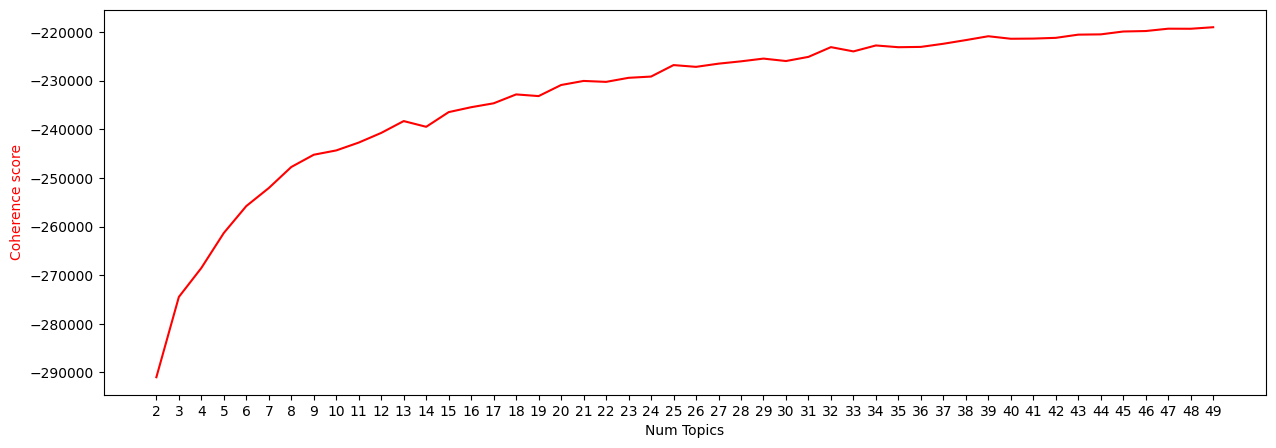

In [16]:
x = n_range
y_coherence = coherence
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(x, y_coherence, c='r')
ax1.set_xticks(x)
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence score", color='r')
plt.show()

It looks like 10 topics is a good starting point. That's where the line shows the start of flattening, and it's still easy to explain.

In [17]:
num_topics = 10

In [18]:
# create btm
btm = oBTM(num_topics=num_topics, V=vocab)

In [19]:
print("\n\n Train Online BTM ..")
for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
    biterms_chunk = biterms[i:i + 100]
    btm.fit(biterms_chunk, iterations=100)
topics = btm.transform(biterms)



 Train Online BTM ..


100%|██████████| 100/100 [00:00<00:00, 1667.00it/s]


Using the visualization below we can see the word distribution in each topic and name the topics accordingly.

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0), mds='mmds')
# pyLDAvis.save_html(vis, './vis/online_btm.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.070923  0.104922       1        1  12.394774
4      0.055473 -0.106142       2        1  12.291631
5     -0.001631  0.276594       3        1  11.605693
7     -0.220633 -0.209100       4        1  10.845552
9     -0.259232  0.216648       5        1  10.705210
1      0.203485  0.203305       6        1   9.963539
6      0.248995 -0.151767       7        1   9.861267
2     -0.269294 -0.046587       8        1   9.053896
0      0.308597  0.051063       9        1   7.028545
3      0.005164 -0.338937      10        1   6.249892, topic_info=      Term       Freq       Total Category  logprob  loglift
314     it  55.000000   55.000000  Default  30.0000  30.0000
399     my  73.000000   73.000000  Default  29.0000  29.0000
202  extra  38.000000   38.000000  Default  28.0000  28.0000
53      be  33.000000   33.000000  Default  27.0000  27.0000
647    too  41.000000   41.000000  Default  26.0000  26.0000
..     ...        ...         ...      ...      ...      ...
722   your   5.716761   56.927167  Topic10  -3.8259   0.4742
33     and   6.066695  124.641909  Topic10  -3.7665  -0.2500
374     me   4.142056   34.932356  Topic10  -4.1481   0.6404
720    you   4.783602   98.788744  Topic10  -4.0041  -0.2552
295     in   4.083734   40.656019  Topic10  -4.1623   0.4745

[680 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         9  0.686302   able
1         1  0.124362  about
1         4  0.062181  about
1         5  0.124362  about
1         6  0.683990  about
...     ...       ...    ...
722       7  0.122964   your
722       8  0.087832   your
722      10  0.105398   your
723       6  0.405621  youre
723       8  0.567870  youre

[904 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 6, 8, 10, 2, 7, 3, 1, 4])

Here is the `labels` we decided to assign to each topic, in a mapping dictionary format.

In [50]:
topic_mapping = {
    1: 'Generally Disappointed',
    2: 'Constant price rise',
    3: 'Household change',
    4: 'Price increases',
    5: 'Reducing expenses',
    6: 'Family share not allowed',
    7: 'Not worth the price',
    8: 'Moving',
    9: 'Too expensive',
    10: 'Be back'
}

We can now assign a topic to each `response` and map the topic numbers to the labels we assigned above.

In [51]:
df_lda = df[df['keep']==True]
dominant_topics = []
for i in range(len(texts)):
    dominant_topics.append(topics[i].argmax() + 1)
df_lda['dominant_topic'] = dominant_topics
df_lda

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
4    Why are you cancelling?        1779967   
5    Why are you cancelling?        1779966   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
4                           Cannot have multiple users   
5                  cost has risen too much too quickly   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                              theme  keep  dominant_topic  
0                               NaN  True               2  
1                               NaN  True               5  
2                               NaN  True               7  
4    Object to sharing restrictions  True               1  
5    Constant price rise / increase  True               8  
..                              ...   ...             ...  
658  Constant price rise / increase  True               5  
659  Constant price rise / increase  True               1  
660              Prefer competition  True               7  
661                   Too expensive  True               7  
662  Constant price rise / increase  True               7  

[501 rows x 6 columns]

In [52]:
df_lda['dominant_topic'] = df_lda['dominant_topic'].map(topic_mapping)
df_lda

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
4    Why are you cancelling?        1779967   
5    Why are you cancelling?        1779966   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
4                           Cannot have multiple users   
5                  cost has risen too much too quickly   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                              theme  keep          dominant_topic  
0                               NaN  True     Constant price rise  
1                               NaN  True       Reducing expenses  
2                               NaN  True     Not worth the price  
4    Object to sharing restrictions  True  Generally Disappointed  
5    Constant price rise / increase  True                  Moving  
..                              ...   ...                     ...  
658  Constant price rise / increase  True       Reducing expenses  
659  Constant price rise / increase  True  Generally Disappointed  
660              Prefer competition  True     Not worth the price  
661                   Too expensive  True     Not worth the price  
662  Constant price rise / increase  True     Not worth the price  

[501 rows x 6 columns]

## Part 2

The easiest way to show the topic distribution is to show the count plot.

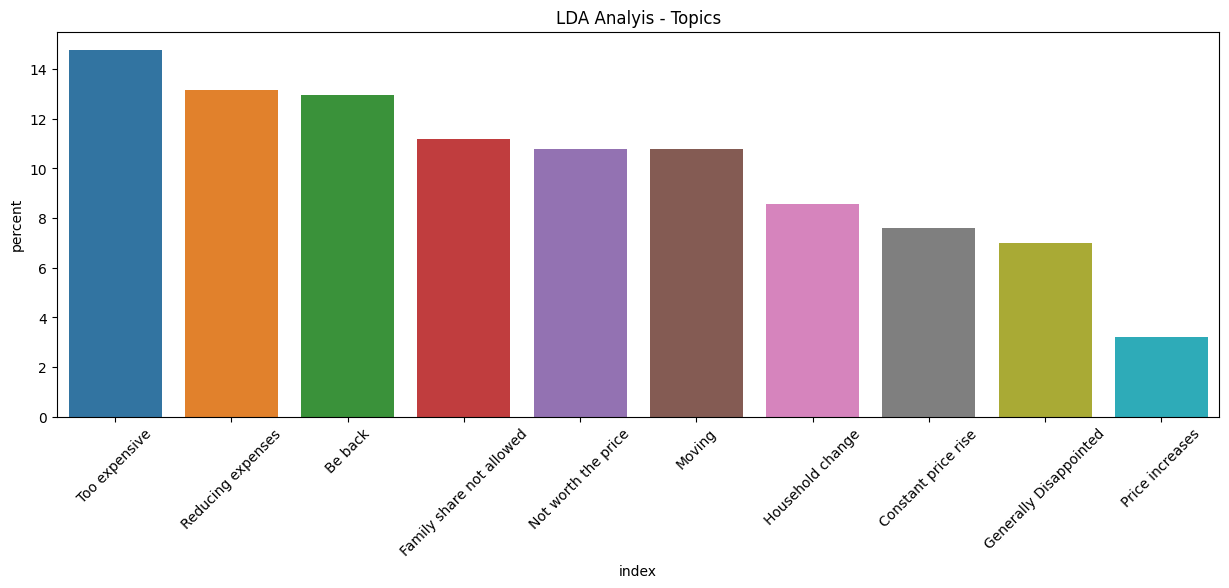

In [53]:
plt.figure(figsize=(15, 5))
plot_df = df_lda['dominant_topic'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(data=plot_df,  x='index', y='percent')
plt.title('LDA Analyis - Topics')
plt.xticks(rotation = 45)
plt.show()

It looks like the major reason for cancelling is the price, being too expensive (15%) or people want to reduce their expenses (13%).
A good part is temporarily canceling but will be back (13%). Also not allowing family share is an issue for 12% of the people and or moving/changing household is the reason for 22% (combined) of the total. 

We can also see the word cloud per topic.

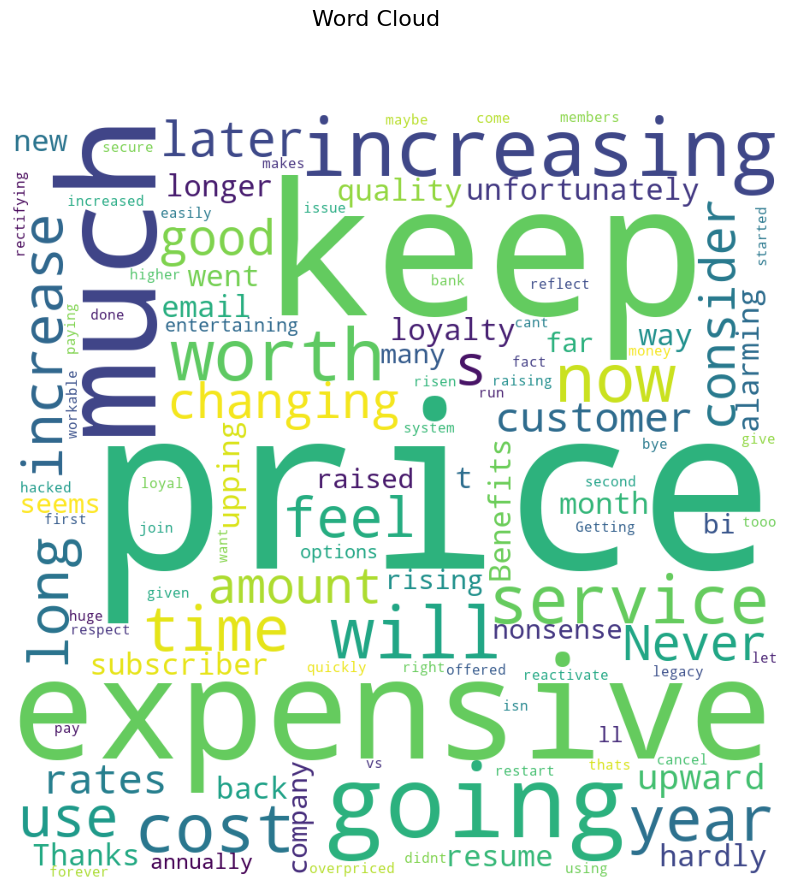

In [54]:
topic_selection = 'Moving'

plot_df = df_lda[df_lda['dominant_topic']==topic_selection]
inputs = plot_df['response'].tolist()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(inputs, max_words=200)

### Further discussions

Above are just some of the visualizations that could help the analyst's understanding of the language that distinguishes the topics. Other helpful visual could be bar chart of most frequent words per topic, part of speech (POS) analysis or named entity recognition algorithms to find different patterns in the language.

Because of the nature of the short answers, BTM topic model is most suitable for the task, but a regular LDA analysis could be tried to compare the results. Below are some of next steps that could be implemented:
- come up with a metric, that could be accuracy, to evaluate the BTM model with the pre-labeled text (`theme` column)
- improve the model with more text clenup and pre-processing (lemmatization or stemmatization in primis)
- we had to remove answers shorted than 3 words for the BTM mode lto work (in order to create biterms) but we need to work with the whole dataset
- For very short answer the best approach would probably be topic assignment based on root words and matching/similarity to topic label (example: if (root) word is in topic label then assign label)
- More advanced technologies, based on pre-trained transformers, can be used. Example: use sentence embeddings (BERT, GPT series, T5, etc..) and try clustering the hyper-dimensional vectors to get the topics
- BERTopic is another (transformer based model) option for this kind of problem, to experiment with